1. [Sample Selection](#Sample-Selection)  
    1. [ Income sample selection](#Income-sample-selection)  
    2. [Data Trimming](#Data-Trimming)  

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }<\style>"))

In [3]:
import datetime
print(datetime.datetime.now())

2019-03-06 14:28:30.660884


In [4]:
%matplotlib inline

In [5]:
import matplotlib.pyplot as plt

In [6]:
from __future__ import division
import pandas as pd ; pd.set_option("display.max_columns",200)
import numpy as np
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

In [7]:
# Disable view vs copy warnings
pd.options.mode.chained_assignment = None

In [8]:
result_path = u"C:/Users/IMPTEMP_A_PACIFIC/Desktop/EDP_2016/Program/Program_only_married_couples/hdf_married_couples/"

In [9]:
%%time
df = pd.read_hdf(result_path+"married_couples_step_last.h5", "fiscr")

Wall time: 15.3 s


In [10]:
df.shape

(789743, 513)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 789743 entries, 0 to 789742
Columns: 513 entries, ID_FISC_LOG_DIFF to Delta_Rbg_times_not_touched_reform
dtypes: bool(55), float64(231), int32(6), int64(127), object(94)
memory usage: 2.7+ GB


In [12]:
df = df.convert_objects()

C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-3.6.3.0Qt5\python-3.6.3.amd64\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """Entry point for launching an IPython kernel.


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 789743 entries, 0 to 789742
Columns: 513 entries, ID_FISC_LOG_DIFF to Delta_Rbg_times_not_touched_reform
dtypes: bool(55), float64(241), int32(6), int64(128), object(83)
memory usage: 2.7+ GB


In [14]:
%%time
df.loc[:,df.dtypes == 'object'] = df.loc[:,df.dtypes == 'object'].astype("str")

Wall time: 22.3 s


In [15]:
df.reset_index().to_feather("to_trash.feather")

In [16]:
%%time
df = pd.read_feather("to_trash.feather")

Wall time: 1min 8s


In [249]:
summary_col?

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 789743 entries, 0 to 789742
Columns: 514 entries, level_0 to Delta_Rbg_times_not_touched_reform
dtypes: bool(55), float64(241), int32(6), int64(129), object(83)
memory usage: 2.7+ GB


## Sample Selection

### Income sample selection

In [18]:
nb_enf_max_for_annalysis = 5

In [19]:
%%time
no_attached = (df.TYPE_FISC_2014.str.count("[3-9]")<1)&(df.TYPE_FISC_2011.str.count("[3-9]")<1)
df = df.query("@no_attached")
#Drop households that has dependent children (over 18 still attached to the fiscal household)

print(df.shape)
#Nouvelle version ou il faut appartenir à l'intervalle de revenu que sur un seule des deux années
df = df[((
            (df.Rbg_2011>50000)
            &(df.Rbg_2011<200000)
        )|(
            (df.Rbg_2014>50000)
            & (df.Rbg_2014<200000)))]
# Drop households with more than 5 children
df = df[df.NBPAC_2011<=nb_enf_max_for_annalysis]

# Drop households with a parent that has passed the retirement age
age_max_parents = 62
print(((df.Age_mother>age_max_parents)|(df.Age_father>age_max_parents)).value_counts()) 
df = df[~((df.Age_mother>age_max_parents)|(df.Age_father>age_max_parents))]


# Same number of children before and after the reform
df = df[df.NBPAC_2011 == df.NBPAC_2014]

(694147, 514)
False    163924
True      40318
dtype: int64
Wall time: 21.9 s


### Data Trimming

In [20]:
## On vire les variations extrèmes pour ne pas avoir de revenus négatifs.

In [21]:
%%time


### simple version of the code below (but without the iterative process)
# low = 0.025
# high = 0.975
# quant_df = df.Delta_Rbg.quantile([low,high])
# print(quant_df)
# df1 = df[df.Delta_Rbg>quant_df.loc[low]]
# df1 = df1[df1.Delta_Rbg<quant_df.loc[high]]




start = 0.045#Replace with 0 on first run (but will take a while to execute)
step =  0.0001
trim_shares = np.arange(start, 1, step)
for trim_share in trim_shares:
    low = trim_share/2
    high = (1-low)
    quant_df = df.Delta_Rbg.quantile([low,high])
    df_temp = df[df.Delta_Rbg>quant_df.loc[low]]
    df_temp = df_temp[df_temp.Delta_Rbg<quant_df.loc[high]]
    if (df_temp.Rbg_2011.min()>0) & (df_temp.Rbg_2014.min()>0):
        print(str(trim_share*100) + "  of the obsevations will be dropped")
        print(str(df.shape[0] - df_temp.shape[0]) + " obsevations will be dropped")
        break
assert trim_share > trim_shares[1] , " only one iteration , your start value is too high or your step too big"

df_temp.Delta_Rbg.describe(percentiles=np.arange(0,1,0.1))

print(df_temp.Rbg_2011.min())
print(df_temp.Rbg_2014.min())
print(df_temp.Rbg_2011.max())
print(df_temp.Rbg_2014.max())

4.54  of the obsevations will be dropped
8095 obsevations will be dropped
1666.8
10922.1
237328.0
246095.7
Wall time: 2min 58s


In [22]:
df_temp.shape

(134276, 514)

In [23]:
df.shape

(142371, 514)

In [24]:
df = df_temp

In [25]:
print(df.Rbg_2011.min())
print(df.Rbg_2014.min())
print(df.Rbg_2011.max())
print(df.Rbg_2014.max())

1666.8
10922.1
237328.0
246095.7


### Data cleaning

In [26]:
### On vire les ménages dont il manque le salaire du père ou de la mère (16000 obs)
df = df.query("(~YSALI_2011_father.isna())& (~YSALI_2014_father.isna()) & (~YSALI_2014_mother.isna()) & (~YSALI_2014_mother.isna()) ", engine = 'python')

In [27]:
df.shape

(119260, 514)

In [28]:
### Fill na sur l'age des sans enfants ?

In [29]:
df["To_trash"] = (df.Age_eldest_child<14)

In [30]:
(df.Age_eldest_child<14).value_counts()

True     72723
False    46537
Name: Age_eldest_child, dtype: int64

In [31]:
df.Age_eldest_child.fillna(0, inplace = True)
df.Age_youngest_child.fillna(0, inplace = True)

In [32]:
df = df[df.Age_eldest_child<14] ## Need to be less than 18 3 years later

In [33]:
df.shape

(99940, 515)

In [34]:
#df.loc[:,df.applymap(type).nunique().gt(1)]

In [35]:
info_dict={'adjusted-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100), "N":lambda x:"{:d}".format(int(x.nobs))}
both_wage = ~(df["YSALI_2014_father"].isna()| df["YSALI_2014_mother"].isna()| df["YSALI_2011_father"].isna() | df["YSALI_2011_mother"].isna())

In [36]:
# TODO: move to data preparation steps 
df["Age_oldest_parent"] = df[["Age_father", "Age_mother"]].max(axis = 1)
df["Age_oldest_parent_squared"] = df.Age_oldest_parent**2

In [37]:
threshold_byr_rbg = pd.DataFrame()
threshold_byr_rbg["2011"] = pd.Series([63233,73516,94451,115185,135941,150684])
threshold_byr_rbg["2014"] = pd.Series([58291,63530,73806,84103,94368,104633])

We define the taxable income (Revenu Brut Global) based on the 7 income categories present in the database.

In [38]:
household_income_vars = ["ZTSAM", "ZRAGM", "ZRACM","ZRNCM", "ZFONM", "ZPERM","ZRICM"]
for var in household_income_vars:
    df["Delta_{}".format(var)] = df["{}_2014".format(var)] - df["{}_2011".format(var)]

# Income tax

### Income tax and the reform

In [39]:
threshold_byr_rbg = pd.DataFrame()
threshold_byr_rbg["2011"] = pd.Series([63233,73516,94451,115185,135941,150684])
threshold_byr_rbg["2014"] = pd.Series([58291,63530,73806,84103,94368,104633])

(50000, 160000)

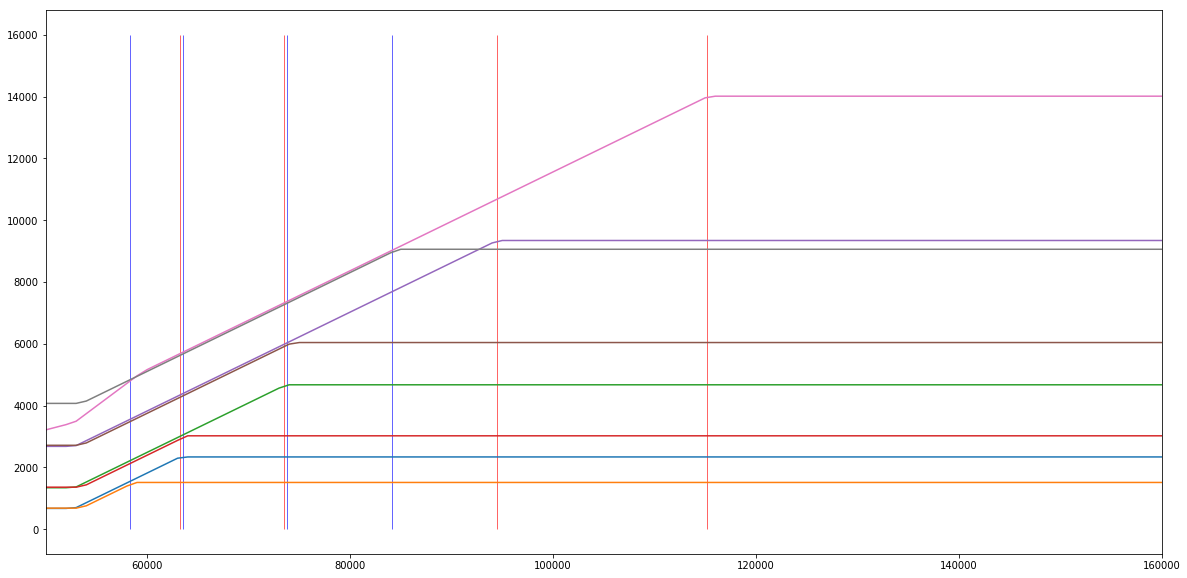

In [40]:
import importlib
year = 2014

ir_2014 = importlib.import_module("Irpp_formulas.IRPP_from_scratch_civil_union")

ir_2011 = importlib.import_module("Irpp_formulas.IRPP_from_scratch_civil_union_{}".format(2011))

dict_gain_ir_2011_by_child = dict()
dict_gain_ir_2014_by_child = dict()
for child in range(1,6):
    ir_x_children = ir_2011.ir_avec_plafond_qf_enfant(pd.Series(
        range(0,2*10**5, 1000)), ir_2014.parts_fiscales_enfants(pd.Series([child]*200).astype("float")))
    ir_0_children = ir_2011.ir_avec_plafond_qf_enfant(pd.Series(
        range(0,2*10**5, 1000)), ir_2011.parts_fiscales_enfants(pd.Series([0.0]*200).astype("float")))
    dict_gain_ir_2011_by_child[child] = ir_0_children - ir_x_children 
    
    ir_x_children = ir_2014.ir_avec_plafond_qf_enfant(pd.Series(
        range(0,2*10**5, 1000)), ir_2014.parts_fiscales_enfants(pd.Series([child]*200).astype("float")))
    ir_0_children = ir_2014.ir_avec_plafond_qf_enfant(pd.Series(
        range(0,2*10**5, 1000)), ir_2014.parts_fiscales_enfants(pd.Series([0.0]*200).astype("float")))
    dict_gain_ir_2014_by_child[child] = ir_0_children - ir_x_children 
    
    
    

plt.figure(figsize=(20,10))
for child in range(1,5):
    plt.plot( pd.Series(range(0,2*10**5, 1000)),dict_gain_ir_2011_by_child[child])
    plt.plot( pd.Series(range(0,2*10**5, 1000)),dict_gain_ir_2014_by_child[child])
for thrsh in threshold_byr_rbg["2011"][0:4]:
    plt.vlines(thrsh, 0 , 16000, linewidth = 0.6, color = "r")
for thrsh in threshold_byr_rbg["2014"][0:4]:
    plt.vlines(thrsh, 0 , 16000, linewidth = 0.6, color = "b")
plt.xlim(50000,160000)

#ir_2011.ir_avec_plafond_qf_enfant(pd.Series(range(0,2*10**5, 1000)), ir.parts_fiscales_enfants(pd.Series([3.0]*200).astype("float"))).plot()

### Real vs. computed income tax

In [41]:
parts_fiscales_enfants = ir_2014.parts_fiscales_enfants(df.NBPAC_2011)

In [42]:
df["Parts_fiscales_enfants"] = ir_2011.parts_fiscales_enfants(df.NBPAC_2011)
df["Parts_fiscales_enfants_2014"] = ir_2014.parts_fiscales_enfants(df.NBPAC_2014)

In [43]:
df["Irpp_2011"] = np.maximum(0, ir_2011.ir_avec_plafond_qf_enfant(df.Rbg_2011,df.Parts_fiscales_enfants) - ir_2011.decote_ir(df.Rbg_2011, df.Parts_fiscales_enfants))
df["Irpp_2014"] = np.maximum(0, ir_2014.ir_avec_plafond_qf_enfant(df.Rbg_2014, df.Parts_fiscales_enfants_2014) - ir_2014.decote_ir(df.Rbg_2014, df.Parts_fiscales_enfants_2014))

#### All 2011

(99940, 528)


Text(0,0.5,'Predicted Income Tax')

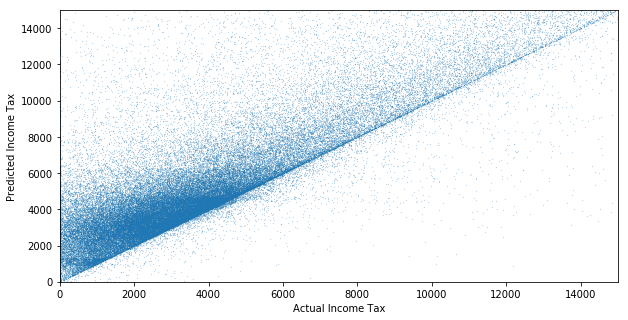

In [44]:
df_temp = df.query("(NBPAC_2011 >=0) & (NBPAC_2011==NBPAC_2014) ")
print(df_temp.shape)
fig = plt.figure(figsize=(10,5))
plt.scatter(df_temp.ZIMPOM_2011,df_temp.Irpp_2011, s=0.01 )
plt.xlim(0,15000) ; plt.xlabel("Actual Income Tax")
plt.ylim(0,15000) ; plt.ylabel("Predicted Income Tax")

#### All 2014

(99940, 528)


Text(0,0.5,'Predicted Income Tax')

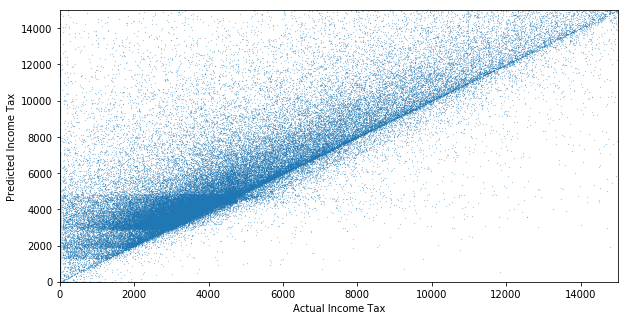

In [45]:
df_temp = df.query("(NBPAC_2011 >=0) & (NBPAC_2011==NBPAC_2014) ")
print(df_temp.shape)
fig = plt.figure(figsize=(10,5))
plt.scatter(df_temp.ZIMPOM_DECL_2014,df_temp.Irpp_2014, s=0.02 )
plt.xlim(0,15000) ; plt.xlabel("Actual Income Tax")
plt.ylim(0,15000) ; plt.ylabel("Predicted Income Tax")

In [46]:
print(df_temp.ZIMPOM_2011.mean())
print(df_temp.Irpp_2011.mean())

4864.186702021213
6765.853643616248


#### No child

2011
(27217, 528)
2014
(27217, 528)


Text(0,0.5,'Predicted Income Tax')

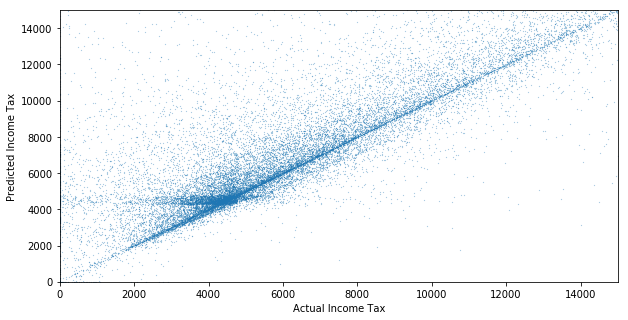

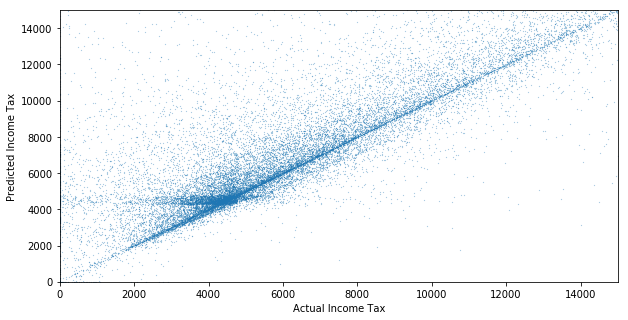

In [47]:
print(2011)
df_temp = df.query("(NBPAC_2011 ==0) & (NBPAC_2011==NBPAC_2014) ")
print(df_temp.shape)
fig = plt.figure(figsize=(10,5))
plt.scatter(df_temp.ZIMPOM_DECL_2014,df_temp.Irpp_2014, s=0.02 )
plt.xlim(0,15000) ; plt.xlabel("Actual Income Tax")
plt.ylim(0,15000) ; plt.ylabel("Predicted Income Tax")

print("2014")
df_temp = df.query("(NBPAC_2011 ==0) & (NBPAC_2011==NBPAC_2014) ")

print(df_temp.shape)
fig = plt.figure(figsize=(10,5))
plt.scatter(df_temp.ZIMPOM_DECL_2014,df_temp.Irpp_2014, s=0.02 )
plt.xlim(0,15000) ; plt.xlabel("Actual Income Tax")
plt.ylim(0,15000) ; plt.ylabel("Predicted Income Tax")

In [48]:
print(df_temp.ZIMPOM_2011.mean())
print(df_temp.Irpp_2011.mean())

7618.0272623727815
8997.469897876297


In [49]:
print(df_temp.ZIMPOM_2011.mean())
print(df_temp.Irpp_2011.mean())

7618.0272623727815
8997.469897876297


(72723, 528)


Text(0,0.5,'Actual Income Tax')

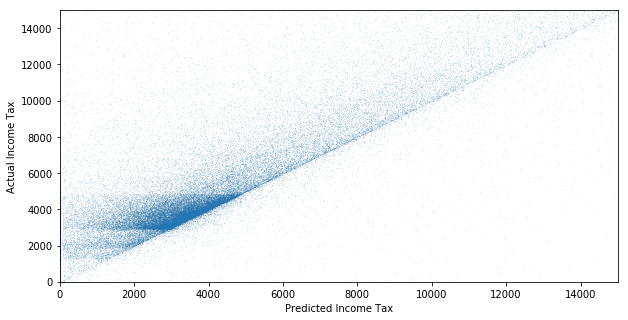

In [50]:
df_temp = df.query("(NBPAC_2011 >=1) & (NBPAC_2011==NBPAC_2014) ")
print(df_temp.shape)
fig = plt.figure(figsize=(10,5))
plt.scatter(df_temp.ZIMPOM_DECL_2014,df_temp.Irpp_2014 - df_temp.ZAVFM_2014, s=0.002 )
plt.xlim(0,15000) ; plt.xlabel("Predicted Income Tax")
plt.ylim(0,15000) ; plt.ylabel("Actual Income Tax")

(11900, 528)


Text(0,0.5,'Actual Income Tax')

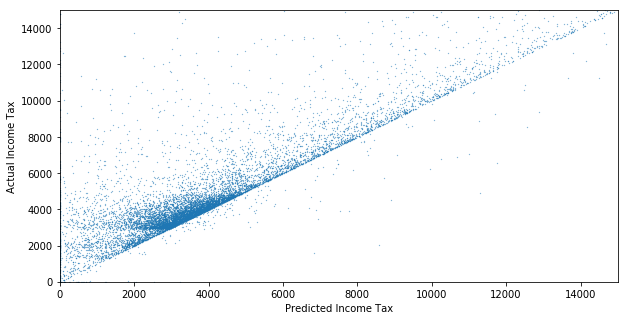

In [51]:
df_temp = df.query("(NBPAC_2011 >=1) & (NBPAC_2011==NBPAC_2014) ")
df_temp = df_temp[df_temp[["ZAVFM_2014", "ZAVFM_DECL_2014", "GARDEM_2014", "SERVDOMM_2014", "ZGLOM_2014", "ZDIVM_2014"]].sum(axis=1)==0]
print(df_temp.shape)
fig = plt.figure(figsize=(10,5))
plt.scatter(df_temp.ZIMPOM_DECL_2014,df_temp.Irpp_2014 - df_temp.ZAVFM_2014, s=0.05 )
plt.xlim(0,15000) ; plt.xlabel("Predicted Income Tax")
plt.ylim(0,15000) ; plt.ylabel("Actual Income Tax")

Quand on enlève les variables qui viennent après le barèe, on devient plus précis dans le calcul de l'impôt.

In [52]:
df["Irpp_error_gap_2014"] = (df.ZIMPOM_2014 - df.Irpp_2014)
df["Irpp_error_gap_2011"] = df.ZIMPOM_2011-df.Irpp_2011

df["outlier_ZIMPOM_error_2014"] = np.abs(df.Irpp_error_gap_2014 - df.Irpp_error_gap_2014.mean())>= 2*df.Irpp_error_gap_2014.std()
df["outlier_ZIMPOM_error_2011"] = np.abs(df.Irpp_error_gap_2011 - df.Irpp_error_gap_2011.mean())>= 2*df.Irpp_error_gap_2011.std()
df["outlier_ZIMPOM_error"] = df["outlier_ZIMPOM_error_2014"] | df["outlier_ZIMPOM_error_2011"]

df["No_after_piecewize_ts_income"] = df[["ZAVFM_2014", "ZAVFM_DECL_2014", "GARDEM_2014", "SERVDOMM_2014", "ZGLOM_2014", "ZDIVM_2014"]].sum(axis = 1)<100

In [53]:
print(df.outlier_ZIMPOM_error_2014.value_counts())
print(df.outlier_ZIMPOM_error_2011.value_counts())
print(df.outlier_ZIMPOM_error.value_counts())

False    96351
True      3589
Name: outlier_ZIMPOM_error_2014, dtype: int64
False    97509
True      2431
Name: outlier_ZIMPOM_error_2011, dtype: int64
False    95116
True      4824
Name: outlier_ZIMPOM_error, dtype: int64


Text(0,0.5,'Houoseholds')

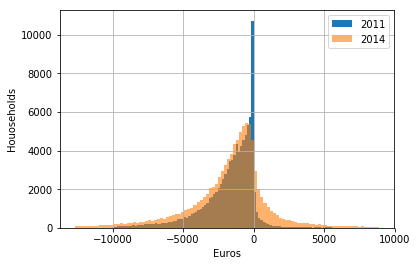

In [54]:
df.query("~outlier_ZIMPOM_error").Irpp_error_gap_2011.hist(bins = 100, label = "2011")
df.query("~outlier_ZIMPOM_error").Irpp_error_gap_2014.hist(bins = 100, alpha=0.6, label = "2014")
plt.legend(); plt.xlabel("Euros");plt.ylabel("Houoseholds")

Text(0,0.5,'Houoseholds')

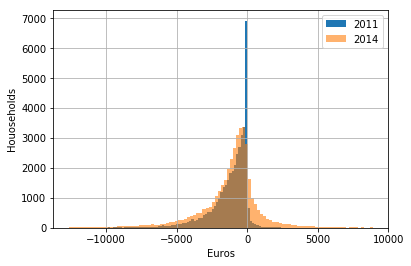

In [55]:
df.query("(~outlier_ZIMPOM_error)&(No_after_piecewize_ts_income)").Irpp_error_gap_2011.hist(bins = 100, label = "2011")
df.query("(~outlier_ZIMPOM_error)&(No_after_piecewize_ts_income)").Irpp_error_gap_2014.hist(bins = 100, alpha=0.6, label = "2014")
plt.legend(); plt.xlabel("Euros");plt.ylabel("Houoseholds")

In [56]:
df.No_after_piecewize_ts_income.value_counts()

False    58720
True     41220
Name: No_after_piecewize_ts_income, dtype: int64

In [57]:
print(df.outlier_ZIMPOM_error_2014.value_counts())
print(df.outlier_ZIMPOM_error_2011.value_counts())
print(df.outlier_ZIMPOM_error.value_counts())

False    96351
True      3589
Name: outlier_ZIMPOM_error_2014, dtype: int64
False    97509
True      2431
Name: outlier_ZIMPOM_error_2011, dtype: int64
False    95116
True      4824
Name: outlier_ZIMPOM_error, dtype: int64


In [58]:
df.outlier_ZIMPOM_error_2014.value_counts()

False    96351
True      3589
Name: outlier_ZIMPOM_error_2014, dtype: int64

In [59]:
print(df.Irpp_error_gap_2014.mean())
print(df.Irpp_error_gap_2011.mean())

-1888.8939787372178
-1901.6669415949648


In [60]:
print(df.query("~outlier_ZIMPOM_error").Irpp_error_gap_2014.describe())
print(df.query("~outlier_ZIMPOM_error").Irpp_error_gap_2011.describe())

count    95116.000000
mean     -1723.759030
std       2834.811156
min     -12683.200000
25%      -2899.484500
50%      -1266.614000
75%       -255.398000
max       8906.072000
Name: Irpp_error_gap_2014, dtype: float64
count    95116.000000
mean     -1676.143777
std       1887.499080
min      -9881.820000
25%      -2444.189000
50%      -1205.785000
75%       -366.209563
max       6064.740000
Name: Irpp_error_gap_2011, dtype: float64


In [61]:
print(df.query("(~outlier_ZIMPOM_error) & No_after_piecewize_ts_income & NBPAC_2011 == 2").Irpp_error_gap_2014.mean())
print(df.query("(~outlier_ZIMPOM_error) & No_after_piecewize_ts_income").Irpp_error_gap_2011.mean())

-1333.2647499853424
-1211.2885561514897


In [62]:
df.query("outlier_ZIMPOM_error & No_after_piecewize_ts_income").shape

(807, 534)

In [63]:
(df_temp.ZIMPOM_2011 - df_temp.Irpp_2011).std()

1993.390545253767

In [64]:
print(df_temp.ZIMPOM_2011.mean())
print(df_temp.Irpp_2011.mean())

2807.387142857143
4151.810103172276


(52777, 534)


Text(0,0.5,'Actual Income Tax')

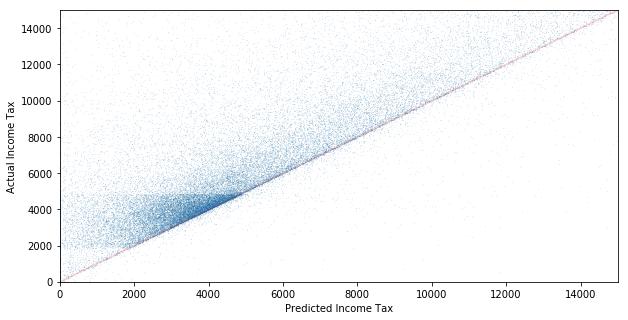

In [65]:
df_temp = df.query("(NBPAC_2011 >=1) & (NBPAC_2011==NBPAC_2014<4)&(50_000<Rbg_2011<200_000)")
print(df_temp.shape)
fig = plt.figure(figsize=(10,5))
plt.scatter(df_temp.ZIMPOM_DECL_2014,df_temp.Irpp_2014, s=0.002 )
plt.plot(list(range(10**5)), color = 'r', alpha = 0.18)
plt.xlim(0,15000) ; plt.xlabel("Predicted Income Tax")
plt.ylim(0,15000) ; plt.ylabel("Actual Income Tax")

(52777, 534)


Text(0,0.5,'Actual Income Tax')

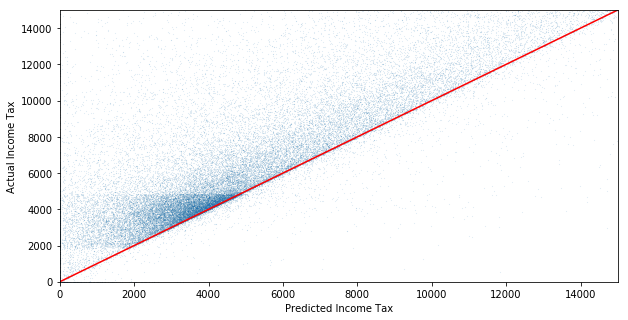

In [66]:
df_temp = df.query("(NBPAC_2011 >=1) & (NBPAC_2011==NBPAC_2014<4)&(50_000<Rbg_2011<200_000)")
print(df_temp.shape)
fig = plt.figure(figsize=(10,5))
plt.scatter(df_temp.ZIMPOM_DECL_2014,df_temp.Irpp_2014, s=0.002 )
plt.plot(list(range(10**5)), color = 'r')
plt.xlim(0,15000) ; plt.xlabel("Predicted Income Tax")
plt.ylim(0,15000) ; plt.ylabel("Actual Income Tax")

In [67]:
print(df_temp.ZIMPOM_2011.mean())
print(df_temp.Irpp_2011.mean())

4840.710991530402
7254.721105860454


## Needed variables

In [68]:
nb_enf_max_for_annalysis = 5

In [69]:
child_bool_list = ["child_{}".format(child) for child in  np.arange(1,nb_enf_max_for_annalysis+1)]
cumulative_child_bool_list = ["cumulative_child_{}".format(child) for child in  np.arange(1,nb_enf_max_for_annalysis+1)] 

In [70]:
all_thresholds = pd.concat([threshold_byr_rbg["2011"], threshold_byr_rbg["2014"]]).sort_values()
thrsh_bool_list = ["Threshold_{}".format(thrsh) for thrsh in  all_thresholds ]

In [71]:
between_threshold_for_child_rank = ["Between_threshold_{}_child".format(nb_child) for nb_child in range(1,nb_enf_max_for_annalysis+1)]
over_threshold_for_child_rank = ["Over_threshold_{}_child".format(nb_child) for nb_child in range(1,nb_enf_max_for_annalysis+1)]
children_number =  ["child_{}".format(nb_child) for nb_child in range(1,nb_enf_max_for_annalysis+1)]

interaction_child_between_threshold  = ["{}:{}".format(child,interaction) for child, interaction in zip(children_number, between_threshold_for_child_rank)]
interaction_child_over_threshold  = ["{}:{}".format(child,interaction) for child, interaction in zip(children_number, over_threshold_for_child_rank)]

In [72]:
hardcoded_over = ["Over_{}_X_{}_child".format(child,child) for child in range(1,nb_enf_max_for_annalysis+1)]
hardcoded_between = ["Between_{}_X_{}_child".format(child,child) for child in range(1,nb_enf_max_for_annalysis+1)]

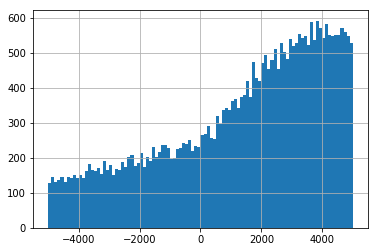

In [73]:
df.query("-5000<Delta_Rbg<5000").Delta_Rbg.hist(bins = 100)

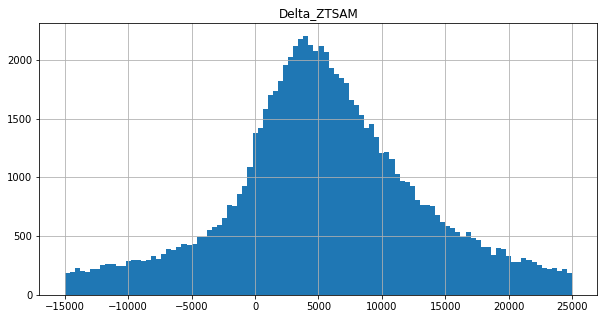

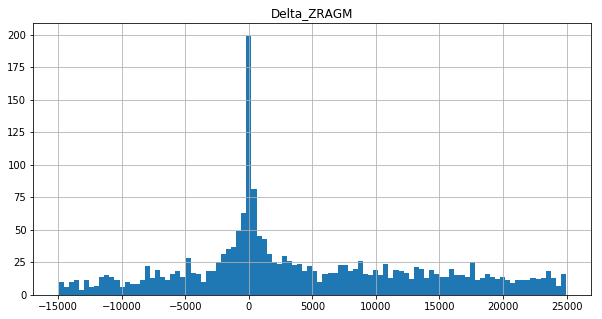

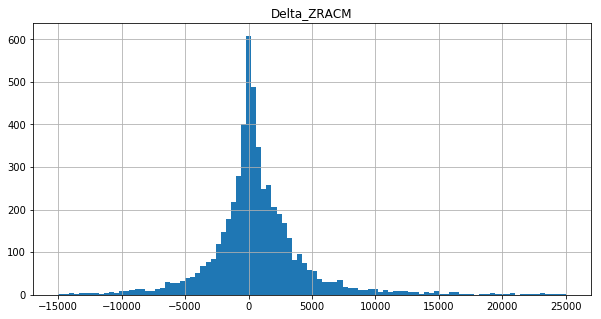

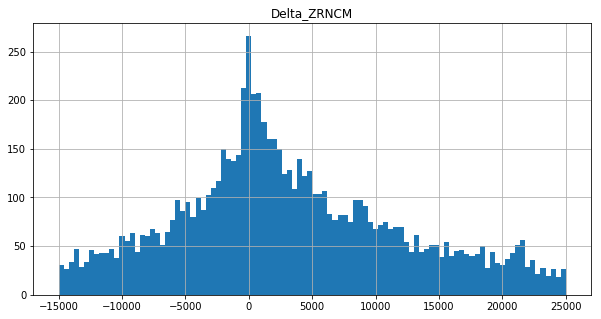

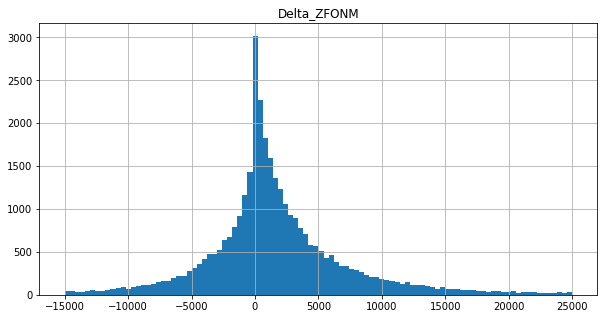

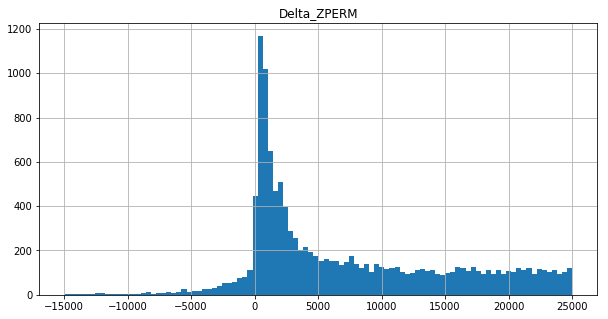

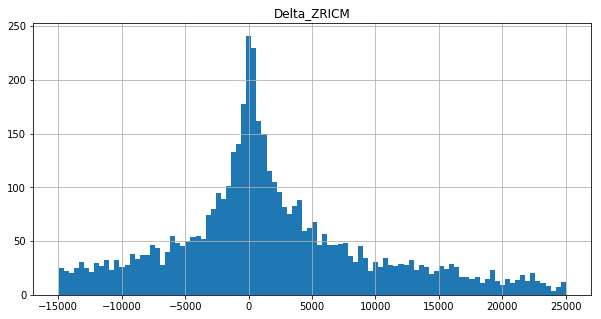

In [74]:
for var in household_income_vars:
    plt.figure(figsize=(10,5))
    df.query("(-15000<Delta_{}<25000) &(Delta_{}!=0)".format(var, var))["Delta_{}".format(var)].hist(bins = 100)
    plt.title("Delta_{}".format(var))

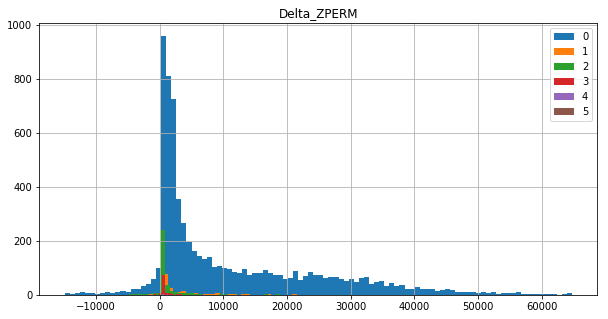

In [75]:
var = "ZPERM"
plt.figure(figsize=(10,5))
for nb_child in range(0,6):
    df.query("(-15000<Delta_{}<65000) &(Delta_{}!=0)&(ZPERM_2011>10000)&(NBPAC_2011==@nb_child)".format(var, var))["Delta_{}".format(var)].hist(bins = 100, label = "{}".format(nb_child))
plt.title("Delta_{}".format(var))
plt.legend()

Text(0.5,1,'Delta_ZPERM')

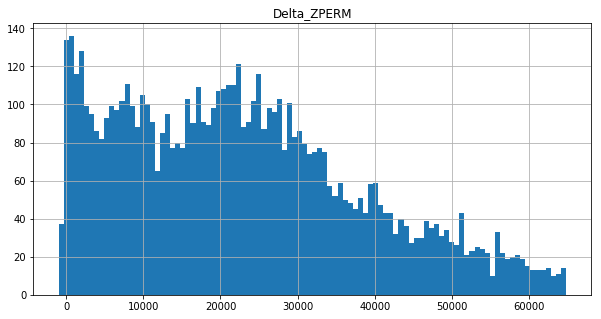

In [76]:
var = "ZPERM"
plt.figure(figsize=(10,5))
df.query("(-15000<Delta_{}<65000) &(Delta_{}!=0)&(ZPERM_2011<1000)".format(var, var))["Delta_{}".format(var)].hist(bins = 100)
plt.title("Delta_{}".format(var))

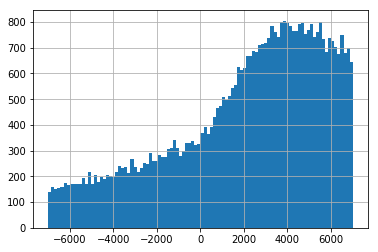

In [77]:
df.query("(-7000<Delta_Rbg<7000)").Delta_Rbg.hist(bins = 100)

In [78]:
(df.ZPERM_2014>0).value_counts(normalize = True)

False    0.827797
True     0.172203
Name: ZPERM_2014, dtype: float64

We have 28% of the sample that has retirement income. It creates a mass in the change in income at 2000 euros.

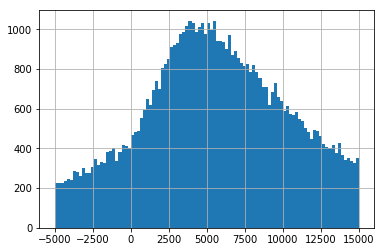

In [79]:
df.query("(-5000<Delta_Rbg<15000)&(ZPERM_2011<50)").Delta_Rbg.hist(bins = 100)

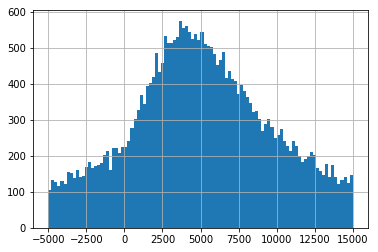

In [80]:
df.query("(-5000<Delta_Rbg<15000)&(No_after_piecewize_ts_income)").Delta_Rbg.hist(bins = 100)

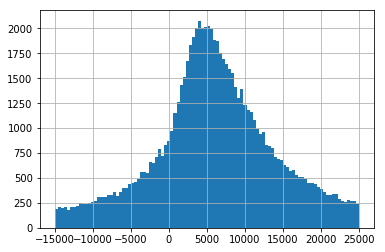

In [81]:
df.query("(-15000<Delta_Rbg<25000)&(ZPERM_2011<50)").Delta_Rbg.hist(bins = 100)

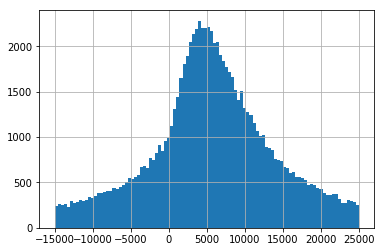

In [82]:
df.query("(-15000<Delta_Rbg<25000)").Delta_Rbg.hist(bins = 100)

In [83]:
(df.Rbg_2014==0).value_counts()

False    99940
Name: Rbg_2014, dtype: int64

In [84]:
df.query("NBPAC_2011<5").shape

(99747, 534)

In [85]:
df["Delta_NBPAC"] = df.NBPAC_2014 - df.NBPAC_2011

In [86]:
(df.Delta_NBPAC!=0).value_counts(normalize = True)

False    1.0
Name: Delta_NBPAC, dtype: float64

15% has experienced a birth or a child departure over the 2011,2014 period.  
We will focus our analysis only on households with a fixed family structure.

In [87]:
df.shape

(99940, 535)

### Distribution rbg both year

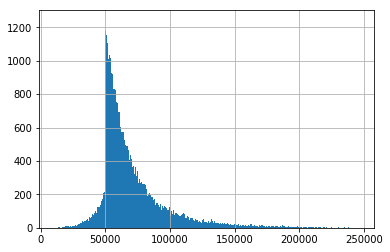

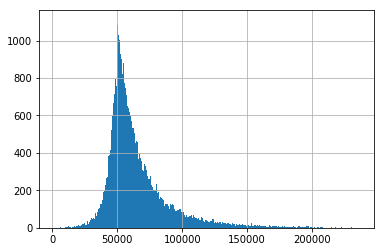

In [88]:
df.Rbg_2014.hist(bins = 900)
plt.figure()
df.Rbg_2011.hist(bins = 900)

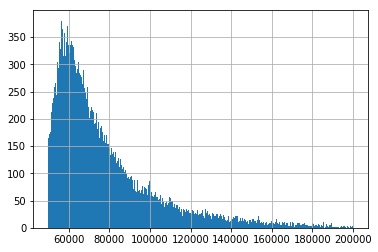

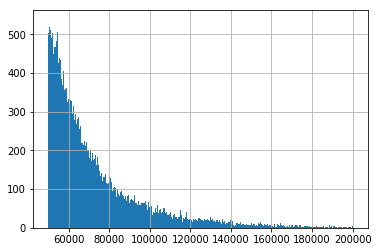

In [89]:
df.query("((200000>Rbg_2011>50000)&(200000>Rbg_2014>50000))").Rbg_2014.hist(bins = 900)
plt.figure()
df.query("((200000>Rbg_2011>50000)&(200000>Rbg_2014>50000))").Rbg_2011.hist(bins = 900)


In [90]:
%%time
df = df[df.NBPAC_2011.isin(range(nb_enf_max_for_annalysis+1))]#,6,7])]
#df = df[df.AGERF_2011<50]
#TODO : put in data selection step if needed
df.shape

Wall time: 338 ms


In [91]:
import statsmodels.api as sm
df["Rbg_splines"]  = pd.cut(df.Rbg_2011, 10)

In [92]:
df = df[(df.NBPAC_2011 == df.NBPAC_2014)]

### Stat Des

In [93]:
stat_des_variables = ["Rbg_2011","Rbg_2014","Delta_rbg","Age_father", "Age_mother","NBPAC_2011" , "Age_youngest_child", "Age_eldest_child"]

In [94]:
df[stat_des_variables].describe().loc["mean"]

Rbg_2011              65359.063806
Rbg_2014              70814.515237
Delta_rbg              5455.451431
Age_father               44.318121
Age_mother               42.418470
NBPAC_2011                1.512658
Age_youngest_child        3.643886
Age_eldest_child          6.094397
Name: mean, dtype: float64

In [95]:
df[stat_des_variables].query("NBPAC_2011==1").describe().loc["mean"]

Rbg_2011              64237.520812
Rbg_2014              69967.312674
Delta_rbg              5729.791862
Age_father               42.423119
Age_mother               39.948878
NBPAC_2011                1.000000
Age_youngest_child        6.568347
Age_eldest_child          6.568347
Name: mean, dtype: float64

In [96]:
df[stat_des_variables].query("NBPAC_2011==2").describe().loc["mean"]

Rbg_2011              64439.509251
Rbg_2014              71367.128389
Delta_rbg              6927.619138
Age_father               39.950636
Age_mother               37.954951
NBPAC_2011                2.000000
Age_youngest_child        5.096489
Age_eldest_child          8.352628
Name: mean, dtype: float64

In [97]:
df[stat_des_variables].query("NBPAC_2011==0").describe().loc["mean"]

Rbg_2011              65947.015461
Rbg_2014              67246.932678
Delta_rbg              1299.917217
Age_father               54.711614
Age_mother               53.337902
NBPAC_2011                0.000000
Age_youngest_child        0.000000
Age_eldest_child          0.000000
Name: mean, dtype: float64

In [98]:
### TODO: faire un multi-index avec all , 0 child, 1 ,2,3,4 and more child en colones et les variables en ignes.
stat_des_df = pd.DataFrame()

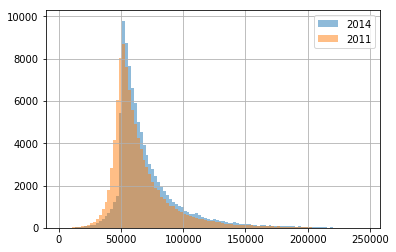

In [99]:
df.Rbg_2014.hist(bins = 100, alpha = 0.5, label = "2014")
df.Rbg_2011.hist(bins = 100,alpha = 0.5, label = "2011")
plt.legend()

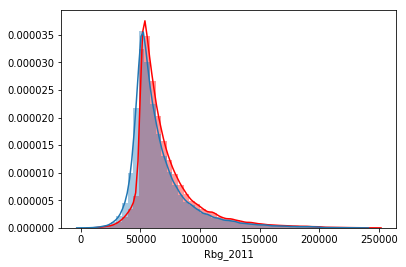

In [100]:
import seaborn as sns
sns.distplot(df.Rbg_2014, color = "r")
sns.distplot(df.Rbg_2011)

In [101]:
threshold_byr_rbg = pd.DataFrame()
threshold_byr_rbg["2011"] = pd.Series([63233,73516,94451,115185,135941,150684])
threshold_byr_rbg["2014"] = pd.Series([58291,63530,73806,84103,94368,104633])
threshold_byr_rbg.index = range(1,7); threshold_byr_rbg.index.name = 'nb_enf'
threshold_byr_rbg




df["Not_touched_by_reform"] = (df.NBPAC_2011 == 0).astype("int")
for nb_enf in range(1,7): ### in modification
    df["Not_touched_by_reform".format(nb_enf)
          ] +=((df.Rbg_2011<  threshold_byr_rbg["2014"].iloc[nb_enf-1])
                *( df.NBPAC_2011 == nb_enf)).astype("float")

C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-3.6.3.0Qt5\python-3.6.3.amd64\lib\site-packages\pandas\core\computation\expressions.py:179: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


In [102]:
df["Distance_to_treatment_2"]  = 0
for child in range(1,nb_enf_max_for_annalysis+1):
    df["Distance_to_treatment_2"] += df["Over_threshold_{}_child".format(child)] * df[child_bool_list[child-1]] * ((threshold_byr_rbg["2011"].iloc[child-1]) - df.Rbg_2014)

C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-3.6.3.0Qt5\python-3.6.3.amd64\lib\site-packages\pandas\core\computation\expressions.py:179: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


In [103]:
df.Not_touched_by_reform.value_counts()

1.0    73467
0.0    26473
Name: Not_touched_by_reform, dtype: int64

In [104]:
### TODO: put Treatment_0, 1,2 in the datapreparation step

df_desc_stat = pd.DataFrame()

for child in  range(0, nb_enf_max_for_annalysis+1):
        df_desc_stat.loc[child, "Treatment_0"] = df.query(
                                            "NBPAC_2011=={}".format(child)
                                            )["Not_touched_by_reform".format(child)].value_counts()[True]


for child in  range(1, nb_enf_max_for_annalysis+1):
    df_desc_stat.loc[child, "Treatment_1"] = df.query(
                                            "NBPAC_2011=={}".format(child)
                                            )["Between_threshold_{}_child".format(child)].value_counts()[True]
    df_desc_stat.loc[child, "Treatment_2"] = df.query(
                                            "NBPAC_2011=={}".format(child)
                                            )["Over_threshold_{}_child".format(child)].value_counts()[True]
df_desc_stat["Total"] = df_desc_stat.sum(axis = 1)
df_desc_stat.loc["Total"] = df_desc_stat.sum(axis = 0)

In [105]:
df_desc_stat

,Treatment_0,Treatment_1,Treatment_2,Total
0,27217.0,NaN,NaN,27217.0
1,6575.0,1428.0,4653.0,12656.0
2,27790.0,5986.0,10001.0,43777.0
3,10409.0,2018.0,1961.0,14388.0
4,1310.0,233.0,166.0,1709.0
5,166.0,20.0,7.0,193.0
Total,73467.0,9685.0,16788.0,99940.0


#### Still in the same treatment span

In [106]:

df["Rbg2014_below_threshold_{}_child".format(0)
          ] =  True
for nb_enf in range(1,7): ### in modification
    df["Rbg2014_Over_threshold_{}_child".format(nb_enf)
          ] =  (df.Rbg_2014 > threshold_byr_rbg["2011"].iloc[nb_enf-1])
    df["Rbg2014_Between_threshold_{}_child".format(nb_enf)
          ] =  (df.Rbg_2014 > threshold_byr_rbg["2014"].iloc[nb_enf-1]) & (df.Rbg_2014 < threshold_byr_rbg["2011"].iloc[nb_enf-1])
    df["Rbg2014_below_threshold_{}_child".format(nb_enf)
          ] =  (df.Rbg_2014 < threshold_byr_rbg["2014"].iloc[nb_enf-1])



In [107]:
df_desc_stat_2014 = pd.DataFrame()

for child in  [0]:
        df_desc_stat_2014.loc[child, "Treatment_0"] = df.query(
                                            "NBPAC_2011=={}".format(child)
                                            )["Rbg2014_below_threshold_{}_child".format(child)].value_counts()[True]



for child in  range(1, nb_enf_max_for_annalysis+1):
    df_desc_stat_2014.loc[child, "Treatment_1"] = df.query(
                                            "NBPAC_2011=={}".format(child)
                                            )["Rbg2014_Between_threshold_{}_child".format(child)].value_counts()[True]
    df_desc_stat_2014.loc[child, "Treatment_2"] = df.query(
                                            "NBPAC_2011=={}".format(child)
                                            )["Rbg2014_Over_threshold_{}_child".format(child)].value_counts()[True]
    
    df_desc_stat_2014.loc[child, "Treatment_0"] = df.query(
                                            "NBPAC_2011=={}".format(child)
                                            )["Rbg2014_below_threshold_{}_child".format(child)].value_counts()[True]
    
    
    
df_desc_stat_2014["Total"] = df_desc_stat_2014.sum(axis = 1)

In [108]:
df_desc_stat_2014

,Treatment_0,Treatment_1,Treatment_2,Total
0,27217.0,NaN,NaN,27217.0
1,4893.0,1675.0,6088.0,12656.0
2,22263.0,7781.0,13731.0,43775.0
3,9048.0,2628.0,2712.0,14388.0
4,1180.0,313.0,216.0,1709.0
5,152.0,29.0,12.0,193.0


#### Transitions 

In [109]:
df_desc_stat = pd.DataFrame()

for child in  [0]:
    df_desc_stat.loc[child, "Treatment_0"] = df.query(
                                            "NBPAC_2011=={}".format(child)
                                            )["Rbg2014_below_threshold_{}_child".format(child)].value_counts()[True]



for child in  range(1, nb_enf_max_for_annalysis+1):
    df_desc_stat.loc[child, "Treatment_1"] = df.query(
                                            "NBPAC_2011=={}".format(child)
                                            )["Rbg2014_Between_threshold_{}_child".format(child)].value_counts()[True]
    df_desc_stat.loc[child, "Treatment_2"] = df.query(
                                            "NBPAC_2011=={}".format(child)
                                            )["Rbg2014_Over_threshold_{}_child".format(child)].value_counts()[True]
    
    df_desc_stat.loc[child, "Treatment_0"] = df.query(
                                            "NBPAC_2011=={}".format(child)
                                            )["Rbg2014_below_threshold_{}_child".format(child)].value_counts()[True]
    
    
df_desc_stat["Total"] = df_desc_stat.sum(axis = 1)

In [110]:
df_desc_stat

,Treatment_0,Treatment_1,Treatment_2,Total
0,27217.0,NaN,NaN,27217.0
1,4893.0,1675.0,6088.0,12656.0
2,22263.0,7781.0,13731.0,43775.0
3,9048.0,2628.0,2712.0,14388.0
4,1180.0,313.0,216.0,1709.0
5,152.0,29.0,12.0,193.0


In [111]:
df_temp_transition =df

In [112]:
df_temp_transition["Treatment_0_2014"] = False * df.shape[0]
df_temp_transition["Treatment_0_2011"] = False * df.shape[0]


df_temp_transition["Treatment_1_2014"] = False * df.shape[0]
df_temp_transition["Treatment_1_2011"] = False * df.shape[0]

df_temp_transition["Treatment_2_2014"] = False * df.shape[0]
df_temp_transition["Treatment_2_2011"] = False * df.shape[0]



for child in range(1,7):
    df_temp_transition["Treatment_1_2014"] += (df.NBPAC_2011 == child) * df["Rbg2014_Between_threshold_{}_child".format(child)]
    df_temp_transition["Treatment_1_2011"] += (df.NBPAC_2011 == child) * df["Between_threshold_{}_child".format(child)]
    
    df_temp_transition["Treatment_2_2014"] += (df.NBPAC_2011 == child) * df["Rbg2014_Over_threshold_{}_child".format(child)]
    df_temp_transition["Treatment_2_2011"] += (df.NBPAC_2011 == child) * df["Over_threshold_{}_child".format(child)]
    



df_temp_transition["Treatment_1_2011"] = df_temp_transition["Treatment_1_2011"].astype("bool")
df_temp_transition["Treatment_2_2011"] = df_temp_transition["Treatment_2_2011"].astype("bool")
df_temp_transition["Treatment_1_2014"] = df_temp_transition["Treatment_1_2014"].astype("bool")
df_temp_transition["Treatment_2_2014"] = df_temp_transition["Treatment_2_2014"].astype("bool")
df_temp_transition["Treatment_0_2011"] = ~(df_temp_transition.Treatment_1_2011 |df_temp_transition.Treatment_2_2011)
df_temp_transition["Treatment_0_2014"] = ~(df_temp_transition.Treatment_1_2014 |df_temp_transition.Treatment_2_2014)

C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-3.6.3.0Qt5\python-3.6.3.amd64\lib\site-packages\pandas\core\computation\expressions.py:179: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


In [113]:
df_temp_transition.Treatment_0_2011.value_counts()

True     73467
False    26473
Name: Treatment_0_2011, dtype: int64

In [114]:
df_temp_transition.shape

(99940, 562)

In [115]:

print((df_temp_transition.Treatment_1_2011 * df_temp_transition.Treatment_1_2014).value_counts()[1])
print((df_temp_transition.Treatment_2_2011 * df_temp_transition.Treatment_2_2014).value_counts()[1])
print((df_temp_transition.Treatment_0_2011 * df_temp_transition.Treatment_0_2014).value_counts()[1])
print("*"*12)
print ((df_temp_transition.Treatment_1_2011 * df_temp_transition.Treatment_2_2014).value_counts()[1])
print ((df_temp_transition.Treatment_2_2011 * df_temp_transition.Treatment_1_2014).value_counts()[1])
print("*"*12)
print((df_temp_transition.Treatment_0_2011 * df_temp_transition.Treatment_1_2014).value_counts()[1])
print((df_temp_transition.Treatment_0_2011 * df_temp_transition.Treatment_2_2014).value_counts()[1])
print((df_temp_transition.Treatment_1_2011 * df_temp_transition.Treatment_0_2014).value_counts()[1])
print((df_temp_transition.Treatment_2_2011 * df_temp_transition.Treatment_0_2014).value_counts()[1])

3457
15157
62485
************
4656
933
************
8036
2946
1572
698


C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-3.6.3.0Qt5\python-3.6.3.amd64\lib\site-packages\pandas\core\computation\expressions.py:179: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


In [116]:

print ((df_temp_transition.Treatment_1_2011 * df_temp_transition.Treatment_1_2014).value_counts()[1]/df_temp_transition.shape[0])
print ((df_temp_transition.Treatment_2_2011 * df_temp_transition.Treatment_2_2014).value_counts()[1]/df_temp_transition.shape[0])
print ((df_temp_transition.Treatment_0_2011 * df_temp_transition.Treatment_0_2014).value_counts()[1]/df_temp_transition.shape[0])
print("*"*12)
print ((df_temp_transition.Treatment_1_2011 * df_temp_transition.Treatment_2_2014).value_counts()[1]/df_temp_transition.shape[0])
print ((df_temp_transition.Treatment_2_2011 * df_temp_transition.Treatment_1_2014).value_counts()[1]/df_temp_transition.shape[0])
print("*"*12)
print ((df_temp_transition.Treatment_0_2011 * df_temp_transition.Treatment_1_2014).value_counts()[1]/df_temp_transition.shape[0])
print ((df_temp_transition.Treatment_0_2011 * df_temp_transition.Treatment_2_2014).value_counts()[1]/df_temp_transition.shape[0])
print ((df_temp_transition.Treatment_1_2011 * df_temp_transition.Treatment_0_2014).value_counts()[1]/df_temp_transition.shape[0])
print ((df_temp_transition.Treatment_2_2011 * df_temp_transition.Treatment_0_2014).value_counts()[1]/df_temp_transition.shape[0])

0.0345907544527
0.151660996598
0.625225135081
************
0.0465879527717
0.00933560136082
************
0.080408244947
0.029477686612
0.0157294376626
0.00698419051431


C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-3.6.3.0Qt5\python-3.6.3.amd64\lib\site-packages\pandas\core\computation\expressions.py:179: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


In [117]:
df_desc_transition = pd.DataFrame()
df_desc_transition.loc["Treatment_0","Treatment_0" ] = (df_temp_transition.Treatment_0_2011 * df_temp_transition.Treatment_0_2014).value_counts()[True]
df_desc_transition.loc["Treatment_0","Treatment_1" ] = (df_temp_transition.Treatment_0_2011 * df_temp_transition.Treatment_1_2014).value_counts()[True]
df_desc_transition.loc["Treatment_0","Treatment_2" ] = (df_temp_transition.Treatment_0_2011 * df_temp_transition.Treatment_2_2014).value_counts()[True]



df_desc_transition.loc["Treatment_1","Treatment_0" ] = (df_temp_transition.Treatment_1_2011 * df_temp_transition.Treatment_0_2014).value_counts()[True]
df_desc_transition.loc["Treatment_1","Treatment_1" ] = (df_temp_transition.Treatment_1_2011 * df_temp_transition.Treatment_1_2014).value_counts()[True]
df_desc_transition.loc["Treatment_1","Treatment_2" ] = (df_temp_transition.Treatment_1_2011 * df_temp_transition.Treatment_2_2014).value_counts()[True]



df_desc_transition.loc["Treatment_2","Treatment_0" ] = (df_temp_transition.Treatment_2_2011 * df_temp_transition.Treatment_0_2014).value_counts()[True]
df_desc_transition.loc["Treatment_2","Treatment_1" ] = (df_temp_transition.Treatment_2_2011 * df_temp_transition.Treatment_1_2014).value_counts()[True]
df_desc_transition.loc["Treatment_2","Treatment_2" ] = (df_temp_transition.Treatment_2_2011 * df_temp_transition.Treatment_2_2014).value_counts()[True]


display(df_desc_transition)
display(df_desc_transition/df_temp_transition.shape[0])




C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-3.6.3.0Qt5\python-3.6.3.amd64\lib\site-packages\pandas\core\computation\expressions.py:179: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


,Treatment_0,Treatment_1,Treatment_2
Treatment_0,62485.0,8036.0,2946.0
Treatment_1,1572.0,3457.0,4656.0
Treatment_2,698.0,933.0,15157.0


,Treatment_0,Treatment_1,Treatment_2
Treatment_0,0.625225,0.080408,0.029478
Treatment_1,0.015729,0.034591,0.046588
Treatment_2,0.006984,0.009336,0.151661


In [118]:
df_desc_transition/df_desc_transition.sum(0)

,Treatment_0,Treatment_1,Treatment_2
Treatment_0,0.964945,0.646709,0.129443
Treatment_1,0.024276,0.278207,0.204578
Treatment_2,0.010779,0.075085,0.665978


In [119]:
for nb_child in range(0,7):
    df_desc_transition = pd.DataFrame()
    df_temp = df_temp_transition.query("(NBPAC_2011==NBPAC_2014)& (NBPAC_2011 ==@nb_child)")
    df_desc_transition.loc["Treatment_0","Treatment_0" ] = (df_temp.Treatment_0_2011 * df_temp.Treatment_0_2014).sum(axis=0)
    df_desc_transition.loc["Treatment_0","Treatment_1" ] = (df_temp.Treatment_0_2011 * df_temp.Treatment_1_2014).sum(axis=0)
    df_desc_transition.loc["Treatment_0","Treatment_2" ] = (df_temp.Treatment_0_2011 * df_temp.Treatment_2_2014).sum(axis=0)
    df_desc_transition.loc["Treatment_1","Treatment_0" ] = (df_temp.Treatment_1_2011 * df_temp.Treatment_0_2014).sum(axis=0)
    df_desc_transition.loc["Treatment_1","Treatment_1" ] = (df_temp.Treatment_1_2011 * df_temp.Treatment_1_2014).sum(axis=0)
    df_desc_transition.loc["Treatment_1","Treatment_2" ] = (df_temp.Treatment_1_2011 * df_temp.Treatment_2_2014).sum(axis=0)
    df_desc_transition.loc["Treatment_2","Treatment_0" ] = (df_temp.Treatment_2_2011 * df_temp.Treatment_0_2014).sum(axis=0)
    df_desc_transition.loc["Treatment_2","Treatment_1" ] = (df_temp.Treatment_2_2011 * df_temp.Treatment_1_2014).sum(axis=0)
    df_desc_transition.loc["Treatment_2","Treatment_2" ] = (df_temp.Treatment_2_2011 * df_temp.Treatment_2_2014).sum(axis=0)

    print("*"*9+"{} child".format(nb_child)+"*"*9)
    print("Headcount")
    display(df_desc_transition)
    print("Share")
    display((df_desc_transition.T/df_desc_transition.sum(1)).T)




*********0 child*********
Headcount


C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-3.6.3.0Qt5\python-3.6.3.amd64\lib\site-packages\pandas\core\computation\expressions.py:179: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


,Treatment_0,Treatment_1,Treatment_2
Treatment_0,27217.0,0.0,0.0
Treatment_1,0.0,0.0,0.0
Treatment_2,0.0,0.0,0.0


Share


,Treatment_0,Treatment_1,Treatment_2
Treatment_0,1.0,0.0,0.0
Treatment_1,NaN,NaN,NaN
Treatment_2,NaN,NaN,NaN


*********1 child*********
Headcount


,Treatment_0,Treatment_1,Treatment_2
Treatment_0,4332.0,1218.0,1025.0
Treatment_1,289.0,284.0,855.0
Treatment_2,272.0,173.0,4208.0


Share


,Treatment_0,Treatment_1,Treatment_2
Treatment_0,0.658859,0.185247,0.155894
Treatment_1,0.202381,0.198880,0.598739
Treatment_2,0.058457,0.037180,0.904363


*********2 child*********
Headcount


,Treatment_0,Treatment_1,Treatment_2
Treatment_0,20893.0,5170.0,1727.0
Treatment_1,975.0,2036.0,2975.0
Treatment_2,397.0,575.0,9029.0


Share


,Treatment_0,Treatment_1,Treatment_2
Treatment_0,0.751817,0.186038,0.062145
Treatment_1,0.162880,0.340127,0.496993
Treatment_2,0.039696,0.057494,0.902810


*********3 child*********
Headcount


,Treatment_0,Treatment_1,Treatment_2
Treatment_0,8750.0,1472.0,187.0
Treatment_1,270.0,994.0,754.0
Treatment_2,28.0,162.0,1771.0


Share


,Treatment_0,Treatment_1,Treatment_2
Treatment_0,0.840619,0.141416,0.017965
Treatment_1,0.133796,0.492567,0.373637
Treatment_2,0.014278,0.082611,0.903111


*********4 child*********
Headcount


,Treatment_0,Treatment_1,Treatment_2
Treatment_0,1145.0,158.0,7.0
Treatment_1,34.0,132.0,67.0
Treatment_2,1.0,23.0,142.0


Share


,Treatment_0,Treatment_1,Treatment_2
Treatment_0,0.874046,0.120611,0.005344
Treatment_1,0.145923,0.566524,0.287554
Treatment_2,0.006024,0.138554,0.855422


*********5 child*********
Headcount


,Treatment_0,Treatment_1,Treatment_2
Treatment_0,148.0,18.0,0.0
Treatment_1,4.0,11.0,5.0
Treatment_2,0.0,0.0,7.0


Share


,Treatment_0,Treatment_1,Treatment_2
Treatment_0,0.891566,0.108434,0.00
Treatment_1,0.200000,0.550000,0.25
Treatment_2,0.000000,0.000000,1.00


*********6 child*********
Headcount


,Treatment_0,Treatment_1,Treatment_2
Treatment_0,NaN,NaN,NaN
Treatment_1,NaN,NaN,NaN
Treatment_2,NaN,NaN,NaN


Share


,Treatment_0,Treatment_1,Treatment_2
Treatment_0,NaN,NaN,NaN
Treatment_1,NaN,NaN,NaN
Treatment_2,NaN,NaN,NaN


### Common trend assumption

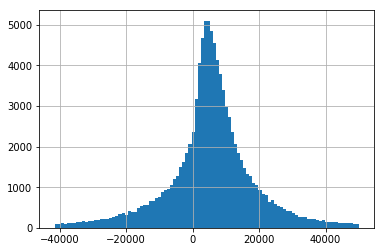

In [120]:
df.query("-50000<Delta_Rbg<50000").Delta_Rbg.hist(bins = 100)

In [121]:
import seaborn as sns

We see that there is something not very smoooth happenning for households without children:

(-10000, 20000)

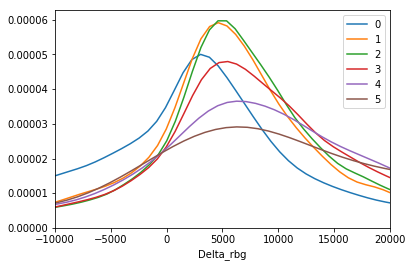

In [122]:
for child in range(0,6):
    sns.distplot(df.query("(-50000<Delta_rbg<50000)&(NBPAC_2011=={})".format(child)).Delta_rbg, hist= False, label = child)
plt.xlim(-10000,20000)

In [123]:
df.shape

(99940, 562)

When getting rid of households with an income tax equal to 0 in 2011, the curve is a lot smoother.
The average change in taxable income is way nearer to the average change for one children than the one we observe when we take out the households which does not have retirement income.

In [124]:
import seaborn as sns

(-10000, 20000)

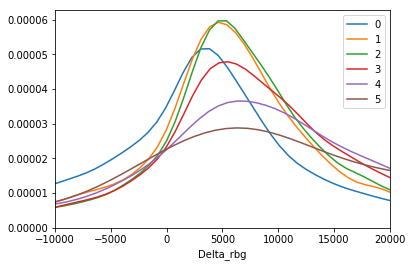

In [125]:
for child in range(0,6):
    sns.distplot(df.query("(-50000<Delta_rbg<50000)&(NBPAC_2011=={})& (ZPERM_2011==0)".format(child)).Delta_rbg, hist= False, label = child)
plt.xlim(-10000,20000)

In [126]:
df["Below_thresholds"] = ~(df["Between_thresholds"] | df["Over_threshold"])

In [127]:
print(df.query("(NBPAC_2011==2)&(Between_thresholds)").shape)
print(df.query("(NBPAC_2011==2)&(Over_threshold)").shape)

(5986, 563)
(10001, 563)


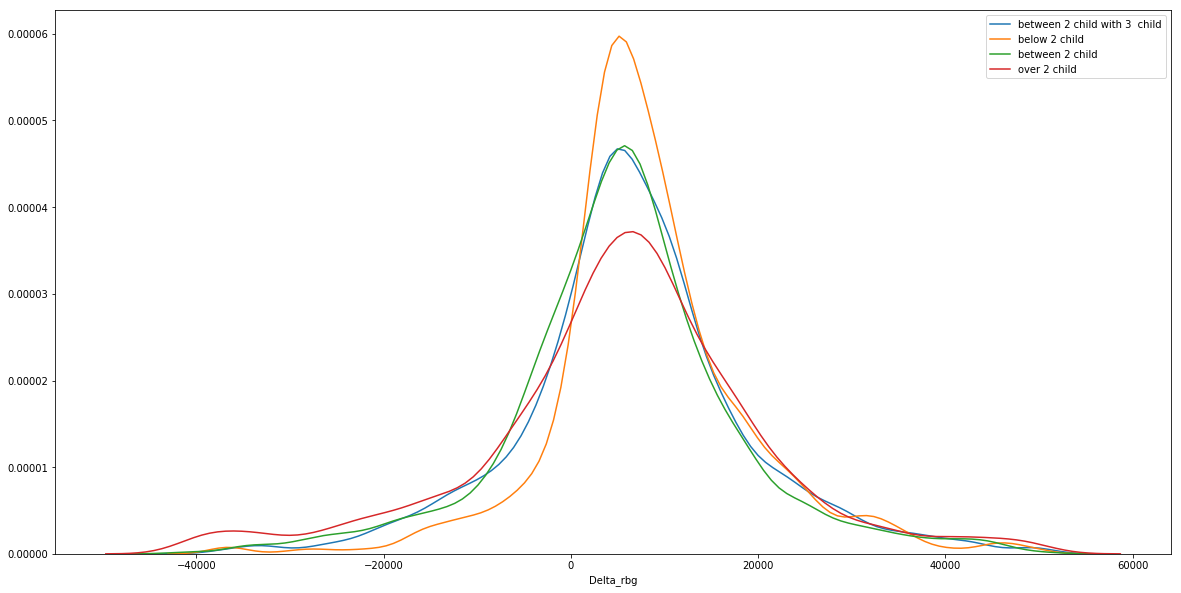

In [128]:
plt.figure(figsize=(20,10))
sns.distplot(df.query("(-50000<Delta_rbg<50000)&(NBPAC_2011=={})& (ZPERM_2011==0)& Between_threshold_2_child".format(3)).Delta_rbg.sample(1000), hist= False, label = "between 2 child with 3  child")
for child in [2]:
    sns.distplot(df.query("(-50000<Delta_rbg<50000)&(NBPAC_2011=={})& (ZPERM_2011==0)& Below_thresholds".format(child)).Delta_rbg.sample(1000), hist= False, label = "below 2 child")
    sns.distplot(df.query("(-50000<Delta_rbg<50000)&(NBPAC_2011=={})& (ZPERM_2011==0)& Between_thresholds".format(child)).Delta_rbg.sample(1000), hist= False, label = "between 2 child")
    sns.distplot(df.query("(-50000<Delta_rbg<50000)&(NBPAC_2011=={})& (ZPERM_2011==0)& Over_threshold & ~(Over_threshold_3_child)".format(child)).Delta_rbg.sample(1000), hist= False, label = "over 2 child")
#plt.xlim(-10000,20000)

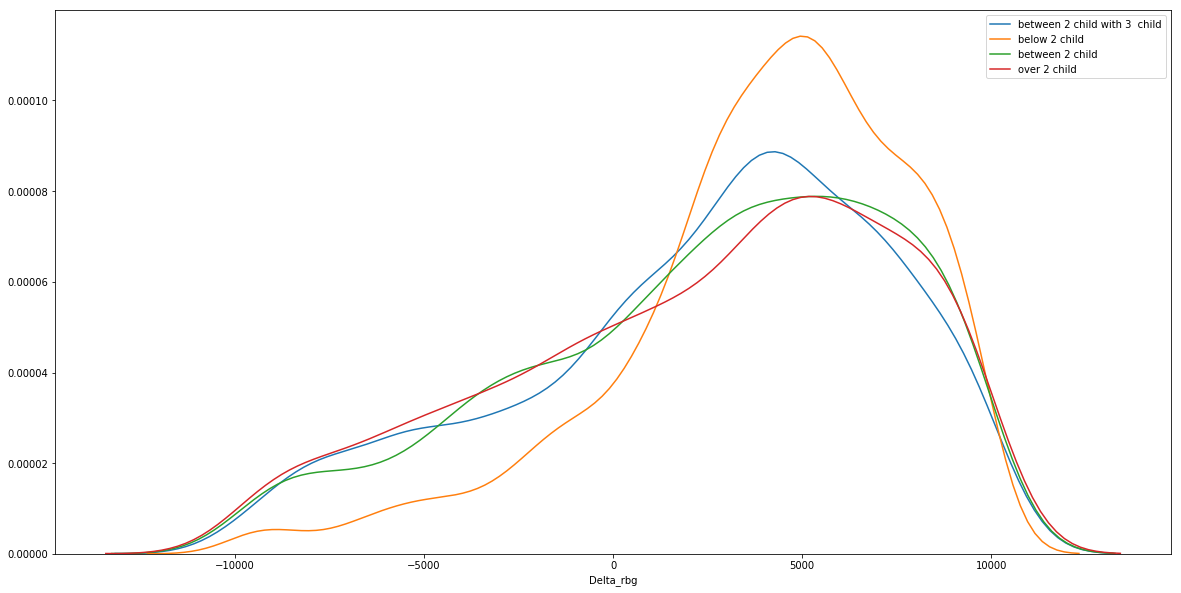

In [129]:
start = -10_000
stop = 10_000
plt.figure(figsize=(20,10))
sns.distplot(df.query("(@start<Delta_rbg<@stop)&(NBPAC_2011=={})& (ZPERM_2011==0)& Between_threshold_2_child".format(3)).Delta_rbg.sample(2500, replace = True), hist= False, label = "between 2 child with 3  child")
for child in [2]:
    sns.distplot(df.query("(@start<Delta_rbg<@stop)&(NBPAC_2011=={})& (ZPERM_2011==0)& Below_thresholds".format(child)).Delta_rbg.sample(2500), hist= False, label = "below 2 child")
    sns.distplot(df.query("(@start<Delta_rbg<@stop)&(NBPAC_2011=={})& (ZPERM_2011==0)& Between_thresholds".format(child)).Delta_rbg.sample(2500), hist= False, label = "between 2 child")
    sns.distplot(df.query("(@start<Delta_rbg<@stop)&(NBPAC_2011=={})& (ZPERM_2011==0)& Over_threshold & ~(Over_threshold_3_child)".format(child)).Delta_rbg.sample(2500), hist= False, label = "over 2 child")
#plt.xlim(-10000,20000)

(-10000, 20000)

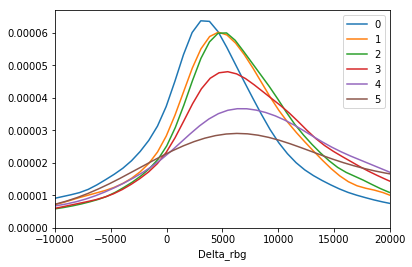

In [130]:
for child in range(0,6):
    sns.distplot(df.query("(-50000<Delta_rbg<50000)&(NBPAC_2011=={})& (ZPERM_2014==0)".format(child)).Delta_rbg, hist= False, label = child)
plt.xlim(-10000,20000)

(-10000, 20000)

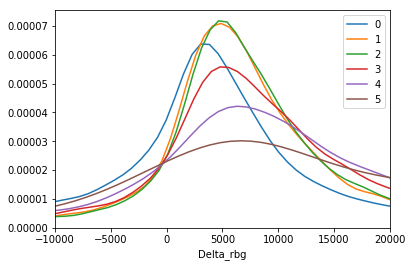

In [131]:
for child in range(0,6):
    sns.distplot(df.query("(-50000<Delta_rbg<50000)&(NBPAC_2011=={})& (ZPERM_2014==0)& (Treatment_0_2011)".format(child)).Delta_rbg, hist= False, label = child)
plt.xlim(-10000,20000)

(-10000, 20000)

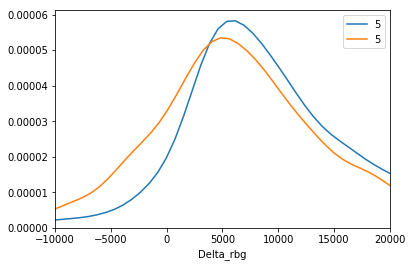

In [132]:
sns.distplot(df.query("(-50000<Delta_rbg<50000)& (Rbg_2014>58291) & (ZPERM_2014==0)& (Treatment_0_2011)".format(child)).Delta_rbg, hist= False, label = child)
sns.distplot(df.query("(-50000<Delta_rbg<50000)& (Rbg_2014>58291) & (ZPERM_2014==0)& (Treatment_1_2011)".format(child)).Delta_rbg, hist= False, label = child)
plt.xlim(-10000,20000)

(-10000, 20000)

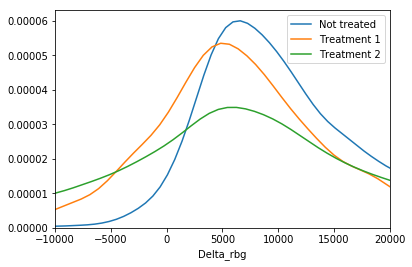

In [133]:
sns.distplot(df.query("(-50000<Delta_rbg<50000)& (Rbg_2014>58291) & (ZPERM_2014==0)& (Treatment_0_2011)&(NBPAC_2011>0)".format(child)).Delta_rbg, hist= False, label = 'Not treated')
sns.distplot(df.query("(-50000<Delta_rbg<50000)& (Rbg_2014>58291) & (ZPERM_2014==0)& (Treatment_1_2011)".format(child)).Delta_rbg, hist= False, label = "Treatment 1")
sns.distplot(df.query("(-50000<Delta_rbg<50000)& (Rbg_2014>58291) & (ZPERM_2014==0)& (Treatment_2_2011)".format(child)).Delta_rbg, hist= False, label = "Treatment 2")
plt.xlim(-10000,20000)

(-10000, 20000)

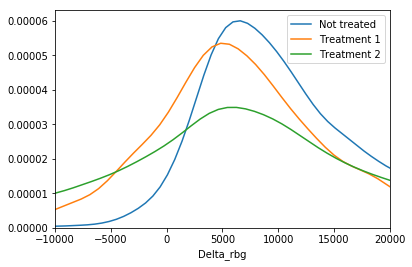

In [134]:
sns.distplot(df.query("(-50000<Delta_rbg<50000)& (Rbg_2014>58291) & (ZPERM_2014==0)& (Treatment_0_2011)&(NBPAC_2011>0)".format(child)).Delta_rbg, hist= False, label = 'Not treated')
sns.distplot(df.query("(-50000<Delta_rbg<50000)& (Rbg_2014>58291) & (ZPERM_2014==0)& (Treatment_1_2011)".format(child)).Delta_rbg, hist= False, label = "Treatment 1")
sns.distplot(df.query("(-50000<Delta_rbg<50000)& (Rbg_2014>58291) & (ZPERM_2014==0)& (Treatment_2_2011)".format(child)).Delta_rbg, hist= False, label = "Treatment 2")
plt.xlim(-10000,20000)

(-10000, 20000)

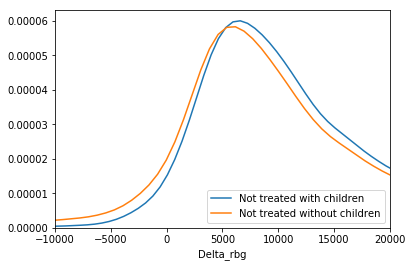

In [135]:
sns.distplot(df.query("(-50000<Delta_rbg<50000)& (Rbg_2014>58291) & (ZPERM_2014==0)& (Treatment_0_2011)&(NBPAC_2011>0)".format(child)).Delta_rbg, hist= False, label = 'Not treated with children')
sns.distplot(df.query("(-50000<Delta_rbg<50000)& (Rbg_2014>58291) & (ZPERM_2014==0)& (Treatment_0_2011)".format(child)).Delta_rbg, hist= False, label = "Not treated without children")
plt.xlim(-10000,20000)

In [136]:
threshold_byr_rbg

,2011,2014
nb_enf,,
1,63233,58291
2,73516,63530
3,94451,73806
4,115185,84103
5,135941,94368
6,150684,104633


In [137]:
for child in range(0,7):
    df["child_{}".format(child)] = df.NBPAC_2011 == child

In [138]:
print(df.query("NBPAC_2011==0").Delta_Rbg.mean())
print(df.query("child_1==True").Delta_Rbg.mean())
print(df.query("child_2==True").Delta_Rbg.mean())
print(df.query("child_3==True").Delta_Rbg.mean())
print(df.query("child_4==True").Delta_Rbg.mean())
print(df.query("child_5==True").Delta_Rbg.mean())
print(df.query("child_6==True").Delta_Rbg.mean())

1299.91721718044
5729.791861567646
6927.619137903427
8170.622921879328
8607.796547688706
9231.572020725385
nan


In [139]:
print(df.query("(Between_threshold_1_child==True)").Delta_Rbg.mean())
print(df.query("Between_threshold_2_child==True").Delta_Rbg.mean())
print(df.query("Between_threshold_3_child==True").Delta_Rbg.mean())
print(df.query("Between_threshold_4_child==True").Delta_Rbg.mean())
print(df.query("Between_threshold_5_child==True").Delta_Rbg.mean())

2983.438921877898
3292.1374883920507
3604.1386264451435
4006.870328711325
4287.161419984978


In [140]:
df["child_0"] = df.NBPAC_2011==0

In [141]:
df_delta_trimmed = df.query("(-50000<Delta_rbg<50000)")

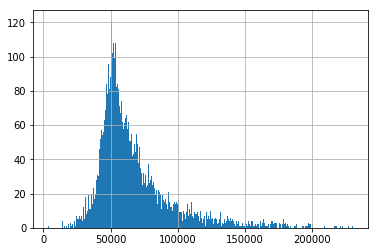

In [142]:
df_delta_trimmed.query("NBPAC_2011==3").Rbg_2011.hist(bins = 1000)


## Double diff 

### Pooled 

In [143]:
m = sm.RLM.from_formula("(Delta_rbg)~   Over_threshold+ Between_thresholds" 
                     
                                                                                            , df)
fit = m.fit()


In [144]:
fit.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Robust linear model
=================================================================================
Model:                      RLM                      Df Residuals:         99937 
Dependent Variable:         Delta_rbg                Norm:                 HuberT
Date:                       2019-03-06 14:35         Scale Est.:           mad   
No. Observations:           99940                    Cov. Type:            H1    
Df Model:                   2                        Scale:                8541.7
---------------------------------------------------------------------------------
                             Coef.   Std.Err.    z     P>|z|    [0.025    0.975] 
---------------------------------------------------------------------------------
Intercept                  5603.8094  39.3174 142.5274 0.0000 5526.7487 5680.8702
Over_threshold[T.True]      258.3662  91.1635   2.8341 0.0046   79.6889  437.0434
Between_thresholds[T.True]    4.3983 115.2051   0.0382 0.9695 -221.3995  230.1961
=================================================================================

"""

In [145]:
m = sm.RLM.from_formula("(Delta_rbg)~   Over_threshold+ Between_thresholds" 
                     
                                                                                            , df.query("NBPAC_2011 > 0".format(child)))
fit = m.fit()
fit.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: Robust linear model
====================================================================================
Model:                       RLM                       Df Residuals:          72720 
Dependent Variable:          Delta_rbg                 Norm:                  HuberT
Date:                        2019-03-06 14:35          Scale Est.:            mad   
No. Observations:            72723                     Cov. Type:             H1    
Df Model:                    2                         Scale:                 8050.1
------------------------------------------------------------------------------------
                             Coef.    Std.Err.    z     P>|z|    [0.025     0.975]  
------------------------------------------------------------------------------------
Intercept                   7497.5654  45.5491 164.6040 0.0000  7408.2908  7586.8400
Over_threshold[T.True]     -1622.7474  88.2636 -18.3852 0.0000 -1795.7409 -1449.7540
Between_thresholds[T.True] -1890.9369 109.4641 -17.2745 0.0000 -2105.4826 -1676.3912
====================================================================================

"""

### By child rank 

In [146]:
children_model_names =["{} children".format(nb_child) for nb_child in range(1,nb_enf_max_for_annalysis+1)]

In [147]:
df.shape

(99940, 563)

In [148]:
or_string = "*"*10 + "Or" + "*"*10
and_string = "\n"+"*"*10 + "And" + "*"*10


In [149]:
print(or_string)
result_fit_list = list()
for child in range(1,nb_enf_max_for_annalysis+1):
    m = sm.RLM.from_formula("(Delta_rbg)~   Over_threshold+ Between_thresholds",
                            df.query("NBPAC_2011 == {}".format(child)))
    fit = m.fit()
    result_fit_list.append(fit)

summary_RLM = summary_col(result_fit_list, model_names =["{} children".format(nb_child) for nb_child in range(1,7)], info_dict=info_dict, stars = True)
summary_RLM.add_title("RLM")

result_fit_list = list()
for child in range(1,nb_enf_max_for_annalysis+1):
    m = sm.OLS.from_formula("(Delta_rbg)~   Over_threshold+ Between_thresholds" 
                     
                                                                                            , df.query("NBPAC_2011 == {}".format(child)))
    fit = m.fit()
    result_fit_list.append(fit)

summary_OLS = summary_col(result_fit_list, stars=True, model_names=children_model_names
                                    , info_dict=info_dict)
summary_OLS.add_title("OLS")
print(summary_RLM, "\n" ,summary_OLS)



print(and_string)
result_fit_list = list()
for child in range(1,nb_enf_max_for_annalysis+1):
    m = sm.RLM.from_formula("(Delta_rbg)~   Over_threshold+ Between_thresholds",
                            df.query(
                                "NBPAC_2011 == {} &((200000>Rbg_2011>50000)&(200000>Rbg_2014>50000))".format(child)
                                    )
                           )
    fit = m.fit()
    result_fit_list.append(fit)

summary_RLM = summary_col(result_fit_list, model_names =["{} children".format(nb_child) for nb_child in range(1,7)], info_dict=info_dict, stars = True)
summary_RLM.add_title("RLM")

result_fit_list = list()
for child in range(1,nb_enf_max_for_annalysis+1):
    m = sm.OLS.from_formula("(Delta_rbg)~   Over_threshold+ Between_thresholds",
                            df.query(
                                "NBPAC_2011 == {} &((200000>Rbg_2011>50000)&(200000>Rbg_2014>50000))".format(child)
                                    )
                           )
    fit = m.fit()
    result_fit_list.append(fit)

summary_OLS = summary_col(result_fit_list, stars=True, model_names=children_model_names
                                    , info_dict=info_dict)
summary_OLS.add_title("OLS")
print(summary_RLM, "\n" ,summary_OLS)

**********Or**********
                                              RLM
                             1 children    2 children   3 children   4 children    5 children  
-----------------------------------------------------------------------------------------------
Intercept                  6884.7274***  7313.2752***  8231.0668*** 9127.2327*** 10653.1262*** 
                           (115.0060)    (55.9306)     (108.2306)   (371.8566)   (1237.7854)   
Over_threshold[T.True]     -2254.1157*** -1143.0825*** -102.0199    -2607.9962** -6544.2748    
                           (178.6509)    (108.7231)    (271.8292)   (1108.8291)  (6153.4601)   
Between_thresholds[T.True] -2924.0523*** -1857.1415*** -787.4072*** -1596.7906*  -10496.6730***
                           (272.2593)    (132.8572)    (268.5793)   (956.9307)   (3774.7382)   
adjusted-R2                                                                                    
N                          12656         43777         14388   

#### Double diff with no child family as control

In [150]:
print(or_string)
df_temp = df
result_fit_list_OLS = list()
result_fit_list_RLM = list()
for child in range(1,nb_enf_max_for_annalysis+1):
    df_temp2 = df_temp.query("((NBPAC_2011 == {})|(NBPAC_2011 == 0))& (Rbg_2011>{})".format(child,threshold_byr_rbg.loc[child,"2014"]) )
    df_temp2["Between_X_child"] = df_temp2["Between_{}_X_{}_child".format(child,child)]
    df_temp2["Over_X_child"] = df_temp2["Over_{}_X_{}_child".format(child,child)]
    df_temp2["Between_threshold_n_child"] = df_temp2["Between_threshold_{}_child".format(child)]
    df_temp2["Over_threshold_n_child"] = df_temp2["Over_threshold_{}_child".format(child)]
    m_OLS = sm.OLS(df_temp2["Delta_Rbg"].astype("float"), df_temp2[["Between_X_child", "Over_X_child", "Intercept"]].astype("float"))
    m_RLM = sm.RLM(df_temp2["Delta_Rbg"].astype("float"), df_temp2[["Between_X_child", "Over_X_child", "Intercept"]].astype("float"))
    fit_OLS = m_OLS.fit(); result_fit_list_OLS.append(fit_OLS)
    fit_RLM = m_RLM.fit(); result_fit_list_RLM.append(fit_RLM)
    
summary_RLM = summary_col(result_fit_list_RLM, info_dict=info_dict, stars=True, model_names = children_model_names); summary_RLM.add_title("RLM")
summary_OLS = summary_col(result_fit_list_OLS, info_dict=info_dict, stars=True, model_names = children_model_names); summary_OLS.add_title("OLS")
print(summary_RLM, "\n" ,summary_OLS)


print(and_string)
df_temp = df.query("(200000>Rbg_2011>50000)&(200000>Rbg_2014>50000)")
result_fit_list_OLS = list()
result_fit_list_RLM = list()
for child in range(1,nb_enf_max_for_annalysis+1):
    df_temp2 = df_temp.query("((NBPAC_2011 == {})|(NBPAC_2011 == 0))& (Rbg_2011>{})".format(child,threshold_byr_rbg.loc[child,"2014"]) )
    df_temp2["Between_X_child"] = df_temp2["Between_{}_X_{}_child".format(child,child)]
    df_temp2["Over_X_child"] = df_temp2["Over_{}_X_{}_child".format(child,child)]
    df_temp2["Between_threshold_n_child"] = df_temp2["Between_threshold_{}_child".format(child)]
    df_temp2["Over_threshold_n_child"] = df_temp2["Over_threshold_{}_child".format(child)]
    m_OLS = sm.OLS(df_temp2["Delta_Rbg"].astype("float"), df_temp2[["Between_X_child", "Over_X_child", "Intercept"]].astype("float"))
    m_RLM = sm.RLM(df_temp2["Delta_Rbg"].astype("float"), df_temp2[["Between_X_child", "Over_X_child", "Intercept"]].astype("float"))
    fit_OLS = m_OLS.fit(); result_fit_list_OLS.append(fit_OLS)
    fit_RLM = m_RLM.fit(); result_fit_list_RLM.append(fit_RLM)
    
summary_RLM = summary_col(result_fit_list_RLM, info_dict=info_dict, stars=True, model_names = children_model_names); summary_RLM.add_title("RLM")
summary_OLS = summary_col(result_fit_list_OLS, info_dict=info_dict, stars=True, model_names = children_model_names); summary_OLS.add_title("OLS")
print(summary_RLM, "\n" ,summary_OLS)

**********Or**********
                                         RLM
                  1 children    2 children    3 children    4 children    5 children 
-------------------------------------------------------------------------------------
Between_X_child 4995.5988***  6622.2977***  8803.2815***  8588.0651***  1724.4633    
                (376.6219)    (234.3546)    (456.5491)    (1358.0214)   (4745.0963)  
Over_X_child    5586.2551***  7246.9156***  9190.6323***  7014.1559***  2929.5097    
                (229.3476)    (202.0720)    (461.5677)    (1596.4870)   (8002.2268)  
Intercept       -1106.1947*** -1215.8694*** -1421.8808*** -1479.6397*** -1402.9866***
                (114.3853)    (140.8110)    (223.4279)    (314.0442)    (398.9730)   
adjusted-R2                                                                          
N               20134         26582         10387         4523          2836         
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01 
            

In [151]:
condition_rbg = "True" #TODO: enelever le condition_rbg des cellules, True pour que ce soit neutre.

In [152]:
no_attached = (df.TYPE_FISC_2014.str.count("[3-9]")<1)&(df.TYPE_FISC_2011.str.count("[3-9]")<1)

In [153]:
print(or_string)
df_temp = df
result_fit_list_OLS = list()
result_fit_list_RLM = list()
for child in range(1,nb_enf_max_for_annalysis+1):
    df_temp2 = df_temp.query("((NBPAC_2011 == {})|(NBPAC_2011 == 0))& (Rbg_2011>{})".format(child,threshold_byr_rbg.loc[child,"2014"]) )
    df_temp2["Between_X_child"] = df_temp2["Between_{}_X_{}_child".format(child,child)]
    df_temp2["Over_X_child"] = df_temp2["Over_{}_X_{}_child".format(child,child)]
    df_temp2["Between_threshold_n_child"] = df_temp2["Between_threshold_{}_child".format(child)]
    df_temp2["Over_threshold_n_child"] = df_temp2["Over_threshold_{}_child".format(child)]
    m_OLS = sm.OLS(df_temp2["Delta_Rbg"].astype("float"), df_temp2[["Between_X_child", "Over_X_child","Between_threshold_n_child","Over_threshold_n_child"]].astype("float"))
    m_RLM = sm.RLM(df_temp2["Delta_Rbg"].astype("float"), df_temp2[["Between_X_child", "Over_X_child","Between_threshold_n_child","Over_threshold_n_child"]].astype("float"))
    
    fit_OLS = m_OLS.fit(); result_fit_list_OLS.append(fit_OLS)
    fit_RLM = m_RLM.fit(); result_fit_list_RLM.append(fit_RLM)
    
summary_RLM = summary_col(result_fit_list_RLM, info_dict=info_dict, stars=True, model_names = children_model_names); summary_RLM.add_title("RLM")
summary_OLS = summary_col(result_fit_list_OLS, info_dict=info_dict, stars=True, model_names = children_model_names); summary_OLS.add_title("OLS")
print(summary_RLM, "\n" ,summary_OLS)

print(and_string)
df_temp = df.query("(200000>Rbg_2011>50000)&(200000>Rbg_2014>50000)")
result_fit_list_OLS = list()
result_fit_list_RLM = list()
for child in range(1,nb_enf_max_for_annalysis+1):
    df_temp2 = df_temp.query("((NBPAC_2011 == {})|(NBPAC_2011 == 0))& (Rbg_2011>{})".format(child,threshold_byr_rbg.loc[child,"2014"]) )
    df_temp2["Between_X_child"] = df_temp2["Between_{}_X_{}_child".format(child,child)]
    df_temp2["Over_X_child"] = df_temp2["Over_{}_X_{}_child".format(child,child)]
    df_temp2["Between_threshold_n_child"] = df_temp2["Between_threshold_{}_child".format(child)]
    df_temp2["Over_threshold_n_child"] = df_temp2["Over_threshold_{}_child".format(child)]
    m_OLS = sm.OLS(df_temp2["Delta_Rbg"].astype("float"), df_temp2[["Between_X_child", "Over_X_child","Between_threshold_n_child","Over_threshold_n_child"]].astype("float"))
    m_RLM = sm.RLM(df_temp2["Delta_Rbg"].astype("float"), df_temp2[["Between_X_child", "Over_X_child","Between_threshold_n_child","Over_threshold_n_child"]].astype("float"))
    
    fit_OLS = m_OLS.fit(); result_fit_list_OLS.append(fit_OLS)
    fit_RLM = m_RLM.fit(); result_fit_list_RLM.append(fit_RLM)
    
summary_RLM = summary_col(result_fit_list_RLM, info_dict=info_dict, stars=True, model_names = children_model_names); summary_RLM.add_title("RLM")
summary_OLS = summary_col(result_fit_list_OLS, info_dict=info_dict, stars=True, model_names = children_model_names); summary_OLS.add_title("OLS")
print(summary_RLM, "\n" ,summary_OLS)

**********Or**********
                                              RLM
                            1 children    2 children    3 children    4 children    5 children 
-----------------------------------------------------------------------------------------------
Between_X_child           4895.5700***  6674.9666***  8919.3369***  8866.5700***  1890.5233    
                          (429.7663)    (293.8693)    (497.6441)    (1371.7728)   (4745.6277)  
Over_X_child              5623.3278***  7207.6628***  9048.9327***  6401.9856***  2505.7905    
                          (237.9546)    (230.9837)    (527.0321)    (1654.6943)   (8026.5752)  
Between_threshold_n_child -1006.2632*** -1268.6512*** -1536.2214*** -1755.3795*** -1583.5670***
                          (236.4131)    (226.4042)    (298.0964)    (381.4702)    (455.9101)   
Over_threshold_n_child    -1143.4439*** -1176.4419*** -1247.4827*** -830.2752     -755.6566    
                          (130.7341)    (179.8459)    (338.1704

In [154]:
df_temp2.query("NBPAC_2011==0")[["Between_threshold_1_child"]].Between_threshold_1_child.value_counts()

False    2716
Name: Between_threshold_1_child, dtype: int64

In [155]:
for child in [1]:
    to_keep_regressors = []
    child_rank_to_include = 0
    for liste in [between_threshold_for_child_rank, over_threshold_for_child_rank, children_number,interaction_child_between_threshold,interaction_child_over_threshold]:
        print(liste[child])
        to_keep_regressors.append(liste[child])

Between_threshold_2_child
Over_threshold_2_child
child_2
child_2:Between_threshold_2_child
child_2:Over_threshold_2_child


#### Double diff with no child family as control

In [156]:
to_keep_regressors = []
child_rank_to_include = 0
df_temp = df.query("NBPAC_2011==NBPAC_2014")
for child in range(1,2):
    to_keep_regressors = []
    child_rank_to_include = 0
    for liste in [between_threshold_for_child_rank, over_threshold_for_child_rank, children_number,interaction_child_between_threshold,interaction_child_over_threshold]:
        to_keep_regressors.append(liste[child-1])
    m = sm.RLM.from_formula("(Delta_rbg)~   {}  ".format(
            ' + '.join( to_keep_regressors)), df_temp.query("(NBPAC_2011 == {})|(NBPAC_2011 == 0)".format(child)))
    fit = m.fit()
    summary = fit.summary(); print(summary)

                    Robust linear Model Regression Results                    
Dep. Variable:              Delta_rbg   No. Observations:                39873
Model:                            RLM   Df Residuals:                    39867
Method:                          IRLS   Df Model:                            5
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 06 Mar 2019                                         
Time:                        14:36:10                                         
No. Iterations:                     8                                         
                                                        coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------

In [157]:
homogenized_variables = ['Intercept',
 'Between_threshold_n_child[T.True]',
 'Over_threshold_n_child[T.True]',
 'child_n[T.True]',
 'child_n[T.True]:Between_threshold_n_child[T.True]',
 'child_n[T.True]:Over_threshold_n_child[T.True]']

In [158]:
print(or_string)
to_keep_regressors = []
child_rank_to_include = 0
df_temp = df
result_fit_list_OLS = list()
result_fit_list_RLM = list()
for child in range(1,nb_enf_max_for_annalysis+1):
    to_keep_regressors = []
    child_rank_to_include = 0
    for liste in [between_threshold_for_child_rank, over_threshold_for_child_rank, children_number,interaction_child_between_threshold,interaction_child_over_threshold]:
        to_keep_regressors.append(liste[child-1])
    m = sm.RLM.from_formula("(Delta_rbg)~   {}  ".format(
            ' + '.join( to_keep_regressors)), df_temp.query("(NBPAC_2011 == {})|(NBPAC_2011 == 0)".format(child)))
    fit = m.fit(); fit.model.exog_names.clear(); fit.model.exog_names.extend(homogenized_variables)
    result_fit_list_RLM.append(fit)
    
    m = sm.OLS.from_formula("(Delta_rbg)~   {}  ".format(
            ' + '.join( to_keep_regressors)), df_temp.query("(NBPAC_2011 == {})|(NBPAC_2011 == 0)".format(child)))
    fit = m.fit(); fit.model.exog_names.clear(); fit.model.exog_names.extend(homogenized_variables)

    result_fit_list_OLS.append(fit)
    
summary_RLM = summary_col(result_fit_list_RLM, info_dict=info_dict, stars=True, model_names = children_model_names); summary_RLM.add_title("RLM")
summary_OLS = summary_col(result_fit_list_OLS, info_dict=info_dict, stars=True, model_names = children_model_names); summary_OLS.add_title("OLS")
print(summary_RLM, "\n" ,summary_OLS)

print(and_string)
to_keep_regressors = []
child_rank_to_include = 0
df_temp = df.query("(200000>Rbg_2011>50000)&(200000>Rbg_2014>50000)")
result_fit_list_OLS = list()
result_fit_list_RLM = list()
for child in range(1,nb_enf_max_for_annalysis+1):
    to_keep_regressors = []
    child_rank_to_include = 0
    for liste in [between_threshold_for_child_rank, over_threshold_for_child_rank, children_number,interaction_child_between_threshold,interaction_child_over_threshold]:
        to_keep_regressors.append(liste[child-1])
    m = sm.RLM.from_formula("(Delta_rbg)~   {}  ".format(
            ' + '.join( to_keep_regressors)), df_temp.query("(NBPAC_2011 == {})|(NBPAC_2011 == 0)".format(child)))
    fit = m.fit(); fit.model.exog_names.clear(); fit.model.exog_names.extend(homogenized_variables)
    result_fit_list_RLM.append(fit)
    
    m = sm.OLS.from_formula("(Delta_rbg)~   {}  ".format(
            ' + '.join( to_keep_regressors)), df_temp.query("(NBPAC_2011 == {})|(NBPAC_2011 == 0)".format(child)))
    fit = m.fit(); fit.model.exog_names.clear(); fit.model.exog_names.extend(homogenized_variables)

    result_fit_list_OLS.append(fit)
    
summary_RLM = summary_col(result_fit_list_RLM, info_dict=info_dict, stars=True, model_names = children_model_names); summary_RLM.add_title("RLM")
summary_OLS = summary_col(result_fit_list_OLS, info_dict=info_dict, stars=True, model_names = children_model_names); summary_OLS.add_title("OLS")
print(summary_RLM, "\n" ,summary_OLS)

**********Or**********
                                                          RLM
                                                    1 children    2 children    3 children    4 children    5 children 
-----------------------------------------------------------------------------------------------------------------------
Intercept                                         3861.9782***  2900.9031***  2138.8212***  1852.7264***  1737.7061*** 
                                                  (97.6368)     (80.6157)     (81.9759)     (81.0410)     (78.4531)    
Between_threshold_n_child[T.True]                 -4713.1150*** -3780.8539*** -3102.0374*** -2828.8714*** -2497.4528***
                                                  (218.3225)    (181.2534)    (213.3054)    (247.2325)    (275.9099)   
Over_threshold_n_child[T.True]                    -4749.6715*** -3635.2208*** -2893.3480*** -2327.7676*** -2569.7473***
                                                  (145.5801)    (152.0799) 

In [159]:
df.query(
                                                                    "(NBPAC_2011 == {})".format(1)).child_1.value_counts()

True    12656
Name: child_1, dtype: int64

In [160]:
map(between_threshold_for_child_rank.__getitem__,(0,1,2))

In [161]:
to_keep_regressors

['Between_threshold_5_child',
 'Over_threshold_5_child',
 'child_5',
 'child_5:Between_threshold_5_child',
 'child_5:Over_threshold_5_child']

In [162]:
homogenized_variables =  ["Intercept",
                          'Between_threshold_n_child[T.True]',
                          'Over_threshold_n_child[T.True]',]

In [163]:
to_keep_regressors = []
child_rank_to_include = 0
result_fit_list_OLS = list()
result_fit_list_RLM = list()

for child in range(1,nb_enf_max_for_annalysis+1):
    to_keep_regressors = []
    child_rank_to_include = 0
    for liste in [between_threshold_for_child_rank, over_threshold_for_child_rank]:
        to_keep_regressors.append(liste[child-1])
    m = sm.OLS.from_formula("(Delta_rbg)~   {} - child_{}".format(
            ' + '.join( to_keep_regressors), child), df.query(
                                                                    "(NBPAC_2011 == {})".format(child)))
    fit = m.fit()
    fit.model.exog_names.clear(); fit.model.exog_names.extend(homogenized_variables)
    result_fit_list_OLS.append(fit)
summary_OLS = summary_col(result_fit_list_OLS, info_dict=info_dict, stars=True, model_names = children_model_names); summary_OLS.add_title("OLS")

print(summary_OLS)


                                                  OLS
                                    1 children    2 children    3 children    4 children    5 children  
--------------------------------------------------------------------------------------------------------
Intercept                         7315.5293***  7748.2003***  8536.8218***  9354.2505***  10652.3729*** 
                                  (150.3511)    (73.5721)     (131.9557)    (419.7926)    (1274.9750)   
Between_threshold_n_child[T.True] -3487.6394*** -2472.0334*** -1262.9505*** -2417.3367**  -10973.6379***
                                  (355.9336)    (174.7628)    (327.4544)    (1080.2887)   (3888.1513)   
Over_threshold_n_child[T.True]    -3242.7990*** -2112.2879*** -1387.1671*** -4291.8691*** -7820.2586    
                                  (233.5562)    (143.0163)    (331.4166)    (1251.7683)   (6338.3426)   
adjusted-R2                       1.78%         0.77%         0.18%         0.76%         3.55%         
N

In [164]:
print(or_string)
to_keep_regressors = []
child_rank_to_include = 0
result_fit_list_OLS = list()
result_fit_list_RLM = list()
for child in range(1,nb_enf_max_for_annalysis+1):
    to_keep_regressors = []
    child_rank_to_include = 0
    for liste in [between_threshold_for_child_rank, over_threshold_for_child_rank]:
        to_keep_regressors.append(liste[child-1])
    m = sm.OLS.from_formula("(Delta_rbg)~   {} - child_{}".format(
            ' + '.join( to_keep_regressors), child), df.query(
                                                                    "(NBPAC_2011 == {})".format(child)))
    fit = m.fit()
    fit.model.exog_names.clear(); fit.model.exog_names.extend(homogenized_variables)
    result_fit_list_OLS.append(fit)
for child in range(1,nb_enf_max_for_annalysis+1):
    to_keep_regressors = []
    child_rank_to_include = 0
    for liste in [between_threshold_for_child_rank, over_threshold_for_child_rank]:
        to_keep_regressors.append(liste[child-1])
    m = sm.RLM.from_formula("(Delta_rbg)~   {} - child_{}".format(
            ' + '.join( to_keep_regressors), child), df.query(
                                                                    "(NBPAC_2011 == {})".format(child)))
    fit = m.fit()
    fit.model.exog_names.clear(); fit.model.exog_names.extend(homogenized_variables)
    result_fit_list_RLM.append(fit)
summary_RLM = summary_col(result_fit_list_RLM, info_dict=info_dict, stars=True, model_names = children_model_names); summary_RLM.add_title("RLM")
summary_OLS = summary_col(result_fit_list_OLS, info_dict=info_dict, stars=True, model_names = children_model_names); summary_OLS.add_title("OLS")
print(summary_RLM, "\n" ,summary_OLS)


print(and_string)
to_keep_regressors = []
child_rank_to_include = 0
result_fit_list_OLS = list()
result_fit_list_RLM = list()
for child in range(1,nb_enf_max_for_annalysis+1):
    to_keep_regressors = []
    child_rank_to_include = 0
    for liste in [between_threshold_for_child_rank, over_threshold_for_child_rank]:
        to_keep_regressors.append(liste[child-1])
    m = sm.OLS.from_formula("(Delta_rbg)~   {} - child_{}".format(
            ' + '.join( to_keep_regressors), child), df.query(
                                                                    "(NBPAC_2011 == {})&(200000>Rbg_2011>50000)&(200000>Rbg_2014>50000)".format(child)))
    fit = m.fit()
    fit.model.exog_names.clear(); fit.model.exog_names.extend(homogenized_variables)
    result_fit_list_OLS.append(fit)
for child in range(1,nb_enf_max_for_annalysis+1):
    to_keep_regressors = []
    child_rank_to_include = 0
    for liste in [between_threshold_for_child_rank, over_threshold_for_child_rank]:
        to_keep_regressors.append(liste[child-1])
    m = sm.RLM.from_formula("(Delta_rbg)~   {} - child_{}".format(
            ' + '.join( to_keep_regressors), child), df.query(
                                                                    "(NBPAC_2011 == {})&(200000>Rbg_2011>50000)&(200000>Rbg_2014>50000)".format(child)))
    fit = m.fit()
    fit.model.exog_names.clear(); fit.model.exog_names.extend(homogenized_variables)
    result_fit_list_RLM.append(fit)
summary_RLM = summary_col(result_fit_list_RLM, info_dict=info_dict, stars=True, model_names = children_model_names); summary_RLM.add_title("RLM")
summary_OLS = summary_col(result_fit_list_OLS, info_dict=info_dict, stars=True, model_names = children_model_names); summary_OLS.add_title("OLS")
print(summary_RLM, "\n" ,summary_OLS)


**********Or**********
                                                 RLM
                                    1 children    2 children   3 children   4 children    5 children  
------------------------------------------------------------------------------------------------------
Intercept                         6884.7274***  7313.2752***  8231.0668*** 9127.2327*** 10653.1262*** 
                                  (115.0060)    (55.9306)     (108.2306)   (371.8566)   (1237.7854)   
Between_threshold_n_child[T.True] -2924.0523*** -1857.1415*** -787.4072*** -1596.7906*  -10496.6730***
                                  (272.2593)    (132.8572)    (268.5793)   (956.9307)   (3774.7382)   
Over_threshold_n_child[T.True]    -2254.1157*** -1143.0825*** -102.0199    -2607.9962** -6544.2748    
                                  (178.6509)    (108.7231)    (271.8292)   (1108.8291)  (6153.4601)   
adjusted-R2                                                                                         

In [165]:
## Just to show where the above tables come from
to_keep_regressors = []
child_rank_to_include = 0
for child in range(1,3):
    to_keep_regressors = []
    child_rank_to_include = 0
    for liste in [between_threshold_for_child_rank, over_threshold_for_child_rank]:
        to_keep_regressors.append(liste[child-1])
    m = sm.OLS.from_formula("(Delta_rbg)~   {} - child_{}".format(
            ' + '.join( to_keep_regressors), child), df.query(
                                                                    "(NBPAC_2011 == {})".format(child)))
    fit = m.fit()
    summary = fit.summary(); print(summary)
    
to_keep_regressors = []

                            OLS Regression Results                            
Dep. Variable:              Delta_rbg   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     116.0
Date:                Wed, 06 Mar 2019   Prob (F-statistic):           1.23e-50
Time:                        14:36:25   Log-Likelihood:            -1.3703e+05
No. Observations:               12656   AIC:                         2.741e+05
Df Residuals:                   12653   BIC:                         2.741e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

### Trends for households without children on income location

In [166]:

print(or_string)
to_keep_regressors = []
child_rank_to_include = 0
result_fit_list_OLS = list()
result_fit_list_RLM = list()
for child in range(1,nb_enf_max_for_annalysis+1):
    to_keep_regressors = []
    child_rank_to_include = 0
    for liste in [between_threshold_for_child_rank, over_threshold_for_child_rank]:
        to_keep_regressors.append(liste[child-1])
    m = sm.OLS.from_formula("(Delta_rbg)~   {} - child_{}".format(
            ' + '.join( to_keep_regressors), child), df.query(
                                                                    "(NBPAC_2011 == 0)".format(child)))
    fit = m.fit()
    fit.model.exog_names.clear(); fit.model.exog_names.extend(homogenized_variables)
    result_fit_list_OLS.append(fit)
for child in range(1,nb_enf_max_for_annalysis+1):
    to_keep_regressors = []
    child_rank_to_include = 0
    for liste in [between_threshold_for_child_rank, over_threshold_for_child_rank]:
        to_keep_regressors.append(liste[child-1])
    m = sm.RLM.from_formula("(Delta_rbg)~   {} - child_{}".format(
            ' + '.join( to_keep_regressors), child), df.query(
                                                                    "(NBPAC_2011 == 0)".format(child)))
    fit = m.fit()
    fit.model.exog_names.clear(); fit.model.exog_names.extend(homogenized_variables)
    result_fit_list_RLM.append(fit)
summary_RLM = summary_col(result_fit_list_RLM, info_dict=info_dict, stars=True, model_names = children_model_names); summary_RLM.add_title("RLM")
summary_OLS = summary_col(result_fit_list_OLS, info_dict=info_dict, stars=True, model_names = children_model_names); summary_OLS.add_title("OLS")
print(summary_RLM, "\n" ,summary_OLS)


print(and_string)
to_keep_regressors = []
child_rank_to_include = 0
result_fit_list_OLS = list()
result_fit_list_RLM = list()
for child in range(1,nb_enf_max_for_annalysis+1):
    to_keep_regressors = []
    child_rank_to_include = 0
    for liste in [between_threshold_for_child_rank, over_threshold_for_child_rank]:
        to_keep_regressors.append(liste[child-1])
    m = sm.OLS.from_formula("(Delta_rbg)~   {} - child_{}".format(
            ' + '.join( to_keep_regressors), child), df.query(
                                                                    "(NBPAC_2011 == 0)&(200000>Rbg_2011>50000)&(200000>Rbg_2014>50000)".format(child)))
    fit = m.fit()
    fit.model.exog_names.clear(); fit.model.exog_names.extend(homogenized_variables)
    result_fit_list_OLS.append(fit)
for child in range(1,nb_enf_max_for_annalysis+1):
    to_keep_regressors = []
    child_rank_to_include = 0
    for liste in [between_threshold_for_child_rank, over_threshold_for_child_rank]:
        to_keep_regressors.append(liste[child-1])
    m = sm.RLM.from_formula("(Delta_rbg)~   {} - child_{}".format(
            ' + '.join( to_keep_regressors), child), df.query(
                                                                    "(NBPAC_2011 == 0)&(200000>Rbg_2011>50000)&(200000>Rbg_2014>50000)".format(child)))
    fit = m.fit()
    fit.model.exog_names.clear(); fit.model.exog_names.extend(homogenized_variables)
    result_fit_list_RLM.append(fit)
summary_RLM = summary_col(result_fit_list_RLM, info_dict=info_dict, stars=True, model_names = children_model_names); summary_RLM.add_title("RLM")
summary_OLS = summary_col(result_fit_list_OLS, info_dict=info_dict, stars=True, model_names = children_model_names); summary_OLS.add_title("OLS")
print(summary_RLM, "\n" ,summary_OLS)


**********Or**********
                                                  RLM
                                    1 children    2 children    3 children    4 children    5 children 
-------------------------------------------------------------------------------------------------------
Intercept                         3876.3709***  2886.6356***  2128.2335***  1856.1829***  1738.9758*** 
                                  (105.4006)    (94.6821)     (84.9692)     (80.6378)     (78.2483)    
Between_threshold_n_child[T.True] -4798.6003*** -3981.9420*** -3135.8896*** -2821.0052*** -2494.1765***
                                  (235.6829)    (212.8797)    (221.0942)    (246.0025)    (275.1894)   
Over_threshold_n_child[T.True]    -4884.0861*** -3847.1598*** -2925.9303*** -2323.5148*** -2571.9357***
                                  (157.1562)    (178.6158)    (246.6521)    (343.8451)    (481.5294)   
adjusted-R2                                                                                

In [167]:
from operator import itemgetter
import itertools

In [168]:
itemgetter(0,2,3)(between_threshold_for_child_rank)

('Between_threshold_1_child',
 'Between_threshold_3_child',
 'Between_threshold_4_child')

## Pooled estimation with Treatment one, or two.

In [169]:
df.Treatment_1_2011.value_counts()

False    90255
True      9685
Name: Treatment_1_2011, dtype: int64

In [170]:
m = sm.OLS.from_formula("(Delta_rbg)~ Between_thresholds + Over_threshold".format( 
        ' + '.join(cumulative_child_bool_list+thrsh_bool_list)),
        df)
fit = m.fit()
summary = fit.summary(); print(summary)

                            OLS Regression Results                            
Dep. Variable:              Delta_rbg   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.4299
Date:                Wed, 06 Mar 2019   Prob (F-statistic):              0.651
Time:                        14:36:31   Log-Likelihood:            -1.0907e+06
No. Observations:               99940   AIC:                         2.181e+06
Df Residuals:                   99937   BIC:                         2.181e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [171]:
m = sm.RLM.from_formula("(Delta_rbg)~ Between_thresholds + Over_threshold",
        df)
rlm_fit = m.fit()

m = sm.OLS.from_formula("(Delta_rbg)~ Between_thresholds + Over_threshold",
        df)
ols_fit = m.fit()



m = sm.RLM.from_formula("(Delta_rbg)~ Between_thresholds + Over_threshold",
        df)
rlm_fit = m.fit()
summary_or = summary_col([rlm_fit, ols_fit], info_dict=info_dict, stars=True, model_names = ["RLM", "OLS"]); summary_or.add_title("Or")

m = sm.OLS.from_formula("(Delta_rbg)~ Between_thresholds + Over_threshold",
        df.query("(200000>Rbg_2011>50000)&(200000>Rbg_2014>50000)"))
ols_fit = m.fit()
                        
        
m = sm.RLM.from_formula("(Delta_rbg)~ Between_thresholds + Over_threshold",
         df.query("(200000>Rbg_2011>50000)&(200000>Rbg_2014>50000)"))
rlm_fit = m.fit()          
summary_and = summary_col([rlm_fit, ols_fit], info_dict=info_dict, stars=True, model_names = ["RLM", "OLS"]); summary_and.add_title("And")
                        
print(summary_or, "\n" ,summary_and)

                         Or
                               RLM          OLS     
----------------------------------------------------
Intercept                  5603.8094*** 5467.5443***
                           (39.3174)    (49.0357)   
Between_thresholds[T.True] 4.3983       39.7257     
                           (115.2051)   (143.6809)  
Over_threshold[T.True]     258.3662***  -94.9075    
                           (91.1635)    (113.6969)  
adjusted-R2                             -0.00%      
N                          99940        99940       
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01 
                         And
                               RLM          OLS     
----------------------------------------------------
Intercept                  4638.6782*** 4823.4001***
                           (44.9374)    (58.5263)   
Between_thresholds[T.True] 1585.0310*** 1973.7449***
                           (106.8237)   (139.1266)  
Over_threshold[T.True]     1335.675

###Add controls for trends

In [172]:
m = sm.RLM.from_formula("(Delta_rbg)~ Treatment_1_2011 + Treatment_2_2011 +{}".format( #
        ' + '.join(thrsh_bool_list)),
        df)
rlm_fit = m.fit()

m = sm.OLS.from_formula("(Delta_rbg)~ Treatment_1_2011 + Treatment_2_2011 +{}".format( #
        ' + '.join(thrsh_bool_list)),
        df)
ols_fit = m.fit()



m = sm.RLM.from_formula("(Delta_rbg)~ Treatment_1_2011 + Treatment_2_2011 +{}".format( #
        ' + '.join(thrsh_bool_list)),
        df)
rlm_fit = m.fit()
summary_or = summary_col([rlm_fit, ols_fit], info_dict=info_dict, stars=True, model_names = ["RLM", "OLS"]); summary_or.add_title("Or")

m = sm.OLS.from_formula("(Delta_rbg)~ Treatment_1_2011 + Treatment_2_2011 +{}".format( #
        ' + '.join(thrsh_bool_list)),
        df.query("(200000>Rbg_2011>50000)&(200000>Rbg_2014>50000)"))
ols_fit = m.fit()
                        
        
m = sm.RLM.from_formula("(Delta_rbg)~ Treatment_1_2011 + Treatment_2_2011 +{}".format( #
        ' + '.join(thrsh_bool_list)),
         df.query("(200000>Rbg_2011>50000)&(200000>Rbg_2014>50000)"))
rlm_fit = m.fit()          
summary_and = summary_col([rlm_fit, ols_fit], info_dict=info_dict, stars=True, model_names = ["RLM", "OLS"]); summary_and.add_title("And")
                        
print(summary_or, "\n" ,summary_and)

                         Or
                              RLM           OLS     
----------------------------------------------------
Intercept                6996.0469***  7376.4659*** 
                         (46.9503)     (57.9859)    
Treatment_1_2011[T.True] 4236.5966***  4786.8607*** 
                         (136.4132)    (168.4769)   
Treatment_2_2011[T.True] 4727.8376***  5155.7092*** 
                         (131.9085)    (162.9134)   
Threshold_58291[T.True]  -4296.1398*** -5027.2482***
                         (113.5521)    (140.2423)   
Threshold_63233[T.True]  175.5530      175.9218     
                         (455.0558)    (562.0160)   
Threshold_63530[T.True]  -1701.9180*** -1933.2217***
                         (455.7367)    (562.8570)   
Threshold_73516[T.True]  -388.9932     114.8597     
                         (623.3636)    (769.8843)   
Threshold_73806[T.True]  -72.7884      -674.6061    
                         (624.7094)    (771.5465)   
Threshold_84103[T.

In [173]:
m = sm.OLS.from_formula("(Delta_rbg)~ Treatment_1_2011 + Treatment_2_2011 +{}".format(
        ' + '.join(thrsh_bool_list)),df)
fit = m.fit()
summary = fit.summary(); print(summary)

                            OLS Regression Results                            
Dep. Variable:              Delta_rbg   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     264.1
Date:                Wed, 06 Mar 2019   Prob (F-statistic):               0.00
Time:                        14:36:48   Log-Likelihood:            -1.0889e+06
No. Observations:               99940   AIC:                         2.178e+06
Df Residuals:                   99925   BIC:                         2.178e+06
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

### Double diff children

In [174]:
m = sm.OLS.from_formula("(Delta_rbg)~ Treatment_1_2011 + Treatment_2_2011 +{}".format(
        ' + '.join(child_bool_list)), df)
fit = m.fit()
summary = fit.summary(); print(summary)

                            OLS Regression Results                            
Dep. Variable:              Delta_rbg   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     660.2
Date:                Wed, 06 Mar 2019   Prob (F-statistic):               0.00
Time:                        14:36:50   Log-Likelihood:            -1.0885e+06
No. Observations:               99940   AIC:                         2.177e+06
Df Residuals:                   99932   BIC:                         2.177e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [175]:
m = sm.RLM.from_formula("(Delta_rbg)~ Treatment_1_2011 + Treatment_2_2011 +{}".format( #
        ' + '.join(child_bool_list)),
        df)
rlm_fit = m.fit()

m = sm.OLS.from_formula("(Delta_rbg)~ Treatment_1_2011 + Treatment_2_2011 +{}".format( #
        ' + '.join(child_bool_list)),
        df)
ols_fit = m.fit()



m = sm.RLM.from_formula("(Delta_rbg)~ Treatment_1_2011 + Treatment_2_2011 +{}".format( #
        ' + '.join(child_bool_list)),
        df)
rlm_fit = m.fit()
summary_or = summary_col([rlm_fit, ols_fit], info_dict=info_dict, stars=True, model_names = ["RLM", "OLS"]); summary_or.add_title("Or")

m = sm.OLS.from_formula("(Delta_rbg)~ Treatment_1_2011 + Treatment_2_2011 +{}".format( #
        ' + '.join(child_bool_list)),
        df.query("(200000>Rbg_2011>50000)&(200000>Rbg_2014>50000)"))
ols_fit = m.fit()
                        
        
m = sm.RLM.from_formula("(Delta_rbg)~ Treatment_1_2011 + Treatment_2_2011 +{}".format( #
        ' + '.join(child_bool_list)),
         df.query("(200000>Rbg_2011>50000)&(200000>Rbg_2014>50000)"))
rlm_fit = m.fit()          
summary_and = summary_col([rlm_fit, ols_fit], info_dict=info_dict, stars=True, model_names = ["RLM", "OLS"]); summary_and.add_title("And")
                        
print(summary_or, "\n" ,summary_and)

                         Or
                              RLM           OLS     
----------------------------------------------------
Intercept                1654.8557***  1299.9172*** 
                         (63.0863)     (78.7653)    
Treatment_1_2011[T.True] -1861.9074*** -2381.8651***
                         (116.3272)    (145.2383)   
Treatment_2_2011[T.True] -1367.7060*** -2276.9870***
                         (95.2606)     (118.9360)   
child_1[T.True]          4841.8400***  5535.7631*** 
                         (118.8873)    (148.4347)   
child_2[T.True]          5738.4496***  6473.5797*** 
                         (85.6093)     (106.8860)   
child_3[T.True]          6791.3350***  7515.1160*** 
                         (109.6986)    (136.9623)   
child_4[T.True]          7321.2138***  7853.7859*** 
                         (260.3116)    (325.0074)   
child_5[T.True]          7854.9839***  8261.0652*** 
                         (751.9311)    (938.8103)   
adjusted-R2       

## DD or pooled triple diff

In [176]:
m = sm.OLS.from_formula("(Delta_rbg)~ Treatment_1_2011 + Treatment_2_2011 +  {} ".format(
        ' + '.join(child_bool_list+between_threshold_for_child_rank+over_threshold_for_child_rank)),
        df)
fit = m.fit()
summary = fit.summary(); print(summary)

                            OLS Regression Results                            
Dep. Variable:              Delta_rbg   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     380.7
Date:                Wed, 06 Mar 2019   Prob (F-statistic):               0.00
Time:                        14:36:55   Log-Likelihood:            -1.0876e+06
No. Observations:               99940   AIC:                         2.175e+06
Df Residuals:                   99922   BIC:                         2.175e+06
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

In [177]:
m = sm.RLM.from_formula("(Delta_rbg)~ Treatment_1_2011 + Treatment_2_2011 +{}".format( #
        ' + '.join(child_bool_list+between_threshold_for_child_rank+over_threshold_for_child_rank)),
        df)
rlm_fit = m.fit()

m = sm.OLS.from_formula("(Delta_rbg)~ Treatment_1_2011 + Treatment_2_2011 +{}".format( #
        ' + '.join(child_bool_list+between_threshold_for_child_rank+over_threshold_for_child_rank)),
        df)
ols_fit = m.fit()



m = sm.RLM.from_formula("(Delta_rbg)~ Treatment_1_2011 + Treatment_2_2011 +{}".format( #
        ' + '.join(child_bool_list+between_threshold_for_child_rank+over_threshold_for_child_rank)),
        df)
rlm_fit = m.fit()
summary_or = summary_col([rlm_fit, ols_fit], info_dict=info_dict, stars=True, model_names = ["RLM", "OLS"]); summary_or.add_title("Or")

m = sm.OLS.from_formula("(Delta_rbg)~ Treatment_1_2011 + Treatment_2_2011 +{}".format( #
        ' + '.join(child_bool_list+between_threshold_for_child_rank+over_threshold_for_child_rank)),
        df.query("(200000>Rbg_2011>50000)&(200000>Rbg_2014>50000)"))
ols_fit = m.fit()
                        
        
m = sm.RLM.from_formula("(Delta_rbg)~ Treatment_1_2011 + Treatment_2_2011 +{}".format( #
        ' + '.join(child_bool_list+between_threshold_for_child_rank+over_threshold_for_child_rank)),
         df.query("(200000>Rbg_2011>50000)&(200000>Rbg_2014>50000)"))
rlm_fit = m.fit()          
summary_and = summary_col([rlm_fit, ols_fit], info_dict=info_dict, stars=True, model_names = ["RLM", "OLS"]); summary_and.add_title("And")
                        
print(summary_or, "\n" ,summary_and)

                             Or
                                       RLM           OLS     
-------------------------------------------------------------
Intercept                         3481.5044***  3764.5580*** 
                                  (80.5377)     (99.9885)    
Treatment_1_2011[T.True]          1476.6737***  1609.7853*** 
                                  (148.1209)    (183.8938)   
Treatment_2_2011[T.True]          1961.9272***  1941.1040*** 
                                  (158.1663)    (196.3652)   
child_1[T.True]                   3254.8712***  3365.8509*** 
                                  (131.8020)    (163.6337)   
child_2[T.True]                   4525.3132***  4771.4856*** 
                                  (95.0309)     (117.9820)   
child_3[T.True]                   6010.2958***  6360.6444*** 
                                  (112.3405)    (139.4721)   
child_4[T.True]                   6792.1827***  7058.7657*** 
                                  (260

#### With flatten thresholds

,2011,2014
nb_enf,,
1,63233,58291
2,73516,63530
3,94451,73806
4,115185,84103
5,135941,94368


In [179]:
threshold_byr_rbg.iloc[0:nb_enf_max_for_annalysis]
flatten_thresholds = np.sort(threshold_byr_rbg.iloc[0:nb_enf_max_for_annalysis].values.flatten())

In [180]:
flatten_thresholds_list = list()
for counter in range(len(flatten_thresholds)-1):
    print(flatten_thresholds[counter], flatten_thresholds[counter+1])
    
    thrsh1, thrsh2 = flatten_thresholds[counter], flatten_thresholds[counter+1]
    flatten_thresholds_list.append("Flatten_thresholds_{}_{}".format(thrsh1, thrsh2))
    df["Flatten_thresholds_{}_{}".format(thrsh1, thrsh2)] = ((df.Rbg_2011>  thrsh1)& (df.Rbg_2011< thrsh2))
df["Flatten_thresholds_more_then_{}".format( thrsh2)] = df.Rbg_2011> thrsh2
flatten_thresholds_list.append("Flatten_thresholds_more_then_{}".format(thrsh2))

58291 63233
63233 63530
63530 73516
73516 73806
73806 84103
84103 94368
94368 94451
94451 115185
115185 135941


In [181]:
spline_thresholds = np.round(np.linspace(50_000,200_000, 10)).astype("int")
spline_thresholds_list = list()
for counter in range(len(spline_thresholds)-1):
    print(spline_thresholds[counter], spline_thresholds[counter+1])
    thrsh1, thrsh2 = spline_thresholds[counter], spline_thresholds[counter+1]
    df["Spline_thresholds_{}_{}".format(thrsh1, thrsh2)] = ((df.Rbg_2011>  thrsh1)& (df.Rbg_2011< thrsh2))
    spline_thresholds_list.append("Spline_thresholds_{}_{}".format(thrsh1, thrsh2))
    
    


50000 66667
66667 83333
83333 100000
100000 116667
116667 133333
133333 150000
150000 166667
166667 183333
183333 200000


In [182]:
m = sm.OLS.from_formula("(Delta_rbg)~ Treatment_1_2011 + Treatment_2_2011 +  {} ".format( #AGERF = Age du référent fiscal
        ' + '.join(child_bool_list+flatten_thresholds_list))
                                                                                        , df)
fit = m.fit()
summary = fit.summary(); print(summary)

                            OLS Regression Results                            
Dep. Variable:              Delta_rbg   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     380.7
Date:                Wed, 06 Mar 2019   Prob (F-statistic):               0.00
Time:                        14:37:10   Log-Likelihood:            -1.0876e+06
No. Observations:               99940   AIC:                         2.175e+06
Df Residuals:                   99922   BIC:                         2.175e+06
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [183]:
m = sm.RLM.from_formula("(Delta_rbg)~ Treatment_1_2011 + Treatment_2_2011 +{}".format( #
        ' + '.join(child_bool_list+flatten_thresholds_list)),
        df)
rlm_fit = m.fit()

m = sm.OLS.from_formula("(Delta_rbg)~ Treatment_1_2011 + Treatment_2_2011 +{}".format( #
        ' + '.join(child_bool_list+flatten_thresholds_list)),
        df)
ols_fit = m.fit()



m = sm.RLM.from_formula("(Delta_rbg)~ Treatment_1_2011 + Treatment_2_2011 +{}".format( #
        ' + '.join(child_bool_list+flatten_thresholds_list)),
        df)
rlm_fit = m.fit()
summary_or = summary_col([rlm_fit, ols_fit], info_dict=info_dict, stars=True, model_names = ["RLM", "OLS"]); summary_or.add_title("Or")

m = sm.OLS.from_formula("(Delta_rbg)~ Treatment_1_2011 + Treatment_2_2011 +{}".format( #
        ' + '.join(child_bool_list+flatten_thresholds_list)),
        df.query("(200000>Rbg_2011>50000)&(200000>Rbg_2014>50000)"))
ols_fit = m.fit()
                        
        
m = sm.RLM.from_formula("(Delta_rbg)~ Treatment_1_2011 + Treatment_2_2011 +{}".format( #
        ' + '.join(child_bool_list+flatten_thresholds_list)),
         df.query("(200000>Rbg_2011>50000)&(200000>Rbg_2014>50000)"))
rlm_fit = m.fit()          
summary_and = summary_col([rlm_fit, ols_fit], info_dict=info_dict, stars=True, model_names = ["RLM", "OLS"]); summary_and.add_title("And")
                        
print(summary_or, "\n" ,summary_and)

                                  Or
                                                 RLM           OLS     
-----------------------------------------------------------------------
Intercept                                   3481.5044***  3764.5580*** 
                                            (80.5377)     (99.9885)    
Treatment_1_2011[T.True]                    1476.6737***  1609.7853*** 
                                            (148.1209)    (183.8938)   
Treatment_2_2011[T.True]                    1961.9272***  1941.1040*** 
                                            (158.1663)    (196.3652)   
child_1[T.True]                             3254.8712***  3365.8509*** 
                                            (131.8020)    (163.6337)   
child_2[T.True]                             4525.3132***  4771.4856*** 
                                            (95.0309)     (117.9820)   
child_3[T.True]                             6010.2958***  6360.6444*** 
                           

In [184]:
flatten_thresholds_list

['Flatten_thresholds_58291_63233',
 'Flatten_thresholds_63233_63530',
 'Flatten_thresholds_63530_73516',
 'Flatten_thresholds_73516_73806',
 'Flatten_thresholds_73806_84103',
 'Flatten_thresholds_84103_94368',
 'Flatten_thresholds_94368_94451',
 'Flatten_thresholds_94451_115185',
 'Flatten_thresholds_115185_135941',
 'Flatten_thresholds_more_then_135941']

In [185]:
# Boum
# for nb_enf in range(1,7):
#     df["Between_threshold_child_rbg_2014"] = np.zeros(df.shape[0])
#     df["Between_threshold_child_rbg_2011"] = np.zeros(df.shape[0])
# for nb_enf in range(1,7): ### in modification
#     df["Between_threshold_child_rbg_2014".format(nb_enf)
#           ] +=(((df.Rbg_2014>  threshold_byr_rbg["2014"].iloc[nb_enf-1])
#                & (df.Rbg_2014< threshold_byr_rbg["2011"].iloc[nb_enf-1])) *( df.NBPAC_2011 == nb_enf)).astype("float")
#     df["Between_threshold_child_rbg_2011".format(nb_enf)
#           ] +=(((df.Rbg_2011>  threshold_byr_rbg["2014"].iloc[nb_enf-1])
#                & (df.Rbg_2011< threshold_byr_rbg["2011"].iloc[nb_enf-1])) *( df.NBPAC_2011 == nb_enf)).astype("float")



# df["Over_threshold_child_rbg_2014"] = np.zeros(df.shape[0])
# df["Over_threshold_child_rbg_2011"] = np.zeros(df.shape[0])
# for nb_enf in range(1,7): ### in modification
#     df["Over_threshold_child_rbg_2014".format(nb_enf)
#           ] +=(((df.Rbg_2014>  threshold_byr_rbg["2014"].iloc[nb_enf-1])
#                & (df.Rbg_2014< threshold_byr_rbg["2011"].iloc[nb_enf-1])) *( df.NBPAC_2011 == nb_enf)).astype("float")
#     df["Over_threshold_child_rbg_2011".format(nb_enf)
#           ] +=(((df.Rbg_2011>  threshold_byr_rbg["2014"].iloc[nb_enf-1])
#                & (df.Rbg_2011< threshold_byr_rbg["2011"].iloc[nb_enf-1])) *( df.NBPAC_2011 == nb_enf)).astype("float")

In [186]:
# df["Between_threshold_child_rbg_2014"] = np.zeros(df.shape[0])
# df["Between_threshold_child_rbg_2011"] = np.zeros(df.shape[0])
# for nb_enf in range(1,7): ### in modification
#     df["Between_threshold_child_rbg_2014".format(nb_enf)
#           ] +=(((df.Rbg_2014>  threshold_byr_rbg["2014"].iloc[nb_enf-1])
#                & (df.Rbg_2014< threshold_byr_rbg["2011"].iloc[nb_enf-1])) *( df.NBPAC_2011 == nb_enf)).astype("float")
#     df["Between_threshold_child_rbg_2011".format(nb_enf)
#           ] +=(((df.Rbg_2011>  threshold_byr_rbg["2014"].iloc[nb_enf-1])
#                & (df.Rbg_2011< threshold_byr_rbg["2011"].iloc[nb_enf-1])) *( df.NBPAC_2011 == nb_enf)).astype("float")



# df["Over_threshold_child_rbg_2014"] = np.zeros(df.shape[0])
# df["Over_threshold_child_rbg_2011"] = np.zeros(df.shape[0])
# for nb_enf in range(1,7): ### in modification
#     df["Over_threshold_child_rbg_2014".format(nb_enf)
#           ] +=(((df.Rbg_2014>  threshold_byr_rbg["2014"].iloc[nb_enf-1])
#                & (df.Rbg_2014< threshold_byr_rbg["2011"].iloc[nb_enf-1])) *( df.NBPAC_2011 == nb_enf)).astype("float")
#     df["Over_threshold_child_rbg_2011".format(nb_enf)
#           ] +=(((df.Rbg_2011>  threshold_byr_rbg["2014"].iloc[nb_enf-1])
#                & (df.Rbg_2011< threshold_byr_rbg["2011"].iloc[nb_enf-1])) *( df.NBPAC_2011 == nb_enf)).astype("float")

In [187]:

for nb_enf in range(1,7):
    df["Below_thresholds_{}_child_rbg_2014".format(nb_enf)] = np.zeros(df.shape[0])
for nb_enf in range(1,7):
    df["Below_thresholds_{}_child_rbg_2014".format(nb_enf)
          ] +=((df.Rbg_2014<  threshold_byr_rbg["2014"].iloc[nb_enf-1])).astype("float")

    


In [188]:
below_threshold_for_child_rank = ["Below_thresholds_{}_child_rbg_2014".format(nb_child) for nb_child in range(1,nb_enf_max_for_annalysis+1)]
interaction_child_below_thresholds  = ["{}:{}".format(child,interaction) for child, interaction in zip(children_number, below_threshold_for_child_rank)]

## Triple diff estimation

In [189]:
#df[over_threshold_for_child_rank+["NBPAC_2011"]]

In [190]:
## & (ZIMPVALM_2011<20) TODO: robustness en montrant que zimpvalm ne change pas grand chose

In [191]:
threshold_byr_rbg

,2011,2014
nb_enf,,
1,63233,58291
2,73516,63530
3,94451,73806
4,115185,84103
5,135941,94368
6,150684,104633


In [192]:
df.shape

(99940, 588)

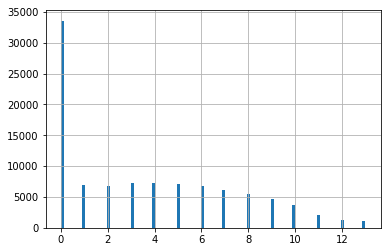

In [193]:
df.Age_youngest_child.hist(bins = 100)

### Classical 

#### On all the population

In [194]:
%run Stat_des_function.ipynb
stat_des_by_treatment_group(df.query("((200000>Rbg_2011>50000)&(200000>Rbg_2014>50000))"+
                              "&(NBPAC_2011 == NBPAC_2014)&(@no_attached)&(Age_father<150) "))

Group                                         All                         \
                                             mean           std    count   
Rbg_2011                             72871.357769  2.414263e+04  68764.0   
Delta_rbg                             5274.991437  1.218247e+04  68764.0   
Father_is_working_2011_(income)          0.907641  2.895347e-01  68764.0   
Mother_is_working_2011_(income)          0.840585  3.660651e-01  68764.0   
Father_is_retired_2011_(income)          0.034218  1.817913e-01  68764.0   
Mother_is_retired_2011_(income)          0.030059  1.707518e-01  68764.0   
Father_is_retired_2014_(income)          0.067535  2.509487e-01  68764.0   
Mother_is_retired_2014_(income)          0.055610  2.291697e-01  68764.0   
Father_is_employed_2011_(income)         0.859636  3.473670e-01  68764.0   
Mother_is_employed_2011_(income)         0.807457  3.942996e-01  68764.0   
Father_is_employed_2014_(income)         0.812736  3.901259e-01  68764.0   
Mother_is_employed_2014_(income)         0.779565  4.145431e-01  68764.0   
YSALI_2011_mother                    24927.889928  1.763375e+04  68764.0   
Delta_YSALI_mother                    1355.509656  1.010655e+04  68764.0   
YSALI_2011_father                    42737.073018  2.717475e+04  68764.0   
Delta_YSALI_father                    1157.530321  1.530334e+04  68764.0   
YSALI_2014_mother                    26283.399584  1.970050e+04  68764.0   
YSALI_2014_father                    43894.603339  3.022946e+04  68764.0   
YALRI_2011_father                        1.195887  6.950459e+01  68764.0   
YALRI_2011_mother                       20.222093  3.322854e+02  68764.0   
YALRI_2014_father                        1.280045  7.422705e+01  68764.0   
YALRI_2014_mother                       17.697880  3.123711e+02  68764.0   
CENTILE_2011                            88.491725  8.034870e+00  68764.0   
CENTILE_2014                            88.052513  9.136091e+00  68764.0   
ZIMPOM_DECL_2014                      8053.646894  7.980094e+03  68764.0   
Irpp_2014                            10006.213994  7.855060e+03  68764.0   
ZIMPOM_2011                           5991.541213  6.659981e+03  68764.0   
Irpp_2011                             8234.516743  6.864596e+03  68764.0   
Working_part_time_father_2011(DADS)      0.080414  2.719414e-01  17186.0   
Working_part_time_mother_2011(DADS)      0.315580  4.647597e-01  17593.0   
Working_part_time_father_2014(DADS)      0.094792  2.929359e-01  17185.0   
Working_part_time_mother_2014(DADS)      0.302777  4.594727e-01  17607.0   
Share_0                                  0.267364  1.352261e-13  68764.0   
Share_1                                  0.127930  2.628472e-14  68764.0   
Share_2                                  0.440507  4.775104e-13  68764.0   
Share_3                                  0.145003  1.817448e-13  68764.0   
Share_4                                  0.017175  3.934381e-15  68764.0   
Share_5                                  0.002021  1.677490e-15  68764.0   
Age_father                              44.591749  8.401266e+00  68764.0   
Age_mother                              42.708412  8.379726e+00  68758.0   
Age_child_mean                           6.893474  3.093022e+00  50379.0   
Age_eldest_child                         6.245143  4.725240e+00  68764.0   
Age_youngest_child                       3.804738  3.669305e+00  68764.0   

Group                                 Treatment_0                         \
                                             mean           std    count   
Rbg_2011                             63754.479379  1.796965e+04  43193.0   
Delta_rbg                             4823.400146  1.045701e+04  43193.0   
Father_is_working_2011_(income)          0.879818  3.251774e-01  43193.0   
Mother_is_working_2011_(income)          0.824161  3.806873e-01  43193.0   
Father_is_retired_2011_(income)          0.052902  2.238406e-01  43193.0   
Mother_is_retired_2011_(income)          0.0463

In [195]:
%run Stat_des_function.ipynb
stat_des_by_child_by_income_location(df.query("((200000>Rbg_2011>50000)&(200000>Rbg_2014>50000))"+
                              "&(NBPAC_2011 == NBPAC_2014)&(@no_attached)&(Age_father<150) "), variables_stat_des=["Delta_rbg"])

B_1                                B_2  \
                           mean           std   count         mean   
All     Delta_rbg   5623.563128   8781.542311  9609.0  5309.578401   
0 child Delta_rbg   2745.138750   8072.679775  2671.0  1639.637331   
1 child Delta_rbg   5712.077786   8525.907199  1319.0  5579.972017   
2 child Delta_rbg   6799.864699   8620.503637  4235.0  6713.371291   
3 child Delta_rbg   7176.578361   8998.204926  1220.0  7653.120383   
4 child Delta_rbg   9658.797931  12137.582427   145.0  7757.230244   
5 child Delta_rbg  11418.084211  12070.390363    19.0  6759.117391   

                                                   B_3                         \
                            std    count          mean           std    count   
All     Delta_rbg  10893.796684  13084.0   4511.553566  14703.912320  12758.0   
0 child Delta_rbg  10685.599488   3627.0    -25.638457  15325.011385   3435.0   
1 child Delta_rbg   9952.720815   1676.0   4587.480935  13600.363768   1605.0   
2 child Delta_rbg  10522.617667   5723.0   5966.115632  14074.098840   5476.0   
3 child Delta_rbg  11252.677725   1830.0   7811.423745  14242.974266   1992.0   
4 child Delta_rbg  11901.802743    205.0   7754.998182  15373.612728    220.0   
5 child Delta_rbg  17887.669110     23.0  11555.223333  15524.946184     30.0   

                           B_4                                 B_5  \
                          mean           std    count         mean   
All     Delta_rbg  4178.767884  17494.006889  10272.0  4287.161420   
0 child Delta_rbg -1486.676661  17831.726337   2755.0 -1490.463437   
1 child Delta_rbg  4675.146134  16767.035771   1177.0  4947.340093   
2 child Delta_rbg  5981.241979  16858.532790   4326.0  6249.068577   
3 child Delta_rbg  7884.901538  16765.211697   1756.0  7824.158141   
4 child Delta_rbg  6936.913734  18178.473564    233.0  6029.024123   
5 child Delta_rbg  7216.404000  19347.642362     25.0  -321.265000   

                                                 O_1                         \
                            std   count         mean           std    count   
All     Delta_rbg  18967.850523  7986.0  4572.915055  14941.899960  36831.0   
0 child Delta_rbg  18936.869685  2147.0   193.537271  14995.689871   9997.0   
1 child Delta_rbg  18877.221919   863.0  4931.866193  13962.364853   4502.0   
2 child Delta_rbg  18279.243938  3297.0  6089.171949  14349.868997  15707.0   
3 child Delta_rbg  18527.616528  1431.0  7428.378888  15243.595620   5807.0   
4 child Delta_rbg  20213.200806   228.0  6850.879838  16758.381657    739.0   
5 child Delta_rbg  19766.063699    20.0  5632.411392  18664.275166     79.0   

                           O_2                                 O_3  \
                          mean           std    count         mean   
All     Delta_rbg  4137.360146  16872.076789  23225.0  3658.008184   
0 child Delta_rbg  -708.722675  17047.650359   6227.0 -1561.723145   
1 child Delta_rbg  4472.674982  15967.686217   2762.0  4304.602862   
2 child Delta_rbg  5734.109402  16253.336083   9753.0  5430.124224   
3 child Delta_rbg  7309.694540  16868.830327   3901.0  6709.326136   
4 child Delta_rbg  6508.132827  18395.643853    527.0  5334.384564   
5 child Delta_rbg  5094.614545  19280.510785     55.0 -2658.116000   

                                                  O_4                        \
                            std    count         mean           std   count   
All     Delta_rbg  19333.641726  10178.0  2887.188061  20182.518196  4816.0   
0 child Delta_rbg  19117.550099   2709.0 -1263.277858  19844.357755  1251.0   
1 child Delta_rbg  18957.406612   1118.0  3029.409024  19446.075368   543.0   
2 child Delta_rbg  18855.557691   4157.0  4336.079407  19957.252488  1923.0   
3 child Delta_rbg  19293.123162   1871.0  5295.645435  20479.479145   931.0   
4 child Delta_rbg  20295.721523    298.0  4223.204575  21424.608357   153.0   
5 child Delta_rbg  20745.840721     25.0 -4972.513333  21666.

In [196]:
%run Stat_des_function.ipynb 
stat_des_by_treatment_and_income_location(df = df.query("((200000>Rbg_2011>50000)&(200000>Rbg_2014>50000))"+
                              "&(NBPAC_2011 == NBPAC_2014)&(@no_attached)&(Age_father<150) "),
                              variables_stat_des=["Delta_rbg"], nb_child_max =5, which_stats = ["mean"])

B_1          B_2          B_3  \
                                             mean         mean         mean   
               All         Delta_rbg  5623.563128  5309.578401  4511.553566   
               Treatment_0 Delta_rbg  5609.479795  3816.687212   359.155852   
               Treatment_1 Delta_rbg  5712.077786  6713.371291  7804.404183   
               Treatment_2 Delta_rbg          NaN  5579.972017  5653.630292   
All            Children    Delta_rbg  6731.702580  6717.094131  6183.253084   
               No child    Delta_rbg  2745.138750  1639.637331   -25.638457   
With children  Non Treated Delta_rbg  6971.048567  7653.499611  8518.220370   
               Treated     Delta_rbg  5712.077786  6456.636978  6141.962319   
With children  Treatment 1 Delta_rbg  5712.077786  6713.371291  7804.404183   
               Treatment 2 Delta_rbg          NaN  5579.972017  5653.630292   

                                               B_4          B_5          O_1  \
                                              mean         mean         mean   
               All         Delta_rbg   4178.767884  4287.161420  4572.915055   
               Treatment_0 Delta_rbg  -1416.432816 -1490.463437  1714.514373   
               Treatment_1 Delta_rbg   7410.216714  5787.026627  6976.764006   
               Treatment_2 Delta_rbg   6053.143427  6430.209630  5604.722580   
All            Children    Delta_rbg   6255.168006  6411.593783  6204.451155   
               No child    Delta_rbg  -1486.676661 -1490.463437   193.537271   
With children  Non Treated Delta_rbg  11485.020000          NaN  7603.440821   
               Treated     Delta_rbg   6244.711090  6411.593783  6055.507096   
With children  Treatment 1 Delta_rbg   7410.216714  5787.026627  6976.764006   
               Treatment 2 Delta_rbg   6053.143427  6430.209630  5604.722580   

                                              O_2          O_3          O_4  \
                                             mean         mean         mean   
               All         Delta_rbg  4137.360146  3658.008184  2887.188061   
               Treatment_0 Delta_rbg  -388.068909 -1561.723145 -1263.277858   
               Treatment_1 Delta_rbg  7648.210111  5679.218182 -1456.010000   
               Treatment_2 Delta_rbg  5598.017684  5548.308365  4359.948917   
All            Children    Delta_rbg  5912.660637  5551.200335  4343.634867   
               No child    Delta_rbg  -708.722675 -1561.723145 -1263.277858   
With children  Non Treated Delta_rbg  9165.572249          NaN          NaN   
               Treated     Delta_rbg  5872.166353  5551.200335  4343.634867   
With children  Treatment 1 Delta_rbg  7648.210111  5679.218182 -1456.010000   
               Treatment 2 Delta_rbg  5598.017684  5548.308365  4359.948917   

                                              O_5  
                                             mean  
               All         Delta_rbg  1413.930243  
               Treatment_0 Delta_rbg -1712.212302  
               Treatment_1 Delta_rbg          NaN  
               Treatment_2 Delta_rbg  2490.019238  
All            Children    Delta_rbg  2490.019238  
               No child    Delta_rbg -1712.212302  
With children  Non Treated Delta_rbg          NaN  
               Treated     Delta_rbg  2490.019238  
With children  Treatment 1 Delta_rbg          NaN  
               Treatment 2 Delta_rbg  2490.019238

In [197]:

# regression_fit_list = list()
# for var in ["Start", "Stop"]:
#     for parent in ["father", "mother"]:
#         endogenous_var = "{}_to_work_{}".format( var, parent)
#         m = sm.OLS.from_formula("({})~   {} ".format(endogenous_var,
#                 ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
#                           between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
#                           interaction_child_between_threshold+interaction_child_over_threshold))
#                             , df.query("((200000>Rbg_2011>50000)&(200000>Rbg_2014>50000))"+
#                                       "&(NBPAC_2011 >= 0)&(@both_wage)")) #SAME NBPAC
#         fit = m.fit(maxiter=100)
#         regression_fit_list.append(fit)

# sum_col = summary_col(regression_fit_list, stars = True, info_dict={'adjusted-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100), "N":lambda x:"{:d}".format(int(x.nobs))})

In [198]:
%run Stat_des_function.ipynb
stat_des_by_treatment_group(df.query("((200000>Rbg_2011>50000)&(200000>Rbg_2014>50000))"+
                              "&(NBPAC_2011 == NBPAC_2014 == 3)&(@no_attached) "))

Group                                         All                        \
                                             mean           std   count   
Rbg_2011                             76011.244439  26408.873124  9971.0   
Delta_rbg                             7505.103400  12834.370779  9971.0   
Father_is_working_2011_(income)          0.964998      0.183793  9971.0   
Mother_is_working_2011_(income)          0.835322      0.370908  9971.0   
Father_is_retired_2011_(income)          0.000903      0.030032  9971.0   
Mother_is_retired_2011_(income)          0.004814      0.069219  9971.0   
Father_is_retired_2014_(income)          0.002006      0.044744  9971.0   
Mother_is_retired_2014_(income)          0.006719      0.081701  9971.0   
Father_is_employed_2011_(income)         0.901514      0.297985  9971.0   
Mother_is_employed_2011_(income)         0.792599      0.405466  9971.0   
Father_is_employed_2014_(income)         0.898004      0.302658  9971.0   
Mother_is_employed_2014_(income)         0.804333      0.396734  9971.0   
YSALI_2011_mother                    23722.665731  18047.378620  9971.0   
Delta_YSALI_mother                    2927.415405   9987.002570  9971.0   
YSALI_2011_father                    47920.900110  28762.248683  9971.0   
Delta_YSALI_father                    3982.152944  14020.030318  9971.0   
YSALI_2014_mother                    26650.081135  19998.882614  9971.0   
YSALI_2014_father                    51903.053054  31633.843204  9971.0   
YALRI_2011_father                        1.894594     82.488572  9971.0   
YALRI_2011_mother                       44.042523    495.130091  9971.0   
YALRI_2014_father                        1.744359     58.918970  9971.0   
YALRI_2014_mother                       42.075419    494.437481  9971.0   
CENTILE_2011                            84.402166      9.313493  9971.0   
CENTILE_2014                            83.588607     10.782106  9971.0   
ZIMPOM_DECL_2014                      6436.829405   8411.957984  9971.0   
Irpp_2014                             8784.801019   8279.430196  9971.0   
ZIMPOM_2011                           3523.610771   5641.421150  9971.0   
Irpp_2011                             6176.492731   6168.906023  9971.0   
Working_part_time_father_2011(DADS)      0.090764      0.287350  1884.0   
Working_part_time_mother_2011(DADS)      0.500276      0.500138  1813.0   
Working_part_time_father_2014(DADS)      0.077495      0.267446  1884.0   
Working_part_time_mother_2014(DADS)      0.423775      0.494292  1817.0   
Share_0                                  0.000000      0.000000  9971.0   
Share_1                                  0.000000      0.000000  9971.0   
Share_2                                  0.000000      0.000000  9971.0   
Share_3                                  1.000000      0.000000  9971.0   
Share_4                                  0.000000      0.000000  9971.0   
Share_5                                  0.000000      0.000000  9971.0   
Age_father                              40.474175      4.291838  9971.0   
Age_mother                              38.439563      3.447174  9969.0   
Age_child_mean                           6.965567      2.302958  9971.0   
Age_eldest_child                         9.820780      2.443150  9971.0   
Age_youngest_child                       3.817070      2.549064  9971.0   

Group                                 Treatment_0                        \
                                             mean           std   count   
Rbg_2011                             59750.961706   6639.104688  6108.0   
Delta_rbg                             7648.965406   9410.424755  6108.0   
Father_is_working_2011_(income)          0.965946      0.181382  6108.0   
Mother_is_working_2011_(income)          0.848887      0.358189  6108.0   
Father_is_retired_2011_(income)          0.000491      0.022158  6108.0   
Mother_is_retired_2011_(income)          0.004912      0.069916  6108.0   
Father_is_retired_2014_(

In [199]:
df.YSALI_2011_father.isna().value_counts()

False    99940
Name: YSALI_2011_father, dtype: int64

### Classical

### OLS

In [200]:
print("*"*15+"OLS"+"*"*15)
print(or_string)
no_attached = (df.TYPE_FISC_2014.str.count("[3-9]")<1)&(df.TYPE_FISC_2011.str.count("[3-9]")<1)
m = sm.OLS.from_formula("(Delta_rbg)~   {} ".format(
        ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                  between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                  interaction_child_between_threshold+interaction_child_over_threshold))
                    , df.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))"))
fit = m.fit()
summary = fit.summary(); print(summary)

print(and_string)
no_attached = (df.TYPE_FISC_2014.str.count("[3-9]")<1)&(df.TYPE_FISC_2011.str.count("[3-9]")<1)
m = sm.OLS.from_formula("(Delta_rbg)~   {} ".format(
        ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                  between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                  interaction_child_between_threshold+interaction_child_over_threshold))
                    , df.query("((200000>Rbg_2011>50000)&(200000>Rbg_2014>50000))"))
fit = m.fit()
summary = fit.summary(); print(summary)

print("*"*15+"RLM"+"*"*15)
print(or_string)
no_attached = (df.TYPE_FISC_2014.str.count("[3-9]")<1)&(df.TYPE_FISC_2011.str.count("[3-9]")<1)
m = sm.RLM.from_formula("(Delta_rbg)~   {} ".format(
        ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                  between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                  interaction_child_between_threshold+interaction_child_over_threshold))
                    , df.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))"))
                             
fit = m.fit()
summary = fit.summary(); print(summary)

print(and_string)
no_attached = (df.TYPE_FISC_2014.str.count("[3-9]")<1)&(df.TYPE_FISC_2011.str.count("[3-9]")<1)
m = sm.RLM.from_formula("(Delta_rbg)~   {} ".format(
        ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                  between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                  interaction_child_between_threshold+interaction_child_over_threshold))
                    , df.query("((200000>Rbg_2011>50000)&(200000>Rbg_2014>50000))"))
fit = m.fit()
summary = fit.summary(); print(summary)

***************OLS***************
**********Or**********
                            OLS Regression Results                            
Dep. Variable:              Delta_rbg   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     260.3
Date:                Wed, 06 Mar 2019   Prob (F-statistic):               0.00
Time:                        14:39:21   Log-Likelihood:            -1.0876e+06
No. Observations:               99940   AIC:                         2.175e+06
Df Residuals:                   99914   BIC:                         2.175e+06
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

                    Robust linear Model Regression Results                    
Dep. Variable:              Delta_rbg   No. Observations:                99940
Model:                            RLM   Df Residuals:                    99914
Method:                          IRLS   Df Model:                           25
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 06 Mar 2019                                         
Time:                        14:39:27                                         
No. Iterations:                     8                                         
                                                        coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------

In [201]:
df["Between_threshold_4_child"].value_counts()

False    89627
True     10313
Name: Between_threshold_4_child, dtype: int64

### Classical Flatten

In [202]:
#Shows that we have the same results
m = sm.OLS.from_formula("(Delta_rbg)~   {}".format(
        ' + '.join(children_number+flatten_thresholds_list+hardcoded_between+hardcoded_over)),
         df.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))"))
fit_flatten = m.fit()
m = sm.OLS.from_formula("(Delta_rbg)~   {}".format(
                  ' + '.join(children_number+
                  between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                  hardcoded_between+hardcoded_over)),
                     df.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))"))

fit_not_flatten = m.fit()


print(summary_col([fit_not_flatten, fit_flatten], stars = True,model_names = ["Classical", "Flatten"], info_dict={'adjusted-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100), "N":lambda x:"{:d}".format(int(x.nobs))}))


                                              Classical      Flatten   
-----------------------------------------------------------------------
Between_1_X_1_child[T.True]                 762.6473*     762.6473*    
                                            (403.6573)    (403.6573)   
Between_2_X_2_child[T.True]                 1647.5300***  1647.5300*** 
                                            (251.2645)    (251.2645)   
Between_3_X_3_child[T.True]                 2583.2543***  2583.2543*** 
                                            (363.1081)    (363.1081)   
Between_4_X_4_child[T.True]                 510.0414      510.0414     
                                            (934.2589)    (934.2589)   
Between_5_X_5_child[T.True]                 -8502.3841*** -8502.3841***
                                            (3055.3184)   (3055.3184)  
Between_threshold_1_child[T.True]           -4250.2868***              
                                            (146.7696)         

In [203]:
df.query("Over_threshold_5_child == True").Rbg_2011.min()

135946.80000000002

In [204]:
print("*"*15+"OLS"+"*"*15)
print(or_string)
no_attached = (df.TYPE_FISC_2014.str.count("[3-9]")<1)&(df.TYPE_FISC_2011.str.count("[3-9]")<1)
m = sm.OLS.from_formula("(Delta_rbg)~   {}+Age_oldest_parent+Age_oldest_parent_squared + Age_youngest_child:C(NBPAC_2011) + Age_eldest_child:C(NBPAC_2011)".format(
                    ' + '.join(children_number[1:]+flatten_thresholds_list+hardcoded_between+hardcoded_over)),
                     df.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))&(NBPAC_2011>=1)"))
fit = m.fit()
summary = fit.summary(); print(summary)

***************OLS***************
**********Or**********
                            OLS Regression Results                            
Dep. Variable:              Delta_rbg   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     58.23
Date:                Wed, 06 Mar 2019   Prob (F-statistic):               0.00
Time:                        14:39:33   Log-Likelihood:            -7.8916e+05
No. Observations:               72723   AIC:                         1.578e+06
Df Residuals:                   72687   BIC:                         1.579e+06
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [205]:
print("*"*15+"OLS"+"*"*15)
print(or_string)
no_attached = (df.TYPE_FISC_2014.str.count("[3-9]")<1)&(df.TYPE_FISC_2011.str.count("[3-9]")<1)
m = sm.OLS.from_formula("(Delta_rbg)~   {} ".format(
                    ' + '.join(children_number+flatten_thresholds_list+hardcoded_between+hardcoded_over)),
                     df.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))"))
fit = m.fit()
summary = fit.summary(); print(summary)

print(and_string)
no_attached = (df.TYPE_FISC_2014.str.count("[3-9]")<1)&(df.TYPE_FISC_2011.str.count("[3-9]")<1)
m = sm.OLS.from_formula("(Delta_rbg)~   {} ".format(
                    ' + '.join(children_number+flatten_thresholds_list+hardcoded_between+hardcoded_over)),
                     df.query("((200000>Rbg_2011>50000)&(200000>Rbg_2014>50000))"))
fit = m.fit()
summary = fit.summary(); print(summary)

print("*"*15+"RLM"+"*"*15)
print(or_string)
no_attached = (df.TYPE_FISC_2014.str.count("[3-9]")<1)&(df.TYPE_FISC_2011.str.count("[3-9]")<1)
m = sm.RLM.from_formula("(Delta_rbg)~   {} ".format(
                    ' + '.join(children_number+flatten_thresholds_list+hardcoded_between+hardcoded_over)),
                     df.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))"))
                             
fit = m.fit()
summary = fit.summary(); print(summary)

print(and_string)
no_attached = (df.TYPE_FISC_2014.str.count("[3-9]")<1)&(df.TYPE_FISC_2011.str.count("[3-9]")<1)
m = sm.RLM.from_formula("(Delta_rbg)~   {} ".format(
                    ' + '.join(children_number+flatten_thresholds_list+hardcoded_between+hardcoded_over)),
                     df.query("((200000>Rbg_2011>50000)&(200000>Rbg_2014>50000))"))
fit = m.fit()
summary = fit.summary(); print(summary)

***************OLS***************
**********Or**********
                            OLS Regression Results                            
Dep. Variable:              Delta_rbg   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     260.3
Date:                Wed, 06 Mar 2019   Prob (F-statistic):               0.00
Time:                        14:39:34   Log-Likelihood:            -1.0876e+06
No. Observations:               99940   AIC:                         2.175e+06
Df Residuals:                   99914   BIC:                         2.175e+06
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

                    Robust linear Model Regression Results                    
Dep. Variable:              Delta_rbg   No. Observations:                99940
Model:                            RLM   Df Residuals:                    99914
Method:                          IRLS   Df Model:                           25
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 06 Mar 2019                                         
Time:                        14:39:38                                         
No. Iterations:                     8                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

### Controls

In [206]:
df.Age_eldest_child.fillna(value=0, inplace = True)
df.Age_youngest_child.fillna(value=0, inplace = True)


no_attached = (df.TYPE_FISC_2014.str.count("[3-9]")<1)&(df.TYPE_FISC_2011.str.count("[3-9]")<1)
m = sm.OLS.from_formula("(Delta_rbg)~   {} ".format(
                    ' + '.join(children_number+flatten_thresholds_list+hardcoded_between+hardcoded_over)),
                     df.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))"))
fit_1 = m.fit()



no_attached = (df.TYPE_FISC_2014.str.count("[3-9]")<1)&(df.TYPE_FISC_2011.str.count("[3-9]")<1)
m = sm.OLS.from_formula("(Delta_rbg)~   {} + Age_youngest_child:C(NBPAC_2011) ".format(
                    ' + '.join(children_number+flatten_thresholds_list+hardcoded_between+hardcoded_over)),
                     df.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))"))
fit_2 = m.fit()


no_attached = (df.TYPE_FISC_2014.str.count("[3-9]")<1)&(df.TYPE_FISC_2011.str.count("[3-9]")<1)
m = sm.OLS.from_formula("(Delta_rbg)~   {} + Age_youngest_child".format(
                    ' + '.join(children_number+flatten_thresholds_list+hardcoded_between+hardcoded_over)),
                     df.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))"))
fit_3 = m.fit()


no_attached = (df.TYPE_FISC_2014.str.count("[3-9]")<1)&(df.TYPE_FISC_2011.str.count("[3-9]")<1)
m = sm.OLS.from_formula("(Delta_rbg)~   {} + Age_youngest_child:C(NBPAC_2011) + Age_eldest_child:C(NBPAC_2011)".format(
                    ' + '.join(children_number+flatten_thresholds_list+hardcoded_between+hardcoded_over)),
                     df.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))"))
fit_4 = m.fit()


In [207]:
print(summary_col([fit_1, fit_2, fit_3, fit_4], stars = True, info_dict={'adjusted-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100), "N":lambda x:"{:d}".format(int(x.nobs))}))


                                             Delta_rbg I   Delta_rbg II Delta_rbg III Delta_rbg IIII
----------------------------------------------------------------------------------------------------
Age_eldest_child:C(NBPAC_2011)[0.0]                                                   0.0000***     
                                                                                      (0.0000)      
Age_eldest_child:C(NBPAC_2011)[1.0]                                                   -107.6573***  
                                                                                      (13.7854)     
Age_eldest_child:C(NBPAC_2011)[2.0]                                                   -246.0569***  
                                                                                      (40.3691)     
Age_eldest_child:C(NBPAC_2011)[3.0]                                                   -180.7004***  
                                                                                      (57.

In [208]:
df.outlier_ZIMPOM_error.value_counts()

False    95116
True      4824
Name: outlier_ZIMPOM_error, dtype: int64

In [209]:
# no_attached = (df.TYPE_FISC_2014.str.count("[3-9]")<1)&(df.TYPE_FISC_2011.str.count("[3-9]")<1)
# m = sm.RLM.from_formula("(Delta_rbg)~   {} ".format(
#         ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
#                   between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
#                   interaction_child_between_threshold+interaction_child_over_threshold))
#                     , df.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))"+
#                               "&(NBPAC_2011 == NBPAC_2014)&(@no_attached)&((Age_father<50)&(Age_mother<50))& (~outlier_ZIMPOM_error)")) #SAME NBPAC
# fit = m.fit()
# summary = fit.summary(); print(summary)


In [210]:
df["Absolue_irpp_error_gap_2011"] = (np.abs(df.Irpp_error_gap_2011))
df["Absolue_irpp_error_gap_2014"] = (np.abs(df.Irpp_error_gap_2014))

In [211]:
#TODO regression with control
no_attached = (df.TYPE_FISC_2014.str.count("[3-9]")<1)&(df.TYPE_FISC_2011.str.count("[3-9]")<1)
m = sm.OLS.from_formula("(Delta_rbg)~   {} +Absolue_irpp_error_gap_2011+Absolue_irpp_error_gap_2014+Age_oldest_parent++Age_oldest_parent_squared".format(
        ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                  between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                  interaction_child_between_threshold+interaction_child_over_threshold))
                    , df.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))"+
                              "&(NBPAC_2011 == NBPAC_2014)&(@no_attached)")) #SAME NBPAC
fit = m.fit()
summary = fit.summary(); print(summary)


                            OLS Regression Results                            
Dep. Variable:              Delta_rbg   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     462.8
Date:                Wed, 06 Mar 2019   Prob (F-statistic):               0.00
Time:                        14:39:49   Log-Likelihood:            -1.0844e+06
No. Observations:               99940   AIC:                         2.169e+06
Df Residuals:                   99910   BIC:                         2.169e+06
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

In [212]:
#ZIMPOM
interactions_rbg_between = ["Interactions_rbg_child{}_between".format(child) for child in range(1,6)]
interactions_rbg_over = ["Interactions_rbg_child{}_over".format(child) for child in range(1,6)]
interactions_child_over = ["Interactions_child{}_over".format(child) for child in range(1,6)]

df_for_zimpom =  df.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))"+
                              "&(NBPAC_2011 == NBPAC_2014)&(@no_attached) ")
regression_delta_zimpom_formula = "Delta_ZIMPOM ~  {} - 1+  + C(NBPAC_2011)+ Delta_Rbg_times_not_touched_reform:C(NBPAC_2011)".format(
        ' + '.join( interactions_child_over+interactions_rbg_over+interactions_rbg_between+
                  ["Between_{}_X_{}_child".format(child, child) for child in range(1,6)]))
m = sm.OLS.from_formula(regression_delta_zimpom_formula
                    ,df_for_zimpom)#SAME NBPAC
fit = m.fit()
summary = fit.summary(); print(summary)

                            OLS Regression Results                            
Dep. Variable:           Delta_ZIMPOM   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.412
Method:                 Least Squares   F-statistic:                     2257.
Date:                Wed, 06 Mar 2019   Prob (F-statistic):               0.00
Time:                        14:39:50   Log-Likelihood:            -9.6222e+05
No. Observations:               99940   AIC:                         1.924e+06
Df Residuals:                   99908   BIC:                         1.925e+06
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                                                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

In [213]:
836*8

6688

In [214]:
(df.ZIMPVALM_2011>200).value_counts(normalize=True)

False    0.940444
True     0.059556
Name: ZIMPVALM_2011, dtype: float64

In [215]:
no_attached = (df.TYPE_FISC_2014.str.count("[3-9]")<1)&(df.TYPE_FISC_2011.str.count("[3-9]")<1)
m = sm.OLS.from_formula("(Delta_rbg)~   {} ".format(
                    ' + '.join(children_number+flatten_thresholds_list+hardcoded_between+hardcoded_over)),
                     df.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))"))
fit_or = m.fit()

no_attached = (df.TYPE_FISC_2014.str.count("[3-9]")<1)&(df.TYPE_FISC_2011.str.count("[3-9]")<1)
m = sm.OLS.from_formula("(Delta_rbg)~   {} ".format(
                    ' + '.join(children_number+flatten_thresholds_list+hardcoded_between+hardcoded_over)),
                     df.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))& (ZIMPVALM_2011<20)"))
fit_or_zimpvalm = m.fit()
no_attached = (df.TYPE_FISC_2014.str.count("[3-9]")<1)&(df.TYPE_FISC_2011.str.count("[3-9]")<1)
m = sm.OLS.from_formula("(Delta_rbg)~   {} ".format(
                    ' + '.join(children_number+flatten_thresholds_list+hardcoded_between+hardcoded_over)),
                     df.query("((200000>Rbg_2011>50000)&(200000>Rbg_2014>50000))"))
fit_and = m.fit()

no_attached = (df.TYPE_FISC_2014.str.count("[3-9]")<1)&(df.TYPE_FISC_2011.str.count("[3-9]")<1)
m = sm.OLS.from_formula("(Delta_rbg)~   {} ".format(
                    ' + '.join(children_number+flatten_thresholds_list+hardcoded_between+hardcoded_over)),
                     df.query("((200000>Rbg_2011>50000)&(200000>Rbg_2014>50000))& (ZIMPVALM_2011<20)"))
fit_and_zimpvalm = m.fit()



print(summary_col([fit_or,fit_or_zimpvalm, fit_and,fit_and_zimpvalm], stars = True,model_names = ["Classical_or", "or_No_ZIMPVALM_2011", "Classical_and", "and_No_ZIMPVALM_2011"], info_dict={'adjusted-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100), "N":lambda x:"{:d}".format(int(x.nobs))}))


                                             Classical_or or_No_ZIMPVALM_2011 Classical_and  and_No_ZIMPVALM_2011
-----------------------------------------------------------------------------------------------------------------
Intercept                                   3789.4483***  3767.1981***        3906.1796***   3853.9778***        
                                            (100.2647)    (108.3894)          (131.1115)     (139.7790)          
child_1[T.True]                             3526.0810***  3419.8648***        2305.9424***   2134.0358***        
                                            (187.8379)    (194.4118)          (255.0766)     (260.3749)          
child_2[T.True]                             4693.8726***  4534.1307***        2986.5293***   2847.7235***        
                                            (123.1440)    (130.2205)          (155.7145)     (162.9010)          
child_3[T.True]                             6219.9218***  6078.4557***        4497.0004

In [216]:
df["Delta_rbg_over_rbg"] = df.Delta_Rbg/df.Rbg_2011

In [217]:
m = sm.RLM.from_formula("(Delta_rbg)~   {} + Age_oldest_parent : C(NBPAC_2011)+Age_oldest_parent +Age_oldest_parent_squared : C(NBPAC_2011)+Age_oldest_parent_squared "
                        .format(
        ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                  between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                  interaction_child_between_threshold+interaction_child_over_threshold))
                    , df.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))"+
                              "&(NBPAC_2011 == NBPAC_2014)&(@no_attached)& (ZIMPVALM_2011<20) ")) #SAME NBPAC
fit = m.fit()
summary = fit.summary(); print(summary)


                    Robust linear Model Regression Results                    
Dep. Variable:              Delta_rbg   No. Observations:                78888
Model:                            RLM   Df Residuals:                    78850
Method:                          IRLS   Df Model:                           37
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 06 Mar 2019                                         
Time:                        14:40:01                                         
No. Iterations:                    10                                         
                                                        coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------

In [218]:
m = sm.OLS.from_formula("(Delta_rbg)~   {} ".format(
        ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                  between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                  interaction_child_between_threshold+interaction_child_over_threshold))
                    , df.query("((200000>Rbg_2011>50000)&(200000>Rbg_2014>50000))"+
                              "&(NBPAC_2011 == NBPAC_2014)&(@no_attached)& (ZIMPVALM_2011<20) ")) #SAME NBPAC
fit = m.fit()
summary = fit.summary(); print(summary)


                            OLS Regression Results                            
Dep. Variable:              Delta_rbg   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     73.77
Date:                Wed, 06 Mar 2019   Prob (F-statistic):               0.00
Time:                        14:40:02   Log-Likelihood:            -5.6254e+05
No. Observations:               52397   AIC:                         1.125e+06
Df Residuals:                   52371   BIC:                         1.125e+06
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

#### By Age

In [219]:
df["Age_oldest_parent"] = df[["Age_father", "Age_mother"]].max(axis = 1)
df["Age_oldest_parent_squared"] = df.Age_oldest_parent**2

In [220]:
df_hello = df.query("((200000>Rbg_2011>50000)&(200000>Rbg_2014>50000))"+
                                  "&(NBPAC_2011 == NBPAC_2014)&(@no_attached) "
                     )

In [221]:
(df_hello.Age_oldest_parent<50).value_counts()

True     48965
False    19799
Name: Age_oldest_parent, dtype: int64

In [222]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Delta_rbg   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     73.77
Date:                Wed, 06 Mar 2019   Prob (F-statistic):               0.00
Time:                        14:40:02   Log-Likelihood:            -5.6254e+05
No. Observations:               52397   AIC:                         1.125e+06
Df Residuals:                   52371   BIC:                         1.125e+06
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                          3853.9778    139.779     27.572      0.000    3580.010    4127.946
child_1[T.True]                                    2134.0358    260.375      8.196      0.000    1623.699    2644.373
child_2[T.True]                                    2847.7235    162.901     17.481      0.000    2528.436    3167.011
child_3[T.True]                                    4286.8576    189.943     22.569      0.000    3914.567    4659.148
child_4[T.True]                                    5587.2112    434.892     12.847      0.000    4734.818    6439.605
child_5[T.True]                                    7691.1484   1129.154      6.811      0.000    5477.996    9904.300
Between_threshold_1_child[T.True]                  -545.8902    161.015     -3.390      0.001    -861.482    -230.298
Between_threshold_2_child[T.True]                  -721.3130    564.504     -1.278      0.201   -1827.745     385.119
Between_threshold_3_child[T.True]                    63.0383    776.130      0.081      0.935   -1458.183    1584.260
Between_threshold_4_child[T.True]                  -878.6509    245.097     -3.585      0.000   -1359.042    -398.259
Between_threshold_5_child[T.True]                  1126.0479   2706.666      0.416      0.677   -4179.043    6431.139
Over_threshold_1_child[T.True]                    -1067.8801    547.070     -1.952      0.051   -2140.142       4.382
Over_threshold_2_child[T.True]                    -2127.7626    938.596     -2.267      0.023   -3967.420    -288.105
Over_threshold_3_child[T.True]                     -407.0432   2815.831     -0.145      0.885   -5926.098    5112.012
Over_threshold_4_child[T.True]                    -1523.6990    431.000     -3.535      0.000   -2368.463    -678.935
Over_threshold_5_child[T.True]                    -1425.8979   2743.482     -0.520      0.603   -6803.149    3951.353
child_1[T.True]:Between_threshold_1_child[T.True]   237.6663    433.998      0.548      0.584    -612.973    1088.306
child_2[T.True]:Between_threshold_2_child[T.True]  1625.4513    271.429      5.988      0.000    1093.448    2157.455
child_3[T.True]:Between_threshold_3_child[T.True]  3132.3940    383.738      8.163      0.000    2380.264    3884.524
child_4[T.True]:Between_threshold_4_child[T.True]  1478.4360    951.851      1.553      0.120    -387.200    3344.072
child_5[T.True]:Between_threshold_5_child[T.True] -1.022e+04   3411.737     -2.997      0.003   -1.69e+04   -3537.060
child_1[T.True]:Over_threshold_1_child[T.True]     1743.4659    345.225      5.050      0.000    1066.821    2420.110
child_2[T.True]:Over_threshold_2_child[T.True]     2638.5761    268.946      9.811      0.000    2111.439    3165.713
child_3[T.True]

In [223]:

regression_list_name_by_sample_condition = {"OLS":"", "Age_oldest<=50":"& (Age_oldest_parent<=50)", "Age_oldest>50": "& (Age_oldest_parent>50)"}

print(or_string)
regression_fit_list = list() ; regression_name_list = list()
for name,condition in regression_list_name_by_sample_condition.items():
    m = sm.OLS.from_formula("(Delta_rbg)~   {} + Age_oldest_parent+ Age_oldest_parent_squared".format(
            ' + '.join(children_number+
                      flatten_thresholds_list+hardcoded_between+hardcoded_over))
                        , df.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))"+
                                  " {} ".format(condition)))
    fit = m.fit()
    regression_fit_list.append(fit) ; regression_name_list.append(name)

for name,condition in regression_list_name_by_sample_condition.items():
    m = sm.OLS.from_formula("(Delta_rbg)~   {} + Age_oldest_parent+ Age_oldest_parent_squared".format(
            ' + '.join(children_number+ 
                      flatten_thresholds_list))
                        , df.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))"+
                                   "{} ".format(condition)))
    fit = m.fit(cov_type="HC1") 
    regression_fit_list.append(fit) ; regression_name_list.append("No_treatment_variables")
    
print(summary_col(regression_fit_list, stars = True,model_names = regression_name_list, info_dict={'adjusted-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100), "N":lambda x:"{:d}".format(int(x.nobs))}))

print(and_string)
regression_fit_list = list() ; regression_name_list = list()
for name,condition in regression_list_name_by_sample_condition.items():
    #Flatten pas de départ ç la retraite
    m = sm.OLS.from_formula("(Delta_rbg)~   {} + Age_oldest_parent+ Age_oldest_parent_squared".format(
            ' + '.join(children_number+ 
                      flatten_thresholds_list+hardcoded_between+hardcoded_over))
                        , df.query("((200000>Rbg_2011>50000)&(200000>Rbg_2014>50000))"+
                                  " {} ".format(condition)))
    fit = m.fit()
    regression_fit_list.append(fit) ; regression_name_list.append(name)

for name,condition in regression_list_name_by_sample_condition.items():
    #Flatten pas de départ ç la retraite
    m = sm.OLS.from_formula("(Delta_rbg)~   {} + Age_oldest_parent+ Age_oldest_parent_squared".format(
            ' + '.join(children_number+ 
                      flatten_thresholds_list))
                        , df.query("((200000>Rbg_2011>50000)&(200000>Rbg_2014>50000))"+
                                  " {} ".format(condition)))
    fit = m.fit(cov_type="HC1")
    regression_fit_list.append(fit) ; regression_name_list.append("No_treatment_variables")
    
print(summary_col(regression_fit_list, stars = True,model_names = regression_name_list, info_dict={'adjusted-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100), "N":lambda x:"{:d}".format(int(x.nobs))}))

**********Or**********

                                                OLS I     Age_oldest<=50 I Age_oldest>50 I No_treatment_variables I No_treatment_variables II No_treatment_variables III
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Age_oldest_parent                           103.7667*     -1037.4135***    1819.3455*      146.9881**               -1038.5902***             1892.3210**               
                                            (59.1267)     (142.4881)       (937.4477)      (59.3288)                (141.9054)                (910.6536)                
Age_oldest_parent_squared                   -3.8770***    10.2103***       -19.8733**      -4.3396***               10.2290***                -20.5154**                
                                            (0.6520)      (1.7701)         (8.2284)        (0.6597)                 (1.7643)       


                                                OLS I      Age_oldest<=50 I Age_oldest>50 I No_treatment_variables I No_treatment_variables II No_treatment_variables III
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Age_oldest_parent                           243.7393***    -322.4303*       3468.7290***    305.9289***              -325.3992*                3547.6390***              
                                            (69.5122)      (175.4673)       (989.6845)      (69.7150)                (173.0740)                (975.8074)                
Age_oldest_parent_squared                   -4.8134***     1.9475           -33.4985***     -5.5071***               1.9797                    -34.2029***               
                                            (0.7603)       (2.1573)         (8.6915)        (0.7664)                 (2.1265)                  (8.590

### By type of income and sex

In [224]:
household_income_var = ["ZSALM", "ZCHOM", "ZRSTM","ZRAGM","ZRICM","ZRNCM",]
for var in household_income_var:
        df["Delta_{}".format(var)] = df["{}_2014".format(var)] - df["{}_2011".format(var)]

In [226]:
"YSALI"[-1]+"M"

'IM'

In [227]:
### TODO: RLM (on all tables)


individualized_income_var = [ 'YSALI', 'YCHOI', 'YRSTI', # Salaire, chomage, retraite
                             'YRAGI', 'YBICI', 'YBNCI',# Benefices Agricoles, Benefices industriels et commerciaux, Benefices non commerciaux
                            ] 

print(or_string)
#From individualized income
for parent in ["father", "mother"]:
    for var in individualized_income_var:
        df["Delta_{}_{}".format(var, parent)] = df["{}_2014_{}".format(var,parent)] - df["{}_2011_{}".format(var, parent)]

regression_fit_list = list()

for var in individualized_income_var[:6]:
    
    endogenous_var = "Delta_{}".format("Z"+var[1:-1]+"M")
    if endogenous_var == "Delta_ZBICM": endogenous_var = "Delta_ZRICM"
    if endogenous_var == "Delta_ZBNCM": endogenous_var = "Delta_ZRNCM"
    m = sm.OLS.from_formula("({})~   {}  + Age_oldest_parent+ Age_oldest_parent_squared ".format(endogenous_var,
            ' + '.join(children_number+
                      flatten_thresholds_list+hardcoded_between+hardcoded_over)),
                      df.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))"+
                                  "&(NBPAC_2011 == NBPAC_2014)".format(var,parent,var, parent))) 
    fit = m.fit()
    regression_fit_list.append(fit)

    for parent in ["father", "mother"]:
        endogenous_var = "Delta_{}_{}".format(var, parent)
        m = sm.OLS.from_formula("({})~   {}  + Age_oldest_parent+ Age_oldest_parent_squared ".format(endogenous_var,
                ' + '.join(children_number+
                      flatten_thresholds_list+hardcoded_between+hardcoded_over)),
                      df.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))"+
                                  "&(NBPAC_2011 == NBPAC_2014)".format(var,parent,var, parent)))  
        fit = m.fit()
        regression_fit_list.append(fit)

print(summary_col(regression_fit_list, stars = True, info_dict={'adjusted-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100), "N":lambda x:"{:d}".format(int(x.nobs))}))



print(and_string)
#From individualized income
for parent in ["father", "mother"]:
    for var in individualized_income_var:
        df["Delta_{}_{}".format(var, parent)] = df["{}_2014_{}".format(var,parent)] - df["{}_2011_{}".format(var, parent)]

regression_fit_list = list()

for var in individualized_income_var[:6]:
    
    endogenous_var = "Delta_{}".format("Z"+var[1:-1]+"M")
    if endogenous_var == "Delta_ZBICM": endogenous_var = "Delta_ZRICM"
    if endogenous_var == "Delta_ZBNCM": endogenous_var = "Delta_ZRNCM"
    m = sm.OLS.from_formula("({})~   {}  + Age_oldest_parent+ Age_oldest_parent_squared ".format(endogenous_var,
            ' + '.join(children_number+
                      flatten_thresholds_list+hardcoded_between+hardcoded_over)),
                      df.query("((200000>Rbg_2011>50000)&(200000>Rbg_2014>50000))"+
                                  "&(NBPAC_2011 == NBPAC_2014)".format(var,parent,var, parent))) 
    fit = m.fit()
    regression_fit_list.append(fit)

    for parent in ["father", "mother"]:
        endogenous_var = "Delta_{}_{}".format(var, parent)
        m = sm.OLS.from_formula("({})~   {}  + Age_oldest_parent+ Age_oldest_parent_squared ".format(endogenous_var,
                ' + '.join(children_number+
                      flatten_thresholds_list+hardcoded_between+hardcoded_over)),
                      df.query("((200000>Rbg_2011>50000)&(200000>Rbg_2014>50000))"+
                                  "&(NBPAC_2011 == NBPAC_2014)".format(var,parent,var, parent))) 
        fit = m.fit()
        regression_fit_list.append(fit)

print(summary_col(regression_fit_list, stars = True, info_dict={'adjusted-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100), "N":lambda x:"{:d}".format(int(x.nobs))}))





**********Or**********

                                             Delta_ZSALM   Delta_YSALI_father Delta_YSALI_mother  Delta_ZCHOM  Delta_YCHOI_father Delta_YCHOI_mother  Delta_ZRSTM  Delta_YRSTI_father Delta_YRSTI_mother Delta_ZRAGM  Delta_YRAGI_father Delta_YRAGI_mother  Delta_ZRICM   Delta_YBICI_father Delta_YBICI_mother  Delta_ZRNCM  Delta_YBNCI_father Delta_YBNCI_mother
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                   -48175.2751*** -31525.8717***     -16035.5361***     -4282.2966*** -4114.9253***      -231.5898          62726.0811*** 40832.8821***      21875.6808***      -398.5967    -474.8460          59.9670            -905.5253*


                                             Delta_ZSALM   Delta_YSALI_father Delta_YSALI_mother  Delta_ZCHOM  Delta_YCHOI_father Delta_YCHOI_mother  Delta_ZRSTM  Delta_YRSTI_father Delta_YRSTI_mother Delta_ZRAGM  Delta_YRAGI_father Delta_YRAGI_mother  Delta_ZRICM   Delta_YBICI_father Delta_YBICI_mother  Delta_ZRNCM  Delta_YBNCI_father Delta_YBNCI_mother
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                   -56973.2347*** -36648.2519***     -19636.2001***     -5166.6257*** -4795.4199***      -406.5626          67843.4643*** 44991.6416***      22869.3681***      -390.7536    -474.6621          55.9418            -594.7082      -569.2218         

#### Young parents (less than 50)

In [228]:
individualized_income_var = [ 'YSALI', 'YCHOI', 'YRSTI', # Salaire, chomage, retraite
                             'YRAGI', 'YBICI', 'YBNCI',# Benefices Agricoles, Benefices industriels et commerciaux, Benefices non commerciaux
                            ] 

print(or_string)
#From individualized income
for parent in ["father", "mother"]:
    for var in individualized_income_var:
        df["Delta_{}_{}".format(var, parent)] = df["{}_2014_{}".format(var,parent)] - df["{}_2011_{}".format(var, parent)]

regression_fit_list = list()

for var in individualized_income_var[:6]:
    
    endogenous_var = "Delta_{}".format("Z"+var[1:-1]+"M")
    if endogenous_var == "Delta_ZBICM": endogenous_var = "Delta_ZRICM"
    if endogenous_var == "Delta_ZBNCM": endogenous_var = "Delta_ZRNCM"
    m = sm.OLS.from_formula("({})~   {}  + Age_oldest_parent+ Age_oldest_parent_squared ".format(endogenous_var,
            ' + '.join(children_number+
                      flatten_thresholds_list+hardcoded_between+hardcoded_over)),
                      df.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))"+
                                  "&(Age_oldest_parent<=50)".format(var,parent,var, parent))) 
    fit = m.fit()
    regression_fit_list.append(fit)

    for parent in ["father", "mother"]:
        endogenous_var = "Delta_{}_{}".format(var, parent)
        m = sm.OLS.from_formula("({})~   {}  + Age_oldest_parent+ Age_oldest_parent_squared ".format(endogenous_var,
                ' + '.join(children_number+
                      flatten_thresholds_list+hardcoded_between+hardcoded_over)),
                      df.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))"+
                                  "&(Age_oldest_parent<=50)".format(var,parent,var, parent)))  
        fit = m.fit()
        regression_fit_list.append(fit)

print(summary_col(regression_fit_list, stars = True, info_dict={'adjusted-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100), "N":lambda x:"{:d}".format(int(x.nobs))}))



print(and_string)
#From individualized income
for parent in ["father", "mother"]:
    for var in individualized_income_var:
        df["Delta_{}_{}".format(var, parent)] = df["{}_2014_{}".format(var,parent)] - df["{}_2011_{}".format(var, parent)]

regression_fit_list = list()

for var in individualized_income_var[:6]:
    
    endogenous_var = "Delta_{}".format("Z"+var[1:-1]+"M")
    if endogenous_var == "Delta_ZBICM": endogenous_var = "Delta_ZRICM"
    if endogenous_var == "Delta_ZBNCM": endogenous_var = "Delta_ZRNCM"
    m = sm.OLS.from_formula("({})~   {}  + Age_oldest_parent+ Age_oldest_parent_squared ".format(endogenous_var,
            ' + '.join(children_number+
                      flatten_thresholds_list+hardcoded_between+hardcoded_over)),
                      df.query("((200000>Rbg_2011>50000)&(200000>Rbg_2014>50000))"+
                                  "&(Age_oldest_parent<=50)".format(var,parent,var, parent))) 
    fit = m.fit()
    regression_fit_list.append(fit)

    for parent in ["father", "mother"]:
        endogenous_var = "Delta_{}_{}".format(var, parent)
        m = sm.OLS.from_formula("({})~   {}  + Age_oldest_parent+ Age_oldest_parent_squared ".format(endogenous_var,
                ' + '.join(children_number+
                      flatten_thresholds_list+hardcoded_between+hardcoded_over)),
                      df.query("((200000>Rbg_2011>50000)&(200000>Rbg_2014>50000))"+
                                  "&(Age_oldest_parent<=50)".format(var,parent,var, parent))) 
        fit = m.fit()
        regression_fit_list.append(fit)

print(summary_col(regression_fit_list, stars = True, info_dict={'adjusted-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100), "N":lambda x:"{:d}".format(int(x.nobs))}))





**********Or**********

                                             Delta_ZSALM  Delta_YSALI_father Delta_YSALI_mother Delta_ZCHOM  Delta_YCHOI_father Delta_YCHOI_mother Delta_ZRSTM  Delta_YRSTI_father Delta_YRSTI_mother Delta_ZRAGM  Delta_YRAGI_father Delta_YRAGI_mother  Delta_ZRICM   Delta_YBICI_father Delta_YBICI_mother  Delta_ZRNCM  Delta_YBNCI_father Delta_YBNCI_mother
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                   18928.2476*** 11953.3319***      7584.5438***       1378.4300    -64.3911           1346.3053          565.2009     543.4625*          -51.7196           1165.0269    958.2135           158.7597           1234.0751      1266


                                             Delta_ZSALM  Delta_YSALI_father Delta_YSALI_mother  Delta_ZCHOM  Delta_YCHOI_father Delta_YCHOI_mother Delta_ZRSTM Delta_YRSTI_father Delta_YRSTI_mother Delta_ZRAGM  Delta_YRAGI_father Delta_YRAGI_mother  Delta_ZRICM   Delta_YBICI_father Delta_YBICI_mother  Delta_ZRNCM  Delta_YBNCI_father Delta_YBNCI_mother
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                   7491.1880*    9338.4058**        -530.7706          -574.0974     -1051.9666         414.8670           940.5326**  1028.5276***       -28.4556           -16.1414     -258.5797          151.2813           661.8058       645.3617           676.2006

### Old parents (more than 50)

In [229]:

individualized_income_var = [ 'YSALI', 'YCHOI', 'YRSTI', # Salaire, chomage, retraite
                             'YRAGI', 'YBICI', 'YBNCI',# Benefices Agricoles, Benefices industriels et commerciaux, Benefices non commerciaux
                            ] 

print(or_string)
#From individualized income
for parent in ["father", "mother"]:
    for var in individualized_income_var:
        df["Delta_{}_{}".format(var, parent)] = df["{}_2014_{}".format(var,parent)] - df["{}_2011_{}".format(var, parent)]

regression_fit_list = list()

for var in individualized_income_var[:6]:
    
    endogenous_var = "Delta_{}".format("Z"+var[1:-1]+"M")
    if endogenous_var == "Delta_ZBICM": endogenous_var = "Delta_ZRICM"
    if endogenous_var == "Delta_ZBNCM": endogenous_var = "Delta_ZRNCM"
    m = sm.OLS.from_formula("({})~   {}  + Age_oldest_parent+ Age_oldest_parent_squared ".format(endogenous_var,
            ' + '.join(children_number+
                      flatten_thresholds_list+hardcoded_between+hardcoded_over)),
                      df.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))"+
                                  "&(Age_oldest_parent>50)".format(var,parent,var, parent))) 
    fit = m.fit()
    regression_fit_list.append(fit)

    for parent in ["father", "mother"]:
        endogenous_var = "Delta_{}_{}".format(var, parent)
        m = sm.OLS.from_formula("({})~   {}  + Age_oldest_parent+ Age_oldest_parent_squared ".format(endogenous_var,
                ' + '.join(children_number+
                      flatten_thresholds_list+hardcoded_between+hardcoded_over)),
                      df.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))"+
                                  "&(Age_oldest_parent>50)".format(var,parent,var, parent)))  
        fit = m.fit()
        regression_fit_list.append(fit)

print(summary_col(regression_fit_list, stars = True, info_dict={'adjusted-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100), "N":lambda x:"{:d}".format(int(x.nobs))}))



print(and_string)
#From individualized income
for parent in ["father", "mother"]:
    for var in individualized_income_var:
        df["Delta_{}_{}".format(var, parent)] = df["{}_2014_{}".format(var,parent)] - df["{}_2011_{}".format(var, parent)]

regression_fit_list = list()

for var in individualized_income_var[:6]:
    
    endogenous_var = "Delta_{}".format("Z"+var[1:-1]+"M")
    if endogenous_var == "Delta_ZBICM": endogenous_var = "Delta_ZRICM"
    if endogenous_var == "Delta_ZBNCM": endogenous_var = "Delta_ZRNCM"
    m = sm.OLS.from_formula("({})~   {}  + Age_oldest_parent+ Age_oldest_parent_squared ".format(endogenous_var,
            ' + '.join(children_number+
                      flatten_thresholds_list+hardcoded_between+hardcoded_over)),
                      df.query("((200000>Rbg_2011>50000)&(200000>Rbg_2014>50000))"+
                                  "&(Age_oldest_parent>50)".format(var,parent,var, parent))) 
    fit = m.fit()
    regression_fit_list.append(fit)

    for parent in ["father", "mother"]:
        endogenous_var = "Delta_{}_{}".format(var, parent)
        m = sm.OLS.from_formula("({})~   {}  + Age_oldest_parent+ Age_oldest_parent_squared ".format(endogenous_var,
                ' + '.join(children_number+
                      flatten_thresholds_list+hardcoded_between+hardcoded_over)),
                      df.query("((200000>Rbg_2011>50000)&(200000>Rbg_2014>50000))"+
                                  "&(Age_oldest_parent>50)".format(var,parent,var, parent))) 
        fit = m.fit()
        regression_fit_list.append(fit)

print(summary_col(regression_fit_list, stars = True, info_dict={'adjusted-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100), "N":lambda x:"{:d}".format(int(x.nobs))}))





**********Or**********

                                             Delta_ZSALM   Delta_YSALI_father Delta_YSALI_mother  Delta_ZCHOM   Delta_YCHOI_father Delta_YCHOI_mother   Delta_ZRSTM   Delta_YRSTI_father Delta_YRSTI_mother Delta_ZRAGM  Delta_YRAGI_father Delta_YRAGI_mother Delta_ZRICM  Delta_YBICI_father Delta_YBICI_mother  Delta_ZRNCM  Delta_YBNCI_father Delta_YBNCI_mother
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                   210049.4755*** 257226.4615***     -46985.5596**      -81113.7851*** -64924.6625***     -16046.6245**      -105718.2533*** -157576.1840***    50711.0640***      -7223.5920   -5495.9652         -1865.7439         15421


                                             Delta_ZSALM   Delta_YSALI_father Delta_YSALI_mother  Delta_ZCHOM   Delta_YCHOI_father Delta_YCHOI_mother  Delta_ZRSTM  Delta_YRSTI_father Delta_YRSTI_mother Delta_ZRAGM  Delta_YRAGI_father Delta_YRAGI_mother Delta_ZRICM  Delta_YBICI_father Delta_YBICI_mother  Delta_ZRNCM  Delta_YBNCI_father Delta_YBNCI_mother
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                   9055.1096      99689.2671**       -90105.4593***     -92288.7296*** -79328.1352***     -12960.5944        63571.7822*   -5156.7373         68223.7211***      -5272.4780   -7068.6733         1596.8554          5790.6590    16815.7737*        -1

In [230]:
#Todo check that same results as above
#From individualized income
for parent in ["father", "mother"]:
    for var in individualized_income_var:
        df["Delta_{}_{}".format(var, parent)] = df["{}_2014_{}".format(var,parent)] - df["{}_2011_{}".format(var, parent)]

regression_fit_list = list()

for var in individualized_income_var[:5]:
    for parent in ["father", "mother"]:
        endogenous_var = "Delta_{}_{}".format(var, parent)
        m = sm.OLS.from_formula("({})~   {}  + Age_oldest_parent+ Age_oldest_parent_squared ".format(endogenous_var,
                ' + '.join(children_number+
                      flatten_thresholds_list+hardcoded_between+hardcoded_over)),
                df.query("((200000>Rbg_2011>50000)&(200000>Rbg_2014>50000))"+
                                      "&(NBPAC_2011 == NBPAC_2014)".format(var,parent,var, parent))) 
        fit = m.fit()
        regression_fit_list.append(fit)

print(summary_col(regression_fit_list, stars = True, info_dict={'adjusted-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100), "N":lambda x:"{:d}".format(int(x.nobs))}))



                                            Delta_YSALI_father Delta_YSALI_mother Delta_YCHOI_father Delta_YCHOI_mother Delta_YRSTI_father Delta_YRSTI_mother Delta_YRAGI_father Delta_YRAGI_mother Delta_YBICI_father Delta_YBICI_mother
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                   -36648.2519***     -19636.2001***     -4795.4199***      -406.5626          44991.6416***      22869.3681***      -474.6621          55.9418            -569.2218          -76.4806          
                                            (1873.4666)        (1259.2535)        (761.0092)         (512.2678)         (861.6393)         (519.0926)         (330.1497)         (209.5887)         (535.4828)         (349.5642)        
child_1[T.True]                             -1391.2636***      

### Extensive margin

### From income

In [231]:
for parent in ["father", "mother"]:
    for var in individualized_income_var:
        df["Start_to_work_{}".format(parent)] = ((df["YSALI_2014_{}".format(parent)]>10000) & (df["YSALI_2011_{}".format(parent)]<10000)).astype("int")
        df["Stop_to_work_{}".format(parent)] = ((df["YSALI_2014_{}".format(parent)]<10000) & (df["YSALI_2011_{}".format(parent)]>10000)).astype("int")

In [232]:
print("*"*15+"OLS"+"*"*15)
regression_fit_list = list()
for var in ["Start", "Stop"]:
    for parent in ["father", "mother"]:
        endogenous_var = "{}_to_work_{}".format( var, parent)
        m = sm.OLS.from_formula("({})~   {} ".format(endogenous_var,
               ' + '.join(children_number+flatten_thresholds_list+hardcoded_between+hardcoded_over)),
                df.query("(200000>Rbg_2011>50000)|(200000>Rbg_2014>50000)"))
        m.data.ynames = m.data.ynames + "_or"
        fit_or = m.fit(maxiter=100)
        regression_fit_list.append(fit_or)



for var in ["Start", "Stop"]:
    for parent in ["father", "mother"]:
        endogenous_var = "{}_to_work_{}".format( var, parent)
        m = sm.OLS.from_formula("({})~   {} + Age_oldest_parent+ Age_oldest_parent_squared ".format(endogenous_var,
                ' + '.join(children_number+flatten_thresholds_list+hardcoded_between+hardcoded_over)),
                df.query("((200000>Rbg_2011>50000)&(200000>Rbg_2014>50000))"))
        m.data.ynames = m.data.ynames + "_and"
        fit_and = m.fit(maxiter=100)
        regression_fit_list.append(fit_and)

print(summary_col(regression_fit_list, stars = True, info_dict={'adjusted-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100), "N":lambda x:"{:d}".format(int(x.nobs))}))



# print("*"*15+"RLM"+"*"*15)
# regression_fit_list = list()
# for var in ["Start", "Stop"]:
#     for parent in ["father", "mother"]:
#         endogenous_var = "{}_to_work_{}".format( var, parent)
#         m = sm.RLM.from_formula("({})~   {} + Age_oldest_parent+ Age_oldest_parent_squared ".format(endogenous_var,
#                 ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
#                           between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
#                           interaction_child_between_threshold+interaction_child_over_threshold)),
#                 df.query("(200000>Rbg_2011>50000)|(200000>Rbg_2014>50000)"))
#         m.data.ynames = m.data.ynames + "_or"
#         fit_or = m.fit(maxiter=100)
#         regression_fit_list.append(fit_or)



# for var in ["Start", "Stop"]:
#     for parent in ["father", "mother"]:
#         endogenous_var = "{}_to_work_{}".format( var, parent)
#         m = sm.RLM.from_formula("({})~   {} + Age_oldest_parent+ Age_oldest_parent_squared ".format(endogenous_var,
#                 ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
#                           between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
#                           interaction_child_between_threshold+interaction_child_over_threshold)),
#                  df.query("((200000>Rbg_2011>50000)&(200000>Rbg_2014>50000))"))
#         m.data.ynames = m.data.ynames + "_and"
#         fit_and = m.fit(maxiter=100)
#         regression_fit_list.append(fit_and)

# print(summary_col(regression_fit_list, stars = True, info_dict={'adjusted-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100), "N":lambda x:"{:d}".format(int(x.nobs))}))

***************OLS***************

                                            Start_to_work_father_or Start_to_work_mother_or Stop_to_work_father_or Stop_to_work_mother_or Start_to_work_father_and Start_to_work_mother_and Stop_to_work_father_and Stop_to_work_mother_and
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Age_oldest_parent                                                                                                                         0.0004                   0.0001                   -0.0404***              -0.0358***             
                                                                                                                                          (0.0006)                 (0.0010)                 (0.0012)                (0.0013)               
Age_oldest_parent_squ

In [233]:
###Basic
regression_fit_list = list()
for var in ["Start", "Stop"]:
    for parent in ["father", "mother"]:
        endogenous_var = "{}_to_work_{}".format( var, parent)
        m = sm.OLS.from_formula("({})~   {} + Age_oldest_parent+ Age_oldest_parent_squared ".format(endogenous_var,
                ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                          between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                          interaction_child_between_threshold+interaction_child_over_threshold))
                            , df.query("((200000>Rbg_2011>50000)&(200000>Rbg_2014>50000))"+
                                      "&(NBPAC_2011 >= 1)")) #SAME NBPAC
        fit = m.fit(maxiter=100)
        regression_fit_list.append(fit)

print(summary_col(regression_fit_list, stars = True, info_dict={'adjusted-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100), "N":lambda x:"{:d}".format(int(x.nobs))}))


                                                  Start_to_work_father Start_to_work_mother Stop_to_work_father Stop_to_work_mother
-----------------------------------------------------------------------------------------------------------------------------------
Intercept                                         0.0105               0.1450***            0.2941***           0.1744***          
                                                  (0.0181)             (0.0327)             (0.0217)            (0.0291)           
child_1[T.True]                                   0.0001               -0.0057              0.0650***           0.0302***          
                                                  (0.0043)             (0.0077)             (0.0051)            (0.0069)           
child_2[T.True]                                   -0.0001              0.0006               0.0595***           0.0271***          
                                                  (0.0041)             (0.0

#### Young

In [234]:

print("*"*15+"OLS"+"*"*15)
regression_fit_list = list()
for var in ["Start", "Stop"]:
    for parent in ["father", "mother"]:
        endogenous_var = "{}_to_work_{}".format( var, parent)
        m = sm.OLS.from_formula("({})~   {} + Age_oldest_parent+ Age_oldest_parent_squared ".format(endogenous_var,
                ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                          between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                          interaction_child_between_threshold+interaction_child_over_threshold)),
               df.query("(200000>Rbg_2011>50000)|(200000>Rbg_2014>50000)" + "&(Age_oldest_parent<=50)"))
        m.data.ynames = m.data.ynames + "_or"
        fit_or = m.fit(maxiter=100)
        regression_fit_list.append(fit_or)



for var in ["Start", "Stop"]:
    for parent in ["father", "mother"]:
        endogenous_var = "{}_to_work_{}".format( var, parent)
        m = sm.OLS.from_formula("({})~   {} + Age_oldest_parent+ Age_oldest_parent_squared ".format(endogenous_var,
                ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                          between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                          interaction_child_between_threshold+interaction_child_over_threshold)),
                df.query("(200000>Rbg_2011>50000)|(200000>Rbg_2014>50000)" + "&(Age_oldest_parent<=50)"))
        m.data.ynames = m.data.ynames + "_and"
        fit_and = m.fit(maxiter=100)
        regression_fit_list.append(fit_and)

print(summary_col(regression_fit_list, stars = True, info_dict={'adjusted-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100), "N":lambda x:"{:d}".format(int(x.nobs))}))



# print("*"*15+"RLM"+"*"*15)
# regression_fit_list = list()
# for var in ["Start", "Stop"]:
#     for parent in ["father", "mother"]:
#         endogenous_var = "{}_to_work_{}".format( var, parent)
#         m = sm.RLM.from_formula("({})~   {} + Age_oldest_parent+ Age_oldest_parent_squared ".format(endogenous_var,
#                 ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
#                           between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
#                           interaction_child_between_threshold+interaction_child_over_threshold)),
#                 df.query("(200000>Rbg_2011>50000)|(200000>Rbg_2014>50000)" + "&(Age_oldest_parent<=50)"))
#         m.data.ynames = m.data.ynames + "_or"
#         fit_or = m.fit(maxiter=100)
#         regression_fit_list.append(fit_or)



# for var in ["Start", "Stop"]:
#     for parent in ["father", "mother"]:
#         endogenous_var = "{}_to_work_{}".format( var, parent)
#         m = sm.RLM.from_formula("({})~   {} + Age_oldest_parent+ Age_oldest_parent_squared ".format(endogenous_var,
#                 ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
#                           between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
#                           interaction_child_between_threshold+interaction_child_over_threshold)),
#                  df.query("(200000>Rbg_2011>50000)|(200000>Rbg_2014>50000)" + "&(Age_oldest_parent<=50)"))
#         m.data.ynames = m.data.ynames + "_and"
#         fit_and = m.fit(maxiter=100)
#         regression_fit_list.append(fit_and)

# print(summary_col(regression_fit_list, stars = True, info_dict={'adjusted-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100), "N":lambda x:"{:d}".format(int(x.nobs))}))

***************OLS***************

                                                  Start_to_work_father_or Start_to_work_mother_or Stop_to_work_father_or Stop_to_work_mother_or Start_to_work_father_and Start_to_work_mother_and Stop_to_work_father_and Stop_to_work_mother_and
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                         -0.0118                 0.1863***               0.9231***              0.8697***              -0.0118                  0.1863***                0.9231***               0.8697***              
                                                  (0.0128)                (0.0221)                (0.0229)               (0.0239)               (0.0128)                 (0.0221)                 (0.0229)                (0.0239)             

### Old

In [235]:

print("*"*15+"OLS"+"*"*15)
regression_fit_list = list()
for var in ["Start", "Stop"]:
    for parent in ["father", "mother"]:
        endogenous_var = "{}_to_work_{}".format( var, parent)
        m = sm.OLS.from_formula("({})~   {} + Age_oldest_parent+ Age_oldest_parent_squared ".format(endogenous_var,
                ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                          between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                          interaction_child_between_threshold+interaction_child_over_threshold)),
               df.query("(200000>Rbg_2011>50000)|(200000>Rbg_2014>50000)" + "&(Age_oldest_parent>50)"))
        m.data.ynames = m.data.ynames + "_or"
        fit_or = m.fit(maxiter=100)
        regression_fit_list.append(fit_or)



for var in ["Start", "Stop"]:
    for parent in ["father", "mother"]:
        endogenous_var = "{}_to_work_{}".format( var, parent)
        m = sm.OLS.from_formula("({})~   {} + Age_oldest_parent+ Age_oldest_parent_squared ".format(endogenous_var,
                ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                          between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                          interaction_child_between_threshold+interaction_child_over_threshold)),
                df.query("(200000>Rbg_2011>50000)|(200000>Rbg_2014>50000)" + "&(Age_oldest_parent>50)"))
        m.data.ynames = m.data.ynames + "_and"
        fit_and = m.fit(maxiter=100)
        regression_fit_list.append(fit_and)

print(summary_col(regression_fit_list, stars = True, info_dict={'adjusted-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100), "N":lambda x:"{:d}".format(int(x.nobs))}))



# print("*"*15+"RLM"+"*"*15)
# regression_fit_list = list()
# for var in ["Start", "Stop"]:
#     for parent in ["father", "mother"]:
#         endogenous_var = "{}_to_work_{}".format( var, parent)
#         m = sm.RLM.from_formula("({})~   {} + Age_oldest_parent+ Age_oldest_parent_squared ".format(endogenous_var,
#                 ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
#                           between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
#                           interaction_child_between_threshold+interaction_child_over_threshold)),
#                 df.query("(200000>Rbg_2011>50000)|(200000>Rbg_2014>50000)" + "&(Age_oldest_parent>50)"))
#         m.data.ynames = m.data.ynames + "_or"
#         fit_or = m.fit(maxiter=100)
#         regression_fit_list.append(fit_or)



# for var in ["Start", "Stop"]:
#     for parent in ["father", "mother"]:
#         endogenous_var = "{}_to_work_{}".format( var, parent)
#         m = sm.RLM.from_formula("({})~   {} + Age_oldest_parent+ Age_oldest_parent_squared ".format(endogenous_var,
#                 ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
#                           between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
#                           interaction_child_between_threshold+interaction_child_over_threshold)),
#                  df.query("(200000>Rbg_2011>50000)|(200000>Rbg_2014>50000)" + "&(Age_oldest_parent>50)"))
#         m.data.ynames = m.data.ynames + "_and"
#         fit_and = m.fit(maxiter=100)
#         regression_fit_list.append(fit_and)

# print(summary_col(regression_fit_list, stars = True, info_dict={'adjusted-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100), "N":lambda x:"{:d}".format(int(x.nobs))}))

***************OLS***************

                                                  Start_to_work_father_or Start_to_work_mother_or Stop_to_work_father_or Stop_to_work_mother_or Start_to_work_father_and Start_to_work_mother_and Stop_to_work_father_and Stop_to_work_mother_and
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                         -0.0019                 0.0233                  0.9206***              0.9339***              -0.0019                  0.0233                   0.9206***               0.9339***              
                                                  (0.0134)                (0.0211)                (0.0291)               (0.0295)               (0.0134)                 (0.0211)                 (0.0291)                (0.0295)             

### From DADS

In [236]:
df["Passage_temps_partiel_father"] = ((df.CE_2011_father == "C") & (df.CE_2014_father == "P"  )).astype("int")
df["Passage_temps_partiel_mother"] = ((df.CE_2011_mother == "C") & (df.CE_2014_mother == "P")).astype("int")

df["Passage_temps_plein_father"] = ((df.CE_2011_father == "P") & (df.CE_2014_father == "C"  )).astype("int")
df["Passage_temps_plein_mother"] = ((df.CE_2011_mother == "P") & (df.CE_2014_mother == "C")).astype("int")

In [237]:
df_temp = df[(~((df["CE_2011_{}".format(parent)]=="nan")|( df["CE_2014_{}".format(parent)]=="nan")))]

for var in ["Passage_temps_partiel", "Passage_temps_plein"]:
    for parent in ["father", "mother"]:
        df_temp = df[(~((df["CE_2011_{}".format(parent)]=="nan")|( df["CE_2014_{}".format(parent)]=="nan")))]
        print(
        df_temp["{}_{}".format( var, parent)].value_counts())

0    22779
1     1211
Name: Passage_temps_partiel_father, dtype: int64
0    23375
1     1862
Name: Passage_temps_partiel_mother, dtype: int64
0    23120
1      870
Name: Passage_temps_plein_father, dtype: int64
0    22686
1     2551
Name: Passage_temps_plein_mother, dtype: int64


In [238]:
###Basic
regression_fit_list = list()
for var in ["Passage_temps_partiel", "Passage_temps_plein"]:
    for parent in ["father", "mother"]:
        endogenous_var = "{}_{}".format( var, parent)
        print(endogenous_var)
        df_temp = df[(~((df["CE_2011_{}".format(parent)]=="nan")|( df["CE_2014_{}".format(parent)]=="nan")))]
        print(df_temp.shape)
        m = sm.OLS.from_formula("({})~   {} ".format(endogenous_var,
                ' + '.join(children_number+flatten_thresholds_list+hardcoded_between+hardcoded_over)),
                df_temp.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))"))
        fit = m.fit()
        regression_fit_list.append(fit)

print(summary_col(regression_fit_list, stars = True, info_dict={'adjusted-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100), "N":lambda x:"{:d}".format(int(x.nobs))}))

Passage_temps_partiel_father
(23990, 636)
Passage_temps_partiel_mother
(25237, 636)
Passage_temps_plein_father
(23990, 636)
Passage_temps_plein_mother
(25237, 636)

                                            Passage_temps_partiel_father Passage_temps_partiel_mother Passage_temps_plein_father Passage_temps_plein_mother
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                   0.0699***                    0.0760***                    0.0318***                  0.0593***                 
                                            (0.0033)                     (0.0037)                     (0.0028)                   (0.0042)                  
child_1[T.True]                             -0.0227***                   -0.0134*                     0.0097*                    0.0567***                 
                                            (0.0060)   

In [239]:
###Basic
df["Delta_DP_father"] = df.DP_2014_father - df.DP_2011_father
df["Delta_DP_mother"] = df.DP_2014_mother - df.DP_2011_mother
df["Delta_DPC_father"] = df.DPC_2014_father - df.DPC_2011_father
df["Delta_DPC_mother"] = df.DPC_2014_mother - df.DPC_2011_mother
df["Delta_NBENT_father"] = df.NBENT_2014_father - df.NBENT_2011_father
df["Delta_NBENT_mother"] = df.NBENT_2014_mother - df.NBENT_2011_mother
print(or_string)
regression_fit_list = list()
for var in ["Delta_DP", "Delta_NBENT" ]: #"Delta_DPC" give only zeros
    for parent in ["father", "mother"]:
        endogenous_var = "{}_{}".format( var, parent)
        print(endogenous_var)
        df_temp = df[(~((df["CE_2011_{}".format(parent)]=="nan")|( df["CE_2014_{}".format(parent)]=="nan")))]
        m = sm.OLS.from_formula("({})~   {} ".format(endogenous_var,
                ' + '.join(children_number+flatten_thresholds_list+hardcoded_between+hardcoded_over)),
                df_temp.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))"))
        fit = m.fit()
        regression_fit_list.append(fit)

print(summary_col(regression_fit_list, stars = True, info_dict={'adjusted-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100), "N":lambda x:"{:d}".format(int(x.nobs))}))

print(and_string)
regression_fit_list = list()
for var in ["Delta_DP", "Delta_NBENT" ]: #"Delta_DPC" give only zeros
    for parent in ["father", "mother"]:
        endogenous_var = "{}_{}".format( var, parent)
        print(endogenous_var)
        df_temp = df[(~((df["CE_2011_{}".format(parent)]=="nan")|( df["CE_2014_{}".format(parent)]=="nan")))]
        m = sm.OLS.from_formula("({})~   {} ".format(endogenous_var,
                ' + '.join(children_number+flatten_thresholds_list+hardcoded_between+hardcoded_over)),
                df_temp.query("((200000>Rbg_2011>50000)&(200000>Rbg_2014>50000))"))
        fit = m.fit()
        regression_fit_list.append(fit)

print(summary_col(regression_fit_list, stars = True, info_dict={'adjusted-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100), "N":lambda x:"{:d}".format(int(x.nobs))}))

**********Or**********
Delta_DP_father
Delta_DP_mother
Delta_NBENT_father
Delta_NBENT_mother

                                            Delta_DP_father Delta_DP_mother Delta_NBENT_father Delta_NBENT_mother
-----------------------------------------------------------------------------------------------------------------
Intercept                                   -15.9791***     -12.1011***     -0.0306***         -0.0360***        
                                            (0.8538)        (0.9809)        (0.0101)           (0.0110)          
child_1[T.True]                             17.5571***      17.6171***      -0.0062            0.0248            
                                            (1.5500)        (1.8133)        (0.0183)           (0.0202)          
child_2[T.True]                             16.9327***      20.3189***      0.0200             0.0229            
                                            (1.0768)        (1.2588)        (0.0127)           (0.0141)     

C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-3.6.3.0Qt5\python-3.6.3.amd64\lib\site-packages\statsmodels\base\model.py:1079: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-3.6.3.0Qt5\python-3.6.3.amd64\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-3.6.3.0Qt5\python-3.6.3.amd64\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-3.6.3.0Qt5\python-3.6.3.amd64\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)



                                            Delta_DP_father Delta_DP_mother Delta_NBENT_father Delta_NBENT_mother
-----------------------------------------------------------------------------------------------------------------
Intercept                                   -12.0257***     -10.6122***     -0.0446***         -0.0387***        
                                            (1.0092)        (1.2177)        (0.0134)           (0.0148)          
child_1[T.True]                             12.5732***      11.6143***      -0.0012            0.0167            
                                            (1.9228)        (2.3689)        (0.0255)           (0.0288)          
child_2[T.True]                             11.6725***      14.8007***      0.0310*            0.0133            
                                            (1.2398)        (1.5179)        (0.0164)           (0.0184)          
child_3[T.True]                             10.1221***      19.5137***      0.0348     

### Young/old

In [240]:
print("*"*15+"Young" + "*"*15)
regression_fit_list = list()
for var in ["Passage_temps_partiel", "Passage_temps_plein"]:
    for parent in ["father", "mother"]:
        endogenous_var = "{}_{}".format( var, parent)
        df_temp = df[(~((df["CE_2011_{}".format(parent)]=="nan")|( df["CE_2014_{}".format(parent)]=="nan")))]
        m = sm.OLS.from_formula("({})~   {} ".format(endogenous_var,
                ' + '.join(children_number+flatten_thresholds_list+hardcoded_between+hardcoded_over)),
                df_temp.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))"+ "&(Age_oldest_parent<=50)"))
        fit = m.fit()
        regression_fit_list.append(fit)

print(summary_col(regression_fit_list, stars = True, info_dict={'adjusted-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100), "N":lambda x:"{:d}".format(int(x.nobs))}))


print("*"*15+"Old" + "*"*15)
regression_fit_list = list()
for var in ["Passage_temps_partiel", "Passage_temps_plein"]:
    for parent in ["father", "mother"]:
        endogenous_var = "{}_{}".format( var, parent)
        df_temp = df[(~((df["CE_2011_{}".format(parent)]=="nan")|( df["CE_2014_{}".format(parent)]=="nan")))]
        m = sm.OLS.from_formula("({})~   {} ".format(endogenous_var,
                ' + '.join(children_number+flatten_thresholds_list+hardcoded_between+hardcoded_over)),
                df_temp.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))"+ "&(Age_oldest_parent>50)"))
        fit = m.fit()
        regression_fit_list.append(fit)

print(summary_col(regression_fit_list, stars = True, info_dict={'adjusted-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100), "N":lambda x:"{:d}".format(int(x.nobs))}))

***************Young***************

                                            Passage_temps_partiel_father Passage_temps_partiel_mother Passage_temps_plein_father Passage_temps_plein_mother
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                   0.0396***                    0.0487***                    0.0324***                  0.0778***                 
                                            (0.0054)                     (0.0070)                     (0.0054)                   (0.0090)                  
child_1[T.True]                             0.0057                       0.0144                       0.0071                     0.0374***                 
                                            (0.0071)                     (0.0092)                     (0.0072)                   (0.0118)                  
child_2[T.True]            

C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-3.6.3.0Qt5\python-3.6.3.amd64\lib\site-packages\statsmodels\base\model.py:1079: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-3.6.3.0Qt5\python-3.6.3.amd64\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-3.6.3.0Qt5\python-3.6.3.amd64\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-3.6.3.0Qt5\python-3.6.3.amd64\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)



                                            Passage_temps_partiel_father Passage_temps_partiel_mother Passage_temps_plein_father Passage_temps_plein_mother
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                   0.0764***                    0.0845***                    0.0330***                  0.0479***                 
                                            (0.0052)                     (0.0048)                     (0.0033)                   (0.0038)                  
child_1[T.True]                             -0.0161                      -0.0255                      0.0230*                    0.0741***                 
                                            (0.0186)                     (0.0180)                     (0.0117)                   (0.0140)                  
child_2[T.True]                             -0.0126            

In [241]:
df["Get_retired_father"] = ((df["YRSTI_2011_father"]<10) & (df["YRSTI_2014_father"]>1000)).astype("int")
df["Get_retired_mother"] = ((df["YRSTI_2011_mother"]<10) & (df["YRSTI_2014_mother"]>1000)).astype("int")

In [242]:
df["Get_retired_father"] = ((df["YRSTI_2011_father"]<2000) & (df["YRSTI_2014_father"]>6000)).astype("int")
df["Get_retired_mother"] = ((df["YRSTI_2011_mother"]<2000) & (df["YRSTI_2014_mother"]>6000)).astype("int")

In [243]:
df.YSALI_2011_father

0          44575.0
2          38670.0
9          72521.0
29         23639.0
33         28510.0
55         56819.0
56         27600.0
59        134837.0
69         30999.0
72         35059.0
77         27023.0
95             0.0
98             0.0
100        64620.0
108        55768.0
113       112519.0
124        33455.0
126        25600.0
132        74205.0
133            0.0
134        26829.0
147            0.0
149            0.0
168            0.0
171        39261.0
172            0.0
174        46828.0
186        39097.0
190        44029.0
195        25874.0
            ...   
789546    102313.0
789547     86728.0
789549    147660.0
789556     43685.0
789559     41014.0
789566     26225.0
789569     40015.0
789576     43277.0
789587     33102.0
789589     85599.0
789595     24036.0
789597     81910.0
789620     28570.0
789623     46173.0
789630     34896.0
789632     42292.0
789634     51824.0
789636     55641.0
789638         0.0
789660    116907.0
789669      4086.0
789675     7

In [244]:
df.Likely_to_get_retired

AttributeError: 'DataFrame' object has no attribute 'Likely_to_get_retired'

In [ ]:
df.loc[:,hardcoded_between] = df[hardcoded_between].astype("int")

In [ ]:
df[children_number].sum()

In [ ]:
df.query("Get_retired_father==1")[hardcoded_over[:3]].sum()

In [ ]:
 m = sm.Probit.from_formula("(Get_retired_mother)~   {}".format(
                ' + '.join(hardcoded_between[:3])),
                df_temp.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))&(NBPAC_2011<=3)").sample(100))
fit = m.fit(); fit.summary()

In [ ]:
df.Get_retired_father.value_counts(dropna = False)

In [273]:
###Basic
df["Delta_DP_father"] = df.DP_2014_father - df.DP_2011_father
df["Delta_DP_mother"] = df.DP_2014_mother - df.DP_2011_mother
df["Delta_DPC_father"] = df.DPC_2014_father - df.DPC_2011_father
df["Delta_DPC_mother"] = df.DPC_2014_mother - df.DPC_2011_mother
df["Delta_NBENT_father"] = df.NBENT_2014_father - df.NBENT_2011_father
df["Delta_NBENT_mother"] = df.NBENT_2014_mother - df.NBENT_2011_mother
print(or_string)
regression_fit_list = list()
for var in ["Get_retired" ]: #"Delta_DPC" give only zeros
    for parent in ["father", "mother"]:
        endogenous_var = "{}_{}".format( var, parent)
        print(endogenous_var)
        print(df[endogenous_var].value_counts())
        df_temp = df
        m = sm.OLS.from_formula("({})~   {}+Age_oldest_parent".format(endogenous_var,
                ' + '.join(children_number+flatten_thresholds_list+hardcoded_between+hardcoded_over)),
                df_temp.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))"))
        fit = m.fit(maxiter = 100)
        regression_fit_list.append(fit)

print(summary_col(regression_fit_list, stars = True, info_dict={'adjusted-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100), "N":lambda x:"{:d}".format(int(x.nobs))}))

# print(and_string)
# regression_fit_list = list()
# for var in ["Delta_DP", "Delta_NBENT" ]: #"Delta_DPC" give only zeros
#     for parent in ["father", "mother"]:
#         endogenous_var = "{}_{}".format( var, parent)
#         print(endogenous_var)
#         df_temp = df[(~((df["CE_2011_{}".format(parent)]=="nan")|( df["CE_2014_{}".format(parent)]=="nan")))]
#         m = sm.OLS.from_formula("({})~   {} ".format(endogenous_var,
#                 ' + '.join(children_number+flatten_thresholds_list+hardcoded_between+hardcoded_over)),
#                 df_temp.query("((200000>Rbg_2011>50000)&(200000>Rbg_2014>50000))"))
#         fit = m.fit()
#         regression_fit_list.append(fit)

# print(summary_col(regression_fit_list, stars = True, info_dict={'adjusted-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100), "N":lambda x:"{:d}".format(int(x.nobs))}))

**********Or**********
Get_retired_father
0    94498
1     5442
Name: Get_retired_father, dtype: int64
Get_retired_mother
0    96552
1     3388
Name: Get_retired_mother, dtype: int64

                                            Get_retired_father Get_retired_mother
---------------------------------------------------------------------------------
Intercept                                   -0.1813***         -0.1171***        
                                            (0.0066)           (0.0054)          
child_1[T.True]                             -0.0835***         -0.0598***        
                                            (0.0034)           (0.0028)          
child_2[T.True]                             -0.0776***         -0.0530***        
                                            (0.0027)           (0.0022)          
child_3[T.True]                             -0.0813***         -0.0541***        
                                            (0.0030)           (0.0025)       

In [397]:
regression_list_name_by_sample_condition = {"OLS":"", "Age_father<50":"& (Age_father<50)", "Age_father>50": "& (Age_father>50)"}
regression_fit_list = list() ; regression_name_list = list()
for name,condition in regression_list_name_by_sample_condition.items():
    #Flatten pas de départ ç la retraite
    m = sm.OLS.from_formula("(Delta_rbg)~   {}".format(
            ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                      flatten_thresholds_list+hardcoded_between+hardcoded_over))
                        , df.query("((200000>Rbg_2011>50000)&(200000>Rbg_2014>50000))"+
                                  "&(NBPAC_2011 == NBPAC_2014)&(@no_attached) {} ".format(condition)))
    fit = m.fit()
    summary = fit.summary()
    regression_fit_list.append(fit) ; regression_name_list.append(name)
print(summary_col(regression_fit_list, stars = True,model_names = regression_name_list, info_dict={'adjusted-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100), "N":lambda x:"{:d}".format(int(x.nobs))}))


                                                 OLS       Age_father<50  Age_father>50 
----------------------------------------------------------------------------------------
Intercept                                   3906.1796***   5654.9079***   4294.4145***  
                                            (131.1115)     (263.7012)     (179.2106)    
child_1[T.True]                             2305.9424***   728.5371**     817.5106      
                                            (255.0766)     (351.0182)     (693.9719)    
child_2[T.True]                             2986.5293***   1128.6472***   2301.4679***  
                                            (155.7145)     (275.4904)     (619.5861)    
child_3[T.True]                             4497.0004***   2127.3755***   3094.7670***  
                                            (184.7048)     (282.6953)     (1131.6027)   
child_4[T.True]                             5828.3970***   2891.5217***   8246.9710***  
                    

In [398]:
regression_list_name_by_sample_condition = {"OLS":"", "Age_father<50":"& (Age_father<50)", "Age_father>50": "& (Age_father>50)"}
regression_fit_list = list()

#Flatten pas de départ ç la retraite
m = sm.OLS.from_formula("(Delta_rbg)~   {}".format(
        ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                  flatten_thresholds_list+hardcoded_between+hardcoded_over))
                    , df.query("((200000>Rbg_2011>50000)&(200000>Rbg_2014>50000))"+
                              "&(NBPAC_2011 == NBPAC_2014)&(@no_attached) "))
fit = m.fit()
summary = fit.summary(); print(summary)
regression_fit_list.append(fit)
#Flatten pas de départ ç la retraite
m = sm.GLM.from_formula("(Delta_rbg)~   {}".format(
        ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                  flatten_thresholds_list+hardcoded_between+hardcoded_over))
                    , df.query("((200000>Rbg_2011>50000)&(200000>Rbg_2014>50000))"+
                              "&(NBPAC_2011 == NBPAC_2014)&(@no_attached)& (Age_father<50) "))
fit = m.fit()
summary = fit.summary()



regression_fit_list.append(fit)
print(summary_col(regression_fit_list, stars = True,model_names = ["OLS", "Age_father<50"], info_dict={'adjusted-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100), "N":lambda x:"{:d}".format(int(x.nobs))}))

                            OLS Regression Results                            
Dep. Variable:              Delta_rbg   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     115.7
Date:                Sun, 03 Mar 2019   Prob (F-statistic):               0.00
Time:                        18:39:05   Log-Likelihood:            -7.4307e+05
No. Observations:               68764   AIC:                         1.486e+06
Df Residuals:                   68738   BIC:                         1.486e+06
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [ ]:

regression_fit_list = list()

#Flatten pas de départ ç la retraite
m = sm.OLS.from_formula("(Delta_rbg)~   {}".format(
        ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                  flatten_thresholds_list+hardcoded_between+hardcoded_over))
                    , df.query("((200000>Rbg_2011>50000)&(200000>Rbg_2014>50000))"+
                              "&(NBPAC_2011 == NBPAC_2014)&(@no_attached) "))
fit = m.fit()
summary = fit.summary(); print(summary)
regression_fit_list.append(fit)
#Flatten pas de départ ç la retraite
m = sm.OLS.from_formula("(Delta_rbg)~   {}".format(
        ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                  flatten_thresholds_list+hardcoded_between+hardcoded_over))
                    , df.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))"+
                              "&(NBPAC_2011 == NBPAC_2014)&(@no_attached) "))
fit = m.fit()
summary = fit.summary();



regression_fit_list.append(fit)

In [ ]:

print(summary_col(regression_fit_list, stars = True,model_names = ["Both_year(and)", "One year (or)"], info_dict={'adjusted-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100), "N":lambda x:"{:d}".format(int(x.nobs))}))

In [ ]:
m = sm.OLS.from_formula("(Delta_rbg)~   {} ".format(
        ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                  between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                  interaction_child_between_threshold+interaction_child_over_threshold))
                    , df.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))&(@no_attached)"+
                              "&(NBPAC_2011 == NBPAC_2014)")) #SAME NBPAC
fit = m.fit()
summary = fit.summary(); print(summary)


In [ ]:
m = sm.OLS.from_formula("(Delta_rbg)~   {} ".format(
        ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                  between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                  interaction_child_between_threshold+interaction_child_over_threshold))
                    , df.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))"+
                              "&(NBPAC_2011 == NBPAC_2014)&(@no_attached)")) #SAME NBPAC
fit = m.fit()
summary = fit.summary(); print(summary)


In [ ]:
m = sm.OLS.from_formula("(Delta_rbg)~   {} ".format(
        ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                  between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                  interaction_child_between_threshold+interaction_child_over_threshold))
                    , df.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))"+
                              "&(NBPAC_2011 == NBPAC_2014)")) #SAME NBPAC
fit = m.fit()
summary = fit.summary(); print(summary)


In [ ]:
    control_variables1 = "+CONTRAT_TRAVAIL_2011_father+CONTRAT_TRAVAIL_2011_mother+ I(DOMEMPL_2011_father)+I(DOMEMPL_2011_mother)+I(Age_father)+ I(Age_mother)"

In [ ]:
control_variables = "+Age_eldest_child+Age_youngest_child+OCCTYP_2011+I(TU10_2011)+I(NBPP_2011)+ I(DEP_2011)+I(CNE_2011)+SURFTOT_2011+Age_father+ Age_mother"

In [ ]:
#Flatten pas de départ ç la retraite
m = sm.OLS.from_formula("(Delta_rbg)~   {}".format(
        ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                  flatten_thresholds_list+hardcoded_between+hardcoded_over))
                    , df.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))"+
                              "&(NBPAC_2011 == NBPAC_2014)&(ZPERM_2011<100)& (ZPERM_2014<100) & (Age_father<100)&(@no_attached)")) #SAME NBPAC
fit = m.fit()
summary = fit.summary(); print(summary)


In [ ]:
#Flatten
m = sm.OLS.from_formula("(Delta_rbg)~   {}".format(
        ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                  flatten_thresholds_list+hardcoded_between+hardcoded_over))#+control_variables
                    , df.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))"+
                              "&(NBPAC_2011 >= 0)&(ZPERM_2011<100) & (Age_father<100)&(@no_attached)")) #SAME NBPAC
fit = m.fit()
summary = fit.summary(); print(summary)


In [ ]:
#Flatten
m = sm.OLS.from_formula("(Delta_rbg)~   {}+I(Age_youngest_child+10)".format(
        ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                  flatten_thresholds_list+hardcoded_between+hardcoded_over))#+control_variables
                    , df.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))"+
                              "&(NBPAC_2011 >= 0)&(ZPERM_2011<100) & (Age_father<100)&(@no_attached)")) #SAME NBPAC
fit = m.fit()
summary = fit.summary(); print(summary)


In [ ]:
df.Age_youngest_child
m = sm.OLS.from_formula("(Delta_rbg)~   {} +Age_father+Age_mother+I(Age_father**2)+I(Age_mother**2)+Age_eldest_child+Age_youngest_child".format(
        ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                  flatten_thresholds_list+hardcoded_between+hardcoded_over))
                    , df.query("((200000>Rbg_2011>50000)&(200000>Rbg_2014>50000))"+
                              "&(NBPAC_2011 == NBPAC_2014)")) #SAME NBPAC
fit = m.fit()
summary = fit.summary(); print(summary)


In [ ]:
m = sm.OLS.from_formula("Delta_rbg~   {}+Age_father+Age_mother+I(Age_father**2)+I(Age_mother**2)+Age_eldest_child+Age_youngest_child + I(Age_eldest_child**2)+I(Age_youngest_child**2) ".format(
        ' + '.join(children_number[:-2]+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                  flatten_thresholds_list[:-2]+hardcoded_between[:-2]+hardcoded_over[:-2]))
                    , df.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))"+
                              "&(NBPAC_2011 == NBPAC_2014)&(Age_eldest_child<20)&(Age_youngest_child>1)&(NBPAC_2011 <= 4)")) #SAME NBPAC
fit = m.fit()
summary = fit.summary(); print(summary)



In [ ]:
m = sm.OLS.from_formula("Delta_rbg~   {}+Age_father+Age_mother+I(Age_father**2)+I(Age_mother**2)+Age_eldest_child+Age_youngest_child + I(Age_eldest_child**2)+I(Age_youngest_child**2) ".format(
        ' + '.join(children_number[:-1]+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                  flatten_thresholds_list[:-1]+hardcoded_between[:-1]+hardcoded_over[:-1]))
                    , df.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))"+
                              "&(NBPAC_2011 == NBPAC_2014)&(Age_eldest_child<10)&(NBPAC_2011 <= 5)")) #SAME NBPAC
fit = m.fit()
summary = fit.summary(); print(summary)



In [414]:
df['Likely_to_get_retired'] =0
df['Likely_to_get_retired_mother'] =0
df['Likely_to_get_retired_father'] =0

df.loc[((df.Age_father>58)&(df.Age_father<65)), 'Likely_to_get_retired'] = 1
df.loc[((df.Age_father>58)&(df.Age_father<65)), 'Likely_to_get_retired_father'] = 1

df.loc[((df.Age_mother>58)&(df.Age_mother<65)), 'Likely_to_get_retired'] = 1
df.loc[((df.Age_mother>58)&(df.Age_mother<65)), 'Likely_to_get_retired_mother'] = 1

In [348]:
df.Likely_to_get_retired.value_counts(dropna = False)

0    88775
1    11165
Name: Likely_to_get_retired, dtype: int64

In [355]:
m = sm.OLS.from_formula("Delta_rbg~   {}+Age_eldest_child+Age_youngest_child + I(Age_eldest_child**2)+I(Age_youngest_child**2)+Likely_to_get_retired ".format(
        ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                  flatten_thresholds_list+hardcoded_between+hardcoded_over))
                    , df.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))"+
                              "&(NBPAC_2011 == NBPAC_2014)")) #SAME NBPAC
fit = m.fit()
summary = fit.summary(); print(summary)



                            OLS Regression Results                            
Dep. Variable:              Delta_rbg   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     255.2
Date:                Sun, 03 Mar 2019   Prob (F-statistic):               0.00
Time:                        13:51:00   Log-Likelihood:            -1.0870e+06
No. Observations:               99940   AIC:                         2.174e+06
Df Residuals:                   99909   BIC:                         2.174e+06
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [354]:
m = sm.OLS.from_formula("Delta_rbg~   {}+Age_eldest_child+Age_youngest_child + I(Age_eldest_child**2)+I(Age_youngest_child**2) ".format(
        ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                  flatten_thresholds_list+hardcoded_between+hardcoded_over))
                    , df.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))"+
                              "&(NBPAC_2011 == NBPAC_2014)&(Likely_to_get_retired==False)")) #SAME NBPAC
fit = m.fit()
summary = fit.summary(); print(summary)



                            OLS Regression Results                            
Dep. Variable:              Delta_rbg   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     126.8
Date:                Sun, 03 Mar 2019   Prob (F-statistic):               0.00
Time:                        13:49:28   Log-Likelihood:            -9.6358e+05
No. Observations:               88775   AIC:                         1.927e+06
Df Residuals:                   88745   BIC:                         1.928e+06
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [343]:
m = sm.OLS.from_formula("np.log(Rbg_2014/Rbg_2011)~   {} ".format(
        ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                  between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                  interaction_child_between_threshold+interaction_child_over_threshold))
                    , df.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))"+
                              "&(NBPAC_2011 == NBPAC_2014)")) #SAME NBPAC
fit = m.fit()
summary = fit.summary(); print(summary)


                                 OLS Regression Results                                
Dep. Variable:     np.log(Rbg_2014 / Rbg_2011)   R-squared:                       0.101
Model:                                     OLS   Adj. R-squared:                  0.101
Method:                          Least Squares   F-statistic:                     447.8
Date:                         Sun, 03 Mar 2019   Prob (F-statistic):               0.00
Time:                                 13:45:00   Log-Likelihood:                 14565.
No. Observations:                        99940   AIC:                        -2.908e+04
Df Residuals:                            99914   BIC:                        -2.883e+04
Df Model:                                   25                                         
Covariance Type:                     nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--

#### Different samples

In [ ]:
###Basic
regression_fit_list = list()
regression_delta_zimpom_fit_list = list()
m = sm.OLS.from_formula("(Delta_rbg)~   {} ".format(
        ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                  between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                  interaction_child_between_threshold+interaction_child_over_threshold))
                    , df.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))"+
                              "&(NBPAC_2011 == NBPAC_2014)")) #SAME NBPAC
fit = m.fit()
regression_fit_list.append(fit)



###Both years
m = sm.OLS.from_formula("(Delta_rbg)~   {} ".format(
        ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                  between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                  interaction_child_between_threshold+interaction_child_over_threshold))
                    , df.query("((200000>Rbg_2011>50000)&(200000>Rbg_2014>50000))"+
                              "&(NBPAC_2011 == NBPAC_2014)")) #SAME NBPAC
fit = m.fit()
regression_fit_list.append(fit)




## Without retirement income in 2011
m = sm.OLS.from_formula("(Delta_rbg)~   {} ".format(
        ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                  between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                  interaction_child_between_threshold+interaction_child_over_threshold))
                    , df.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))&(ZPERM_2011<1000)"+
                              "&(NBPAC_2011 == NBPAC_2014)")) #SAME NBPAC
fit = m.fit()
regression_fit_list.append(fit)


#### Without retirement income both years
m = sm.OLS.from_formula("(Delta_rbg)~   {} ".format(
        ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                  between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                  interaction_child_between_threshold+interaction_child_over_threshold))
                    , df.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))&(ZPERM_2011<10)&(ZPERM_2014<10)"+
                              "&(NBPAC_2011 == NBPAC_2014)")) #SAME NBPAC
fit = m.fit()
regression_fit_list.append(fit)


#Super select
m = sm.OLS.from_formula("(Delta_rbg)~   {} ".format(
        ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                  between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                  interaction_child_between_threshold+interaction_child_over_threshold))
                    , df.query(
                                "((200000>Rbg_2011>50000)&(200000>Rbg_2014>50000))&(ZPERM_2011<10)&(ZPERM_2014<10)"+
                                   "&(NBPAC_2011 == NBPAC_2014)&(ZIMPOM_DECL_2014>100)&(ZIMPOM_2011>100) & (ZVALM_2011<=200) &(ZVAMM_2011<200)& (ZRACM_2011<200) & (ZETRM_2011<100)\
                                    &(ZIMPOM_2014>100) & (ZVALM_2014<=200) &(ZVAMM_2014<200)& (ZRACM_2014<200)& (ZETRM_2014<100)"))

fit = m.fit()
regression_fit_list.append(fit)



#Super select not retired in 2011
m = sm.OLS.from_formula("(Delta_rbg)~   {} ".format(
        ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                  between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                  interaction_child_between_threshold+interaction_child_over_threshold))
                    , df.query(
                                "((200000>Rbg_2011>50000)&(200000>Rbg_2014>50000))&(ZPERM_2011<10)&(ZPERM_2014<10)"+
                                   "&(NBPAC_2011 == NBPAC_2014)&(ZIMPOM_DECL_2014>100)&(ZIMPOM_2011>100) & (ZVALM_2011<=200) &(ZVAMM_2011<200)& (ZRACM_2011<200) & (ZETRM_2011<100)& (ZPERM_2011<1000)\
                                    &(ZIMPOM_2014>100) & (ZVALM_2014<=200) &(ZVAMM_2014<200)& (ZRACM_2014<200)& (ZETRM_2014<100)"))

fit = m.fit()
regression_fit_list.append(fit)



#Super select not retired in 2014 or 2011
m = sm.OLS.from_formula("(Delta_rbg)~   {} ".format(
        ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                  between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                  interaction_child_between_threshold+interaction_child_over_threshold))
                    , df.query(
                                "((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))&(ZPERM_2011<10)&(ZPERM_2014<10)"+
                                   "&(NBPAC_2011 == NBPAC_2014)&(ZIMPOM_DECL_2014>100)&(ZIMPOM_2011>100) & (ZVALM_2011<=200) &(ZVAMM_2011<200)& (ZRACM_2011<200) & (ZETRM_2011<100)& (ZPERM_2011<1000)& (ZPERM_2014<1000)\
                                    &(ZIMPOM_2014>100) & (ZVALM_2014<=200) &(ZVAMM_2014<200)& (ZRACM_2014<200)& (ZETRM_2014<100)"))

fit = m.fit()
regression_fit_list.append(fit)




#Super select not retired in 2014 or 2011
m = sm.OLS.from_formula("(Delta_rbg)~   {} +Age_father+Age_mother+I(Age_father**2)+I(Age_mother**2)+Age_eldest_child+Age_youngest_child + I(Age_eldest_child**2)+I(Age_youngest_child**2)".format(
        ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                  between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                  interaction_child_between_threshold+interaction_child_over_threshold))
                    , df.query(
                                "((200000>Rbg_2011>50000)&(200000>Rbg_2014>50000))&(ZPERM_2011<10)&(ZPERM_2014<10)"+
                                   "&(NBPAC_2011 == NBPAC_2014)&(ZIMPOM_DECL_2014>100)&(ZIMPOM_2011>100) & (ZVALM_2011<=200) &(ZVAMM_2011<200)& (ZRACM_2011<200) & (ZETRM_2011<100)& (ZPERM_2011<1000)& (ZPERM_2014<1000)\
                                    &(ZIMPOM_2014>100) & (ZVALM_2014<=200) &(ZVAMM_2014<200)& (ZRACM_2014<200)& (ZETRM_2014<100)"))

fit = m.fit()
regression_fit_list.append(fit)
#Super select not retired in 2014 or 2011
m = sm.OLS.from_formula("(Delta_rbg)~   {} +Age_eldest_child+Age_youngest_child + I(Age_eldest_child**2)+I(Age_youngest_child**2)".format(
        ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                  between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                  interaction_child_between_threshold+interaction_child_over_threshold))
                    , df.query(
                                "((200000>Rbg_2011>50000)&(200000>Rbg_2014>50000))&(ZPERM_2011<10)&(ZPERM_2014<10)"+
                                   "&(NBPAC_2011 == NBPAC_2014)&(ZIMPOM_DECL_2014>100)&(ZIMPOM_2011>100) & (ZVALM_2011<=200) &(ZVAMM_2011<200)& (ZRACM_2011<200) & (ZETRM_2011<100)& (ZPERM_2011<1000)& (ZPERM_2014<1000)\
                                    &(ZIMPOM_2014>100) & (ZVALM_2014<=200) &(ZVAMM_2014<200)& (ZRACM_2014<200)& (ZETRM_2014<100)&(Age_father<40)"))

fit = m.fit()
regression_fit_list.append(fit)


###log ratio

m = sm.OLS.from_formula("np.log(Rbg_2014/Rbg_2011)~   {} ".format(
        ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                  between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                  interaction_child_between_threshold+interaction_child_over_threshold))
                    , df.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))"+
                              "&(NBPAC_2011 == NBPAC_2014)")) #SAME NBPAC
fit = m.fit()
regression_fit_list.append(fit)





#log ratio Super select not retired in 2014 or 2011
m = sm.OLS.from_formula("np.log(Rbg_2014/Rbg_2011)~   {} ".format(
        ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                  between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                  interaction_child_between_threshold+interaction_child_over_threshold))
                    , df.query(
                                "((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))&(ZPERM_2011<10)&(ZPERM_2014<10)"+
                                   "&(NBPAC_2011 == NBPAC_2014)&(ZIMPOM_DECL_2014>100)&(ZIMPOM_2011>100) & (ZVALM_2011<=200) &(ZVAMM_2011<200)& (ZRACM_2011<200) & (ZETRM_2011<100)& (ZPERM_2011<1000)& (ZPERM_2014<1000)\
                                    &(ZIMPOM_2014>100) & (ZVALM_2014<=200) &(ZVAMM_2014<200)& (ZRACM_2014<200)& (ZETRM_2014<100)"))

fit = m.fit()
regression_fit_list.append(fit)

In [ ]:

print(summary_col(regression_fit_list, stars = True, info_dict={'adjusted-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100), "N":lambda x:"{:d}".format(int(x.nobs))}))

In [ ]:
###Basic
regression_fit_list = list()
regression_delta_zimpom_fit_list = list()
m = sm.OLS.from_formula("(Delta_rbg)~   {} ".format(
        ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                  between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                  interaction_child_between_threshold+interaction_child_over_threshold))
                    , df.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))"+
                              "&(NBPAC_2011 == NBPAC_2014)&(@no_attached)")) #SAME NBPAC
fit = m.fit()
regression_fit_list.append(fit)



###Both years
m = sm.OLS.from_formula("(Delta_rbg)~   {} ".format(
        ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                  between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                  interaction_child_between_threshold+interaction_child_over_threshold))
                    , df.query("((200000>Rbg_2011>50000)&(200000>Rbg_2014>50000))"+
                              "&(NBPAC_2011 == NBPAC_2014)&(@no_attached)")) #SAME NBPAC
fit = m.fit()
regression_fit_list.append(fit)




## Without retirement income in 2011
m = sm.OLS.from_formula("(Delta_rbg)~   {} ".format(
        ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                  between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                  interaction_child_between_threshold+interaction_child_over_threshold))
                    , df.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))&(ZPERM_2011<1000)"+
                              "&(NBPAC_2011 == NBPAC_2014)&(@no_attached)")) #SAME NBPAC
fit = m.fit()
regression_fit_list.append(fit)


#### Without retirement income both years
m = sm.OLS.from_formula("(Delta_rbg)~   {} ".format(
        ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                  between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                  interaction_child_between_threshold+interaction_child_over_threshold))
                    , df.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))&(ZPERM_2011<10)&(ZPERM_2014<10)"+
                              "&(NBPAC_2011 == NBPAC_2014)&(@no_attached)")) #SAME NBPAC
fit = m.fit()
regression_fit_list.append(fit)


#Super select
m = sm.OLS.from_formula("(Delta_rbg)~   {} ".format(
        ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                  between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                  interaction_child_between_threshold+interaction_child_over_threshold))
                    , df.query(
                                "((200000>Rbg_2011>50000)&(200000>Rbg_2014>50000))&(ZPERM_2011<10)&(ZPERM_2014<10)"+
                                   "&(NBPAC_2011 == NBPAC_2014)&(ZIMPOM_DECL_2014>100)&(ZIMPOM_2011>100) & (ZVALM_2011<=200) &(ZVAMM_2011<200)& (ZRACM_2011<200) & (ZETRM_2011<100)\
                                    &(ZIMPOM_2014>100) & (ZVALM_2014<=200) &(ZVAMM_2014<200)& (ZRACM_2014<200)& (ZETRM_2014<100)&(@no_attached)"))

fit = m.fit()
regression_fit_list.append(fit)



#Super select not retired in 2011
m = sm.OLS.from_formula("(Delta_rbg)~   {} ".format(
        ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                  between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                  interaction_child_between_threshold+interaction_child_over_threshold))
                    , df.query(
                                "((200000>Rbg_2011>50000)&(200000>Rbg_2014>50000))&(ZPERM_2011<10)&(ZPERM_2014<10)"+
                                   "&(NBPAC_2011 == NBPAC_2014)&(ZIMPOM_DECL_2014>100)&(ZIMPOM_2011>100) & (ZVALM_2011<=200) &(ZVAMM_2011<200)& (ZRACM_2011<200) & (ZETRM_2011<100)& (ZPERM_2011<1000)\
                                    &(ZIMPOM_2014>100) & (ZVALM_2014<=200) &(ZVAMM_2014<200)& (ZRACM_2014<200)& (ZETRM_2014<100)&(@no_attached)"))

fit = m.fit()
regression_fit_list.append(fit)



#Super select not retired in 2014 or 2011
m = sm.OLS.from_formula("(Delta_rbg)~   {} ".format(
        ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                  between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                  interaction_child_between_threshold+interaction_child_over_threshold))
                    , df.query(
                                "((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))&(ZPERM_2011<10)&(ZPERM_2014<10)"+
                                   "&(NBPAC_2011 == NBPAC_2014)&(ZIMPOM_DECL_2014>100)&(ZIMPOM_2011>100) & (ZVALM_2011<=200) &(ZVAMM_2011<200)& (ZRACM_2011<200) & (ZETRM_2011<100)& (ZPERM_2011<1000)& (ZPERM_2014<1000)\
                                    &(ZIMPOM_2014>100) & (ZVALM_2014<=200) &(ZVAMM_2014<200)& (ZRACM_2014<200)& (ZETRM_2014<100)&(@no_attached)"))

fit = m.fit()
regression_fit_list.append(fit)




#Super select not retired in 2014 or 2011
m = sm.OLS.from_formula("(Delta_rbg)~   {} +Age_father+Age_mother+I(Age_father**2)+I(Age_mother**2)+Age_eldest_child+Age_youngest_child + I(Age_eldest_child**2)+I(Age_youngest_child**2)".format(
        ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                  between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                  interaction_child_between_threshold+interaction_child_over_threshold))
                    , df.query(
                                "((200000>Rbg_2011>50000)&(200000>Rbg_2014>50000))&(ZPERM_2011<10)&(ZPERM_2014<10)"+
                                   "&(NBPAC_2011 == NBPAC_2014)&(ZIMPOM_DECL_2014>100)&(ZIMPOM_2011>100) & (ZVALM_2011<=200) &(ZVAMM_2011<200)& (ZRACM_2011<200) & (ZETRM_2011<100)& (ZPERM_2011<1000)& (ZPERM_2014<1000)\
                                    &(ZIMPOM_2014>100) & (ZVALM_2014<=200) &(ZVAMM_2014<200)& (ZRACM_2014<200)& (ZETRM_2014<100)&(@no_attached)"))

fit = m.fit()
regression_fit_list.append(fit)
#Super select not retired in 2014 or 2011
m = sm.OLS.from_formula("(Delta_rbg)~   {} +Age_eldest_child+Age_youngest_child + I(Age_eldest_child**2)+I(Age_youngest_child**2)".format(
        ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                  between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                  interaction_child_between_threshold+interaction_child_over_threshold))
                    , df.query(
                                "((200000>Rbg_2011>50000)&(200000>Rbg_2014>50000))&(ZPERM_2011<10)&(ZPERM_2014<10)"+
                                   "&(NBPAC_2011 == NBPAC_2014)&(ZIMPOM_DECL_2014>100)&(ZIMPOM_2011>100) & (ZVALM_2011<=200) &(ZVAMM_2011<200)& (ZRACM_2011<200) & (ZETRM_2011<100)& (ZPERM_2011<1000)& (ZPERM_2014<1000)\
                                    &(ZIMPOM_2014>100) & (ZVALM_2014<=200) &(ZVAMM_2014<200)& (ZRACM_2014<200)& (ZETRM_2014<100)&(Age_father<40)&(@no_attached)"))

fit = m.fit()
regression_fit_list.append(fit)


###log ratio

m = sm.OLS.from_formula("np.log(Rbg_2014/Rbg_2011)~   {} ".format(
        ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                  between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                  interaction_child_between_threshold+interaction_child_over_threshold))
                    , df.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))"+
                              "&(NBPAC_2011 == NBPAC_2014)&(@no_attached)")) #SAME NBPAC
fit = m.fit()
regression_fit_list.append(fit)





#log ratio Super select not retired in 2014 or 2011
m = sm.OLS.from_formula("np.log(Rbg_2014/Rbg_2011)~   {} ".format(
        ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                  between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                  interaction_child_between_threshold+interaction_child_over_threshold))
                    , df.query(
                                "((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))&(ZPERM_2011<10)&(ZPERM_2014<10)"+
                                   "&(NBPAC_2011 == NBPAC_2014)&(ZIMPOM_DECL_2014>100)&(ZIMPOM_2011>100) & (ZVALM_2011<=200) &(ZVAMM_2011<200)& (ZRACM_2011<200) & (ZETRM_2011<100)& (ZPERM_2011<1000)& (ZPERM_2014<1000)\
                                    &(ZIMPOM_2014>100) & (ZVALM_2014<=200) &(ZVAMM_2014<200)& (ZRACM_2014<200)& (ZETRM_2014<100)&(@no_attached)"))

fit = m.fit()
regression_fit_list.append(fit)

In [ ]:

print(summary_col(regression_fit_list, stars = True, info_dict={'adjusted-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100), "N":lambda x:"{:d}".format(int(x.nobs))}))

### How well do we match the reform ?

In [ ]:
interactions_rbg_between = ["Interactions_rbg_child{}_between".format(child) for child in range(1,7)]
interactions_rbg_over = ["Interactions_rbg_child{}_over".format(child) for child in range(1,7)]
interactions_child_over = ["Interactions_child{}_over".format(child) for child in range(1,7)]

In [ ]:
regression_delta_zimpom_formula = "(Delta_ZIMPOM)~   {} - 1 + Not_touched_by_reform + Delta_Rbg_times_not_touched_reform".format(
        ' + '.join( interactions_child_over+interactions_rbg_over+interactions_rbg_between))

In [ ]:
m = sm.RLM.from_formula(regression_delta_zimpom_formula  , df)#; regression_delta_zimpom_fit_list.append()

In [ ]:
df["Stays_in_same_treatment"]= ((df.Treatment_0_2011 & df.Treatment_0_2014)
                                               +(df.Treatment_1_2011 & df.Treatment_1_2014)
                                               +(df.Treatment_2_2011 & df.Treatment_2_2014))

In [ ]:
# ## With no attached in conditions
# ###Basic
# regression_fit_list = list()
# regression_delta_zimpom_fit_list = list()
# m = sm.OLS.from_formula(regression_delta_zimpom_formula,
#                      df.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))"+
#                               "&(NBPAC_2011 == NBPAC_2014)&(@no_attached)")) #SAME NBPAC
# fit = m.fit()
# regression_fit_list.append(fit)



# ###Both years
# m = sm.OLS.from_formula(regression_delta_zimpom_formula,
#                      df.query("((200000>Rbg_2011>50000)&(200000>Rbg_2014>50000))"+
#                               "&(NBPAC_2011 == NBPAC_2014)&(@no_attached)")) #SAME NBPAC
# fit = m.fit()
# regression_fit_list.append(fit)




# ## Without retirement income in 2011
# m = sm.OLS.from_formula(regression_delta_zimpom_formula,
#                  df.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))&(ZPERM_2011<1000)"+
#                               "&(NBPAC_2011 == NBPAC_2014)&(@no_attached)")) #SAME NBPAC
# fit = m.fit()
# regression_fit_list.append(fit)


# #### Without retirement income both years
# m = sm.OLS.from_formula(regression_delta_zimpom_formula,
#                  df.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))&(ZPERM_2011<10)&(ZPERM_2014<10)"+
#                               "&(NBPAC_2011 == NBPAC_2014)&(@no_attached)")) #SAME NBPAC
# fit = m.fit()
# regression_fit_list.append(fit)

# #### Without retirement income both years,both year on th ecorrect income span
# m = sm.OLS.from_formula(regression_delta_zimpom_formula,
#                  df.query("((200000>Rbg_2011>50000)&(200000>Rbg_2014>50000))&(ZPERM_2011<10)&(ZPERM_2014<10)"+
#                               "&(NBPAC_2011 == NBPAC_2014)&(ZIMPOM_DECL_2014>100)&(ZIMPOM_2011>100) & (ZVALM_2011<=200) &(ZVAMM_2011<200)& (ZRACM_2011<200) & (ZETRM_2011<100)\
#                                                                                 &(ZIMPOM_2014>100) & (ZVALM_2014<=200) &(ZVAMM_2014<200)& (ZRACM_2014<200)& (ZETRM_2014<100)&(@no_attached)")) #SAME NBPAC
# fit = m.fit()
# regression_fit_list.append(fit)





# #### Without retirement income both years,both year on th ecorrect income span
# m = sm.OLS.from_formula(regression_delta_zimpom_formula,
#                  df.query("((200000>Rbg_2011>50000)&(200000>Rbg_2014>50000))&(ZPERM_2011<10)&(ZPERM_2014<10)"+
#                               "&(NBPAC_2011 == NBPAC_2014)&(ZIMPOM_DECL_2014>100)&(ZIMPOM_2011>100) & (ZVALM_2011<=200) &(ZVAMM_2011<200)& (ZRACM_2011<200) & (ZETRM_2011<100)\
#                                                                                 &(ZIMPOM_2014>100) & (ZVALM_2014<=200) &(ZVAMM_2014<200)& (ZRACM_2014<200)& (ZETRM_2014<100)&(@no_attached)")) #SAME NBPAC
# fit = m.fit()
# regression_fit_list.append(fit)



# ### Stay in same treatment
# m = sm.OLS.from_formula(regression_delta_zimpom_formula,
#                      df.query("((200000>Rbg_2011>50000)&(200000>Rbg_2014>50000))&(ZPERM_2011<10)&(ZPERM_2014<10)&(NBPAC_2011 == NBPAC_2014)&(@no_attached)&(Stays_in_same_treatment)")) #SAME NBPAC
# fit = m.fit()
# regression_fit_list.append(fit)


# print(summary_col(regression_fit_list, stars = True, 
#                   model_names=["Delta_ZIMPOM", "Both_year", "No_ZPERM_2011", "No_ZPERM", "Both_year_and_no_ZPERM", "Both_pays_tax_no_exotic_income", "Stays_in_same_treatment"],
#                   info_dict={'adjusted-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100), "N":lambda x:"{:d}".format(int(x.nobs))}))

In [ ]:
###Basic
regression_fit_list = list()
regression_delta_zimpom_fit_list = list()
m = sm.OLS.from_formula(regression_delta_zimpom_formula,
                     df.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))"+
                              "&(NBPAC_2011 == NBPAC_2014)")) #SAME NBPAC
fit = m.fit()
regression_fit_list.append(fit)



###Both years
m = sm.OLS.from_formula(regression_delta_zimpom_formula,
                     df.query("((200000>Rbg_2011>50000)&(200000>Rbg_2014>50000))"+
                              "&(NBPAC_2011 == NBPAC_2014)")) #SAME NBPAC
fit = m.fit()
regression_fit_list.append(fit)




## Without retirement income in 2011
m = sm.OLS.from_formula(regression_delta_zimpom_formula,
                 df.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))&(ZPERM_2011<1000)"+
                              "&(NBPAC_2011 == NBPAC_2014)")) #SAME NBPAC
fit = m.fit()
regression_fit_list.append(fit)


#### Without retirement income both years
m = sm.OLS.from_formula(regression_delta_zimpom_formula,
                 df.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))&(ZPERM_2011<10)&(ZPERM_2014<10)"+
                              "&(NBPAC_2011 == NBPAC_2014)")) #SAME NBPAC
fit = m.fit()
regression_fit_list.append(fit)

#### Without retirement income both years,both year on th ecorrect income span
m = sm.OLS.from_formula(regression_delta_zimpom_formula,
                 df.query("((200000>Rbg_2011>50000)&(200000>Rbg_2014>50000))&(ZPERM_2011<10)&(ZPERM_2014<10)"+
                              "&(NBPAC_2011 == NBPAC_2014)&(ZIMPOM_DECL_2014>100)&(ZIMPOM_2011>100) & (ZVALM_2011<=200) &(ZVAMM_2011<200)& (ZRACM_2011<200) & (ZETRM_2011<100)\
                                                                                &(ZIMPOM_2014>100) & (ZVALM_2014<=200) &(ZVAMM_2014<200)& (ZRACM_2014<200)& (ZETRM_2014<100)")) #SAME NBPAC
fit = m.fit()
regression_fit_list.append(fit)





#### Without retirement income both years,both year on th ecorrect income span
m = sm.OLS.from_formula(regression_delta_zimpom_formula,
                 df.query("((200000>Rbg_2011>50000)&(200000>Rbg_2014>50000))&(ZPERM_2011<10)&(ZPERM_2014<10)"+
                              "&(NBPAC_2011 == NBPAC_2014)&(ZIMPOM_DECL_2014>100)&(ZIMPOM_2011>100) & (ZVALM_2011<=200) &(ZVAMM_2011<200)& (ZRACM_2011<200) & (ZETRM_2011<100)\
                                                                                &(ZIMPOM_2014>100) & (ZVALM_2014<=200) &(ZVAMM_2014<200)& (ZRACM_2014<200)& (ZETRM_2014<100)")) #SAME NBPAC
fit = m.fit()
regression_fit_list.append(fit)



###log ratio
m = sm.OLS.from_formula(regression_delta_zimpom_formula,
                     df.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))"
                              "&(NBPAC_2011 == NBPAC_2014)")) #SAME NBPAC
fit = m.fit()
regression_fit_list.append(fit)


print(summary_col(regression_fit_list, stars = True, info_dict={'adjusted-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100), "N":lambda x:"{:d}".format(int(x.nobs))}))

In [ ]:
df[df.Between_thresholds].query("NBPAC_2011==5").Stays_in_same_treatment.value_counts(normalize =True)

In [ ]:
df_contraint=df.copy()
df_contraint.loc[df_contraint.Over_1_X_1_child == True, "Delta_ZIMPOM"] = df_contraint.Delta_ZIMPOM-836
df_contraint.loc[df_contraint.Over_2_X_2_child == True, "Delta_ZIMPOM"] = df_contraint.Delta_ZIMPOM-836*2
df_contraint.loc[df_contraint.Over_3_X_3_child == True, "Delta_ZIMPOM"] = df_contraint.Delta_ZIMPOM-836*4
df_contraint.loc[df_contraint.Over_4_X_4_child == True, "Delta_ZIMPOM"] = df_contraint.Delta_ZIMPOM-836*6
df_contraint.loc[df_contraint.Over_5_X_5_child == True, "Delta_ZIMPOM"] = df_contraint.Delta_ZIMPOM-836*8
df_contraint.loc[df_contraint.Over_6_X_6_child == True, "Delta_ZIMPOM"] = df_contraint.Delta_ZIMPOM-836*10

In [ ]:
df_contraint=df.copy()
df_contraint.loc[df_contraint.Between_1_X_1_child == True, "Delta_ZIMPOM"] = df_contraint.Delta_ZIMPOM-df_contraint.Delta_rbg * 0.3
df_contraint.loc[df_contraint.Between_2_X_2_child == True, "Delta_ZIMPOM"] = df_contraint.Delta_ZIMPOM-df_contraint.Delta_rbg * 0.3
df_contraint.loc[df_contraint.Between_3_X_3_child == True, "Delta_ZIMPOM"] = df_contraint.Delta_ZIMPOM-df_contraint.Delta_rbg * 0.3
df_contraint.loc[df_contraint.Between_4_X_4_child == True, "Delta_ZIMPOM"] = df_contraint.Delta_ZIMPOM-df_contraint.Delta_rbg * 0.3
df_contraint.loc[df_contraint.Between_5_X_5_child == True, "Delta_ZIMPOM"] = df_contraint.Delta_ZIMPOM-df_contraint.Delta_rbg * 0.3
df_contraint.loc[df_contraint.Between_6_X_6_child == True, "Delta_ZIMPOM"] = df_contraint.Delta_ZIMPOM-df_contraint.Delta_rbg * 0.3

In [ ]:
# for child in range(1,7):
#     print(df[df["Over_{}_X_{}_child".format(child,child)]].MTR_2014.mean())
# for child in range(1,7):
#     print(df[df["Between_{}_X_{}_child".format(child,child)]].MTR_2014.mean())
# print(df[df.Not_touched_by_reform==1].MTR_2014.mean())



# df_contraint=df.copy()
# df_contraint.loc[df_contraint.Over_1_X_1_child == True, "Delta_ZIMPOM"] = df_contraint.Delta_ZIMPOM-df_contraint.Delta_rbg * df[df.Over_1_X_1_child].MTR_2011.mean()
# df_contraint.loc[df_contraint.Over_2_X_2_child == True, "Delta_ZIMPOM"] = df_contraint.Delta_ZIMPOM-df_contraint.Delta_rbg * df[df.Over_2_X_2_child].MTR_2011.mean()
# df_contraint.loc[df_contraint.Over_3_X_3_child == True, "Delta_ZIMPOM"] = df_contraint.Delta_ZIMPOM-df_contraint.Delta_rbg * df[df.Over_3_X_3_child].MTR_2011.mean()
# df_contraint.loc[df_contraint.Over_4_X_4_child == True, "Delta_ZIMPOM"] = df_contraint.Delta_ZIMPOM-df_contraint.Delta_rbg * df[df.Over_4_X_4_child].MTR_2011.mean()
# df_contraint.loc[df_contraint.Over_5_X_5_child == True, "Delta_ZIMPOM"] = df_contraint.Delta_ZIMPOM-df_contraint.Delta_rbg * df[df.Over_5_X_5_child].MTR_2011.mean()
# df_contraint.loc[df_contraint.Over_6_X_6_child == True, "Delta_ZIMPOM"] = df_contraint.Delta_ZIMPOM-df_contraint.Delta_rbg * df[df.Over_6_X_6_child].MTR_2011.mean()



# df_contraint.loc[df_contraint.Between_1_X_1_child == True, "Delta_ZIMPOM"] = df_contraint.Delta_ZIMPOM-df_contraint.Delta_rbg * df[df.Between_1_X_1_child].MTR_2011.mean()
# df_contraint.loc[df_contraint.Between_2_X_2_child == True, "Delta_ZIMPOM"] = df_contraint.Delta_ZIMPOM-df_contraint.Delta_rbg * df[df.Between_2_X_2_child].MTR_2011.mean()
# df_contraint.loc[df_contraint.Between_3_X_3_child == True, "Delta_ZIMPOM"] = df_contraint.Delta_ZIMPOM-df_contraint.Delta_rbg * df[df.Between_3_X_3_child].MTR_2011.mean()
# df_contraint.loc[df_contraint.Between_4_X_4_child == True, "Delta_ZIMPOM"] = df_contraint.Delta_ZIMPOM-df_contraint.Delta_rbg * df[df.Between_4_X_4_child].MTR_2011.mean()
# df_contraint.loc[df_contraint.Between_5_X_5_child == True, "Delta_ZIMPOM"] = df_contraint.Delta_ZIMPOM-df_contraint.Delta_rbg * df[df.Between_5_X_5_child].MTR_2011.mean()
# df_contraint.loc[df_contraint.Between_6_X_6_child == True, "Delta_ZIMPOM"] = df_contraint.Delta_ZIMPOM-df_contraint.Delta_rbg * df[df.Between_6_X_6_child].MTR_2011.mean()

In [247]:
rbg_linspace = np.linspace(50000,200000,20)

In [ ]:
regression_delta_zimpom_formula = "(Delta_ZIMPOM)~   {} - 1 + Not_touched_by_reform + Delta_Rbg_times_not_touched_reform".format(
        ' + '.join(interactions_child_over))


###Basic
regression_fit_list = list()
regression_delta_zimpom_fit_list = list()
m = sm.OLS.from_formula(regression_delta_zimpom_formula,
                     df_contraint.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))"+
                              "&(NBPAC_2011 == NBPAC_2014)")) #SAME NBPAC
fit = m.fit()
regression_fit_list.append(fit)



###Both years
m = sm.OLS.from_formula(regression_delta_zimpom_formula,
                     df_contraint.query("((200000>Rbg_2011>50000)&(200000>Rbg_2014>50000))"+
                              "&(NBPAC_2011 == NBPAC_2014)")) #SAME NBPAC
fit = m.fit()
regression_fit_list.append(fit)




## Without retirement income in 2011
m = sm.OLS.from_formula(regression_delta_zimpom_formula,
                 df_contraint.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))&(ZPERM_2011<1000)"+
                              "&(NBPAC_2011 == NBPAC_2014)")) #SAME NBPAC
fit = m.fit()
regression_fit_list.append(fit)


#### Without retirement income both years
m = sm.OLS.from_formula(regression_delta_zimpom_formula,
                 df_contraint.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))&(ZPERM_2011<10)&(ZPERM_2014<10)"+
                              "&(NBPAC_2011 == NBPAC_2014)")) #SAME NBPAC
fit = m.fit()
regression_fit_list.append(fit)

#### Without retirement income both years,both year on th ecorrect income span
m = sm.OLS.from_formula(regression_delta_zimpom_formula,
                 df_contraint.query("((200000>Rbg_2011>50000)&(200000>Rbg_2014>50000))&(ZPERM_2011<10)&(ZPERM_2014<10)"+
                              "&(NBPAC_2011 == NBPAC_2014)&(ZIMPOM_DECL_2014>100)&(ZIMPOM_2011>100) & (ZVALM_2011<=200) &(ZVAMM_2011<200)& (ZRACM_2011<200) & (ZETRM_2011<100)\
                                                                                &(ZIMPOM_2014>100) & (ZVALM_2014<=200) &(ZVAMM_2014<200)& (ZRACM_2014<200)& (ZETRM_2014<100)")) #SAME NBPAC
fit = m.fit()
regression_fit_list.append(fit)


###log ratio
m = sm.OLS.from_formula(regression_delta_zimpom_formula,
                     df_contraint.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))"+
                              "&(NBPAC_2011 == NBPAC_2014)")) #SAME NBPAC
fit = m.fit()
regression_fit_list.append(fit)


print(summary_col(regression_fit_list, stars = True, info_dict={'adjusted-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100), "N":lambda x:"{:d}".format(int(x.nobs))}))

In [ ]:
836*6

### By type of income 

In [ ]:
household_income_vars = ['ZTSAM', 'ZRAGM', 'ZRACM', 'ZRNCM', 'ZFONM', 'ZPERM', 'ZRICM']

In [ ]:
###Basic
regression_fit_list = list()

for var in ["Delta_{}".format(var )for var in household_income_vars]:
    m = sm.OLS.from_formula("({})~   {} ".format(var,
            ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                      between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                      interaction_child_between_threshold+interaction_child_over_threshold))
                        , df.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))"+
                                  "&(NBPAC_2011 == NBPAC_2014)")) #SAME NBPAC
    fit = m.fit()
    regression_fit_list.append(fit)



In [ ]:
print(summary_col(regression_fit_list, stars = True, info_dict={'adjusted-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100), "N":lambda x:"{:d}".format(int(x.nobs))}))

In [ ]:
household_income_vars

### By type of income if  a specific income is earned 

In [ ]:
###Basic
regression_fit_list = list()

for var in  household_income_vars:
    endogenous_var = "Delta_{}".format(var )
    m = sm.OLS.from_formula("({})~   {} ".format(endogenous_var,
            ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                      between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                      interaction_child_between_threshold+interaction_child_over_threshold))
                        , df.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))"+
                                  "&(NBPAC_2011 == NBPAC_2014)&(({}_2011>100)|({}_2014>100)) ".format(var,var))) #SAME NBPAC
    fit = m.fit()
    regression_fit_list.append(fit)



In [ ]:
print(summary_col(regression_fit_list, stars = True, info_dict={'adjusted-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100), "N":lambda x:"{:d}".format(int(x.nobs))}))

#### By type of income mother father 

In [ ]:
individualized_income_var = [ 'YSALI', 'YCHOI', 'YRSTI',
                               'YALRI', 'YRAGI', 'YBICI', 'YBNCI']


In [ ]:
df.YSALI_2014_father.head()

We have some nan, why ?

In [ ]:
df[["YSALI_2014_father", "YSALI_2014_mother","YSALI_2011_father", "YSALI_2011_mother", "Rbg_2011"]].isna().sum()/df[["YSALI_2014_father", "YSALI_2014_mother","YSALI_2011_father", "YSALI_2011_mother", "Rbg_2011"]].shape[0]

In [ ]:
both_wage = ~(df["YSALI_2014_father"].isna()| df["YSALI_2014_mother"].isna()| df["YSALI_2011_father"].isna() | df["YSALI_2011_mother"].isna())

In [ ]:

for parent in ["father", "mother"]:
    for var in individualized_income_var:
        df["Delta_{}_{}".format(var, parent)] = df["{}_2014_{}".format(var,parent)] - df["{}_2011_{}".format(var, parent)]

In [ ]:
individualized_income_var

In [ ]:
###Basic
regression_fit_list = list()

for var in individualized_income_var[:5]:
    for parent in ["father", "mother"]:
        endogenous_var = "Delta_{}_{}".format(var, parent)
        m = sm.OLS.from_formula("({})~   {} ".format(endogenous_var,
                ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                          between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                          interaction_child_between_threshold+interaction_child_over_threshold))
                            , df.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))"+
                                      "&(NBPAC_2011 == NBPAC_2014)& @both_wage& @no_attached")) #SAME NBPAC
        fit = m.fit()
        regression_fit_list.append(fit)



In [ ]:
print(summary_col(regression_fit_list, stars = True, info_dict={'adjusted-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100), "N":lambda x:"{:d}".format(int(x.nobs))}))

In [ ]:
###Basic
regression_fit_list = list()

for var in individualized_income_var[5:]:
    for parent in ["father", "mother"]:
        endogenous_var = "Delta_{}_{}".format(var, parent)
        m = sm.OLS.from_formula("({})~   {} ".format(endogenous_var,
                ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                          between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                          interaction_child_between_threshold+interaction_child_over_threshold))
                            , df.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))"+
                                      "&(NBPAC_2011 == NBPAC_2014)")) #SAME NBPAC
        fit = m.fit()
        regression_fit_list.append(fit)



In [ ]:
print(summary_col(regression_fit_list, stars = True, info_dict={'adjusted-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100), "N":lambda x:"{:d}".format(int(x.nobs))}))

#### By  type of income if a specific income is earned.

In [ ]:
###Basic
regression_fit_list = list()

for var in individualized_income_var[:5]:
    for parent in ["father", "mother"]:
        endogenous_var = "Delta_{}_{}".format(var, parent)
        m = sm.OLS.from_formula("({})~   {} ".format(endogenous_var,
                ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                          between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                          interaction_child_between_threshold+interaction_child_over_threshold))
                            , df.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))"+
                                      "&(NBPAC_2011 == NBPAC_2014)&(({}_2011_{}>100)|({}_2014_{}>100))".format(var,parent,var, parent))) 
        fit = m.fit()
        regression_fit_list.append(fit)



In [ ]:
print(summary_col(regression_fit_list, stars = True, info_dict={'adjusted-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100), "N":lambda x:"{:d}".format(int(x.nobs))}))

#### Extensive margin

In [ ]:

both_wage = ~(df["YSALI_2014_father"].isna()| df["YSALI_2014_mother"].isna()| df["YSALI_2011_father"].isna() | df["YSALI_2011_mother"].isna())
for parent in ["father", "mother"]:
    for var in individualized_income_var:
        df["Start_to_work_{}".format(parent)] = ((df["YSALI_2014_{}".format(parent)]>5000) & (df["YSALI_2011_{}".format(parent)]<5000)).astype("int")
        df["Stop_to_work_{}".format(parent)] = ((df["YSALI_2014_{}".format(parent)]<5000) & (df["YSALI_2011_{}".format(parent)]>5000)).astype("int")

In [ ]:
###Basic
regression_fit_list = list()
for var in ["Start", "Stop"]:
    for parent in ["father", "mother"]:
        endogenous_var = "{}_to_work_{}".format( var, parent)
        m = sm.OLS.from_formula("({})~   {} ".format(endogenous_var,
                ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                          between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                          interaction_child_between_threshold+interaction_child_over_threshold))
                            , df.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))"+
                                      "&(NBPAC_2011 >= 0)&(@both_wage)")) #SAME NBPAC
        fit = m.fit(maxiter=100)
        regression_fit_list.append(fit)

print(summary_col(regression_fit_list, stars = True, info_dict={'adjusted-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100), "N":lambda x:"{:d}".format(int(x.nobs))}))

In [ ]:
print(summary_col(regression_fit_list, stars = True, info_dict={'adjusted-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100), "N":lambda x:"{:d}".format(int(x.nobs))}))

In [ ]:
df["Passage_temps_partiel_father"] = ((df.CE_2011_father == "C") & (df.CE_2014_father == "P"  )).astype("int")
df["Passage_temps_partiel_mother"] = ((df.CE_2011_mother == "C") & (df.CE_2014_mother == "P")).astype("int")

df["Passage_temps_plein_father"] = ((df.CE_2011_father == "P") & (df.CE_2014_father == "C"  )).astype("int")
df["Passage_temps_plein_mother"] = ((df.CE_2011_mother == "P") & (df.CE_2014_mother == "C")).astype("int")

In [ ]:
df.CE_2011_father.value_counts(dropna = False)

In [ ]:
print(df.Passage_temps_plein_father.value_counts())
print(df.Passage_temps_plein_mother.value_counts())
print(df.Passage_temps_partiel_father.value_counts())
print(df.Passage_temps_partiel_mother.value_counts())

Retire bien du sample les observations ou la variable CE n'est pas renseignée.

In [ ]:
###Basic
regression_fit_list = list()
for var in ["Passage_temps_partiel", "Passage_temps_plein"]:
    for parent in ["father", "mother"]:
        endogenous_var = "{}_{}".format( var, parent)
        print(endogenous_var)
        df_temp = df[~(df["CE_2011_{}".format(parent)].isna()| df["CE_2014_{}".format(parent)].isna())]
        m = sm.OLS.from_formula("({})~   {} ".format(endogenous_var,
                ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                          between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                          interaction_child_between_threshold+interaction_child_over_threshold))
                            , df_temp.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))"+
                                      "&(NBPAC_2011 >= 0)")) #SAME NBPAC
        fit = m.fit()
        regression_fit_list.append(fit)



In [ ]:
print(summary_col(regression_fit_list, stars = True, info_dict={'adjusted-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100), "N":lambda x:"{:d}".format(int(x.nobs))}))

In [ ]:
((df.CE_2011_father == "C") & (df.CE_2014_father == "P"  )).value_counts()

In [ ]:
((df.CE_2011_father == "P") & (df.CE_2014_father == "C"  )).value_counts()

In [ ]:
((df.CE_2011_mother == "P") & (df.CE_2014_mother == "C"  )).value_counts()

In [ ]:
df.CE_2011_mother.value_counts(dropna = False)

In [ ]:
df.Age_father

In [425]:
df["Baby_in_household"] = (df.NBPAC_2011>0)&(df.Age_eldest_child<=2)

In [ ]:
###Basic
max_child = 4
regression_fit_list = list()
for var in ["Start", "Stop"]:
    for parent in ["father", "mother"]:
        endogenous_var = "{}_to_work_{}".format( var, parent)
        m = sm.Probit.from_formula("({})~   {} +Age_father+Age_mother".format(endogenous_var,
                ' + '.join(children_number[:max_child]+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                          between_threshold_for_child_rank[:max_child]+children_number[:max_child]+ over_threshold_for_child_rank[:max_child]+
                          interaction_child_between_threshold[:max_child]+interaction_child_over_threshold[:max_child]))
                            , df.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))"+
                                      "&(NBPAC_2011 == NBPAC_2014)&(NBPAC_2011 <= @max_child)&(@both_wage)")) #SAME NBPAC
        fit = m.fit(maxiter=100)
        regression_fit_list.append(fit)



In [ ]:
###Basic
max_child = 4
regression_fit_list = list()
for var in ["Start", "Stop"]:
    for parent in ["father", "mother"]:
        endogenous_var = "{}_to_work_{}".format( var, parent)
        m = sm.Probit.from_formula("({})~   {} + Baby_in_household+Age_father+Age_mother".format(endogenous_var,
                ' + '.join(children_number[:max_child]+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                          between_threshold_for_child_rank[:max_child]+children_number[:max_child]+ over_threshold_for_child_rank[:max_child]+
                          interaction_child_between_threshold[:max_child]+interaction_child_over_threshold[:max_child]))
                            , df.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))"+
                                      "&(NBPAC_2011 == NBPAC_2014)&(NBPAC_2011 <= @max_child)&(@both_wage)")) #SAME NBPAC
        fit = m.fit(maxiter=100)
        regression_fit_list.append(fit)



In [ ]:
###Basic
print('****** Or ********')
max_child = 4
regression_fit_list = list()
for var in ["Start", "Stop"]:
    for parent in ["father", "mother"]:
        endogenous_var = "{}_to_work_{}".format( var, parent)
        m = sm.Probit.from_formula("({})~   {} + Baby_in_household+Age_father+Age_mother".format(endogenous_var,
                ' + '.join(children_number[:max_child]+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                         flatten_thresholds_list+hardcoded_between[:max_child]+hardcoded_over[:max_child]))
                            , df.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))"+
                                      "&(NBPAC_2011 == NBPAC_2014)&(NBPAC_2011 <= @max_child)&(@both_wage)")) #SAME NBPAC
        fit = m.fit(maxiter=100)
        regression_fit_list.append(fit)
print("*******Probit*******")
print(summary_col(regression_fit_list, stars = True, info_dict={'adjusted-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100), "N":lambda x:"{:d}".format(int(x.nobs))}))

max_child = 4
regression_fit_list = list()
for var in ["Start", "Stop"]:
    for parent in ["father", "mother"]:
        endogenous_var = "{}_to_work_{}".format( var, parent)
        m = sm.OLS.from_formula("({})~   {} + Baby_in_household+Age_father+Age_mother".format(endogenous_var,
                ' + '.join(children_number[:max_child]+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                         flatten_thresholds_list+hardcoded_between[:max_child]+hardcoded_over[:max_child]))
                            , df.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))"+
                                      "&(NBPAC_2011 == NBPAC_2014)&(NBPAC_2011 <= @max_child)&(@both_wage)")) #SAME NBPAC
        fit = m.fit(maxiter=100)
        regression_fit_list.append(fit)
print("*******OLS*******")
print(summary_col(regression_fit_list, stars = True, info_dict={'adjusted-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100), "N":lambda x:"{:d}".format(int(x.nobs))}))



print('****** And ********')
max_child = 4
regression_fit_list = list()
for var in ["Start", "Stop"]:
    for parent in ["father", "mother"]:
        endogenous_var = "{}_to_work_{}".format( var, parent)
        m = sm.Probit.from_formula("({})~   {} + Baby_in_household+Age_father+Age_mother".format(endogenous_var,
                ' + '.join(children_number[:max_child]+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                         flatten_thresholds_list+hardcoded_between[:max_child]+hardcoded_over[:max_child]))
                            , df.query("((200000>Rbg_2011>50000)&(200000>Rbg_2014>50000))"+
                                      "&(NBPAC_2011 == NBPAC_2014)&(NBPAC_2011 <= @max_child)&(@both_wage)")) #SAME NBPAC
        fit = m.fit(maxiter=100)
        regression_fit_list.append(fit)
print("*******Probit*******")
print(summary_col(regression_fit_list, stars = True, info_dict={'adjusted-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100), "N":lambda x:"{:d}".format(int(x.nobs))}))

max_child = 4
regression_fit_list = list()
for var in ["Start", "Stop"]:
    for parent in ["father", "mother"]:
        endogenous_var = "{}_to_work_{}".format( var, parent)
        m = sm.OLS.from_formula("({})~   {} + Baby_in_household+Age_father+Age_mother".format(endogenous_var,
                ' + '.join(children_number[:max_child]+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                         flatten_thresholds_list+hardcoded_between[:max_child]+hardcoded_over[:max_child]))
                            , df.query("((200000>Rbg_2011>50000)&(200000>Rbg_2014>50000))"+
                                      "&(NBPAC_2011 == NBPAC_2014)&(NBPAC_2011 <= @max_child)&(@both_wage)")) #SAME NBPAC
        fit = m.fit(maxiter=100)
        regression_fit_list.append(fit)
print("*******OLS*******")
print(summary_col(regression_fit_list, stars = True, info_dict={'adjusted-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100), "N":lambda x:"{:d}".format(int(x.nobs))}))


In [ ]:
df.Age_eldest_child.hist(bins =100)

In [ ]:
df.Age_eldest_child.hist(bins =100)

#### By looking at DADS

In [ ]:
(df.ZVALM_2011<=200).value_counts(normalize = True)

### Retirement

In [426]:
###Basic
max_child = 4
regression_fit_list = list()

for parent in ["Father", "Mother"]:
    endogenous_var = "{}_get_retired".format(  parent)
    m = sm.Probit.from_formula("({})~   {} + Baby_in_household+Age_father+Age_mother".format(endogenous_var,
            ' + '.join(children_number[:max_child]+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                       flatten_thresholds_list+hardcoded_between[:max_child]+hardcoded_over[:max_child]))
                        , df.query("((200000>Rbg_2011>50000)&(200000>Rbg_2014>50000))"+
                                  "&(NBPAC_2011 == NBPAC_2014)&(NBPAC_2011 <= @max_child)&(@both_wage)")) #SAME NBPAC
    fit = m.fit(maxiter=100)
    regression_fit_list.append(fit)

print(summary_col(regression_fit_list, stars = True, info_dict={'adjusted-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100), "N":lambda x:"{:d}".format(int(x.nobs))}))

         Current function value: 0.119903
         Iterations: 100


C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-3.6.3.0Qt5\python-3.6.3.amd64\lib\site-packages\statsmodels\base\model.py:511: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.085800
         Iterations: 100

                                            Father_get_retired Mother_get_retired
---------------------------------------------------------------------------------
Intercept                                   -7.7803***         -8.7432***        
                                            (0.1767)           (0.2349)          
child_1[T.True]                             -0.2031**          -0.0998           
                                            (0.0926)           (0.1412)          
child_2[T.True]                             -0.1426**          0.0065            
                                            (0.0697)           (0.1138)          
child_3[T.True]                             -0.2927***         0.4487***         
                                            (0.1123)           (0.1175)          
child_4[T.True]                             0.0552             0.5768**          
                              

C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-3.6.3.0Qt5\python-3.6.3.amd64\lib\site-packages\statsmodels\base\model.py:511: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [ ]:
m = sm.OLS.from_formula("(Delta_rbg)~   {} ".format(
        ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                  between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                  interaction_child_between_threshold+interaction_child_over_threshold))
                    , df.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))"+
                              "&(NBPAC_2011 == NBPAC_2014)")) #SAME NBPAC
fit = m.fit()
summary = fit.summary(); print(summary)

In [ ]:
m = sm.OLS.from_formula("(Delta_rbg)~   {} ".format(
        ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                  between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                  interaction_child_between_threshold+interaction_child_over_threshold))
                    , df.query("(200000>Rbg_2011>50000)"+
                              "&(NBPAC_2011 == NBPAC_2014)&(ZPERM_2011<50)&(ZPERM_2014<50)")) #SAME NBPAC
fit = m.fit()
summary = fit.summary(); print(summary)

In [ ]:
m = sm.OLS.from_formula("(Delta_rbg)~   {} ".format(
        ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                  between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                  interaction_child_between_threshold+interaction_child_over_threshold))
                    , df.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))"))
fit = m.fit()
summary = fit.summary(); print(summary)

In [ ]:
m = sm.OLS.from_formula("(Delta_rbg)~   {} ".format(
        ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                  between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                  interaction_child_between_threshold+interaction_child_over_threshold))
                    , df.query("((200000>Rbg_2011>50000)&(200000>Rbg_2014>50000))&(ZPERM_2011<50)&(ZPERM_2014<50)"))
fit = m.fit()
summary = fit.summary(); print(summary)

In [ ]:
m = sm.OLS.from_formula("(Delta_rbg)~   {} ".format(
        ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                  between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                  interaction_child_between_threshold+interaction_child_over_threshold))
                    , df.query("((200000>Rbg_2011>50000)|(200000>Rbg_2014>50000))&(ZRSTM_2014<50)"))
fit = m.fit()
summary = fit.summary(); print(summary)

In [ ]:
m = sm.OLS.from_formula("(Delta_rbg)~   {} ".format(
        ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                  between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                  interaction_child_between_threshold+interaction_child_over_threshold))
                    , df.query("(200000>Rbg_2011>50000)|(200000>Rbg_2014>50000)&(ZPERM_2011<50)"))
fit = m.fit()
summary = fit.summary(); print(summary)

In [ ]:
## Controls
# m = sm.OLS.from_formula("(Delta_rbg)~   {} + child_1:Over_threshold_3_child + child_2:Over_threshold_3_child+ child_3:Over_threshold_4_child".format(
#         ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
#                   between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
#                   interaction_child_between_threshold+interaction_child_over_threshold))
#                     , df)
# fit = m.fit()
# summary = fit.summary(); print(summary)

In [ ]:
## Controls
# m = sm.OLS.from_formula("(Delta_rbg)~   {}  ".format(
#         ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
#                   between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
#                   interaction_child_between_threshold+interaction_child_over_threshold))
#                     , df.query("NBPAC_2011>0"))
# fit = m.fit()
# summary = fit.summary(); print(summary)

In [ ]:
m = sm.RLM.from_formula("(Delta_rbg)~   {}  ".format(
        ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                  between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                  interaction_child_between_threshold+interaction_child_over_threshold))
                    , df)
fit = m.fit()
summary = fit.summary(); print(summary)

In [ ]:
#Logarithm
# df_temp = df[df.Rbg_2011>0]
# m = sm.OLS.from_formula("np.log(Rbg_2014/Rbg_2011)~   {}  ".format(
#         ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
#                   between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
#                   interaction_child_between_threshold+interaction_child_over_threshold))
#                     , df_temp)
# fit = m.fit()
# summary = fit.summary(); print(summary)

In [ ]:
## RLM
# m = sm.RLM.from_formula("(Delta_rbg)~   {}  ".format(
#         ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
#                   between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
#                   interaction_child_between_threshold+interaction_child_over_threshold))
#                     , df)
# fit = m.fit()
# summary = fit.summary(); print(summary)

## Young vs. Old

In [ ]:
df.Age_father.mean()

In [ ]:
m = sm.RLM.from_formula("(Delta_rbg)~   {}  ".format(
        ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                  between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                  interaction_child_between_threshold+interaction_child_over_threshold))
                                                                                        , df.query("(Age_father<=46)"))
fit = m.fit()
summary = fit.summary(); print(summary)

In [ ]:
m = sm.RLM.from_formula("(Delta_rbg)~   {}  ".format(
        ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                  between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                  interaction_child_between_threshold+interaction_child_over_threshold))
                                                                                        , df.query("(Age_father>46)"))
fit = m.fit()
summary = fit.summary(); print(summary)

In [ ]:
m = sm.RLM.from_formula("(Delta_rbg)~   {}  ".format(
        ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                  between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                  interaction_child_between_threshold+interaction_child_over_threshold))
                                                                                        , df.query("NBPAC_2011!=0"))
fit = m.fit()
summary = fit.summary(); print(summary)

In [ ]:
between_threshold_for_child_rank[0]

In [ ]:
### Stays in same treatment
# m = sm.OLS.from_formula("(Delta_rbg)~   {}  ".format(
#         ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
#                   between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
#                   interaction_child_between_threshold+interaction_child_over_threshold))
#                                                                                         , df.query("Stays_in_same_treatment==True"))
# fit = m.fit()
# summary = fit.summary(); print(summary)

In [ ]:
m = sm.RLM.from_formula("(Delta_rbg)~   {} +Rbg_splines ".format(
        ' + '.join(children_number #below_threshold_for_child_rank+interaction_child_below_thresholds
                  +between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                  interaction_child_between_threshold+interaction_child_over_threshold))
                                                                                        , df.sample(frac = 1))
fit = m.fit()
summary = fit.summary(); print(summary)

In [ ]:
import statsmodels.formula.api as smf

In [ ]:
sm.QuantReg.from_formula("(Delta_rbg)~   {} ".format(
        ' + '.join(children_number+interaction_child_over_threshold[:-3]
                   
                 ))
            , df.sample(frac = 1)).fit(q =0.95).summary()

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }<\style>"))

In [ ]:
df.loc[((df.Age_father>58)&(df.Age_mother<62)), 'Likely_to_get_retired'] = True

In [ ]:
df["Delta_ZIMPOM"] = df.ZIMPOM_2014 - df.ZIMPOM_2011

In [ ]:
m = sm.RLM.from_formula("(Delta_ZIMPOM)~   {} - 1 + Not_touched_by_reform + Delta_Rbg_times_not_touched_reform".format(
        ' + '.join( interaction_child_over_threshold+interactions_rbg_over+interactions_rbg_between))
            , df.sample(frac = 1))
fit = m.fit()
fit.conf_int()
summary = fit.summary(alpha = 0.01); print(summary)

In [ ]:
crmi=child_rank_min = 0
crma = child_rank_max = 7
m = sm.RLM.from_formula("(Delta_ZIMPOM)~   {}  ".format(
        ' + '.join(between_threshold_for_child_rank+children_number[crmi:crma]+ over_threshold_for_child_rank+
                  interaction_child_between_threshold[crmi:crma]+interaction_child_over_threshold[crmi:crma]))
                    , df
                       )
fit = m.fit()
summary = fit.summary(); print(summary)

In [ ]:
df.Age_father.isnull().value_counts()

In [ ]:
crmi=child_rank_min = 0
crma = child_rank_max = 7
m = sm.RLM.from_formula("(Delta_ZIMPOM)~   {}  ".format(
        ' + '.join(between_threshold_for_child_rank+children_number[crmi:crma]+ over_threshold_for_child_rank+
                  interaction_child_between_threshold[crmi:crma]+interaction_child_over_threshold[crmi:crma]))
                    , df.query("(Age_father<45)&(Age_mother<45)  \
                                      & (ZIMPOM_2011>0) &(ZIMPOM_2014>0)&(NBPAC_2011!={} ) &(NBPAC_2011<={} ) ".
                                        format(crmi, crma,))
                       )
fit = m.fit()
summary = fit.summary(); print(summary)

In [ ]:

m = sm.RLM.from_formula("(Delta_ZIMPOM)~   {}  ".format(
        ' + '.join(between_threshold_for_child_rank+children_number[:]+ over_threshold_for_child_rank+
                  interaction_child_between_threshold[:]+interaction_child_over_threshold[:]))
                    , df.query("(Age_father<45)&(Age_mother<45)  \
                                      & (ZIMPOM_2011>0) &(ZIMPOM_2014>0) ")
                       )
fit = m.fit()
summary = fit.summary(); print(summary)

In [ ]:
# m = sm.RLM.from_formula("(Delta_ZIMPOM)~   {} - 1 + Not_touched_by_reform + Delta_Rbg_times_not_touched_reform".format(
#         ' + '.join( interactions_child_over+interactions_rbg_over+interactions_rbg_between))
#             , df.query("(Age_me<45) \
#                                       & (ZIMPOM_2011>0) &(ZIMPOM_2014>0) ").sample(frac = 1))
# fit = m.fit()
# fit.conf_int()
# summary = fit.summary(alpha = 0.01); print(summary)

In [ ]:
# m = sm.RLM.from_formula("(Delta_ZIMPOM)~   {} - 1 + Not_touched_by_reform + Delta_Rbg_times_not_touched_reform".format(
#         ' + '.join( interactions_child_over+interactions_rbg_over+interactions_rbg_between))
#             , df.query("(Age_me<45) \
#                                       & (ZIMPOM_2011>0) &(ZIMPOM_2014>0) ").sample(frac = 1))
# fit = m.fit()
# fit.conf_int()
# summary = fit.summary(alpha = 0.01); print(summary)

In [ ]:
# m = sm.RLM.from_formula("(Delta_ZIMPOM)~   {} - 1 + Not_touched_by_reform + Delta_Rbg_times_not_touched_reform".format(
#         ' + '.join( interactions_child_over+interactions_rbg_over+interactions_rbg_between))
#             , df.query("(Age_me<45) \
#                                       & (ZIMPOM_2011>0) &(ZIMPOM_2014>0) ").sample(frac = 1))
# fit = m.fit()
# fit.conf_int()
# summary = fit.summary(alpha = 0.01); print(summary)

In [ ]:
### Do not modify put in article !
m = sm.OLS.from_formula("(Delta_ZIMPOM)~   {}  ".format(
        ' + '.join(between_threshold_for_child_rank+children_number[:]+ over_threshold_for_child_rank+
                  interaction_child_between_threshold[:]+interaction_child_over_threshold[:]))
                                                                                        , df)
fit = m.fit()
summary = fit.summary(); print(summary)

In [ ]:
m = sm.RLM.from_formula("(Delta_ZIMPOM)~   {}+  "
    " (Delta_rbg:child_1):Between_threshold_1_child - Delta_rbg:child_1:Between_threshold_1_child[False] ".format(
        ' + '.join(children_number[:]+ over_threshold_for_child_rank+
                  interaction_child_over_threshold[:]))
                                                                                        , df)
fit = m.fit()
summary = fit.summary(); print(summary)

In [ ]:
from patsy import ModelDesc

In [ ]:
ModelDesc.from_formula("y~a.b")

In [ ]:
# m = sm.RLM.from_formula("(Delta_ZIMPOM)~   {}+  "
#     " (child_1):Between_threshold_1_child+"
#    " Delta_rbg:child_2/Between_threshold_2_child+Delta_rbg/child_3/Between_threshold_3_child +Delta_rbg/child_4/Between_threshold_4_child ".format(
#         ' + '.join(between_threshold_for_child_rank+children_number[:]+ over_threshold_for_child_rank+
#                   interaction_child_between_threshold[:]+interaction_child_over_threshold[:]))
#                                                                                         , df.sample(frac = 0.5))
# fit = m.fit()
# summary = fit.summary(); print(summary)

In [ ]:
df.Over_threshold_1_child = df.Over_threshold_1_child.astype("bool")

In [ ]:
df["Interactions_rbg_child1_between"] = df.eval("Delta_rbg*child_1*Between_threshold_1_child")
df["Interactions_rbg_child2_between"] = df.eval("Delta_rbg*child_2*Between_threshold_2_child")
df["Interactions_rbg_child3_between"] = df.eval("Delta_rbg*child_3*Between_threshold_3_child")
df["Interactions_rbg_child4_between"] = df.eval("Delta_rbg*child_4*Between_threshold_4_child")
df["Interactions_rbg_child5_between"] = df.eval("Delta_rbg*child_5*Between_threshold_5_child")
df["Interactions_rbg_child6_between"] = df.eval("Delta_rbg*child_6*Between_threshold_6_child")



df["Interactions_rbg_child1_over"] = df.eval("Delta_rbg*child_1*Over_threshold_1_child")
df["Interactions_rbg_child2_over"] = df.eval("Delta_rbg*child_2*Over_threshold_2_child")
df["Interactions_rbg_child3_over"] = df.eval("Delta_rbg*child_3*Over_threshold_3_child")
df["Interactions_rbg_child4_over"] = df.eval("Delta_rbg*child_4*Over_threshold_4_child")
df["Interactions_rbg_child5_over"] = df.eval("Delta_rbg*child_5*Over_threshold_5_child")
df["Interactions_rbg_child6_over"] = df.eval("Delta_rbg*child_6*Over_threshold_6_child")


df["Interactions_child1_over"] = (df["child_1"]* df["Over_threshold_1_child"]).astype("int")
df["Interactions_child2_over"] = (df["child_2"]* df["Over_threshold_2_child"]).astype("int")
df["Interactions_child3_over"] = (df["child_3"]* df["Over_threshold_3_child"]).astype("int")
df["Interactions_child4_over"] = (df["child_4"]* df["Over_threshold_4_child"]).astype("int")
df["Interactions_child5_over"] = (df["child_5"]* df["Over_threshold_5_child"]).astype("int")
df["Interactions_child6_over"] = (df["child_6"]* df["Over_threshold_6_child"]).astype("int")


In [ ]:
interactions_rbg_between = ["Interactions_rbg_child{}_between".format(child) for child in range(1,7)]
interactions_rbg_over = ["Interactions_rbg_child{}_over".format(child) for child in range(1,7)]
interactions_child_over = ["Interactions_child{}_over".format(child) for child in range(1,7)]

In [ ]:
m = sm.OLS.from_formula("(Delta_ZIMPOM)~   {}  ".format(
        ' + '.join(between_threshold_for_child_rank+children_number[:]+ over_threshold_for_child_rank+
                  interaction_child_between_threshold[:]+interaction_child_over_threshold[:]))
                                                                                        , df)
fit = m.fit()
summary = fit.summary(); print(summary)

In [ ]:
df["Delta_Rbg_times_not_touched_reform"] = df.Not_touched_by_reform * df.Delta_rbg

In [ ]:
df["Delta_ZIMPOM"] = df.ZIMPOM_DECL_2014 - df.ZIMPOM_2011

In [ ]:
### To_keep article !!
m = sm.RLM.from_formula("(Delta_ZIMPOM)~   {} - 1 + Not_touched_by_reform + Delta_Rbg_times_not_touched_reform".format(
        ' + '.join( interactions_child_over+interactions_rbg_over+interactions_rbg_between))
                                                                                        , df.query("(200000>Rbg_2011>50000)|(200000>Rbg_2014>50000)").sample(frac = 1))
fit = m.fit()
fit.conf_int()
summary = fit.summary(alpha = 0.01); print(summary)

In [ ]:
### To_keep article !!
m = sm.RLM.from_formula("(Delta_ZIMPOM)~   {} - 1 + Not_touched_by_reform + Delta_Rbg_times_not_touched_reform".format(
        ' + '.join( interactions_child_over+interactions_rbg_over+interactions_rbg_between))
                                                                                        , df.query("(200000>Rbg_2011>50000)&(200000>Rbg_2014>50000)").sample(frac = 1))
fit = m.fit()
fit.conf_int()
summary = fit.summary(alpha = 0.01); print(summary)

In [ ]:
print((df.ZIMPOM_2014>=0).value_counts() )
print((df.ZIMPOM_2011>=0).value_counts()   )

In [ ]:
df["Delta_Rbg_times_not_touched_reform"] = df.Not_touched_by_reform * df.Delta_rbg

In [ ]:
### To_keep article !!
m = sm.OLS.from_formula("(Delta_ZIMPOM)~   {} - 1 + Not_touched_by_reform + Delta_Rbg_times_not_touched_reform".format(
        ' + '.join( interactions_child_over+interactions_rbg_over+interactions_rbg_between))
                                                                                        , df.query("Stays_in_same_treatment").sample(frac = 1))
fit = m.fit()
fit.conf_int()
summary = fit.summary(alpha = 0.01); print(summary)

In [ ]:
### To_keep article !!
m = sm.OLS.from_formula("(Delta_ZIMPOM)~   {} - 1 + Not_touched_by_reform + Delta_Rbg_times_not_touched_reform".format(
        ' + '.join( interactions_child_over+interactions_rbg_over+interactions_rbg_between))
                                                                                        , df.sample(frac = 1))
fit = m.fit()
fit.conf_int()
summary = fit.summary(alpha = 0.01); print(summary)

In [ ]:
### To_keep article !!
m = sm.RLM.from_formula("(Delta_ZIMPOM)~   {} - 1 + Not_touched_by_reform + Delta_Rbg_times_not_touched_reform".format(
        ' + '.join(interactions_child_over[:-1]
                   +interactions_rbg_over[:-1]
                   +interactions_rbg_between[:-1]))
                                                                                        , df.sample(frac = 1))
fit = m.fit()
fit.conf_int()
summary = fit.summary(alpha = 0.01); print(summary)

In [ ]:
### only those hom pays tax
m = sm.OLS.from_formula("(Delta_ZIMPOM)~   {} - 1 + Not_touched_by_reform + Delta_Rbg_times_not_touched_reform".format(
        ' + '.join( interactions_child_over+interactions_rbg_over+interactions_rbg_between))
                                                                                        , df.query("(ZIMPOM_2014>0) & (ZIMPOM_2011>0)").sample(frac = 1))
fit = m.fit()
fit.conf_int()
summary = fit.summary(alpha = 0.01); print(summary)

In [ ]:
### only those hom pays tax
m = sm.OLS.from_formula("(Delta_ZIMPOM)~   {} - 1 + Not_touched_by_reform + Delta_Rbg_times_not_touched_reform".format(
        ' + '.join( interactions_child_over+interactions_rbg_over+interactions_rbg_between))
                                                                                        , df.query("(ZIMPOM_2014>0) & (ZIMPOM_2011>0)").sample(frac = 1))
fit = m.fit()
fit.conf_int()
summary = fit.summary(alpha = 0.01); print(summary)

In [ ]:

m = sm.OLS.from_formula("(Delta_ZIMPOM)~   {} - 1".format(
        ' + '.join( interactions_child_over+interactions_rbg_over+interactions_rbg_between))
                                                                                        , df.sample(frac = 1))
fit = m.fit()
summary = fit.summary(); print(summary)

In [ ]:

m = sm.OLS.from_formula("(Delta_ZIMPOM)~   {} - 1".format(
        ' + '.join( interactions_child_over+interactions_rbg_over+interactions_rbg_between))
                                                                                        , df.sample(frac = 1))
fit = m.fit()
summary = fit.summary(); print(summary)

In [ ]:
import numpy as np

In [ ]:
np.sqrt(145)

In [ ]:
30*0.8+14*0.2

In [ ]:
0.37*0.14+(1-0.38)*0.3

In [ ]:
17*30/14

In [ ]:
m = sm.RLM.from_formula("(Delta_ZIMPOM)~   {}+  "
    " (child_1):Between_threshold_1_child+Delta_rbg/child_2/Between_threshold_2_child+Delta_rbg/child_3/Between_threshold_3_child +Delta_rbg/child_4/Between_threshold_4_child ".format(
        ' + '.join(between_threshold_for_child_rank+children_number[:]+ over_threshold_for_child_rank+
                  interaction_child_between_threshold[:]+interaction_child_over_threshold[:]))
                                                                                        , df.sample(frac = 0.5))
fit = m.fit()
summary = fit.summary(); print(summary)

In [ ]:
any_rank_interation_between = list()
for threshold in between_threshold_for_child_rank:
    any_rank_interation_between +=  ["{}:{}".format(child,threshold) for child in children_number]
any_rank_interation_over = list()
for threshold in over_threshold_for_child_rank:
    any_rank_interation_over +=  ["{}:{}".format(child,threshold) for child in children_number]

###### pOTENTIAL ROBUSTNESS CHECK

In [ ]:
m = sm.RLM.from_formula("(Delta_rbg)~   {} + Between_threshold_3_child:child_4".format(
        ' + '.join(between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                  interaction_child_between_threshold+interaction_child_over_threshold+ any_rank_interation_between+any_rank_interation_over ))
                                                                                        , df)
fit = m.fit()
#summary = fit.summary(); print(summary)

In [ ]:
df["Birth"] = (df.NBPAC_2011 < df.NBPAC_2014).astype('int')
(df.NBPAC_2011 < df.NBPAC_2014).value_counts(normalize = False)

### Add control variables to triple diff

In [ ]:
# Age pere, Age mere, localité, Taille appartement (CSDEP_2011), 
# date d'entrée dans le local (fisc_l Datepers), nombre de pièces (fisc_l, NBPIEC), OCC code occupation du local
#Education

In [ ]:
fisc_logement = load_fisc_l_by_year(2014)

In [ ]:
fisc_logement.OCC.value_counts(dropna=False)

In [ ]:
fisc_logement["Proprietaire"] = fisc_logement.OCC == "P"

In [ ]:
df["ID_FISC_LOG_DIFF"] = df.ID_FISC_LOG_DIFF_2014

In [ ]:
df_log = pd.merge(df, fisc_logement, on = "ID_FISC_LOG_DIFF")

In [ ]:
df_log["Anciennete_dans_logement"] = 2015 - df_log.DATEPERS.astype("int64")
df_log["Rbg_2011_squared"] = df_log.Rbg_2011 **2

In [ ]:
#df_log.CSDEP_2014.value_counts(dropna = False)

In [ ]:
df_log["CSDEP"] = df_log.CSDEP_2014.replace({"2A": "40", "2B":"40"}).astype("int")

In [ ]:
df_log.shape

In [ ]:
df_log["Age_wo_squared"] = df_log.Age_wo **2
df_log["Age_me_squared"] = df_log.Age_me ** 2 

In [ ]:
(( merge.ZTSAM_2011*0.9) + merge.ZRAGM_2011 + merge.ZRACM_2011 + merge.ZRNCM_2011 + merge.ZFONM_2011 + merge.ZPERM_2011*0.9
                    + merge.ZRICM_2011)

In [ ]:
only_wage_income = df_log[["ZRAGM_2011", "ZRACM_2011","ZRNCM_2011", "ZFONM_2011", "ZPERM_2011", "ZRICM_2011",
                                             "ZRAGM_2014", "ZRACM_2014","ZRNCM_2014", "ZFONM_2014", "ZPERM_2014", "ZRICM_2014"]].sum(axis = 1) == 0

In [ ]:
only_wage_or_retirement_income = df_log[["ZSALM","ZRAGM_2011", "ZRACM_2011","ZRNCM_2011", "ZFONM_2011", "ZRICM_2011",
                                             "ZRAGM_2014", "ZRACM_2014","ZRNCM_2014", "ZFONM_2014", "ZRICM_2014"]].sum(axis = 1) == 0

In [ ]:
only_liberals_income = df_log[["ZRAGM_2011", "ZRACM_2011","ZSALM_2011", "ZFONM_2011", "ZPERM_2011", "ZRICM_2011",
                                             "ZRAGM_2014", "ZRACM_2014","ZSALM_2014", "ZFONM_2014", "ZPERM_2014", "ZRICM_2014"]].sum(axis = 1) == 0

In [ ]:
only_wage_income.shape

In [ ]:
df_log["Delta_ZRNCM"] =  df_log.ZRNCM_2011- df.ZRNCM_2011

In [ ]:

m = sm.RLM .from_formula("(Delta_Rbg)~   {}  ".format(
        ' + '.join(between_threshold_for_child_rank+children_number[:-2]+ over_threshold_for_child_rank+
                  interaction_child_between_threshold[:-2]+interaction_child_over_threshold[:-2]))
        + "+ Proprietaire +CSDEP +Age_Elder_child+Age_Youngest_child"
                                            , df_log.query("(NBPAC_2011<5)&(ZRNCM_2011>0)").sample(frac = 1))
fit = m.fit()
summary = fit.summary(); print(summary)                                                                                                                                                                                                                                                                                                 

In [ ]:
m = sm.RLM.from_formula("(Delta_ZIMPOM)~   {} - 1 + Not_touched_by_reform + Delta_Rbg_times_not_touched_reform".format(
        ' + '.join( interactions_child_over+interactions_rbg_over+interactions_rbg_between))
            , df.query("(Age_me<45) \
                                      (NBPAC_2011<5)&(ZRNCM_2011>0)").sample(frac = 1))
fit = m.fit()
fit.conf_int()
summary = fit.summary(alpha = 0.01); print(summary)

In [ ]:

m = sm.RLM .from_formula("(Delta_ZIMPOM)~   {}  ".format(
        ' + '.join(between_threshold_for_child_rank+children_number[:-2]+ over_threshold_for_child_rank+
                  interaction_child_between_threshold[:-2]+interaction_child_over_threshold[:-2]))
                                            , df_log[only_wage_or_retirement_income].query("NBPAC_2011<5").sample(frac = 1))
fit = m.fit()
summary = fit.summary(); print(summary)                                                                                                                                                                                                                                                                                                 

In [ ]:
m = sm.RLM .from_formula("(Delta_rbg)~   {}  ".format(
        ' + '.join(between_threshold_for_child_rank+children_number[:]+ over_threshold_for_child_rank+
                  interaction_child_between_threshold[:]+interaction_child_over_threshold[:]))
        + "+ Proprietaire +CSDEP + Age_wo + Age_me+ Age_wo_squared + Age_me_squared"
                , df_log.query("(Age_me<55)& ((NBPAC_2011!=0 ))").sample(frac = 1))
fit = m.fit()
summary = fit.summary(); print(summary)                                                                                                                                                                                                                                                                                                 

In [ ]:
df_log["Mean_age_y_e_children"] = (df_log.Age_Elder_child+df.Age_Youngest_child)/2

In [ ]:
below_threshold_for_child_rank = ["Below_thresholds_{}_child_rbg_2014".format(nb_child) for nb_child in range(1,nb_enf_max_for_annalysis+1)]
interaction_child_below_thresholds  = ["{}:{}".format(child,interaction) for child, interaction in zip(children_number, below_threshold_for_child_rank)]

In [ ]:

for nb_enf in range(1,7):
    df_log["Below_thresholds_{}_child_rbg_2014".format(nb_enf)] = np.zeros(df_log.shape[0])
for nb_enf in range(1,7):
    df_log["Below_thresholds_{}_child_rbg_2014".format(nb_enf)
          ] +=((df_log.Rbg_2011<  threshold_byr_rbg["2014"].iloc[nb_enf-1])).astype("float")

    


In [ ]:
df_log["Has_child"] = (df_log.NBPAC_2011>0).astype("int")
df_log.Has_child.value_counts(dropna=False)

In [ ]:
df_log["Touched_by_reform_bool"] = ~ df_log.Not_touched_by_reform_bool.astype("bool")

In [ ]:
df_log["Not_touched_by_reform_bool"] = df_log["Not_touched_by_reform"].astype("bool")

In [ ]:
(df_log.Below_thresholds_1_child_rbg_2014 == df_log.child_1).value_counts()

In [ ]:
df_not_touched = df_log.query("Not_touched_by_reform_bool")

In [ ]:
df_not_touched.query("Over_threshold_5_child").NBPAC_2011.value_counts()

In [ ]:
interaction_child_below_thresholds  = ["child_2:Below_thresholds_5_child_rbg_2014"]

m = sm.OLS.from_formula("(Delta_rbg)~   {}  ".format(
        ' + '.join(children_number+below_threshold_for_child_rank))
        + "+ Proprietaire +CSDEP + Age_wo + Age_me+ Age_wo_squared + Age_me_squared+YSALI_wo_2011"
        + "+Age_Elder_child:Has_child + Age_Youngest_child:Has_child+Mean_age_y_e_children:Has_child"
        #+"+Age_Elder_child:child_1+Age_Elder_child:child_2+Age_Elder_child:child_3+Age_Elder_child:child_4+Age_Elder_child:child_5"
        #+"+Age_Youngest_child:child_1+Age_Youngest_child:child_2+Age_Youngest_child:child_3+Age_Youngest_child:child_4+Age_Youngest_child:child_5"
                                                                                        , df_log.query("Not_touched_by_reform_bool"))
fit = m.fit()
summary = fit.summary(); print(summary)

In [ ]:
m = sm.OLS.from_formula("(Delta_rbg)~   {}  ".format(
        ' + '.join(between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                  interaction_child_between_threshold+interaction_child_over_threshold)) , df)
fit = m.fit()
summary = fit.summary(); print(summary)

In [ ]:
df_log["CNE"] = df_log.CNE.astype("str")

In [ ]:
df_log.shape

In [ ]:
m = sm.OLS.from_formula("(Delta_rbg)~   {} + ".format(
        ' + '.join(between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                  interaction_child_between_threshold+interaction_child_over_threshold))
        + "AGERF_2011 +Anciennete_dans_logement + Rbg_2011_squared   "
        + "+YSALI_wo_2011+YSALI_me_2011 " + "+Age_Youngest_child+Rbg_splines"
#        + "+ Age_Youngest_child:child_1+ Age_Youngest_child:child_2 + Age_Youngest_child:child_3++ Age_Youngest_child:child_4+ Age_Youngest_child:child_5"# CSDEP_2011+CHAUFF + CNE
#        +  "+ Age_Elder_child:child_1+ Age_Elder_child:child_2 + Age_Elder_child:child_3++ Age_Elder_child:child_4+ Age_Elder_child:child_5"                                                                        
                        , df_log)
fit = m.fit()
summary = fit.summary(); print(summary)

### Tres bon robustness check ! 

Mais on ne devrait rien avoir de significatif...

In [ ]:
m = sm.OLS.from_formula("(counterfactual_delta_rbg)~   {} + ".format(
        ' + '.join(between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                  interaction_child_between_threshold+interaction_child_over_threshold))
        + "AGERF_2011 +Anciennete_dans_logement + Rbg_2011_squared   "
        + "+YSALI_wo_2011+YSALI_me_2011 " + "+Age_Youngest_child"
#        + "+ Age_Youngest_child:child_1+ Age_Youngest_child:child_2 + Age_Youngest_child:child_3++ Age_Youngest_child:child_4+ Age_Youngest_child:child_5"# CSDEP_2011+CHAUFF + CNE
#        +  "+ Age_Elder_child:child_1+ Age_Elder_child:child_2 + Age_Elder_child:child_3++ Age_Elder_child:child_4+ Age_Elder_child:child_5"                                                                        
                        , df_log.sample(frac = 0.5))
fit = m.fit()
summary = fit.summary(); print(summary)

In [ ]:
df_log_not_dropped_by_statsmodels = df_log.drop(m.data.missing_row_idx)

In [ ]:
df_log_not_dropped_by_statsmodels.shape

In [ ]:
fit.fittedvalues.shape

In [ ]:
fit.resid.shape

In [ ]:
print np.mean(fit.resid * df_log_not_dropped_by_statsmodels.child_1*df_log_not_dropped_by_statsmodels.Over_threshold_1_child  )
print np.mean(fit.resid * df_log_not_dropped_by_statsmodels.child_2*df_log_not_dropped_by_statsmodels.Over_threshold_2_child  )
print np.mean(fit.resid * df_log_not_dropped_by_statsmodels.child_3*df_log_not_dropped_by_statsmodels.Over_threshold_3_child  )
print np.mean(fit.resid * df_log_not_dropped_by_statsmodels.child_4*df_log_not_dropped_by_statsmodels.Over_threshold_4_child  )
print np.mean(fit.resid * df_log_not_dropped_by_statsmodels.child_5*df_log_not_dropped_by_statsmodels.Over_threshold_5_child  )
print np.mean(fit.resid * df_log_not_dropped_by_statsmodels.child_6*df_log_not_dropped_by_statsmodels.Over_threshold_6_child  )
print np.mean(fit.resid * df_log_not_dropped_by_statsmodels.child_6*df_log_not_dropped_by_statsmodels.Over_threshold_6_child  )
print np.mean(fit.resid * df_log_not_dropped_by_statsmodels.child_1*df_log_not_dropped_by_statsmodels.Between_threshold_1_child  )
print np.mean(fit.resid * df_log_not_dropped_by_statsmodels.child_2*df_log_not_dropped_by_statsmodels.Between_threshold_2_child  )
print np.mean(fit.resid * df_log_not_dropped_by_statsmodels.child_3*df_log_not_dropped_by_statsmodels.Between_threshold_3_child  )
print np.mean(fit.resid * df_log_not_dropped_by_statsmodels.child_4*df_log_not_dropped_by_statsmodels.Between_threshold_4_child  )
print np.mean(fit.resid * df_log_not_dropped_by_statsmodels.child_5*df_log_not_dropped_by_statsmodels.Between_threshold_5_child  )
print np.mean(fit.resid * df_log_not_dropped_by_statsmodels.child_6*df_log_not_dropped_by_statsmodels.Between_threshold_6_child  )


In [ ]:
df_log.child_1.shape

In [ ]:
fit.resid.shape

In [ ]:
from scipy import stats

In [ ]:
print stats.ttest_1samp((fit.resid * df_log_not_dropped_by_statsmodels.child_1*df_log_not_dropped_by_statsmodels.Over_threshold_1_child) , 0)
print stats.ttest_1samp((fit.resid * df_log_not_dropped_by_statsmodels.child_2*df_log_not_dropped_by_statsmodels.Over_threshold_2_child) , 0)
print stats.ttest_1samp((fit.resid * df_log_not_dropped_by_statsmodels.child_3*df_log_not_dropped_by_statsmodels.Over_threshold_3_child) , 0)
print stats.ttest_1samp((fit.resid * df_log_not_dropped_by_statsmodels.child_4*df_log_not_dropped_by_statsmodels.Over_threshold_4_child) , 0)
print stats.ttest_1samp((fit.resid * df_log_not_dropped_by_statsmodels.child_5*df_log_not_dropped_by_statsmodels.Over_threshold_5_child) , 0)
print stats.ttest_1samp((fit.resid * df_log_not_dropped_by_statsmodels.child_6*df_log_not_dropped_by_statsmodels.Over_threshold_6_child) , 0)
print "\n"
print stats.ttest_1samp((fit.resid * df_log_not_dropped_by_statsmodels.child_1*df_log_not_dropped_by_statsmodels.Between_threshold_1_child) , 0)
print stats.ttest_1samp((fit.resid * df_log_not_dropped_by_statsmodels.child_2*df_log_not_dropped_by_statsmodels.Between_threshold_2_child) , 0)
print stats.ttest_1samp((fit.resid * df_log_not_dropped_by_statsmodels.child_3*df_log_not_dropped_by_statsmodels.Between_threshold_3_child) , 0)
print stats.ttest_1samp((fit.resid * df_log_not_dropped_by_statsmodels.child_4*df_log_not_dropped_by_statsmodels.Between_threshold_4_child) , 0)
print stats.ttest_1samp((fit.resid * df_log_not_dropped_by_statsmodels.child_5*df_log_not_dropped_by_statsmodels.Between_threshold_5_child) , 0)
print stats.ttest_1samp((fit.resid * df_log_not_dropped_by_statsmodels.child_6*df_log_not_dropped_by_statsmodels.Between_threshold_6_child) , 0)


In [ ]:
print df_log.Over_threshold_1_child.isnull().value_counts()
print df_log.child_1.isnull().value_counts()
print fit.resid.isnull().value_counts()

In [ ]:
print fit.resid[(fit.resid * df_log.child_1).isnull()]

In [ ]:
fit.resid.shape

In [ ]:
df_log.child_1.shape

In [ ]:
print (df_log.child_1*df_log.Over_threshold_1_child).isnull().value_counts()

In [ ]:
(fit.resid * df_log.child_1*df_log.Over_threshold_1_child)[
    (fit.resid * df_log.child_1*df_log.Over_threshold_1_child).isnull()]

In [ ]:
stats.ttest_1samp([1,2,3] , 0)

In [ ]:
(fit.resid * df_log.child_1*df_log.Over_threshold_1_child).describe()

In [ ]:
(fit.resid[df_log.Over_threshold_1_child ] 
 * (df_log.child_1*df_log.Over_threshold_1_child)[df_log.Over_threshold_1_child ] 
).mean()

In [ ]:
sm.stats.ttest_ind((fit.resid * df_log.child_1*df_log.Over_threshold_1_child)[:900],
                   np.zeros(fit.resid.shape[0]))

### Elasticity a la Gruber Saez (2002)

##### Change in MTR

$log(z_1$

In [ ]:
df_log["log_ratio_income"] = np.log(df_log.Rbg_2014/df_log.Rbg_2011)

In [ ]:
import importlib
year = 2014

In [ ]:
ir = ir_2014

In [ ]:
parts_fiscales_enfants = ir.parts_fiscales_enfants(df.NBPAC_2011)

In [ ]:
df["ZTSAM_10_percent_2014"] =  df["ZTSAM_2014"]*0.9


df["Irpp_2014"] = ir.ir_avec_plafond_qf_enfant(df.Rbg_2014, parts_fiscales_enfants)
df["Irpp_2014_plus_10_euros"] = ir.ir_avec_plafond_qf_enfant(df.Rbg_2014+10, parts_fiscales_enfants)

df["Counterfactual_Irpp_2014"] = ir_2011.ir_avec_plafond_qf_enfant(df.Rbg_2014, parts_fiscales_enfants)
df["Counterfactual_Irpp_2014_plus_10_euros"] = ir_2011.ir_avec_plafond_qf_enfant(df.Rbg_2014+10, parts_fiscales_enfants)

df["Irpp_2011"] = ir_2011.ir_avec_plafond_qf_enfant(df.Rbg_2011, parts_fiscales_enfants)
df["Irpp_2011_plus_10_euros"] = ir_2011.ir_avec_plafond_qf_enfant(df.Rbg_2011+10, parts_fiscales_enfants)



df["Counterfactual_Irpp_2011"] = ir.ir_avec_plafond_qf_enfant(df.Rbg_2011, parts_fiscales_enfants)
df["Counterfactual_Irpp_2011_plus_10_euros"] = ir.ir_avec_plafond_qf_enfant(df.Rbg_2011+10, parts_fiscales_enfants)

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.scatter(df.ZIMPOM_2011,df.Irpp_2011, s=0.02 )
plt.xlim(0,15000)
plt.ylim(0,15000)

In [ ]:
fig = plt.figure(figsize=(20,10))
df_temp = df#.query("NBPAC_2011 == 2")
plt.scatter(df_temp.ZIMPOM_DECL_2014,df_temp.Irpp_2014, s=0.02 )
plt.xlim(0,15000)
plt.ylim(0,15000)

In [ ]:
erreur_impot = df.ZIMPOM_DECL_2014 - df.Irpp_2014
erreur_impot = erreur_impot[erreur_impot<10000]
sns.distplot(erreur_impot, bins = 200, )
plt.xlim(-10000,10000)

erreur_impot = df.ZIMPOM_2011 - df.Irpp_2011
erreur_impot = erreur_impot[erreur_impot<10000]
sns.distplot(erreur_impot, bins = 200, )
plt.xlim(-10000,10000)

In [ ]:
erreur_impot = df.query('NBPAC_2011==4').ZIMPOM_DECL_2014 - df.query('NBPAC_2011==4').Irpp_2014
erreur_impot = erreur_impot[erreur_impot<10000]
sns.distplot(erreur_impot, bins = 200, )
plt.xlim(-10000,10000)

In [ ]:
df.query('NBPAC_2011==4').ZIMPOM_DECL_2014.hist(bins = 500)
plt.xlim(-5000,10000)

In [ ]:
erreur_impot = df.query('NBPAC_2011==6').ZIMPOM_2011 - df.query('NBPAC_2011==6').Irpp_2011
erreur_impot = erreur_impot[erreur_impot<10000]
sns.distplot(erreur_impot, bins = 200, )
plt.xlim(-10000,10000)

In [ ]:
df.ZIMPOM14_2014.hist(bins = 1000)
plt.xlim(-5000,30000)

### Taux marginal imposition

In [ ]:
df["MTR_2014"] = np.round((df.Irpp_2014_plus_10_euros - df.Irpp_2014)/10,2)
df["MTR_2011"] = np.round((df.Irpp_2011_plus_10_euros - df.Irpp_2011)/10,2)

df["Counterfactual_MTR_2014"
                     ] = np.round((df.Counterfactual_Irpp_2014_plus_10_euros - df.Counterfactual_Irpp_2014)/10,2)

df["Counterfactual_MTR_2011"
                     ] = np.round((df.Counterfactual_Irpp_2011_plus_10_euros - df.Counterfactual_Irpp_2011)/10,2)

In [ ]:
df.Counterfactual_MTR_2014.value_counts(normalize=True).head(5)

In [ ]:
df.Counterfactual_MTR_2011.value_counts(normalize=True).head(5)

In [ ]:
print(df.MTR_2011.value_counts(normalize=True).head(5))
df.MTR_2014.value_counts(normalize=True).head(5)

In [ ]:
df["MTR_2011"].hist(bins = 100)

In [ ]:
df["MTR_2014"].hist(bins = 100)

In [ ]:
(df.Counterfactual_MTR_2014>df.MTR_2014).value_counts()

In [ ]:
((df_log.log_ratio_MTR == df_log.log_ratio_counterfactual_MTR)).value_counts()

In [ ]:
np.log((1-0.41)/(1-0.41))

In [ ]:
df_log.MTR_2014.value_counts().head(4)

In [ ]:
#df_log[(df_log.Counterfactual_MTR_2014>df_log.MTR_2014)][["NBPAC_2011","Rbg_2014", "Irpp_2014", "Counterfactual_Irpp_2014","MTR_2011", "Counterfactual_MTR_2014", "MTR_2014", "log_ratio_counterfactual_MTR", "log_ratio_MTR"]]

In [ ]:
#df_log[["Counterfactual_MTR_2014", "MTR_2014"]]

In [ ]:
((df_log.Irpp_2011_plus_10_euros - df_log.Irpp_2011)/10).hist(bins = 100)

In [ ]:
((df_log.Irpp_2014_plus_10_euros - df_log.Irpp_2014)/10).hist(bins = 100)

In [ ]:
plt.figure(figsize=(15,10))
df_temp = df_log.query("NBPAC_2011>=0")
ax = sns.countplot(x="value", hue = "variable", data = pd.melt(df_temp[["MTR_2011", "MTR_2014"]]),
              order = [0,0.05,0.14,0.3,0.41]) 
for p in ax.patches:
    height = p.get_height()
    height = np.nan_to_num(height)
    ax.text(p.get_x()+p.get_width()/2, height*(1+0.04), '{:1.1f}%'.format(
            (height/(len(df_temp)*2))*100), ha = "center", fontsize= 15)
plt.xlim(0,4.6)
plt.xlabel("Marginal Tax Rate", fontsize = 25)
plt.ylabel(u"Nombre de ménages", fontsize = 25)

In [ ]:
plt.figure(figsize=(15,10))
df_temp = df_log.query("NBPAC_2011>=0")
ax = sns.countplot(x="value", hue = "variable", data = pd.melt(df_temp[["MTR_2011", "MTR_2014"]]),
              order = [0,0.05,0.14,0.3,0.41]) 
for p in ax.patches:
    height = p.get_height()
    height = np.nan_to_num(height)
    ax.text(p.get_x()+p.get_width()/2, height*(1+0.04), '{:1.1f}%'.format(
            (height/(len(df_temp)*2))*100), ha = "center", fontsize= 15)
plt.xlim(0,4.6)
plt.xlabel("Marginal Tax Rate", fontsize = 25)
plt.ylabel(u"Nombre de ménages", fontsize = 25)

In [ ]:

df_temp = df_log.query("NBPAC_2011>=0")
ax = sns.countplot(x="value", hue = "variable", data = pd.melt(df_temp[["MTR_2011", "MTR_2014"]]),
              order = [0,0.05,0.14,0.3,0.41]) 
for p in ax.patches:
    height = p.get_height()
    height = np.nan_to_num(height)
    ax.text(p.get_x()+p.get_width()/2, height+2004, '{:1.1f}%'.format(
            (height/(len(df_temp)*2))*100), ha = "center")
plt.xlim(0,4.6)
plt.xlabel("Marginal Tax Rate")
plt.ylabel(u"Nombre de ménages")

In [ ]:
marginal_rates_2014 = ((df_log.Irpp_2014_plus_10_euros - df_log.Irpp_2014)/10)
marginal_rates_2011 = ((df_log.Irpp_2011_plus_10_euros - df_log.Irpp_2011)/10)

In [ ]:
df_mtr_2011 = pd.DataFrame({"MTR":marginal_rates_2011}); df_mtr_2011["Year"] = 2011
df_mtr_2014 = pd.DataFrame({"MTR":marginal_rates_2014}); df_mtr_2014["Year"] = 2014

In [ ]:
df_mtr = pd.concat((df_mtr_2011, df_mtr_2014))

In [ ]:
pd.round(df_mtr.MTR,2).value_counts()

Change marginal tax rate: 

In [ ]:
np.round(df_log.MTR_2011, 2).value_counts()

In [ ]:
(np.abs(df_log.MTR_2011 - df_log.MTR_2014)<0.01).value_counts(normalize = True)

In [ ]:
((df_log.MTR_2011 - df_log.Counterfactual_MTR_2014)==0).value_counts(normalize = True)

In [ ]:
df_log[["MTR_2011", "MTR_2014", "Counterfactual_MTR_2014", "Counterfactual_MTR_2011", "Rbg_2014", "Rbg_2011", "NBPAC_2011", "NBPAC_2014" ]].head()

Grueber saez : log(z_2014/z_2011) = beta_1 log[(1-MTR_2014)/(1-MTR_2011)] + beta_2 log[(z_2014 - T_2(z_2014))/(z_2011-T_2011(z_2011))]

In [ ]:
df_log["log_ratio_income"] = np.log(df_log.Rbg_2014/df_log.Rbg_2011)
df_log["log_ratio_MTR"] = np.log((1 - df_log.MTR_2014)/(1-(df_log.MTR_2011)))
df_log["log_ratio_disp_income"] = np.log((df_log.Rbg_2014 - df_log.Irpp_2014)/
                                                        (df_log.Rbg_2011 - df_log.Irpp_2011))


df_log["log_ratio_counterfactual_MTR"] = np.log((1 - df_log.Counterfactual_MTR_2014)/(1-(df_log.MTR_2011)))
df_log["log_ratio_counterfactual_disp_income"] = np.log((df_log.Rbg_2014 - df_log.Counterfactual_Irpp_2014)/
                                                        (df_log.Rbg_2011 - df_log.Irpp_2011))                                            

In [ ]:
m = sm.OLS.from_formula("(log_ratio_income)~  log_ratio_MTR +log_ratio_disp_income + "                                            
                        +"+Age_me+Age_wo+Age_wo_squared + child_1*log_ratio_MTR + child_2*log_ratio_MTR + child_3*log_ratio_MTR + child_4*log_ratio_MTR+ child_5*log_ratio_MTR"
                        +"+ child_1*log_ratio_disp_income + child_2*log_ratio_disp_income + child_3*log_ratio_disp_income + child_4*log_ratio_disp_income+ child_5*log_ratio_disp_income", df_log)
fit = m.fit()
summary = fit.summary(); print(summary)

In [ ]:
import statsmodels

In [ ]:
df_log.to_csv("C:/Users/IMPTEMP_A_PACIFIC/Desktop/df_log.csv")

In [ ]:
m = sm.RLM.from_formula("(log_ratio_income)~  log_ratio_MTR + log_ratio_disp_income "                                            
                        , df_log)
fit = m.fit()
summary = fit.summary(); print(summary)

### Counterfactual instrument 

In [ ]:
#df_log.Age_me.value_counts()

In [ ]:
m = sm.OLS.from_formula("(log_ratio_income)~  log_ratio_MTR +log_ratio_income + "                                            
                        +"+np.log(Age_me)+np.log(Age_wo) ", df_log)
fit = m.fit()
summary = fit.summary(); print(summary)

In [ ]:
m = sm.OLS.from_formula("(log_ratio_income)~  log_ratio_MTR + log_ratio_disp_income + \
                        log_ratio_MTR:child_1 +log_ratio_MTR:child_2 + log_ratio_MTR:child_3 + log_ratio_MTR:child_4 + log_ratio_MTR:child_5+Rbg_2011\
                        +log_ratio_income:child_1 +log_ratio_income:child_2 + log_ratio_income:child_3 + log_ratio_income:child_4 + log_ratio_income:child_5+Rbg_2011"                                            
                        +"+Age_me+Age_wo+Age_wo_squared ", df_log)
fit = m.fit()
summary = fit.summary(); print(summary)

In [ ]:
np.corrcoef(df_log.log_ratio_MTR,df_log.log_ratio_disp_income )

### Estimate the income growth (counterfactual income in the absence of the reform)

Deduce the income one would have in the absence of the reform. Strategy : run an estimation of those not touched by the reform then compute the counterfactual income of every one. Then do that multiple times such that the rise in income would not imply to be touched by the reform for any household.

In [ ]:
df_log_save = df_log.copy()

In [ ]:
df_log["Proprietaire"] = df_log.Proprietaire.astype("int")

In [ ]:
# #%%time
# df_temp =  df_log.query("Not_touched_by_reform")
# df_log["Not_touched_by_reform_counterfactual"] = df_log.Not_touched_by_reform
# for counter in range(0,1):
# #df_temp = df_temp.query("Not_touched_by_reform")                                    
#     m = sm.OLS.from_formula("(Rbg_2014)~  "                                           
#                             +"Rbg_2011+Age_me+Age_wo+Age_me_squared+Age_wo_squared + child_1 + child_2+ child_3+ child_4+ child_5 \
#                             +Proprietaire  \
#                             +YSALI_wo_2011+YCHOI_wo_2011+YALRI_wo_2011+YBICI_wo_2011+YBNCI_wo_2011+YRAGI_wo_2011+ YRSTI_wo_2011",
#                             df_log.query("Not_touched_by_reform_counterfactual"))
#     fit = m.fit()
#     df_log["counterfactual_2014"] = np.multiply(df_temp[fit.params.index[1:]].values, fit.params.values[1:]).sum(axis = 1)+ fit.params.values[0]
#     df_log["Not_touched_by_reform"] = (df_log.NBPAC_2011 == 0).astype("int")
#     df_log["Not_touched_by_reform_counterfactual"] = False
#     for nb_enf in range(1,7): ### in modification
#         df_log["Not_touched_by_reform_counterfactual"
#                              ] +=((df_log.counterfactual_2014< threshold_byr_rbg["2014"].iloc[nb_enf-1])
#                     *( df_log.NBPAC_2011 == nb_enf)).astype("bool")
# print 

In [ ]:
for nb_enf in range(1,7):
    df_log["Between_threshold_{}_child_counterfactual".format(nb_enf)] = np.zeros(df_log.shape[0])
for nb_enf in range(1,7): ### in modification
    df_log["Between_threshold_{}_child_counterfactual".format(nb_enf)
          ] +=(((df_log.Counterfactual_rbg_2014>  threshold_byr_rbg["2014"].iloc[nb_enf-1])
               & (df_log.Counterfactual_rbg_2014< threshold_byr_rbg["2011"].iloc[nb_enf-1])) *( df_log.NBPAC_2011 == nb_enf)).astype("float")

for nb_enf in range(1,7):
    df_log["Over_threshold_{}_child_counterfactual".format(nb_enf)] = np.zeros(df_log.shape[0])
for nb_enf in range(1,7): ### in modification
    df_log["Over_threshold_{}_child_counterfactual".format(nb_enf)
          ] +=(((df_log.Counterfactual_rbg_2014> threshold_byr_rbg["2011"].iloc[nb_enf-1]))
               *( df_log.NBPAC_2011 == nb_enf)).astype("float")


# df["Over_threshold_child_rbg_2014"] = np.zeros(df.shape[0])
# df["Over_threshold_child_rbg_2011"] = np.zeros(df.shape[0])
# for nb_enf in range(1,7): ### in modification
#     df["Over_threshold_child_rbg_2014".format(nb_enf)
#           ] +=(((df.Rbg_2014>  threshold_byr_rbg["2014"].iloc[nb_enf-1])
#                & (df.Rbg_2014< threshold_byr_rbg["2011"].iloc[nb_enf-1])) *( df.NBPAC_2011 == nb_enf)).astype("float")
#     df["Over_threshold_child_rbg_2011".format(nb_enf)
#           ] +=(((df.Rbg_2011>  threshold_byr_rbg["2014"].iloc[nb_enf-1])
#                & (df.Rbg_2011< threshold_byr_rbg["2011"].iloc[nb_enf-1])) *( df.NBPAC_2011 == nb_enf)).astype("float")

In [ ]:
df_log.Between_threshold_3_child_counterfactual.value_counts()

In [ ]:
df_log.Between_threshold_3_child.value_counts()

In [ ]:
sns.distplot(df_log.Rbg_2014)
sns.distplot(df_log.Counterfactual_rbg_2014)

In [ ]:
df_log.Between_threshold_5_child.value_counts()

In [ ]:
df_log.Between_threshold_5_child_counterfactual.value_counts()

In [ ]:
number_touched_list = list()
mean_income_list = list()
df_log["Not_touched_by_reform_counterfactual"] = df_log.Not_touched_by_reform.astype("bool")
for counter in range(1,10):

    df_temp =  df_log.query("Not_touched_by_reform_counterfactual") #On enlève les touchés



    #On evalue l'évolution du salaire sur les non touchés.
    m = sm.OLS.from_formula("(Rbg_2014)~  "                                           
                                +"Rbg_2011+Age_me+Age_wo+Age_me_squared+Age_wo_squared + child_1 + child_2+ child_3+ child_4+ child_5 \
                                +Proprietaire  \
                                +YSALI_wo_2011+YCHOI_wo_2011+YALRI_wo_2011+YBICI_wo_2011+YBNCI_wo_2011+YRAGI_wo_2011+ YRSTI_wo_2011",
                                df_temp)
    fit = m.fit()

    # ## On calcule le salaire contrefactuel

    df_log["Counterfactual_rbg_2014"] = np.multiply(
                                        df_log[fit.params.index[1:]].values, fit.params.values[1:]
                                                ).sum(axis = 1)+ fit.params.values[0]
    df_log["Not_touched_by_reform_counterfactual"] = False
    for nb_enf in range(1,7): ### in modification
        df_log["Not_touched_by_reform_counterfactual"
                             ] +=((df_log.Counterfactual_rbg_2014< threshold_byr_rbg["2014"].iloc[nb_enf-1])
                    *( df_log.NBPAC_2011 == nb_enf)).astype("bool")
    #print df_log.Not_touched_by_reform_counterfactual.value_counts()
    number_touched_list.append(df_log.Not_touched_by_reform_counterfactual.value_counts()[True])
    mean_income_list.append(df_log.Counterfactual_rbg_2014.mean())

In [ ]:
print fit.summary()

In [ ]:
plt.plot(mean_income_list)

In [ ]:
plt.plot(number_touched_list)

In [ ]:
df_log["counterfactual_delta_rbg"] = df_log.counterfactual_2014 - df_log.Rbg_2011

In [ ]:
df_temp["Proprietaire"] = df_temp.Proprietaire.astype("int")

In [ ]:
#df_temp[["Touched_by_reform", "Not_touched_by_reform","NBPAC_2011"]]

In [ ]:

#summary = fit.summary(); print(summary)

In [ ]:
fit.params.index[1:]

In [ ]:
 fit.params.values[0]

In [ ]:
df_temp["counterfactual_2014"] = np.multiply(df_temp[fit.params.index[1:]].values, fit.params.values[1:]).sum(axis = 1)+ fit.params.values[0]

In [ ]:
(df_temp.counterfactual_2014 - df_temp.Rbg_2014).hist(bins = 100)

In [ ]:
df_temp[["Rbg_2011","Rbg_2014","counterfactual_2014" ]].head(10)

In [ ]:
df_temp[fit.params.index[1:]].values

In [ ]:
df_log["Revenu_2014"] = df_log[["ZTSAM_10_percent_2014","ZPERM_2014", "ZRTOM_2014",
                                     "ZRNCM_2014","ZRAGM_2014", "ZRICM_2014" ]].sum(axis = 1)

In [ ]:
#df[["Between_thresholds", "child_1", "Between_threshold_1_child"]]

### Change in log disposable income

In [ ]:
import importlib

In [ ]:
year = 2014

In [ ]:
if year == 2014:
    ir = importlib.import_module("IRPP_from_scratch_civil_union")
else :
    ir = importlib.import_module("IRPP_from_scratch_{}".format(year))

In [ ]:
df_log["log_ratio_income"] = np.log(
    df_log.Rbg_2014 - IRPP)

In [ ]:
ir.ir_avec_plafond_qf_enfant()

In [ ]:
m = sm.OLS.from_formula("(Delta_rbg)~   {} + ".format(
        ' + '.join(between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                  interaction_child_between_threshold+interaction_child_over_threshold))
        + "AGERF_2011 +Anciennete_dans_logement + Rbg_2011_squared + CSDEP_2011  "
                                                                                        , df_log.sample(n = 10000))
fit = m.fit()
summary = fit.summary(); print(summary)

In [ ]:
df.query("Not_touched_by_reform==1")

In [ ]:
m = sm.OLS.from_formula("(Delta_rbg)~   {} + ".format(
        ' + '.join(between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                  interaction_child_between_threshold+interaction_child_over_threshold))
        + "AGERF_2011 +Anciennete_dans_logement + Rbg_2011_squared + CSDEP_2011 +Not_touched_by_reform "
                                                                                        , df_log)
fit = m.fit()
summary = fit.summary(); print(summary)

In [ ]:
df_log.Age_Elder_child.hist(bins = 74)
plt.xlim(0,20)

In [ ]:
m = sm.RLM.from_formula("(Delta_rbg)~   {} + ".format(
        ' + '.join(between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                  interaction_child_between_threshold+interaction_child_over_threshold))
        + "AGERF_2011 +Anciennete_dans_logement + Rbg_2011_squared +Age_Elder_child:Has_child + Age_Youngest_child:Has_child+Has_child+ CSDEP_2011"
                                                                                        , df_log)
fit = m.fit()
summary = fit.summary(); print(summary)

#Reg reaction extensive Margins

##Stat descriptives transitions

### Start to work

In [ ]:
df_log["Wo_start_working"] = (
    ((df_log["YSALI_wo_2011"]+df_log["YBICI_wo_2011"]+df_log["YBNCI_wo_2011"])<2000)
    &((df_log["YSALI_wo_2014"]+df_log["YBICI_wo_2014"]+df_log["YBNCI_wo_2014"])>10000)
    ).astype("int")

df_log["Me_start_working"] = (
    ((df_log["YSALI_me_2011"]+df_log["YBICI_me_2011"]+df_log["YBNCI_me_2011"])<2000)
    &((df_log["YSALI_me_2014"]+df_log["YBICI_me_2014"]+df_log["YBNCI_me_2014"])>10000)
    ).astype("int")

In [ ]:
print df_log["Wo_start_working"].value_counts(normalize = True)
print df_log["Me_start_working"].value_counts(normalize = True)

###Stop to work 

In [ ]:
df_log["Wo_stop_working"] = (
    ((df_log["YSALI_wo_2011"]+df_log["YBICI_wo_2011"]+df_log["YBNCI_wo_2011"])>10000)
    &((df_log["YSALI_wo_2014"]+df_log["YBICI_wo_2014"]+df_log["YBNCI_wo_2014"])<2000)
    ).astype("int")

df_log["Me_stop_working"] = (
    ((df_log["YSALI_me_2011"]+df_log["YBICI_me_2011"]+df_log["YBNCI_me_2011"])>10000)
    &((df_log["YSALI_me_2014"]+df_log["YBICI_me_2014"]+df_log["YBNCI_me_2014"])>2000)
    ).astype("int")

In [ ]:
print df_log["Wo_stop_working"].value_counts(normalize = True)
print df_log["Me_stop_working"].value_counts(normalize = True)

In [ ]:
df_log["Wo_stop_working_for_retraite"] = ((
    ((df_log["YSALI_wo_2011"]+df_log["YBICI_wo_2011"]+df_log["YBNCI_wo_2011"])>10000)
    &((df_log["YSALI_wo_2014"]+df_log["YBICI_wo_2014"]+df_log["YBNCI_wo_2014"])<2000)
    )
      &    ((df_log["YRSTI_wo_2011"]<2000) & (df_log["YRSTI_wo_2014"]>6000))                               
                                           ).astype("int")

df_log["Me_stop_working_for_retraite"] = ((
    ((df_log["YSALI_me_2011"]+df_log["YBICI_me_2011"]+df_log["YBNCI_me_2011"])>10000)
    &((df_log["YSALI_me_2014"]+df_log["YBICI_me_2014"]+df_log["YBNCI_me_2014"])<2000)
    )
      &    ((df_log["YRSTI_me_2011"]<2000) & (df_log["YRSTI_me_2014"]>6000))                               
                                           ).astype("int")



In [ ]:
df["Wo_get_retired"] = ((df["YRSTI_2011_mother"]<2000) & (df["YRSTI_2014_mother"]>6000)).astype("int")





In [ ]:
df["Me_get_retired"] = ((df["YRSTI_2011_father"]<2000) & (df["YRSTI_2014_father"]>6000)).astype("int")





In [ ]:
print(df["Wo_get_retired"].value_counts(normalize = True, dropna = False))
print(df["Me_get_retired"].value_counts(normalize = True, dropna = False))

In [ ]:
print df_log["Wo_stop_working_for_retraite"].value_counts(normalize = True, dropna = False)
print df_log["Me_stop_working_for_retraite"].value_counts(normalize = False, dropna = False)

In [ ]:
interaction_child_over_threshold_extensive_start_work_wo  = ["{}/{}".format(interaction, "Wo_stop_working") for  interaction in interaction_child_over_threshold]

In [ ]:
child_1Over_threshold_1_child[False]:Wo_stop_working

In [ ]:

#Over men women
##start
for child in range(1,7):
    df_log["Itrctin_over_ext_work_wo_start_{}_child".format(child)
                         ] = (df_log["child_{}".format(child)] 
                            * df_log["Over_threshold_{}_child".format(child)]
                            * df_log["Wo_start_working".format(child)])
for child in range(1,7):
    df_log["Itrctin_over_ext_work_me_start_{}_child".format(child)
                         ] = (df_log["child_{}".format(child)] 
                            * df_log["Over_threshold_{}_child".format(child)]
                            * df_log["Me_start_working".format(child)])
## stop
for child in range(1,7):
    df_log["Itrctin_over_ext_work_wo_stop_{}_child".format(child)
                         ] = (df_log["child_{}".format(child)] 
                            * df_log["Over_threshold_{}_child".format(child)]
                            * df_log["Wo_stop_working".format(child)])
for child in range(1,7):
    df_log["Itrctin_over_ext_work_me_stop_{}_child".format(child)
                         ] = (df_log["child_{}".format(child)] 
                            * df_log["Over_threshold_{}_child".format(child)]
                            * df_log["Me_stop_working".format(child)])
#Between men women    
##start
for child in range(1,7):
    df_log["Itrctin_between_ext_work_wo_start_{}_child".format(child)
                         ] = (df_log["child_{}".format(child)] 
                            * df_log["Between_threshold_{}_child".format(child)]
                            * df_log["Wo_start_working".format(child)])
for child in range(1,7):
    df_log["Itrctin_between_ext_work_me_start_{}_child".format(child)
                         ] = (df_log["child_{}".format(child)] 
                            * df_log["Between_threshold_{}_child".format(child)]
                            * df_log["Me_start_working".format(child)])
## stop
for child in range(1,7):
    df_log["Itrctin_between_ext_work_wo_stop_{}_child".format(child)
                         ] = (df_log["child_{}".format(child)] 
                            * df_log["Between_threshold_{}_child".format(child)]
                            * df_log["Wo_stop_working".format(child)])
for child in range(1,7):
    df_log["Itrctin_between_ext_work_me_stop_{}_child".format(child)
                         ] = (df_log["child_{}".format(child)] 
                            * df_log["Between_threshold_{}_child".format(child)]
                            * df_log["Me_stop_working".format(child)])   

In [ ]:
### Start x Over
df_log["Start_x_over".format(child)
                         ] =  df_log["Over_threshold"]* df_log["Wo_start_working"]
### Start x Between
df_log["Start_x_between".format(child)
                         ] =  df_log["Between_thresholds"]* df_log["Wo_start_working"]

### Start x Below
df_log["Start_x_below".format(child)
                         ] =  (np.abs((df_log["Between_thresholds"]+df_log["Over_threshold"])-1)* 
                                df_log["Wo_start_working"])


### Stop x Over
df_log["Stop_x_over".format(child)
                         ] =  df_log["Over_threshold"]* df_log["Wo_stop_working"]
### Stop x Between
df_log["Stop_x_between".format(child)
                         ] =  df_log["Between_thresholds"]* df_log["Wo_stop_working"]

### Stop x Below
df_log["Stop_x_below".format(child)
                         ] =  (np.abs((df_log["Between_thresholds"]+df_log["Over_threshold"])-1)* 
                                df_log["Wo_stop_working"])

In [ ]:
print df_log[["Start_x_over", "Start_x_between", "Start_x_below"]].sum()
print df_log[["Stop_x_over", "Stop_x_between", "Stop_x_below"]].sum()

In [ ]:
interaction_child_over_threshold_extensive_start_work_wo = ["Itrctin_over_ext_work_wo_start_{}_child".format(child) for child in range(1,7)]
interaction_child_over_threshold_extensive_start_work_me = ["Itrctin_over_ext_work_me_start_{}_child".format(child) for child in range(1,7)]
interaction_child_between_threshold_extensive_start_work_wo = ["Itrctin_between_ext_work_wo_start_{}_child".format(child) for child in range(1,7)]
interaction_child_between_threshold_extensive_start_work_me = ["Itrctin_between_ext_work_me_start_{}_child".format(child) for child in range(1,7)]

In [ ]:
interaction_child_over_threshold_extensive_stop_work_wo = ["Itrctin_over_ext_work_wo_stop_{}_child".format(child) for child in range(1,7)]
interaction_child_over_threshold_extensive_stop_work_me = ["Itrctin_over_ext_work_me_stop_{}_child".format(child) for child in range(1,7)]
interaction_child_between_threshold_extensive_stop_work_wo = ["Itrctin_between_ext_work_wo_stop_{}_child".format(child) for child in range(1,7)]
interaction_child_between_threshold_extensive_stop_work_me = ["Itrctin_between_ext_work_me_stop_{}_child".format(child) for child in range(1,7)]

In [ ]:
threshold_byr_rbg

In [ ]:
threshold_byr_rbg.loc[1,"2014"]

In [ ]:
for cbild in range(1,7):
    escape_increase_in_MTR =   df_log.Rbg_2014<threshold_byr_rbg.loc[1,"2014"]
    escape_increase_in_MTR_over = (df_log.Rbg_2014<threshold_byr_rbg.loc[1,"2014"]) * df_log["Over_threshold_{}_child".format(child)]
    escape_increase_in_MTR_below = (df_log.Rbg_2014<threshold_byr_rbg.loc[1,"2014"]) * df_log["Between_threshold_{}_child".format(child)]

In [ ]:

m = sm.RLM.from_formula("(Delta_rbg)~   {}  ".format(
        ' + '.join(between_threshold_for_child_rank+children_number[:]+ over_threshold_for_child_rank+
                  interaction_child_between_threshold[:]+interaction_child_over_threshold[:]+
                  interaction_child_over_threshold_extensive_start_work_wo))
                                                                                        , df_log)
fit = m.fit()
summary = fit.summary(); print(summary)

In [ ]:

m = sm.OLS.from_formula("(Delta_rbg)~   {}  ".format(
        ' + '.join(between_threshold_for_child_rank+children_number[:]+ over_threshold_for_child_rank+
                  interaction_child_between_threshold[:]+interaction_child_over_threshold[:]+
                  interaction_child_over_threshold_extensive_start_work_wo+ interaction_child_over_threshold_extensive_start_work_me+
                  interaction_child_between_threshold_extensive_start_work_wo+interaction_child_between_threshold_extensive_start_work_me+
                  interaction_child_over_threshold_extensive_stop_work_wo+interaction_child_over_threshold_extensive_stop_work_me+
                  interaction_child_between_threshold_extensive_stop_work_wo+interaction_child_between_threshold_extensive_stop_work_me))
                 + "+ Proprietaire +CSDEP + Age_wo + Age_me+ Age_wo_squared + Age_me_squared+Age_Elder_child"
                 + "+escape_increase_in_MTR_over+escape_increase_in_MTR_below" 
                    +"+Start_x_over+ Start_x_between + Start_x_below"
                    +"+Stop_x_over+ Stop_x_between + Stop_x_below"
                                                                                        , df_log)
fit = m.fit()
summary = fit.summary(); print(summary)

In [ ]:
interaction_child_over_threshold

In [ ]:
m = sm.Probit.from_formula("(Wo_stop_working)~   {}  ".format(
        ' + '.join(between_threshold_for_child_rank+children_number[:]+ over_threshold_for_child_rank+
                  interaction_child_between_threshold[:]+interaction_child_over_threshold[:]))
        + "+ Proprietaire +CSDEP + Age_wo + Age_me+ Age_wo_squared + Age_me_squared+Age_Elder_child"
                                                                                        , df_log.sample(frac = 1))
fit = m.fit(maxiter = 500, method = "basinhopping")
summary = fit.summary(); print(summary)

In [ ]:
m.fit()

In [ ]:
df.YSALI_2011_father

1. Women not working anymore
2. Men not working anymore
3. Men working more when women not working anymore

In [ ]:
for var in ["YSALI", "YCHOI", "YBNCI", "YBICI", "YCHOI", "YRSTI"]:
    df["{}_2011".format(var)] = df[["{}_2011_mother".format(var), "{}_2011_father".format(var)]].sum(axis = 1)
    df["{}_2014".format(var)] = df[["{}_2014_mother".format(var), "{}_2014_father".format(var)]].sum(axis = 1)
    df["Delta_{}".format(var)] = df["{}_2014".format(var)] - df["{}_2011".format(var)]
    df["Delta_{}_mother".format(var)] = df["{}_2014_mother".format(var)]-df["{}_2011_mother".format(var)]
    df["Delta_{}_father".format(var)] = df["{}_2014_father".format(var)]-df["{}_2011_father".format(var)]

In [ ]:
df_log["YSALI_2011"] = df_log[["YSALI_wo_2011", "YSALI_me_2011"]].sum(axis = 1)
df_log["YSALI_2014"] = df_log[["YSALI_wo_2014", "YSALI_me_2014"]].sum(axis = 1)
df_log["Delta_YSALI"] = df_log.YSALI_2014 - df_log.YSALI_2011
df_log["Delta_YSALI_wo"] = df_log.YSALI_wo_2014-df_log.YSALI_wo_2011
df_log["Delta_YSALI_me"] = df_log.YSALI_me_2014-df_log.YSALI_me_2011

In [ ]:
df_log["YBNCI_2011"] = df_log[["YBNCI_wo_2011", "YBNCI_me_2011"]].sum(axis = 1)
df_log["YBNCI_2014"] = df_log[["YBNCI_wo_2014", "YBNCI_me_2014"]].sum(axis = 1)
df_log["Delta_YBNCI"] = df_log.YBNCI_2014 - df_log.YBNCI_2011
df_log["Delta_YBNCI_wo"] = df_log.YBNCI_wo_2014-df_log.YBNCI_wo_2011
df_log["Delta_YBNCI_me"] = df_log.YBNCI_me_2014-df_log.YBNCI_me_2011

In [ ]:
df_log["YBICI_2011"] = df_log[["YBICI_wo_2011", "YBICI_me_2011"]].sum(axis = 1)
df_log["YBICI_2014"] = df_log[["YBICI_wo_2014", "YBICI_me_2014"]].sum(axis = 1)
df_log["Delta_YBICI"] = df_log.YBICI_2014 - df_log.YBICI_2011
df_log["Delta_YBICI_wo"] = df_log.YBICI_wo_2014-df_log.YBICI_wo_2011
df_log["Delta_YBICI_me"] = df_log.YBICI_me_2014-df_log.YBICI_me_2011

In [ ]:
df_log["YRSTI_2011"] = df_log[["YRSTI_wo_2011", "YRSTI_me_2011"]].sum(axis = 1)
df_log["YRSTI_2014"] = df_log[["YRSTI_wo_2014", "YRSTI_me_2014"]].sum(axis = 1)
df_log["Delta_YRSTI"] = df_log.YRSTI_2014 - df_log.YRSTI_2011
df_log["Delta_YRSTI_wo"] = df_log.YRSTI_wo_2014-df_log.YRSTI_wo_2011
df_log["Delta_YRSTI_me"] = df_log.YRSTI_me_2014-df_log.YRSTI_me_2011

In [ ]:
df_log["Delta_YSALI_wo"] = df_log.YSALI_wo_2014-df_log.YSALI_wo_2011
df_log["Delta_YSALI_me"] = df_log.YSALI_me_2014-df_log.YSALI_me_2011

In [ ]:
df.Delta_YSALI_father

In [ ]:
type_of_income = "YRSTI" ; sexe = "father"
m = sm.RLM.from_formula("(Delta_{}_{})~   {}  ".format( type_of_income,sexe,
        ' + '.join(between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                  interaction_child_between_threshold+interaction_child_over_threshold))
        
                                    ,df[~df["YSALI_2011_father"].isnull()].query(
                                                    "({}_2014_{}>3000)|({}_2011_{}>3000)".format( type_of_income,sexe,
                                                                                                  type_of_income,sexe,
                                                                                          ))
                       )
fit = m.fit()
summary = fit.summary(); print(summary)

In [ ]:
type_of_income = "YRSTI" ; sexe = "mother"
m = sm.RLM.from_formula("(Delta_{}_{})~   {}  ".format( type_of_income,sexe,
        ' + '.join(between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                  interaction_child_between_threshold+interaction_child_over_threshold))
        
                                    , df.query(
                                                    "({}_2014_{}>3000)|({}_2011_{}>3000)".format( type_of_income,sexe,
                                                                                                  type_of_income,sexe,
                                                                                          ))
                       )
fit = m.fit()
summary = fit.summary(); print(summary)

In [ ]:
desc_stat_taux_emploi_wo_me = pd.DataFrame()
for var in ["YSALI", "YCHOI", "YBNCI", "YBICI", "YCHOI", "YRSTI"]:
    desc_stat_taux_emploi_wo_me.loc[var+"_Mean",'Women']= df_log[var+"_wo_2014"].mean()
    desc_stat_taux_emploi_wo_me.loc[var+"_Share",'Women']=(df_log[var+"_wo_2014"]>1000).value_counts(normalize = True)[True]
    desc_stat_taux_emploi_wo_me.loc[var+"_Mean",'Men']= df_log[var+"_me_2014"].mean()
    desc_stat_taux_emploi_wo_me.loc[var+"_Share",'Men']=(df_log[var+"_me_2014"]>1000).value_counts(normalize = True)[True] 

In [ ]:
desc_stat_taux_emploi_wo_me

In [ ]:
fiscr.TYPMEN9.value_counts()

In [ ]:
m = sm.OLS.from_formula("(Delta_YRSTI_wo)~   {}   ".format(
        ' + '.join(between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                  interaction_child_between_threshold+interaction_child_over_threshold))
        
                                                                                        , df_log)
fit = m.fit()
summary = fit.summary(); print(summary)

In [ ]:
# To keep article ! retraite
m = sm.OLS.from_formula("(Delta_YRSTI_me)~   {}  ".format(
        ' + '.join(between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                  interaction_child_between_threshold+interaction_child_over_threshold))
        
                                                                                        , df_log)
fit = m.fit()
summary = fit.summary(); print(summary)

In [ ]:
1.41e-19

In [ ]:
df_log["Delta_YSALI_prct"] = (df_log.YSALI_2014 - df_log.YSALI_2011)/df_log.YSALI_2011
df_log["Delta_YSALI_wo_prct"] = (df_log.YSALI_wo_2014 - df_log.YSALI_wo_2011)/df_log.YSALI_wo_2011
df_log["Delta_YSALI_me_prct"] = (df_log.YSALI_me_2014 - df_log.YSALI_me_2011)/df_log.YSALI_me_2011

In [ ]:
df_log.De

In [ ]:
m = sm.RLM.from_formula("(Delta_YSALI_me)~   {}  ".format(
        ' + '.join(between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                  interaction_child_between_threshold+interaction_child_over_threshold))
        
        , df_log.query("(NBPAC_2011<6)& (YSALI_me_2011>1000)& (YSALI_me_2014>1000)&((NBPAC_2011==4)|(NBPAC_2011==0))").sample(frac = 1)
                       )
fit = m.fit()
summary = fit.summary(); print(summary)

In [ ]:
m = sm.OLS.from_formula("(Delta_YSALI_me)~   {}  ".format(
        ' + '.join(between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                  interaction_child_between_threshold+interaction_child_over_threshold))
        
                                                                                        , df_log.query("YSALI_2011>0"))
fit = m.fit()
summary = fit.summary(); print(summary)

In [ ]:
df_log[[]].head()

In [ ]:
sns.distplot(df_log.YSALI_me_2011)
sns.distplot(df_log.YSALI_wo_2011)

In [ ]:
sns.distplot(df_log.YSALI_me_2014.fillna(0))
sns.distplot(df_log.YSALI_wo_2014.fillna(0))

In [ ]:
plt.hist(df_log.YSALI_wo_2011/(df_log.YSALI_2011.fillna(0)))

In [ ]:
sns.distplot((df_log.YSALI_wo_2011/df_log.YSALI_2011).fillna(0))
plt.vlines(0.5,0,7, color = 'r', alpha = 0.2)

In [ ]:
m = sm.OLS.from_formula("(Delta_YBNCI_me)~   {}  ".format(
        ' + '.join(between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                  interaction_child_between_threshold+interaction_child_over_threshold))
        
                                                                                        , df_log.query("YBNCI_me_2011>0"))
fit = m.fit()
summary = fit.summary(); print(summary)

In [ ]:
m = sm.OLS.from_formula("(Delta_YSALI_me)~   {}  ".format(
        ' + '.join(between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                  interaction_child_between_threshold+interaction_child_over_threshold))
        
                                                                                        , df_log)
fit = m.fit()
summary = fit.summary(); print(summary)

In [ ]:
df_log.YSALI_me_2011.describe()

In [ ]:
df_log.YSALI_wo_2011.describe()

In [ ]:
df_log.Rb

In [ ]:
df_log["Wo_start_working"] = (
    ((df_log["YSALI_wo_2011"]+df_log["YBICI_wo_2011"]+df_log["YBNCI_wo_2011"])<5000)
    &((df_log["YSALI_wo_2014"]+df_log["YBICI_wo_2014"]+df_log["YBNCI_wo_2014"])>15000)
    ).astype("int")

df_log["Me_start_merking"] = (
    ((df_log["YSALI_me_2011"]+df_log["YBICI_me_2011"]+df_log["YBNCI_me_2011"])<5000)
    &((df_log["YSALI_me_2014"]+df_log["YBICI_me_2014"]+df_log["YBNCI_me_2014"])>15000)
    ).astype("int")

In [ ]:
df_log["Wo_increase_work_by_30"] = (
    (((df_log["YSALI_wo_2014"])-(df_log["YSALI_wo_2011"]))/(df_log["YSALI_wo_2011"]))>0.3
    ).astype("int")


df_log["Me_increase_work_by_30"] = (
    (((df_log["YSALI_me_2014"])-(df_log["YSALI_me_2011"]))/(df_log["YSALI_me_2011"]))>0.3
    ).astype("int")

In [ ]:
#df_log[["Wo_increase_work_by_30","YSALI_wo_2014", "YSALI_wo_2011" ]]

In [ ]:
df_log["Wo_start_working"].value_counts(dropna = False)

In [ ]:
m = sm.Probit.from_formula("(Me_increase_work_by_30)~   {}  ".format(
        ' + '.join(between_threshold_for_child_rank+children_number[:]+ over_threshold_for_child_rank+
                  interaction_child_between_threshold[:]+interaction_child_over_threshold[:]))
        + "+ Proprietaire +CSDEP + Age_wo + Age_me+ Age_wo_squared + Age_me_squared+Age_Elder_child"
                                                                                        , df_log)
fit = m.fit(maxiter = 500, method = "newton")
summary = fit.summary(); print(summary)

In [ ]:
m = sm.Probit.from_formula("(Me_get_retired)~   {}  ".format(
        ' + '.join(between_threshold_for_child_rank+children_number[:]+ over_threshold_for_child_rank+
                  interaction_child_between_threshold[:]+interaction_child_over_threshold[:]))
                                                                                        , df)
fit = m.fit(maxiter = 500, method = "newton")
summary = fit.summary(); print(summary)

In [ ]:
m = sm.Probit.from_formula("(Me_get_retired)~   {}  ".format(
        ' + '.join(between_threshold_for_child_rank+children_number[:]+ over_threshold_for_child_rank+
                  interaction_child_between_threshold[:]+interaction_child_over_threshold[:]))
        + "+ Proprietaire +CSDEP + Age_wo + Age_me+ Age_wo_squared + Age_me_squared+Age_Elder_child"
                                                                                        , df_log)
fit = m.fit(maxiter = 500, method = "newton")
summary = fit.summary(); print(summary)

In [ ]:
m = sm.Probit.from_formula("(Wo_get_retired)~   {}  ".format(
        ' + '.join(between_threshold_for_child_rank+children_number[:]+ over_threshold_for_child_rank+
                  interaction_child_between_threshold[:]+interaction_child_over_threshold[:]))
        + "+ Proprietaire +CSDEP + Age_wo + Age_me+ Age_wo_squared + Age_me_squared+Age_Elder_child"
                                                                                        , df_log)
fit = m.fit(maxiter = 500, method = "newton")
summary = fit.summary(); print(summary)

In [ ]:
df_log.YSALI_me_2011.hist(bins = 100)
df_log.YSALI_wo_2011.hist(bins = 100)

In [ ]:
df_log.query("YBICI_me_2011>0").YBICI_me_2011.hist(bins = 100)
df_log.query("YBICI_wo_2011>0").YBICI_wo_2011.hist(bins = 100)

In [ ]:
df_log.query("YBNCI_me_2011>1000").YBNCI_me_2011.hist(bins = 100, alpha = .5, color = 'g')
df_log.query("YBNCI_wo_2011>1000").YBNCI_wo_2011.hist(bins = 100, alpha = .5, color = 'b')

In [ ]:
df_log.query("YBNCI_me_2011>40000").shape

In [ ]:
df_log.query("YBNCI_wo_2011>40000").shape

In [ ]:
"Delta_bnci_me"

### Merge with panact

In [ ]:
df_id_diff_wo = df_log[df_log.Id_diff_wo>1]; df_id_diff_wo.shape

In [ ]:
df_id_diff_me = df_log[df_log.Id_diff_me>1]; df_id_diff_me.shape

In [ ]:
m = sm.OLS.from_formula("(Delta_rbg)~   {}  ".format(
        ' + '.join(between_threshold_for_child_rank+children_number[:]+ over_threshold_for_child_rank+
                  interaction_child_between_threshold[:]+interaction_child_over_threshold[:]))
        + "+ Proprietaire +CSDEP + Age_wo + Age_me+ Age_wo_squared + Age_me_squared"
                                                                                        , df_id_diff_wo)
fit = m.fit()
summary = fit.summary(); print(summary)

On va chercher Panact dans les DADS de l'EDP 2016 '

In [ ]:
try : 
    df_panact = pd.read_hdf('C:/Users/IMPTEMP_A_PACIFIC/Desktop/EDP_2015/Data/hdf/dads_edp_2016.h5','dads_start_2009')
except : 
    df_panact = pd.read_csv("C:\Users\IMPTEMP_A_PACIFIC\Desktop\EDP_2015\Data\csv\PANACT_2016.csv")
    df_panact_start_2009 = df_panact[df_panact.AN>=2009]
    df_panact_start_2009.to_hdf('C:/Users/IMPTEMP_A_PACIFIC/Desktop/EDP_2015/Data/hdf/dads_edp_2016.h5','dads_start_2009')

In [ ]:
df_panact_2011 = df_panact[df_panact.AN == 2011]

In [ ]:
df_panact_2014 = df_panact[df_panact.AN == 2014]

In [ ]:
panac_2014_2011 = pd.merge(df_panact_2011, df_panact_2014, on = 'ID_DIFF', suffixes=("_2011","_2014" ), how = 'outer')

In [ ]:
panac_2014_2011.NBHEUR_2011.fillna(0,inplace=True)
panac_2014_2011.NBHEUR_2014.fillna(0,inplace=True)

In [ ]:
id_diff_control = merge_panac_reg_wo.ID_DIFF






In [ ]:
TODO : doute sur le fait que je choppe le bon sexe, trop peu de difference entre homme et femme

In [ ]:
fisci = load_fisc_i_by_year(2011)

In [ ]:
#fisci = fisci.ID_DIFF.isin(id_diff_control)

In [ ]:
#fisci.SEXE.value_counts() #TODO : tout doit être égal à sexe femme

In [ ]:
merge_panac_reg_wo= pd.merge(panac_2014_2011, df_id_diff_wo, left_on= "ID_DIFF", right_on= "Id_diff_wo", how = 'inner')
merge_panac_reg_wo['Delta_heur'] = merge_panac_reg_wo.NBHEUR_2014 - merge_panac_reg_wo.NBHEUR_2011
merge_panac_reg_wo['Work_more_in_hours'] = (merge_panac_reg_wo.Delta_heur>0).astype('int')
merge_panac_reg_wo['Work_less_in_hours'] = (merge_panac_reg_wo.Delta_heur<0).astype('int')
merge_panac_reg_wo['Start_to_work_hours'] = ((merge_panac_reg_wo['NBHEUR_2014']>100)&(merge_panac_reg_wo['NBHEUR_2011']<100)).astype('int')
merge_panac_reg_wo['Switch_to_full_time'] = ((merge_panac_reg_wo['NBHEUR_2014']>=1700)&(merge_panac_reg_wo['NBHEUR_2011']<1700)).astype('int')
merge_panac_reg_wo['Switch_to_part_time'] = ((merge_panac_reg_wo['NBHEUR_2014']<=1700)&(merge_panac_reg_wo['NBHEUR_2011']>1700)).astype('int')

In [ ]:
merge_panac_reg_me= pd.merge(panac_2014_2011, df_id_diff_me, left_on= "ID_DIFF", right_on= "Id_diff_me", how = 'inner')
merge_panac_reg_me['Delta_heur'] = merge_panac_reg_me.NBHEUR_2014 - merge_panac_reg_me.NBHEUR_2011
merge_panac_reg_me['Work_more_in_hours'] = (merge_panac_reg_me['Delta_heur']>0).astype('int')
merge_panac_reg_me['Work_less_in_hours'] = (merge_panac_reg_me['Delta_heur']<0).astype('int')
merge_panac_reg_me['Start_to_work_hours'] = ((merge_panac_reg_me['NBHEUR_2014']>100)&(merge_panac_reg_me['NBHEUR_2011']<100)).astype('int')
merge_panac_reg_me['Switch_to_full_time'] = ((merge_panac_reg_me['NBHEUR_2014']>=1700)&(merge_panac_reg_me['NBHEUR_2011']<1700)).astype('int')
merge_panac_reg_me['Switch_to_part_time'] = ((merge_panac_reg_me['NBHEUR_2014']<=1700)&(merge_panac_reg_me['NBHEUR_2011']>1700)).astype('int')

In [ ]:
#Pas les memes ID_DIFF entre EDP 2015 et EDP2016...
#merge_panac_reg_me[["ID_DIFF", "Id_diff_me", "YSALI_me_2011", "NETNET_2011"]]

In [ ]:
merge_panac_reg_me.NETNET_2011.describe()

In [ ]:
filter_net_net
(merge_panac_reg_wo.NETNET_2011 - merge_panac_reg_wo.YSALI_wo_2011).hist(bins = 5000)
plt.xlim(-4000,4000)

In [ ]:
merge_panac_reg_wo["Correct_sali_between_dads_impo"] = np.abs(
    (merge_panac_reg_wo.YSALI_2011 - merge_panac_reg_wo.NETNETR_2011)/merge_panac_reg_wo.YSALI_2011)*(merge_panac_reg_wo.YSALI_2011>10000)

In [ ]:
merge_panac_reg_wo.query("Correct_sali_between_dads_impo<1")["Correct_sali_between_dads_impo"].hist(bins= 100)

In [ ]:
merge_panac_reg_wo.query("(Correct_sali_between_dads_impo<0.01)&(YSALI_2011>10000)"
                        )[["Correct_sali_between_dads_impo", "NETNETR_2011", "YSALI_2011"]].head()

In [ ]:
#merge_panac_reg_wo[["NETNET_2011", "NETNETR_2011", "YSALI_wo_2011","YSALI_me_2011", "Age_wo", "Age_me"]]

In [ ]:
merge_panac_reg_wo.NBHEUR_2011.hist(bins = 100)
merge_panac_reg_me.NBHEUR_2011.hist(bins = 100)

In [ ]:
merge_panac_reg_me.NBHEUR_2011.describe()

In [ ]:
print merge_panac_reg_me['Work_less_in_hours'].value_counts()
print merge_panac_reg_wo['Work_less_in_hours'].value_counts()
print merge_panac_reg_me['Work_more_in_hours'].value_counts()
print merge_panac_reg_wo['Work_more_in_hours'].value_counts()
print merge_panac_reg_me['Start_to_work_hours'].value_counts()
print merge_panac_reg_wo['Start_to_work_hours'].value_counts()

In [ ]:
merge_panac_reg_wo.NBHEUR_2011.mean()

In [ ]:
merge_panac_reg_wo.NBHEUR_2011.hist(bins = 100)

In [ ]:
(merge_panac_reg_wo.NBHEUR_2011>1400).value_counts(normalize = True)

In [ ]:
(merge_panac_reg_me.NBHEUR_2011>1400).value_counts(normalize = True)

In [ ]:
merge_panac_reg_wo.Delta_heur.hist(bins = 100)

In [ ]:
merge_panac_reg_me.Delta_heur.hist(bins = 100)

In [ ]:
m = sm.Probit.from_formula("(Work_less_in_hours)~   {}  ".format(
        ' + '.join(between_threshold_for_child_rank+children_number[:]+ over_threshold_for_child_rank+
                  interaction_child_between_threshold[:]+interaction_child_over_threshold[:]))
        + "+ Proprietaire +CSDEP + Age_wo + Age_me+ Age_wo_squared + Age_me_squared+Age_Elder_child"
                                                                                        , merge_panac_reg_wo)
fit = m.fit()
summary = fit.summary(); print(summary)

In [ ]:
m = sm.Probit.from_formula("(Switch_to_part_time)~   {}  ".format(
        ' + '.join(between_threshold_for_child_rank+children_number[:]+ over_threshold_for_child_rank+
                  interaction_child_between_threshold[:]+interaction_child_over_threshold[:]))
        + "+ Proprietaire +CSDEP + Age_wo + Age_me+ Age_wo_squared + Age_me_squared+Age_Elder_child"
                                                                                        , merge_panac_reg_me)
fit = m.fit()
summary = fit.summary(); print(summary)

In [ ]:
merge_panac_reg_me.Start_to_work_hours.value_counts(dropna = False)

In [ ]:
m = sm.Probit.from_formula("(Start_to_work_hours)~   {}  ".format(
        ' + '.join(between_threshold_for_child_rank+children_number[:]+ over_threshold_for_child_rank+
                  interaction_child_between_threshold[:]+interaction_child_over_threshold[:]))
        + "+ Proprietaire +CSDEP + Age_wo + Age_me+ Age_wo_squared + Age_me_squared"
                                                                                        , merge_panac_reg_wo)
fit = m.fit(maxiter = 500, method = "bfgs")
summary = fit.summary(); print(summary)

In [ ]:
merge_panac_reg_me.

In [ ]:
m = sm.Probit.from_formula("(Stop_to_work_hours)~   {}  ".format(
        ' + '.join(between_threshold_for_child_rank+children_number[:]+ over_threshold_for_child_rank+
                  interaction_child_between_threshold[:]+interaction_child_over_threshold[:]))
        + "+ Proprietaire +CSDEP + Age_wo + Age_me+ Age_wo_squared + Age_me_squared"
                                                                                        , merge_panac_reg_me)
fit = m.fit(maxiter = 500,  method = "bfgs")
summary = fit.summary(); print(summary)

In [ ]:

m = sm.RLM.from_formula("(Delta_heur)~   {}+AGERF_2011  ".format(
        ' + '.join(between_threshold_for_child_rank+children_number[:]+ over_threshold_for_child_rank+
                  interaction_child_between_threshold[:]+interaction_child_over_threshold[:]))
        + "+ Proprietaire +CSDEP + Age_wo + Age_me+ Age_wo_squared + Age_me_squared"
                                                                                        , merge_panac_reg_me)
fit = m.fit()
summary = fit.summary(); print(summary)

In [ ]:
merge_panac_reg.NBHEUR

In [ ]:
df_log.ZIMPOM14_2014.describe(percentiles=[0.2,0.95,.99,.999])

In [ ]:
df_log["Rbg_wo"]=(
    ( df_log.ZTSAM_wo*0.9) + df_log.ZRAGM_wo 
    + df_log.ZRACM_wo + df_log.ZRNCM_wo 
    + df_log.ZFONM_wo + df_log.ZPERM_wo*0.9
    + df_log.ZRICM_wo)

In [ ]:
income_vars = ["YSALI", "YALRI", "YCHOI", "YBICI", "YBNCI", "YRAGI", "YRSTI"]
income_vars_me = [string + "_me_2011" for string in income_vars]
income_vars_wo = [string + "_wo_2011" for string in income_vars]

In [ ]:
df_log["Income_me"] = df_log[income_vars_me].sum(axis = 1)
df_log["Income_wo"] = df_log[income_vars_wo].sum(axis = 1)

In [ ]:
df_log[income_vars_me].div(df_log["Income_me"], axis = 0).YSALI_me_2011.hist(bins = 10000)
plt.xlim(0,1)

In [ ]:
df_log[income_vars_me].div(df_log["Income_me"], axis = 0).fillna(0).mean()

In [ ]:
df_log[income_vars_wo].div(df_log["Income_wo"], axis = 0).fillna(0).mean()

In [ ]:
df.YSALI_wo_2011.describe()

In [ ]:
labor_income_vars = ["YSALI", "YBICI", "YBNCI", "YRAGI"]
labor_income_vars_me_2011 = [string + "_me_2011" for string in income_vars]
labor_income_vars_wo_2011 = [string + "_wo_2011" for string in income_vars]
labor_income_vars_me_2014 = [string + "_me_2014" for string in income_vars]
labor_income_vars_wo_2014 = [string + "_wo_2014" for string in income_vars]

In [ ]:
df_log["Labor_income_me_2011"] = df_log[labor_income_vars_me_2011].sum(axis= 1)
df_log["Labor_income_me_2014"] = df_log[labor_income_vars_me_2014].sum(axis= 1)
df_log["Labor_income_wo_2011"] = df_log[labor_income_vars_wo_2011].sum(axis= 1)
df_log["Labor_income_wo_2014"] = df_log[labor_income_vars_wo_2014].sum(axis= 1)


In [ ]:
df_log["Delta_labor_income_me"] = df_log.Labor_income_me_2014 - df_log.Labor_income_me_2011
df_log["Delta_labor_income_wo"] = df_log.Labor_income_wo_2014 - df_log.Labor_income_wo_2011

In [ ]:
df_log[["Age_wo", "Age_me", "YSALI_me_2014", "YCHOI_me_2014", "YSALI_wo_2014", "YCHOI_wo_2014", "ID_FISC_LOG_DIFF"]].head()

In [ ]:
df_log.NBPERSM_2011 -df_log.NBPAC_2011.value_counts()

In [ ]:
fisci = load_fisc_i_by_year(2014)

In [ ]:
fisci.query("ID_FISC_LOG_DIFF ==121")

In [ ]:
fiscr = load_fisc_r_by_year(2014)

In [ ]:
fiscr.query("ID_FISC_LOG_DIFF ==121")

In [ ]:
m = sm.OLS.from_formula("(Delta_labor_income_me)~   {}  ".format(
        ' + '.join(between_threshold_for_child_rank+children_number[:]+ over_threshold_for_child_rank+
                  interaction_child_between_threshold[:]+interaction_child_over_threshold[:]))
        + "+ Proprietaire +CSDEP + Age_wo + Age_me+ Age_wo_squared + Age_me_squared+ Age_me:Between_threshold_5_child:child_5"
                                                                                        , df_log)
fit_me = m.fit(maxiter =50)
summary = fit_me.summary(); print(summary)
m = sm.OLS.from_formula("(Delta_labor_income_wo)~   {}  ".format(
        ' + '.join(between_threshold_for_child_rank+children_number[:]+ over_threshold_for_child_rank+
                  interaction_child_between_threshold[:]+interaction_child_over_threshold[:]))
        + "+ Proprietaire +CSDEP + Age_wo + Age_me+ Age_wo_squared + Age_me_squared"
                                                                                        , df_log)
fit_wo = m.fit(maxiter =50)
summary = fit_wo.summary(); print(summary)

In [ ]:
fit_me.params - fit_wo.params

In [ ]:
df_log.working_me_2014.value_counts(normalize=True)

In [ ]:
df_log.working_wo_2011.value_counts(normalize=True)

In [ ]:
df_log.working_wo_2011.value_counts(normalize=True)

In [ ]:
print df_2011_keep[(df_2011_keep.SEXE==2)&(df_2011_keep.YSALI == 0)&(df_2011_keep.YRSTI==0)].shape ;print "femmes"

In [ ]:
df.working_me_2011.value_counts() #Probleme double comptage...

In [ ]:
print "men started working: ", df.Men_started_working.value_counts()[1]
print "men stopped working: ", df.Men_stopped_working.value_counts()[1]
print "Women started working: ", df.Wo_started_working.value_counts()[1]
print "Women stopped working: ", df.Wo_stopped_working.value_counts()[1]

In [ ]:
print "men started working: ", df.Men_started_working.value_counts()[1]
print "men stopped working: ", df.Men_stopped_working.value_counts()[1]
print "Women started working: ", df.Wo_started_working.value_counts()[1]
print "Women stopped working: ", df.Wo_stopped_working.value_counts()[1]

In [ ]:
# m = sm.Logit.from_formula("(Wo_started_working)~   {} ".format(
#         ' + '.join(children_number+between_threshold_for_child_rank+ over_threshold_for_child_rank+interaction_child_over_threshold
#                  + interaction_child_between_threshold))
#                                         , df)
# fit = m.fit(maxiter = 500)
# summary = fit.summary(); print(summary)

In [ ]:
m = sm.Probit.from_formula("(Men_stopped_working)~   {} + AGERF_2011 + Over_threshold + Between_thresholds".format(
        ' + '.join(children_number+between_threshold_for_child_rank
                  ))
                                        , df)
fit = m.fit(maxiter=500)
summary = fit.summary(); print(summary)

In [ ]:
m = sm.Probit.from_formula("(Wo_started_working)~   {} + AGERF_2011 + Over_threshold + Between_thresholds".format(
        ' + '.join(children_number+between_threshold_for_child_rank
                  ))
                                        , df)
fit = m.fit(maxiter=500)
summary = fit.summary(); print(summary)

In [ ]:
m = sm.Probit.from_formula("(Wo_stopped_working)~   {} + AGERF_2011  ".format(
        ' + '.join(children_number+ over_threshold_for_child_rank+between_threshold_for_child_rank+
                  interaction_child_between_threshold))
                                        , working_by_sex_reg)
fit = m.fit()
summary = fit.summary(); print(summary)

In [ ]:
df[df.Wo_started_working==1][["Wo_started_working", "YSALI_wo_2011", "YSALI_wo_2014"]]

In [ ]:
m = sm.Probit.from_formula("(Wo_started_working)~   {} + AGERF_2011  ".format(
        ' + '.join(between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                  interaction_child_between_threshold+interaction_child_over_threshold))
                                        , df_log)
fit = m.fit()
summary = fit.summary(); print(summary)

In [ ]:
m = sm.Probit.from_formula("(Wo_started_working)~   {} + AGERF_2011  ".format(
        ' + '.join(between_threshold_for_child_rank+children_number_temp+ over_threshold_for_child_rank_temp+
                  interaction_child_between_threshold_temp+interaction_child_over_threshold_temp))
                                        , working_by_sex_reg)
fit = m.fit()
summary = fit.summary(); print(summary)

In [ ]:
df.head()

#fIN mais ce qui avait été fait à l'époque peut être potentiellement intéressant...

# Reg sur tout le monde et pas sur ceux gardant uniquement le même nombre d'enfants.

In [ ]:
suffixes = fisc_r_2012.columns

In [ ]:
len(fisc_r_2014.columns)

In [ ]:
fisc_r_2012.columns = [fisc_r_2012.columns[0]]+[label+"_2012" for label in fisc_r_2012.columns[1:] ]
fisc_r_2013.columns = [fisc_r_2012.columns[0]]+[label+"_2013" for label in fisc_r_2012.columns[1:] ]
fisc_r_2010.columns = [fisc_r_2010.columns[0]]+[label+"_2010" for label in fisc_r_2010.columns[1:] ]

In [ ]:
%%time
df_fiscr_2010_to_2014 = pd.merge(df_fiscr_2011_2014,fisc_r_2010, on='ID_FISC_LOG_DIFF', suffixes=('ERROR','ERROR') )

In [ ]:
%%time
df_fiscr_2010_to_2014 = pd.merge(df_fiscr_2010_to_2014,fisc_r_2012, on='ID_FISC_LOG_DIFF', suffixes=('ERROR','ERROR') )

In [ ]:
%%time
df_fiscr_2010_to_2014 = pd.merge(df_fiscr_2010_to_2014,fisc_r_2013, on='ID_FISC_LOG_DIFF', suffixes=('ERROR','ERROR') )

In [ ]:
(df_fiscr_2010_to_2014.ZIMPOM_2014 -(df_fiscr_2010_to_2014.ZIMPOM_2011)).describe()

In [ ]:
(df_fiscr_2010_to_2014.ZIMPOM_2014 /(df_fiscr_2010_to_2014.ZIMPOM_2011)).describe()

## Nombre d'individus potentiellement concernés.

## Avec 1 enfant

In [ ]:
((df_fiscr_2010_to_2014.ZSALM_2011>36000) & (df_fiscr_2010_to_2014.ZSALM_2011<41000) 
&(df_fiscr_2010_to_2014.TYPMEN9_2011.isin([41]))).value_counts()

In [ ]:
((df_fiscr_2010_to_2014.ZSALM_2011>41000)
&(df_fiscr_2010_to_2014.TYPMEN9_2011.isin([41]))).value_counts()

## Avec 2 enfants

In [ ]:
((df_fiscr_2010_to_2014.ZSALM_2011>41000) & (df_fiscr_2010_to_2014.ZSALM_2011<52000) 
&(df_fiscr_2010_to_2014.TYPMEN9_2011.isin([42]))).value_counts()

In [ ]:
((df_fiscr_2010_to_2014.ZSALM_2011>52000)
&(df_fiscr_2010_to_2014.TYPMEN9_2011.isin([42]))).value_counts()

## Avec 3 enfants

In [ ]:
((df_fiscr_2010_to_2014.ZSALM_2011>53000) & (df_fiscr_2010_to_2014.ZSALM_2011<76000) 
&(df_fiscr_2010_to_2014.TYPMEN9_2011.isin([43]))).value_counts()

In [ ]:
((df_fiscr_2010_to_2014.ZSALM_2011>76000)
&(df_fiscr_2010_to_2014.TYPMEN9_2011.isin([43]))).value_counts()


### Créer rapidement des variables binaires pour chaque groupe pour voir si ça a un impact sur zsalm d'apartenir au groupe...

In [ ]:
df_fiscr_2010_to_2014["Groupe_1"]=((df_fiscr_2010_to_2014.ZSALM_2011>36000) & (df_fiscr_2010_to_2014.ZSALM_2011<41000) 
&(df_fiscr_2010_to_2014.TYPMEN9_2011.isin([41])))

In [ ]:
df_fiscr_2010_to_2014["Groupe_1"] += ((df_fiscr_2010_to_2014.ZSALM_2011>41000) & (df_fiscr_2010_to_2014.ZSALM_2011<52000) 
&(df_fiscr_2010_to_2014.TYPMEN9_2011.isin([42])))

In [ ]:
df_fiscr_2010_to_2014["Groupe_1"] +=((df_fiscr_2010_to_2014.ZSALM_2011>53000) & (df_fiscr_2010_to_2014.ZSALM_2011<76000) 
&(df_fiscr_2010_to_2014.TYPMEN9_2011.isin([43])))

In [ ]:
df_fiscr_2010_to_2014["Groupe_1"] = df_fiscr_2010_to_2014.Groupe_1.astype('int', inplace = True)

In [ ]:
df_fiscr_2010_to_2014["Groupe_2"]=((df_fiscr_2010_to_2014.ZSALM_2011>41000)  &
                                   (df_fiscr_2010_to_2014.TYPMEN9_2011.isin([41])))

In [ ]:
df_fiscr_2010_to_2014["Groupe_2"] += ((df_fiscr_2010_to_2014.ZSALM_2011>52000) 
                                &(df_fiscr_2010_to_2014.TYPMEN9_2011.isin([42])))

In [ ]:
df_fiscr_2010_to_2014["Groupe_2"] +=((df_fiscr_2010_to_2014.ZSALM_2011>76000) 
&(df_fiscr_2010_to_2014.TYPMEN9_2011.isin([43])))

In [ ]:
df_fiscr_2010_to_2014["Groupe_2"] = df_fiscr_2010_to_2014.Groupe_2.astype('int', inplace = True)

In [ ]:
df_fiscr_2010_to_2014["Groupe_1_enfant"]=((df_fiscr_2010_to_2014.ZSALM_2011>36000) & (df_fiscr_2010_to_2014.ZSALM_2011<41000) 
&(df_fiscr_2010_to_2014.TYPMEN9_2011.isin([41]))).astype('int', inplace = True)
df_fiscr_2010_to_2014["Groupe_1_2_enfants"] = ((df_fiscr_2010_to_2014.ZSALM_2011>41000) & (df_fiscr_2010_to_2014.ZSALM_2011<52000) 
&(df_fiscr_2010_to_2014.TYPMEN9_2011.isin([42]))).astype('int', inplace = True)
df_fiscr_2010_to_2014["Groupe_1_3enfants"] =((df_fiscr_2010_to_2014.ZSALM_2011>53000) & (df_fiscr_2010_to_2014.ZSALM_2011<76000) 
&(df_fiscr_2010_to_2014.TYPMEN9_2011.isin([43]))).astype('int', inplace = True)

In [ ]:
df_fiscr_2010_to_2014["Groupe_2_1_enfant"]=((df_fiscr_2010_to_2014.ZSALM_2011>41000)  &
                                   (df_fiscr_2010_to_2014.TYPMEN9_2011.isin([41]))).astype('int', inplace = True)
df_fiscr_2010_to_2014["Groupe_2_2enfants"] =((df_fiscr_2010_to_2014.ZSALM_2011>52000) 
&(df_fiscr_2010_to_2014.TYPMEN9_2011.isin([42]))).astype('int', inplace = True)
df_fiscr_2010_to_2014["Groupe_2_3enfants"] =((df_fiscr_2010_to_2014.ZSALM_2011>76000) 
&(df_fiscr_2010_to_2014.TYPMEN9_2011.isin([43]))).astype('int', inplace = True)


In [ ]:
diff_income  =df_fiscr_2010_to_2014.ZSALM_2014- df_fiscr_2010_to_2014.ZSALM_2010

### ON controle très rapidement pour les mêmes income brackets mais sans prendre en compte la structure du ménage

In [ ]:
df_fiscr_2010_to_2014["Control_group_1_child_bracket"]=((df_fiscr_2010_to_2014.ZSALM_2011>36000) & (df_fiscr_2010_to_2014.ZSALM_2011<41000) 
&(df_fiscr_2010_to_2014.TYPMEN9_2011.isin([41,42,43])))

In [ ]:
((df_fiscr_2010_to_2014.ZSALM_2011>36000) & (df_fiscr_2010_to_2014.ZSALM_2011<41000) 
&(df_fiscr_2010_to_2014.TYPMEN9_2011.isin([41]))).value_counts()

In [ ]:
df_fiscr_2010_to_2014["Control_group_2_child_bracket"]= ((df_fiscr_2010_to_2014.ZSALM_2011>41000) & (df_fiscr_2010_to_2014.ZSALM_2011<52000) 
&(df_fiscr_2010_to_2014.TYPMEN9_2011.isin([41,42,43])))

In [ ]:
df_fiscr_2010_to_2014["Control_group_3_child_bracket"]=((df_fiscr_2010_to_2014.ZSALM_2011>53000) & (df_fiscr_2010_to_2014.ZSALM_2011<76000) 
&(df_fiscr_2010_to_2014.TYPMEN9_2011.isin([43])))

In [ ]:
df_fiscr_2010_to_2014["Control_group_over_1_child_bracket"]=((df_fiscr_2010_to_2014.ZSALM_2011>41000) 
&(df_fiscr_2010_to_2014.TYPMEN9_2011.isin([41,42,43])))
df_fiscr_2010_to_2014["Control_group_over_2_child_bracket"]=((df_fiscr_2010_to_2014.ZSALM_2011>52000) 
&(df_fiscr_2010_to_2014.TYPMEN9_2011.isin([41,42,43])))
df_fiscr_2010_to_2014["Control_group_over_3_child_bracket"]=((df_fiscr_2010_to_2014.ZSALM_2011>76000) 
&(df_fiscr_2010_to_2014.TYPMEN9_2011.isin([41,42,43])))

In [ ]:
df_fiscr_2010_to_2014["Net_Control_group_over_1_child_bracket"]=((df_fiscr_2010_to_2014.ZSALM_2011>41000) 
&(df_fiscr_2010_to_2014.TYPMEN9_2011.isin([42,43])))
df_fiscr_2010_to_2014["Net_Control_group_over_2_child_bracket"]=((df_fiscr_2010_to_2014.ZSALM_2011>52000) 
&(df_fiscr_2010_to_2014.TYPMEN9_2011.isin([41,43])))
df_fiscr_2010_to_2014["Net_Control_group_over_3_child_bracket"]=((df_fiscr_2010_to_2014.ZSALM_2011>76000) 
&(df_fiscr_2010_to_2014.TYPMEN9_2011.isin([41,42])))

In [ ]:
df_fiscr_2010_to_2014["Ctrl_grp_1"] = df_fiscr_2010_to_2014.Control_group_1_child_bracket.astype('float', inplace = True)
df_fiscr_2010_to_2014["Ctrl_grp_2"] = df_fiscr_2010_to_2014.Control_group_2_child_bracket.astype('float', inplace = True)
df_fiscr_2010_to_2014["Ctrl_grp_3"] = df_fiscr_2010_to_2014.Control_group_3_child_bracket.astype('float', inplace = True)

In [ ]:
df_fiscr_2010_to_2014["Ctrl_over_grp_1"] = df_fiscr_2010_to_2014.Control_group_over_1_child_bracket.astype('float', inplace = True)
df_fiscr_2010_to_2014["Ctrl_over_grp_2"] = df_fiscr_2010_to_2014.Control_group_over_2_child_bracket.astype('float', inplace = True)
df_fiscr_2010_to_2014["Ctrl_over_grp_3"] = df_fiscr_2010_to_2014.Control_group_over_3_child_bracket.astype('float', inplace = True)

In [ ]:
df_fiscr_2010_to_2014["Net_Ctrl_over_grp_1"] = df_fiscr_2010_to_2014.Net_Control_group_over_1_child_bracket.astype('float', inplace = True)
df_fiscr_2010_to_2014["Net_Ctrl_over_grp_2"] = df_fiscr_2010_to_2014.Net_Control_group_over_2_child_bracket.astype('float', inplace = True)
df_fiscr_2010_to_2014["Net_Ctrl_over_grp_3"] = df_fiscr_2010_to_2014.Net_Control_group_over_3_child_bracket.astype('float', inplace = True)

In [ ]:
df_fiscr_2010_to_2014['Diff_income'] = df_fiscr_2010_to_2014.ZSALM_2014- df_fiscr_2010_to_2014.ZSALM_2010

In [ ]:
df_fiscr_2010_to_2014['Comp_fam_1enf'] = df_fiscr_2010_to_2014.TYPMEN9_2011.isin([41]).astype('float', inplace = True)
df_fiscr_2010_to_2014['Comp_fam_2enf'] = df_fiscr_2010_to_2014.TYPMEN9_2011.isin([42]).astype('float', inplace = True)
df_fiscr_2010_to_2014['Comp_fam_3enf'] = df_fiscr_2010_to_2014.TYPMEN9_2011.isin([43]).astype('float', inplace = True)

In [ ]:
df_fiscr_2010_to_2014['Comp_fam_1enf'].value_counts(dropna = False)

In [ ]:
df_fiscr_2010_to_2014['Comp_fam_1enf'].value_counts(dropna = False)

Variables d'interation

In [ ]:
df_fiscr_2010_to_2014["Ctrl_grp_1_times_grp1"] = df_fiscr_2010_to_2014["Ctrl_grp_1"]* df_fiscr_2010_to_2014["Groupe_1"]
df_fiscr_2010_to_2014["Ctrl_grp_2_times_grp1"] = df_fiscr_2010_to_2014["Ctrl_grp_2"] * df_fiscr_2010_to_2014["Groupe_1"]
df_fiscr_2010_to_2014["Ctrl_grp_3_times_grp1"] = df_fiscr_2010_to_2014["Ctrl_grp_3"] *  df_fiscr_2010_to_2014["Groupe_1"]


### de la merde
df_fiscr_2010_to_2014["Ctrl_grp_1_times_grp1_child1"] = (df_fiscr_2010_to_2014["Ctrl_grp_1"]* 
                                                         df_fiscr_2010_to_2014["Groupe_1"] * df_fiscr_2010_to_2014['Comp_fam_1enf'])
df_fiscr_2010_to_2014["Ctrl_grp_2_times_grp1_child2"] = (df_fiscr_2010_to_2014["Ctrl_grp_2"]
                                                  * df_fiscr_2010_to_2014["Groupe_2"] * df_fiscr_2010_to_2014['Comp_fam_2enf'])
df_fiscr_2010_to_2014["Ctrl_grp_2_times_grp1_child3"] = (df_fiscr_2010_to_2014["Ctrl_grp_3"] *  df_fiscr_2010_to_2014["Groupe_2"]
                                                * df_fiscr_2010_to_2014['Comp_fam_3enf'])

#########

df_fiscr_2010_to_2014["Ctrl_grp_1_not_treated"] = (df_fiscr_2010_to_2014["Ctrl_grp_1"]) *  (~df_fiscr_2010_to_2014["Groupe_1"])
df_fiscr_2010_to_2014["Ctrl_grp_2_not_treated"] = (df_fiscr_2010_to_2014["Ctrl_grp_2"]) *  (~df_fiscr_2010_to_2014["Groupe_1"])
df_fiscr_2010_to_2014["Ctrl_grp_3_not_treated"] = (df_fiscr_2010_to_2014["Ctrl_grp_3"])  * (~df_fiscr_2010_to_2014["Groupe_1"])



df_fiscr_2010_to_2014["Ctrl_grp_1_not_treated"] = (df_fiscr_2010_to_2014["Ctrl_grp_1"]) *  (~df_fiscr_2010_to_2014["Groupe_1"])
df_fiscr_2010_to_2014["Ctrl_grp_2_not_treated"] = (df_fiscr_2010_to_2014["Ctrl_grp_2"]) *  (~df_fiscr_2010_to_2014["Groupe_1"])
df_fiscr_2010_to_2014["Ctrl_grp_3_not_treated"] = (df_fiscr_2010_to_2014["Ctrl_grp_3"])  * (~df_fiscr_2010_to_2014["Groupe_1"])



df_fiscr_2010_to_2014["Ctrl_2child_not_treated2"] = (df_fiscr_2010_to_2014["Ctrl_grp_1"]) *  (~df_fiscr_2010_to_2014["Groupe_2"])
df_fiscr_2010_to_2014["Ctrl_3_not_treated2"] = (df_fiscr_2010_to_2014["Ctrl_grp_2"]) *  (~df_fiscr_2010_to_2014["Groupe_2"])
df_fiscr_2010_to_2014["Ctrl_grp_3_not_treated2"] = (df_fiscr_2010_to_2014["Ctrl_grp_3"])  * (~df_fiscr_2010_to_2014["Groupe_2"])


In [ ]:
df_fiscr_2010_to_2014["Ctrl_grp_1_times_grp1"].value_counts()

In [ ]:
df_fiscr_2010_to_2014["Ctrl_grp_2_times_grp1_child2"].value_counts()

In [ ]:
#Fake groups for robustness check
df_fiscr_2010_to_2014["Control_group_1_child_bracket"]=((df_fiscr_2010_to_2014.ZSALM_2011>36000) & (df_fiscr_2010_to_2014.ZSALM_2011<41000) 
&(df_fiscr_2010_to_2014.TYPMEN9_2011.isin([41,42,43])))


df_fiscr_2010_to_2014["Control_group_2_child_bracket"]= ((df_fiscr_2010_to_2014.ZSALM_2011>41000) & (df_fiscr_2010_to_2014.ZSALM_2011<52000) 
&(df_fiscr_2010_to_2014.TYPMEN9_2011.isin([41,42,43])))

df_fiscr_2010_to_2014["Control_group_3_child_bracket"]=((df_fiscr_2010_to_2014.ZSALM_2011>53000) & (df_fiscr_2010_to_2014.ZSALM_2011<76000) 
&(df_fiscr_2010_to_2014.TYPMEN9_2011.isin([43])))

df_fiscr_2010_to_2014["Control_group_over_1_child_bracket"]=((df_fiscr_2010_to_2014.ZSALM_2011>41000) 
&(df_fiscr_2010_to_2014.TYPMEN9_2011.isin([41,42,43])))
df_fiscr_2010_to_2014["Control_group_over_2_child_bracket"]=((df_fiscr_2010_to_2014.ZSALM_2011>52000) 
&(df_fiscr_2010_to_2014.TYPMEN9_2011.isin([41,42,43])))
df_fiscr_2010_to_2014["Control_group_over_3_child_bracket"]=((df_fiscr_2010_to_2014.ZSALM_2011>76000) 
&(df_fiscr_2010_to_2014.TYPMEN9_2011.isin([41,42,43])))


df_fiscr_2010_to_2014["Net_Control_group_over_1_child_bracket"]=((df_fiscr_2010_to_2014.ZSALM_2011>41000) 
&(df_fiscr_2010_to_2014.TYPMEN9_2011.isin([42,43])))
df_fiscr_2010_to_2014["Net_Control_group_over_2_child_bracket"]=((df_fiscr_2010_to_2014.ZSALM_2011>52000) 
&(df_fiscr_2010_to_2014.TYPMEN9_2011.isin([41,43])))
df_fiscr_2010_to_2014["Net_Control_group_over_3_child_bracket"]=((df_fiscr_2010_to_2014.ZSALM_2011>76000) 
&(df_fiscr_2010_to_2014.TYPMEN9_2011.isin([41,42])))

df_fiscr_2010_to_2014["Ctrl_grp_1"] = df_fiscr_2010_to_2014.Control_group_1_child_bracket.astype('float', inplace = True)
df_fiscr_2010_to_2014["Ctrl_grp_2"] = df_fiscr_2010_to_2014.Control_group_2_child_bracket.astype('float', inplace = True)
df_fiscr_2010_to_2014["Ctrl_grp_3"] = df_fiscr_2010_to_2014.Control_group_3_child_bracket.astype('float', inplace = True)

df_fiscr_2010_to_2014["Ctrl_over_grp_1"] = df_fiscr_2010_to_2014.Control_group_over_1_child_bracket.astype('float', inplace = True)
df_fiscr_2010_to_2014["Ctrl_over_grp_2"] = df_fiscr_2010_to_2014.Control_group_over_2_child_bracket.astype('float', inplace = True)
df_fiscr_2010_to_2014["Ctrl_over_grp_3"] = df_fiscr_2010_to_2014.Control_group_over_3_child_bracket.astype('float', inplace = True)

df_fiscr_2010_to_2014["Net_Ctrl_over_grp_1"] = df_fiscr_2010_to_2014.Net_Control_group_over_1_child_bracket.astype('float', inplace = True)
df_fiscr_2010_to_2014["Net_Ctrl_over_grp_2"] = df_fiscr_2010_to_2014.Net_Control_group_over_2_child_bracket.astype('float', inplace = True)
df_fiscr_2010_to_2014["Net_Ctrl_over_grp_3"] = df_fiscr_2010_to_2014.Net_Control_group_over_3_child_bracket.astype('float', inplace = True)


df_fiscr_2010_to_2014["Ctrl_grp_1_times_grp1"] = df_fiscr_2010_to_2014["Ctrl_grp_1"]* df_fiscr_2010_to_2014["Groupe_1"]
df_fiscr_2010_to_2014["Ctrl_grp_2_times_grp1"] = df_fiscr_2010_to_2014["Ctrl_grp_2"] * df_fiscr_2010_to_2014["Groupe_1"]
df_fiscr_2010_to_2014["Ctrl_grp_3_times_grp1"] = df_fiscr_2010_to_2014["Ctrl_grp_3"] *  df_fiscr_2010_to_2014["Groupe_1"]


### de la merde
df_fiscr_2010_to_2014["Ctrl_grp_1_times_grp1_child1"] = (df_fiscr_2010_to_2014["Ctrl_grp_1"]* 
                                                         df_fiscr_2010_to_2014["Groupe_1"] * df_fiscr_2010_to_2014['Comp_fam_1enf'])
df_fiscr_2010_to_2014["Ctrl_grp_2_times_grp1_child2"] = (df_fiscr_2010_to_2014["Ctrl_grp_2"]
                                                  * df_fiscr_2010_to_2014["Groupe_2"] * df_fiscr_2010_to_2014['Comp_fam_2enf'])
df_fiscr_2010_to_2014["Ctrl_grp_2_times_grp1_child3"] = (df_fiscr_2010_to_2014["Ctrl_grp_3"] *  df_fiscr_2010_to_2014["Groupe_2"]
                                                * df_fiscr_2010_to_2014['Comp_fam_3enf'])

#########

df_fiscr_2010_to_2014["Ctrl_grp_1_not_treated"] = (df_fiscr_2010_to_2014["Ctrl_grp_1"]) *  (~df_fiscr_2010_to_2014["Groupe_1"])
df_fiscr_2010_to_2014["Ctrl_grp_2_not_treated"] = (df_fiscr_2010_to_2014["Ctrl_grp_2"]) *  (~df_fiscr_2010_to_2014["Groupe_1"])
df_fiscr_2010_to_2014["Ctrl_grp_3_not_treated"] = (df_fiscr_2010_to_2014["Ctrl_grp_3"])  * (~df_fiscr_2010_to_2014["Groupe_1"])



df_fiscr_2010_to_2014["Ctrl_grp_1_not_treated"] = (df_fiscr_2010_to_2014["Ctrl_grp_1"]) *  (~df_fiscr_2010_to_2014["Groupe_1"])
df_fiscr_2010_to_2014["Ctrl_grp_2_not_treated"] = (df_fiscr_2010_to_2014["Ctrl_grp_2"]) *  (~df_fiscr_2010_to_2014["Groupe_1"])
df_fiscr_2010_to_2014["Ctrl_grp_3_not_treated"] = (df_fiscr_2010_to_2014["Ctrl_grp_3"])  * (~df_fiscr_2010_to_2014["Groupe_1"])



df_fiscr_2010_to_2014["Ctrl_2child_not_treated2"] = (df_fiscr_2010_to_2014["Ctrl_grp_1"]) *  (~df_fiscr_2010_to_2014["Groupe_2"])
df_fiscr_2010_to_2014["Ctrl_3_not_treated2"] = (df_fiscr_2010_to_2014["Ctrl_grp_2"]) *  (~df_fiscr_2010_to_2014["Groupe_2"])
df_fiscr_2010_to_2014["Ctrl_grp_3_not_treated2"] = (df_fiscr_2010_to_2014["Ctrl_grp_3"])  * (~df_fiscr_2010_to_2014["Groupe_2"])


In [ ]:
reaction_store_path = 'C:/Users/IMPTEMP_A_PACIFIC/Desktop/EDP_2015/Data/hdf/reaction.h5'

In [ ]:
%%time
df_fiscr_2010_to_2014.to_hdf(reaction_store_path, 'reaction_fiscr')

In [ ]:
df_fiscr_2010_to_2014 = pd.read_hdf(reaction_store_path,  'reaction_fiscr' )

On selectionne que les menages traites

In [ ]:
%%time
df_selct = df_fiscr_2010_to_2014.iloc[0:100000][(df_fiscr_2010_to_2014.iloc[0:100000].TYPMEN9_2011.isin([41,42,43]))]

In [ ]:
%%time
df_selct = df_fiscr_2010_to_2014.iloc[0:100000][(df_fiscr_2010_to_2014.iloc[0:100000].TYPMEN9_2011.isin([41,42,43]))]

In [ ]:
%%time
df_selct = df_fiscr_2010_to_2014.iloc[0:100000].loc[(df_fiscr_2010_to_2014.iloc[0:100000].TYPMEN9_2011.isin([41,42,43]))]

In [ ]:
%%time
df_selct = df_fiscr_2010_to_2014.loc[(df_fiscr_2010_to_2014.TYPMEN9_2011.isin([41,42,43]))]
df_selct = df_selct.loc[(df_selct.ZSALM_2011>0) & (df_selct.ZSALM_2014>0)]

In [ ]:
%%time
df_selct.to_hdf(reaction_store_path, 'fisci_fiscr_2010_2014')

In [ ]:
df_selct.shape

In [ ]:
df_fiscr_2010_to_2014 = pd.read_hdf(reaction_store_path,  'fisci_fiscr_2010_2014' )

In [ ]:
%%time
pd.stats.ols.OLS(df_selct['Diff_income'], df_selct[["Groupe_2", "Groupe_1", ]
                                                   + ["Ctrl_grp_1","Ctrl_grp_2","Ctrl_grp_3"]
                                                    + ["ZIMPOM_2014"]
                                                   +['Comp_fam_1enf', 'Comp_fam_2enf', 'Comp_fam_3enf',]
                                                   ] )

In [ ]:
df_selct_2 = df_selct.loc[df_selct.ZSALM_2011>2000*12]

In [ ]:
import statsmodels.api as sm

In [ ]:
import statsmodels.formula as statformula

In [ ]:
X =  df_selct_2[["Groupe_2", "Groupe_1",]
                                                   + ["Ctrl_grp_1","Ctrl_grp_2","Ctrl_grp_3"]
                                                    + ["ZIMPOM_2014"]
                                                   +['Comp_fam_1enf', 'Comp_fam_2enf', 'Comp_fam_3enf']
                                                   ]
X = sm.add_constant(X)
hello = statformula.api.OLS(df_selct_2['Diff_income'], X)
hello = hello.fit()
hello.summary()

In [ ]:
summary =  hello.summary()

In [ ]:
table = summary.tables[1]

In [ ]:
table.data[3] = ['Groupe_18LOL',
 '  691.1210',
 '  149.856',
 '    4.612',
 ' 0.000',
 '  397.407   984.835']

In [ ]:
statformula.api.OLS()

In [ ]:
X =  df_selct_2[["Groupe_2", "Groupe_1",]
                                                  # + ["Ctrl_grp_1","Ctrl_grp_2","Ctrl_grp_3"]
                                                    +  ["Ctrl_grp_1_not_treated","Ctrl_grp_2_not_treated","Ctrl_grp_3_not_treated"]
                                                    + ["ZIMPOM_2014"]
                                                   +['Comp_fam_1enf', 'Comp_fam_2enf', 'Comp_fam_3enf']
                                                   ]
X = sm.add_constant(X)
hello = statformula.api.OLS(df_selct_2['Diff_income'], X)
hello = hello.fit()
hello.summary()

In [ ]:
df_selct_2['not_"Ctrl_grp_1_times_grp1_child1'] = np.abs(df_selct_2['"Ctrl_grp_1_times_grp1_child1"']-1)

In [ ]:
X =  df_selct_2[["Groupe_2", "Groupe_1",]
                                                   + ["Ctrl_grp_1","Ctrl_grp_2","Ctrl_grp_3"]
                                                    + [ "Ctrl_grp_2_times_grp1_child2",
                                                       'Ctrl_grp_2_times_grp1_child3']
                                                    + ["ZIMPOM_2014"]
                                                   +['Comp_fam_1enf', 'Comp_fam_2enf', 'Comp_fam_3enf']
                                                   ]
X = sm.add_constant(X)
hello = statformula.api.OLS(df_selct_2['Diff_income'], X)
hello = hello.fit()
hello.summary()

In [ ]:
X =  df_selct_2[["Groupe_2", "Groupe_1",]
                                                   + ["Ctrl_grp_1","Ctrl_grp_2","Ctrl_grp_3"]
                                                    + [ "Ctrl_grp_1_not_treated", "Ctrl_grp_2_not_treated"
                                                       'Ctrl_grp_3_not_treated']
                                                    + ["ZIMPOM_2014"]
                                                   +['Comp_fam_1enf', 'Comp_fam_2enf', 'Comp_fam_3enf']
                                                   ]
X = sm.add_constant(X)
hello = statformula.api.OLS(df_selct_2['Diff_income'], X)
hello = hello.fit()
hello.summary()

In [ ]:
X =  df_selct_2[["Groupe_2", "Groupe_1",]
                                                   #+ ["Ctrl_grp_1","Ctrl_grp_2","Ctrl_grp_3"]
                                                    + [ "Ctrl_grp_1_not_treated", "Ctrl_grp_2_not_treated"
                                                       'Ctrl_grp_3_not_treated']
                                                    + ["ZIMPOM_2014"]
                                                   +['Comp_fam_1enf', 'Comp_fam_2enf', 'Comp_fam_3enf']
                                                   ]
X = sm.add_constant(X)
hello = statformula.api.OLS(df_selct_2['Diff_income'], X)
hello = hello.fit()
hello.summary()

In [ ]:
df_selct_2.Groupe_1_3enfants

In [ ]:
X =  df_selct_2[["Groupe_2_1_enfant", "Groupe_2_2enfants","Groupe_2_3enfants"]
                +['Groupe_1_enfant','Groupe_1_2_enfants','Groupe_1_3enfants']
                                                   + ["Ctrl_grp_1","Ctrl_grp_2","Ctrl_grp_3"]
                                                    + ["ZIMPOM_2014"]
                                                   +['Comp_fam_1enf', 'Comp_fam_2enf', 'Comp_fam_3enf']
                                                   ]
X = sm.add_constant(X)
hello = statformula.api.OLS(df_selct_2['Diff_income'], X)
hello = hello.fit()
hello.summary()

In [ ]:
%%time
pd.stats.ols.OLS(df_selct_2['Diff_income'], df_selct_2[["Groupe_2", "Groupe_1", "ZSALM_2011", "ZSALM_2014"]
                                                   + ["Ctrl_grp_1","Ctrl_grp_2","Ctrl_grp_3"]
                                                    + ["ZIMPOM_2014"]
                                                   +['Comp_fam_1enf', 'Comp_fam_2enf', 'Comp_fam_3enf']
                                                   ] )

In [ ]:
%%time
pd.stats.ols.OLS(df_selct_2['ZSALM_2014'], df_selct_2[["Groupe_2", "Groupe_1", "ZSALM_2011"]
                                                   + ["Ctrl_grp_1","Ctrl_grp_2","Ctrl_grp_3"]
                                                    + ["ZIMPOM_2014"]
                                                   +['Comp_fam_1enf', 'Comp_fam_2enf', 'Comp_fam_3enf']
                                                   ] )

In [ ]:
df_selct.Comp_fam_1enf.value_counts()

In [ ]:
pd.stats.ols.OLS(df_selct['ZSALM_2014']/df_selct['ZSALM_2011'],
                df_selct[["Groupe_2", "Groupe_1", "ZSALM_2011", "ZSALM_2014"]
                                                   + ["Ctrl_grp_1","Ctrl_grp_2","Ctrl_grp_3"]
                                                    + ["ZIMPOM_2014"]
                                                   +['Comp_fam_1enf', 'Comp_fam_2enf', 'Comp_fam_3enf']
                                                   ] )

In [ ]:
pd.stats.ols.OLS(diff_income, df_fiscr_2010_to_2014[["Groupe_2", "Groupe_1", "ZSALM_2011", "ZSALM_2014"]
                                                   + ["Ctrl_grp_1","Ctrl_grp_2","Ctrl_grp_3"]
                                                    + ["ZIMPOM_2014"]
                                                   ] )

In [ ]:
pd.stats.ols.OLS(diff_income, df_fiscr_2010_to_2014[["Groupe_2", "Groupe_1", "ZSALM_2011", "ZSALM_2014"]] )

In [ ]:
pd.stats.ols.OLS(diff_income, df_fiscr_2010_to_2014[["Groupe_2", "Groupe_1", "ZSALM_2014"]] )

In [ ]:
pd.stats.ols.OLS(pd.Series(diff_income.iloc[:50]), df_fiscr_2010_to_2014[["Groupe_2", "Groupe_1"]].iloc[0:50] )

In [ ]:
(diff_income.iloc[:50])

In [ ]:
%%time
df_panact = pd.read_hdf('C:/Users/IMPTEMP_A_PACIFIC/Desktop/EDP_2015/Data/hdf/dads','start_2005')

In [ ]:
df_panact.head()

In [ ]:
%%time
df_panact[:500000].NBHEUR.plot(kind='hist', bins = 200)

In [ ]:
df_panact.NETNETR.mean()/12

In [ ]:
df_panact.head()

In [ ]:
df_fisci = load_fisc_i_by_year(2013);

In [ ]:
print df_fisci.AN_FISC.value_counts()

In [ ]:
id_diff_fisci =  df_fisci.ID_DIFF.unique()

In [ ]:
id_diff_panact = df_panact.ID_DIFF.unique()

In [ ]:
df_panact_2013 = df_panact[df_panact.AN == 2013]

In [ ]:
id_diff_panact_2013 = df_panact_2013.ID_DIFF.unique()

In [ ]:
#del df_panact

In [ ]:
%time
id_diff_panact = set(id_diff_panact)

In [ ]:
%time
id_diff_panact_2013 = set(id_diff_panact_2013)

In [ ]:
%time
id_diff_fisci = set(id_diff_fisci)

In [ ]:
id_diff_intersect = id_diff_fisci.intersection(id_diff_panact)

In [ ]:
len(id_diff_intersect)/10**6

In [ ]:
id_diff_intersect_2013 = id_diff_fisci.intersection(id_diff_panact_2013)

In [ ]:
len(id_diff_intersect_2013)/10**6

In [ ]:
df_panact_2013.ID_DIFF.nunique()

In [ ]:
df_panact_2013

Voir si on retrouve les revenus individuels entre panact et revdet

In [ ]:
df_fiscrevdet = load_df_fiscrevdet_by_year(2013)

In [ ]:
df_fiscrevdet.ID_FISC_FOY_DIFF.head(2)

In [ ]:
df_fiscrevdet.TYPE_FISC.value_counts()

In [ ]:
df_fisci = df_fisci[df_fisci.TYPE_FISC.isin(['1','2','3','4','5','6'])]

In [ ]:
df_fisci['TYPE_FISC'] = df_fisci.TYPE_FISC.astype('float')

In [ ]:
df_fisci_revdet = df_fisci.merge(df_fiscrevdet, on =['ID_FISC_FOY_DIFF','ORDREFIP', 'TYPE_FISC'])

In [ ]:
df_fiscrevdet.columns

In [ ]:
assert np.all(df_fisci_revdet.AN_FISC_x == df_fisci_revdet.AN_FISC_y)

In [ ]:
df_fisci_revdet_to_merge = df_fisci_revdet[["ID_DIFF","YSALI"]]

In [ ]:
del df_fisci_revdet

In [ ]:
del df_fisci

In [ ]:
#panact_2014 = df_panact[df_panact.AN == 2013] ; 

In [ ]:
del df_panact

In [ ]:
df_fisci_revdet_to_merge[df_fisci_revdet_to_merge.ID_DIFF == 4855]

In [ ]:
df_fisci_revdet_to_merge.shape

In [ ]:
fsic_panact_merge = df_panact_2013.merge(df_fisci_revdet_to_merge, on = 'ID_DIFF')

In [ ]:
fsic_panact_merge[['YSALI','NETNET']]

In [ ]:
(fsic_panact_merge['YSALI']/fsic_panact_merge['NETNET']).describe()


Voir allègement fillon :

In [ ]:
((fsic_panact_merge[fsic_panact_merge.YSALI >30000]['YSALI']/ fsic_panact_merge[fsic_panact_merge.YSALI >30000]['NETNET'])>1.1
).value_counts()

In [ ]:
(fsic_panact_merge['YSALI']/fsic_panact_merge['NETNET']).describe()

In [ ]:
fsic_panact_merge.NBHEUR.value_counts()


Voir la différence du nombre d'heure d'une année sur l'autre du dernier décile.

In [ ]:
fsic_panact_merge[(((fsic_panact_merge['YSALI']/fsic_panact_merge['NETNET']))>0.9)&
(((fsic_panact_merge['YSALI']/fsic_panact_merge['NETNET']))<1.1)]